# Downloading the Dataset

In [ ]:
import os
import zipfile
import shutil
import gdown

# Define the file URL and paths
url = "https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF"
download_path = "/content/file.zip"
extract_path = "/content/temp_extracted"
final_path = "/content/isolated_words_per_user"

# Check if the final path exists
if os.path.exists(final_path):
    print(f"Directory already exists at {final_path}. Skipping download and extraction.")
else:
    # Step 1: Download the file
    print("Downloading the file...")
    gdown.download(url, download_path, quiet=False)

    # Step 2: Extract the downloaded file
    print("Extracting the file...")
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Step 3: Move the inner folder to the desired location
    inner_folder = os.path.join(extract_path, "isolated_words_per_user")
    if os.path.exists(inner_folder):
        shutil.move(inner_folder, final_path)

    # Step 4: Clean up temporary extraction folder
    shutil.rmtree(extract_path)

    print(f"Extraction complete. Files placed in: {final_path}")

# Step 5: List extracted files for verification
print("\nListing the contents of the final directory:")
for root, dirs, files in os.walk(final_path):
    print(f"Directory: {root}")
    for file in files[:10]:  # List only first 10 files for brevity
        print(f"  File: {file}")
    if len(files) > 10:
        print("  ... (more files)")
    break  # Only show the top-level directory contents


Downloading...
From (original): https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF
From (redirected): https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF&confirm=t&uuid=3de26fbc-bb52-4af6-8298-eeaeadd2d8fb
To: /content/file.zip
100%|██████████| 49.2M/49.2M [00:00<00:00, 134MB/s]


Extracting the file...
Extraction complete. Files placed in: /content/isolated_words_per_user

Listing the contents of the final directory:
Directory: /content/isolated_words_per_user


In [ ]:
!pip install faiss-cpu
!pip install faiss-gpu
!pip install xgboost
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from joblib import dump
import faiss  # GPU-accelerated KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier


In [ ]:
def load_images_from_nested_directory(directory_path):
    """
    Load and preprocess all images from a directory where each user has a separate folder.
    Normalize and resize images for consistency.
    """
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"Directory '{directory_path}' not found. Please check the path.")

    user_images = {}
    for user_folder in os.listdir(directory_path):
        user_path = os.path.join(directory_path, user_folder)
        if os.path.isdir(user_path):
            user_images[user_folder] = []
            for filename in os.listdir(user_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(user_path, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
                        image = cv2.resize(image, (256, 256))
                        user_images[user_folder].append((filename, image))
    return user_images

user_images = load_images_from_nested_directory("/content/isolated_words_per_user")

In [ ]:
user_images.keys()

dict_keys(['user013', 'user026', 'user021', 'user020', 'user039', 'user069', 'user016', 'user048', 'user025', 'user041', 'user008', 'user055', 'user065', 'user054', 'user014', 'user032', 'user018', 'user060', 'user045', 'user071', 'user024', 'user038', 'user015', 'user073', 'user040', 'user012', 'user062', 'user005', 'user023', 'user056', 'user066', 'user049', 'user037', 'user082', 'user029', 'user058', 'user042', 'user002', 'user011', 'user027', 'user001', 'user050', 'user077', 'user067', 'user003', 'user070', 'user033', 'user059', 'user036', 'user078', 'user075', 'user068', 'user064', 'user044', 'user057', 'user007', 'user053', 'user022', 'user061', 'user080', 'user031', 'user019', 'user030', 'user028', 'user009', 'user034', 'user074', 'user047', 'user081', 'user063', 'user006', 'user051', 'user017', 'user072', 'user079', 'user035', 'user052', 'user010', 'user046', 'user043', 'user076', 'user004'])

# Checking if there any missing data

In [ ]:
# Iterate through the users and count the images
for user, images in user_images.items():
    if len(images) != 100:
        print(f"{user} has {len(images)} images (expected: 100).")


user048 has 94 images (expected: 100).
user059 has 50 images (expected: 100).


# Getting the unique words in the dataset for each user

In [ ]:
# printing the unique words that all users should have
if "user001" in user_images:
    user001_images = user_images["user001"]  # Get the list of images for user001
    # Extract the part of the filename between the first and second underscore
    image_names = [filename.split('_')[1] for filename, _ in user001_images]
    print(f"Unique words for user001 ({len(set(image_names))} total):")
    print("\n".join(sorted(set(image_names))))  # Print unique words on new lines, sorted
else:
    print("user001 not found in the dataset.")


Unique words for user001 (10 total):
abjadiyah
azan
fasayakfeekahum
ghaleez
ghazaal
mehras
mustadhafeen
qashtah
sakhar
shateerah


# Checking the missing words

In [ ]:
# Expected unique words for each user
expected_words = [
    "abjadiyah", "azan", "fasayakfeekahum", "ghaleez", "ghazaal",
    "mehras", "mustadhafeen", "qashtah", "sakhar", "shateerah"
]

# Function to count words for a user
def count_unique_words(user_id):
    if user_id in user_images:
        user_images_list = user_images[user_id]
        # Extract the part of the filename between the first and second underscore
        image_words = [filename.split('_')[1] for filename, _ in user_images_list]
        word_counts = {word: image_words.count(word) for word in expected_words}
        print(f"Word counts for {user_id} ({len(image_words)} images):")
        print("\n")


        for word in expected_words:
            count = word_counts.get(word, 0)
            print(f"{word}: {count if count > 0 else 'N/A'}")
    else:
        print(f"{user_id} not found in the dataset.")

# Count for user059
count_unique_words("user059")
print("\n")

# Count for user048
count_unique_words("user048")


Word counts for user059 (50 images):


abjadiyah: N/A
azan: N/A
fasayakfeekahum: N/A
ghaleez: 10
ghazaal: 10
mehras: 10
mustadhafeen: N/A
qashtah: 10
sakhar: N/A
shateerah: 10


Word counts for user048 (94 images):


abjadiyah: 10
azan: 10
fasayakfeekahum: 4
ghaleez: 10
ghazaal: 10
mehras: 10
mustadhafeen: 10
qashtah: 10
sakhar: 10
shateerah: 10


# handling the missing data

In [ ]:
# Duplicate 'fasayakfeekahum' for user048 until it has 10 instances
def duplicate_to_reach_target(user_id, target_word, target_count):
    if user_id in user_images:
        user_images_list = user_images[user_id]
        # Extract the part of the filename between the first and second underscore
        image_words = [filename.split('_')[1] for filename, _ in user_images_list]

        # Count current instances of the target word
        current_count = image_words.count(target_word)
        if current_count < target_count:
            # Get all filenames with the target word
            target_files = [item for item in user_images_list if target_word in item[0]]
            additional_needed = target_count - current_count

            # Duplicate images as needed
            for _ in range(additional_needed):
                if target_files:
                    user_images_list.append(target_files[0])  # Duplicate the first instance
            print(f"Duplicated '{target_word}' for {user_id}. Total instances now: {target_count}.")
        else:
            print(f"{user_id} already has {target_count} or more instances of '{target_word}'.")
    else:
        print(f"{user_id} not found in the dataset.")

# Drop user059 from the dataset
def drop_user(user_id):
    if user_id in user_images:
        del user_images[user_id]
        print(f"Dropped {user_id} from the dataset.")
    else:
        print(f"{user_id} not found in the dataset.")

# Perform the actions
duplicate_to_reach_target("user048", "fasayakfeekahum", 10)
drop_user("user059")


Duplicated 'fasayakfeekahum' for user048. Total instances now: 10.
Dropped user059 from the dataset.


# make sure that everything works smoothly

In [ ]:
expected_words = [
    "abjadiyah", "azan", "fasayakfeekahum", "ghaleez", "ghazaal",
    "mehras", "mustadhafeen", "qashtah", "sakhar", "shateerah"
]

# Function to count words for a user
def count_unique_words(user_id):
    if user_id in user_images:
        user_images_list = user_images[user_id]
        # Extract the part of the filename between the first and second underscore
        image_words = [filename.split('_')[1] for filename, _ in user_images_list]
        word_counts = {word: image_words.count(word) for word in expected_words}
        print(f"Word counts for {user_id} ({len(image_words)} images):")
        print("\n")


        for word in expected_words:
            count = word_counts.get(word, 0)
            print(f"{word}: {count if count > 0 else 'N/A'}")
    else:
        print(f"{user_id} not found in the dataset.")

# Count for user059
count_unique_words("user059")
print("\n")

# Count for user048
count_unique_words("user048")


user059 not found in the dataset.


Word counts for user048 (100 images):


abjadiyah: 10
azan: 10
fasayakfeekahum: 10
ghaleez: 10
ghazaal: 10
mehras: 10
mustadhafeen: 10
qashtah: 10
sakhar: 10
shateerah: 10


# Split Data (80% Train, 20% Test)

In [ ]:
from sklearn.model_selection import train_test_split

def split_user_images_direct(user_images, test_size=0.2, random_state=42):
    """

    Split the user_images dictionary directly into train and test datasets.

    """
    train_images = {}
    test_images = {}

    for user, images in user_images.items():
        train, test = train_test_split(images, test_size=test_size, random_state=random_state)
        train_images[user] = train
        test_images[user] = test

    return train_images, test_images

train_images, test_images = split_user_images_direct(user_images)

# Output the number of users and images in train and test sets
print(f"Number of users in train set: {len(train_images)}")
print(f"Number of users in test set: {len(test_images)}")

# Example: Print the number of images for a specific user
user_example = list(train_images.keys())[0]
print(f"User {user_example}: {len(train_images[user_example])} train images, {len(test_images[user_example])} test images.")


Number of users in train set: 81
Number of users in test set: 81
User user013: 80 train images, 20 test images.


In [ ]:
train_images.keys()

dict_keys(['user013', 'user026', 'user021', 'user020', 'user039', 'user069', 'user016', 'user048', 'user025', 'user041', 'user008', 'user055', 'user065', 'user054', 'user014', 'user032', 'user018', 'user060', 'user045', 'user071', 'user024', 'user038', 'user015', 'user073', 'user040', 'user012', 'user062', 'user005', 'user023', 'user056', 'user066', 'user049', 'user037', 'user082', 'user029', 'user058', 'user042', 'user002', 'user011', 'user027', 'user001', 'user050', 'user077', 'user067', 'user003', 'user070', 'user033', 'user036', 'user078', 'user075', 'user068', 'user064', 'user044', 'user057', 'user007', 'user053', 'user022', 'user061', 'user080', 'user031', 'user019', 'user030', 'user028', 'user009', 'user034', 'user074', 'user047', 'user081', 'user063', 'user006', 'user051', 'user017', 'user072', 'user079', 'user035', 'user052', 'user010', 'user046', 'user043', 'user076', 'user004'])

In [ ]:
test_images["user015"]

[('user015_mehras_046.png',
  array([[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [254, 254, 254, ..., 255, 254, 253],
         [253, 253, 253, ..., 254, 253, 250],
         [252, 252, 253, ..., 253, 253, 248]], dtype=uint8)),
 ('user015_azan_003.png',
  array([[255, 255, 255, ..., 250, 243, 253],
         [255, 255, 255, ..., 250, 244, 252],
         [255, 255, 255, ..., 252, 246, 252],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)),
 ('user015_abjadiyah_034.png',
  array([[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [254, 255, 255, ..., 255, 255, 255],
         [252, 254, 255, ..., 254, 254, 254],
         [251, 254, 255, ..., 254, 253, 253]], dtype=uint8)

# augmentation for the userdata

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import cv2

def augment_single_image(filename, img, augmentations_to_apply):
    """
    Apply selected augmentations to a single image.
    """
    rows, cols = img.shape

    # Start with the original image
    augmentations = [(f"{filename}_original", img)] if "original" in augmentations_to_apply else []

    # Rotation Augmentation
    if "rotation_-45" in augmentations_to_apply:
        angle = -45
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows), borderValue=(255, 255, 255))
        augmentations.append((f"{filename}_rotated_{angle}deg", rotated))

    if "rotation_45" in augmentations_to_apply:
        angle = 45
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows), borderValue=(255, 255, 255))
        augmentations.append((f"{filename}_rotated_{angle}deg", rotated))

    if "rotation_-30" in augmentations_to_apply:
        angle = -30
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows), borderValue=(255, 255, 255))
        augmentations.append((f"{filename}_rotated_{angle}deg", rotated))

    if "rotation_30" in augmentations_to_apply:
        angle = 30
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows), borderValue=(255, 255, 255))
        augmentations.append((f"{filename}_rotated_{angle}deg", rotated))

    # Noise Augmentation
    if "noise_10" in augmentations_to_apply:
        noise_level = 10
        noise = np.random.normal(0, noise_level, img.shape).astype(np.uint8)
        noisy = cv2.add(img, noise)
        augmentations.append((f"{filename}_noisy_level_{noise_level}", noisy))

    if "noise_30" in augmentations_to_apply:
        noise_level = 30
        noise = np.random.normal(0, noise_level, img.shape).astype(np.uint8)
        noisy = cv2.add(img, noise)
        augmentations.append((f"{filename}_noisy_level_{noise_level}", noisy))

    if "noise_50" in augmentations_to_apply:
        noise_level = 50
        noise = np.random.normal(0, noise_level, img.shape).astype(np.uint8)
        noisy = cv2.add(img, noise)
        augmentations.append((f"{filename}_noisy_level_{noise_level}", noisy))

    # Scaling Augmentation
    if "scaling_50" in augmentations_to_apply:
        scale_factor = 0.5
        scaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
        scaled_padded = cv2.copyMakeBorder(scaled, (rows - scaled.shape[0]) // 2,
                                           (rows - scaled.shape[0]) // 2,
                                           (cols - scaled.shape[1]) // 2,
                                           (cols - scaled.shape[1]) // 2,
                                           borderType=cv2.BORDER_CONSTANT, value=255)
        augmentations.append((f"{filename}_scaled_{int(scale_factor * 100)}%", scaled_padded))

    if "scaling_80" in augmentations_to_apply:
        scale_factor = 0.8
        scaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
        scaled_padded = cv2.copyMakeBorder(scaled, (rows - scaled.shape[0]) // 2,
                                           (rows - scaled.shape[0]) // 2,
                                           (cols - scaled.shape[1]) // 2,
                                           (cols - scaled.shape[1]) // 2,
                                           borderType=cv2.BORDER_CONSTANT, value=255)
        augmentations.append((f"{filename}_scaled_{int(scale_factor * 100)}%", scaled_padded))

    if "scaling_120" in augmentations_to_apply:
        scale_factor = 1.2
        scaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
        scaled_cropped = scaled[(scaled.shape[0] - rows) // 2: (scaled.shape[0] - rows) // 2 + rows,
                                (scaled.shape[1] - cols) // 2: (scaled.shape[1] - cols) // 2 + cols]
        augmentations.append((f"{filename}_scaled_{int(scale_factor * 100)}%", scaled_cropped))

    # Illumination Adjustment (Logarithmic Contrast)
    if "illumination_gamma_0.5" in augmentations_to_apply:
        gamma = 0.5
        factor = 1
        c = factor * (255 / np.log(1 + np.max(img)))
        log_adjusted = c * np.log(1 + img.astype(np.float32))
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        log_adjusted = np.power(log_adjusted / 255.0, gamma) * 255
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        augmentations.append((f"{filename}_illumination_gamma_{gamma}", log_adjusted))

    if "illumination_gamma_2.0" in augmentations_to_apply:
        gamma = 2
        factor = 1
        c = factor * (255 / np.log(1 + np.max(img)))
        log_adjusted = c * np.log(1 + img.astype(np.float32))
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        log_adjusted = np.power(log_adjusted / 255.0, gamma) * 255
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        augmentations.append((f"{filename}_illumination_gamma_{gamma}", log_adjusted))

    if "illumination_gamma_3.0" in augmentations_to_apply:
        gamma = 3
        factor = 1
        c = factor * (255 / np.log(1 + np.max(img)))
        log_adjusted = c * np.log(1 + img.astype(np.float32))
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        log_adjusted = np.power(log_adjusted / 255.0, gamma) * 255
        log_adjusted = np.clip(log_adjusted, 0, 255).astype(np.uint8)
        augmentations.append((f"{filename}_illumination_gamma_{gamma}", log_adjusted))

    return augmentations


def augment_images_parallel(user_images, augmentations_to_apply):
    """
    Apply selected augmentations to all images using parallel processing.
    """
    augmented_images = {}

    # Function to process all images for a single user
    def process_user_images(user, images):
        user_result = []
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(augment_single_image, filename, img, augmentations_to_apply)
                for filename, img in images
            ]
            for future in as_completed(futures):
                user_result.extend(future.result())
        return user, user_result

    # Parallel processing for all users
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_user_images, user, images): user for user, images in user_images.items()}
        for future in as_completed(futures):
            user, user_result = future.result()
            augmented_images[user] = user_result

    return augmented_images


# Example Usage
# Define which augmentations to apply
augmentations_to_apply = [
    "original",
    "rotation_-45", "rotation_45", "rotation_-30", "rotation_30",  # Rotations
    "noise_10", "noise_30", "noise_50",  # Noise levels
    "scaling_50", "scaling_80", "scaling_120",  # Scaling factors
    "illumination_gamma_0.5", "illumination_gamma_2.0", "illumination_gamma_3.0"  # Illumination adjustments
]


augmented_images_training = augment_images_parallel(train_images, augmentations_to_apply)

# Apply augmentations one at a time for testing
testing_augmentations_results = {}
for augmentation in augmentations_to_apply:
    # Apply each augmentation separately
    testing_augmentations_results[augmentation] = augment_images_parallel(
        test_images, [augmentation]
    )


In [ ]:
augmented_images_training.keys()

dict_keys(['user013', 'user041', 'user020', 'user055', 'user008', 'user039', 'user021', 'user026', 'user025', 'user069', 'user048', 'user016', 'user065', 'user060', 'user071', 'user014', 'user015', 'user045', 'user073', 'user018', 'user024', 'user054', 'user038', 'user032', 'user012', 'user040', 'user023', 'user005', 'user029', 'user066', 'user049', 'user082', 'user056', 'user062', 'user037', 'user058', 'user002', 'user050', 'user042', 'user067', 'user011', 'user001', 'user077', 'user027', 'user070', 'user003', 'user036', 'user033', 'user068', 'user078', 'user064', 'user057', 'user044', 'user075', 'user053', 'user022', 'user007', 'user061', 'user031', 'user080', 'user019', 'user030', 'user028', 'user034', 'user009', 'user081', 'user074', 'user063', 'user047', 'user006', 'user051', 'user017', 'user035', 'user072', 'user079', 'user052', 'user046', 'user076', 'user043', 'user004', 'user010'])

In [ ]:
testing_augmentations_results.keys()

dict_keys(['original', 'rotation_-45', 'rotation_45', 'rotation_-30', 'rotation_30', 'noise_10', 'noise_30', 'noise_50', 'scaling_50', 'scaling_80', 'scaling_120', 'illumination_gamma_0.5', 'illumination_gamma_0.7', 'illumination_gamma_1.0'])

In [ ]:
testing_augmentations_results["rotation_-45"].keys()

dict_keys(['user008', 'user055', 'user018', 'user005', 'user065', 'user054', 'user016', 'user073', 'user032', 'user062', 'user013', 'user039', 'user025', 'user069', 'user048', 'user026', 'user041', 'user014', 'user020', 'user021', 'user060', 'user038', 'user015', 'user056', 'user045', 'user049', 'user071', 'user040', 'user012', 'user024', 'user023', 'user001', 'user082', 'user066', 'user011', 'user050', 'user033', 'user002', 'user042', 'user027', 'user058', 'user077', 'user029', 'user068', 'user003', 'user078', 'user036', 'user057', 'user070', 'user067', 'user022', 'user064', 'user075', 'user053', 'user061', 'user034', 'user007', 'user080', 'user019', 'user028', 'user044', 'user047', 'user030', 'user081', 'user072', 'user074', 'user063', 'user051', 'user052', 'user009', 'user037', 'user046', 'user079', 'user010', 'user004', 'user006', 'user076', 'user031', 'user035', 'user017', 'user043'])

# plotting sample images for one user

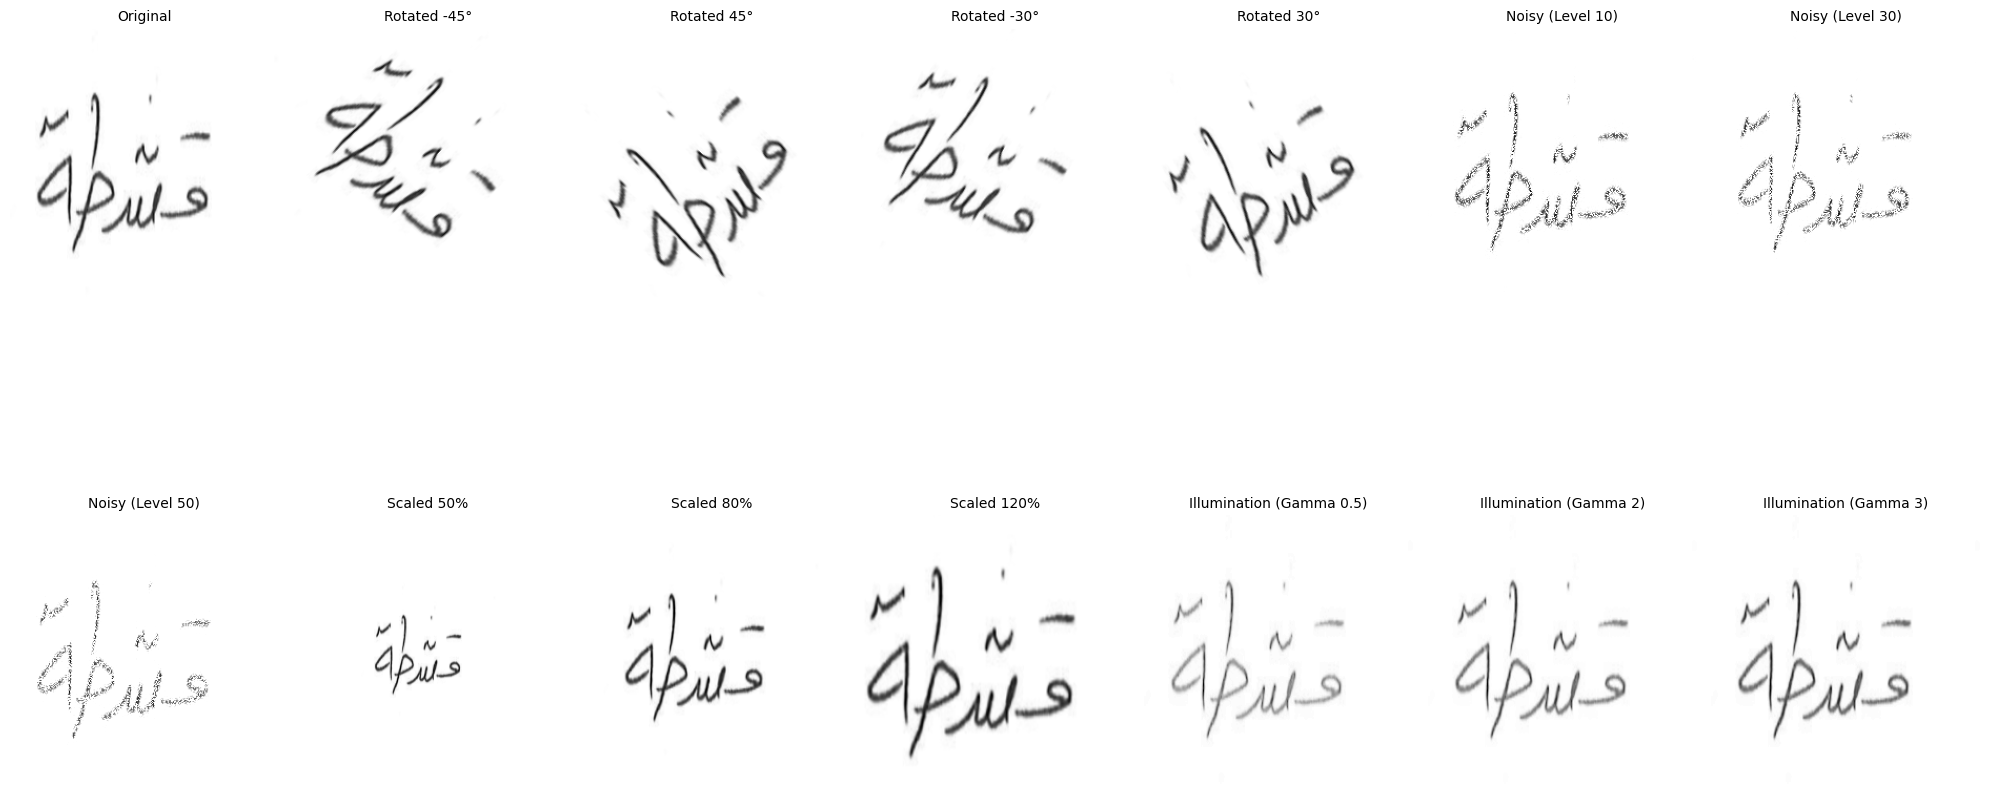

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'augmented_images_training' has been generated using the updated augment_images function

# Select one user from the augmented_images_training
user = list(augmented_images_training.keys())[0]  # Replace with the correct user index
augmented_data = augmented_images_training[user]

# Dynamically create a dictionary for the original and augmented images
augmentation_types = {}
for filename, img in augmented_data:
    if "original" in filename:
        augmentation_types["Original"] = img
    elif "rotated" in filename:
        rotation_angle = filename.split("_")[-1].replace("deg", "")  # Extract rotation angle
        augmentation_types[f"Rotated {rotation_angle}°"] = img
    elif "noisy" in filename:
        noise_level = filename.split("_")[-1].replace("level_", "")  # Extract noise level
        augmentation_types[f"Noisy (Level {noise_level})"] = img
    elif "scaled" in filename:
        scale_factor = filename.split("_")[-1].replace("%", "")  # Extract scaling factor
        augmentation_types[f"Scaled {scale_factor}%"] = img
    elif "illumination" in filename:
        gamma = filename.split("_")[-1]  # Extract gamma value for illumination
        augmentation_types[f"Illumination (Gamma {gamma})"] = img

# Plot the images dynamically based on the number of augmentations
plt.figure(figsize=(20, 12))  # Increase figure size for better visibility
for i, (title, img) in enumerate(augmentation_types.items()):
    plt.subplot(2, int(np.ceil(len(augmentation_types) / 2)), i + 1)  # Split into multiple rows
    plt.imshow(img, cmap="gray")
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Count the number of images (including augmentations) for all users
for user, images in augmented_images_training.items():
    num_images = len(images)
    print(f"Total number of images (including augmentations) for {user}: {num_images}")


Total number of images (including augmentations) for user026: 1120
Total number of images (including augmentations) for user055: 1120
Total number of images (including augmentations) for user021: 1120
Total number of images (including augmentations) for user020: 1120
Total number of images (including augmentations) for user008: 1120
Total number of images (including augmentations) for user041: 1120
Total number of images (including augmentations) for user039: 1120
Total number of images (including augmentations) for user016: 1120
Total number of images (including augmentations) for user013: 1120
Total number of images (including augmentations) for user048: 1120
Total number of images (including augmentations) for user069: 1120
Total number of images (including augmentations) for user025: 1120
Total number of images (including augmentations) for user065: 1120
Total number of images (including augmentations) for user054: 1120
Total number of images (including augmentations) for user060: 

In [ ]:
# Count the number of images (for example rotation ) for all users
for user, images in testing_augmentations_results["log_adjusted"].items():
    num_images = len(images)
    print(f"Total number of images (including augmentations) for {user}: {num_images}")

KeyError: 'log_adjusted'

In [ ]:
good = True

for user, images in augmented_images_training.items():


    if len(images) != 960 :
        print(f"{user} has {len(images)} images.")
        good = False

if good:
    print("All users have the expected number of images.")


All users have the expected number of images.


In [ ]:
print(cv2.getBuildInformation())



General configuration for OpenCV 4.10.0 =====================================
  Version control:               4.10.0-dirty

  Platform:
    Timestamp:                   2024-06-17T17:56:37Z
    Host:                        Linux 5.15.0-1064-azure x86_64
    CMake:                       3.29.5
    CMake generator:             Unix Makefiles
    CMake build tool:            /bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (0 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (8 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      AVX2 (36 files):           + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 FMA3 AVX

# 4. Feature Extraction using ORB and SIFT

In [ ]:
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time
from tqdm import tqdm  # Added for progress bar

# Detect the number of available CPU cores
NUM_CORES = os.cpu_count()

# Global function to process a single image (SIFT or ORB)
def process_image_sift(img, method="sift"):
    """
    Extract features from a single image using SIFT or ORB.
    """
    if method == "sift":
        feature_extractor = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5)
    elif method == "orb":
        feature_extractor = cv2.ORB_create(nfeatures=1000)
    else:
        raise ValueError("Invalid method specified. Use 'sift' or 'orb'.")

    start_time = time.time()  # Start timing
    keypoints, descriptors = feature_extractor.detectAndCompute(img, None)
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time

    # Log the number of key points and execution time
    num_keypoints = len(keypoints) if keypoints is not None else 0
    print(f"{method.upper()}: Processed an image: Keypoints = {num_keypoints}, Time = {elapsed_time:.4f}s")

    return keypoints, descriptors, elapsed_time

# Global function to process all images for a single user (SIFT or ORB)
def process_user_images_sift(user, images, method="sift"):
    """
    Extract features for all images of a single user using SIFT or ORB.
    """
    if method == "sift":
        feature_extractor = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5)
    elif method == "orb":
        feature_extractor = cv2.ORB_create(nfeatures=500)
    else:
        raise ValueError("Invalid method specified. Use 'sift' or 'orb'.")

    user_result = []
    total_keypoints = 0  # To track the number of key points
    total_time = 0       # To track total time for feature extraction

    for _, img in images:
        start_time = time.time()  # Start timing
        keypoints, descriptors = feature_extractor.detectAndCompute(img, None)
        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time

        if descriptors is not None:
            user_result.append(descriptors)
            total_keypoints += len(keypoints)
            total_time += elapsed_time

    # Log results for the user
    print(f"{method.upper()} - User {user}: Total Keypoints = {total_keypoints}, Total Time = {total_time:.4f}s")
    return user, user_result, total_keypoints, total_time

# Main function for parallel feature extraction (SIFT or ORB)
def extract_sift_features_maximized(user_images, method="sift"):
    """
    Extract features using multiprocessing to maximize resource utilization.
    Supports 'sift' and 'orb' methods.
    """
    user_descriptors = {}
    descriptors_list = []
    total_keypoints = 0  # To track total key points across all users
    total_time = 0       # To track total time across all users

    # Use all available cores for parallel processing
    with ProcessPoolExecutor(max_workers=NUM_CORES) as executor:
        futures = {
            executor.submit(process_user_images_sift, user, images, method): user
            for user, images in user_images.items()
        }

        # Initialize a progress bar
        with tqdm(total=len(user_images), desc=f"Processing users with {method.upper()}") as pbar:
            for future in as_completed(futures):
                user, user_result, user_keypoints, user_time = future.result()
                user_descriptors[user] = user_result
                for descriptors in user_result:
                    descriptors_list.append(descriptors)

                # Accumulate metrics
                total_keypoints += user_keypoints
                total_time += user_time

                # Update progress bar
                pbar.update(1)

    # Combine all descriptors into a single array
    descriptors_array = np.vstack(descriptors_list) if descriptors_list else None

    # Calculate averages
    avg_keypoints = total_keypoints / len(user_images) if len(user_images) > 0 else 0
    avg_time = total_time / len(user_images) if len(user_images) > 0 else 0

    # Log overall results
    print(f"{method.upper()} - Total Keypoints Across All Users: {total_keypoints}")
    print(f"{method.upper()} - Total Time for Feature Extraction: {total_time:.4f}s")
    print(f"{method.upper()} - Average Keypoints Per User: {avg_keypoints:.2f}")
    print(f"{method.upper()} - Average Time Per User: {avg_time:.4f}s")

    return descriptors_array, user_descriptors, avg_keypoints, avg_time



# Exploration Sift and ORB , keypoints Extraction and matching .

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

def load_images_from_directory(directory):
    """
    Load all images from a given directory.

    Args:
        directory: Path to the directory.

    Returns:
        List of tuples (image_name, image_data).
    """
    images = []
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # Only load image files
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append((filename, image))
            else:
                print(f"Error: Could not load image {filepath}")
    return images

def extract_and_match_features(img1, img2, algorithm="SIFT"):
    """
    Extract and match features between two images using the specified algorithm.

    Args:
        img1: First grayscale image.
        img2: Second grayscale image.
        algorithm: Feature extraction algorithm ("SIFT" or "ORB").

    Returns:
        keypoints1, keypoints2: Keypoints in image 1 and 2.
        matches: Matched keypoints between the images.
        matched_img: Image with matched keypoints drawn.
    """
    if algorithm == "SIFT":
        # Use SIFT
        extractor = cv2.SIFT_create()
        norm_type = cv2.NORM_L2
    elif algorithm == "ORB":
        # Use ORB
        extractor = cv2.ORB_create()
        norm_type = cv2.NORM_HAMMING
    else:
        raise ValueError("Unsupported algorithm. Use 'SIFT' or 'ORB'.")

    # Detect and compute keypoints and descriptors
    keypoints1, descriptors1 = extractor.detectAndCompute(img1, None)
    keypoints2, descriptors2 = extractor.detectAndCompute(img2, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(norm_type, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance (best matches first)

    # Draw matches
    matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return keypoints1, keypoints2, matches, matched_img

def visualize_matches(matched_img, title):
    """
    Visualize the matched keypoints between two images.
    """
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.imshow(matched_img)
    plt.axis("off")
    plt.show()

def main():
    # Directory containing the images
    directory = "/content/isolated_words_per_user/user001"

    # Load all images
    images = load_images_from_directory(directory)

    # Generate all pairs of images
    pairs = [(images[i], images[j]) for i in range(len(images)) for j in range(i + 1, len(images))]

    # Process each pair
    for (name1, img1), (name2, img2) in pairs:
        print(f"\nProcessing pair: {name1} vs {name2}")

        # SIFT processing
        print("Processing with SIFT...")
        keypoints1_sift, keypoints2_sift, matches_sift, matched_img_sift = extract_and_match_features(img1, img2, algorithm="SIFT")
        print(f"SIFT: Found {len(keypoints1_sift)} keypoints in Image 1 and {len(keypoints2_sift)} keypoints in Image 2.")
        print(f"SIFT: Found {len(matches_sift)} matches.")
        visualize_matches(matched_img_sift, f"SIFT: {name1} vs {name2}")

        # ORB processing
        print("Processing with ORB...")
        keypoints1_orb, keypoints2_orb, matches_orb, matched_img_orb = extract_and_match_features(img1, img2, algorithm="ORB")
        print(f"ORB: Found {len(keypoints1_orb)} keypoints in Image 1 and {len(keypoints2_orb)} keypoints in Image 2.")
        print(f"ORB: Found {len(matches_orb)} matches.")
        visualize_matches(matched_img_orb, f"ORB: {name1} vs {name2}")

if __name__ == "__main__":
    main()


In [ ]:
import pickle

# Example of running the optimized function for both SIFT and ORB
print("Running SIFT feature extraction...")
descriptors_array_sift_training, user_descriptors_sift_training, avg_keypoints_sift, avg_time_sift = extract_sift_features_maximized(
    augmented_images_training, method="sift"
)

print("\nRunning ORB feature extraction...")
descriptors_array_orb_training, user_descriptors_orb_training, avg_keypoints_orb, avg_time_orb = extract_sift_features_maximized(
    augmented_images_training, method="orb"
)

# Display final average results
print("\nFinal Averages:")
print(f"SIFT - Average Keypoints Per User: {avg_keypoints_sift:.2f}, Average Time Per User: {avg_time_sift:.4f}s")
print(f"ORB - Average Keypoints Per User: {avg_keypoints_orb:.2f}, Average Time Per User: {avg_time_orb:.4f}s")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running SIFT feature extraction...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user033: Total Keypoints = 41425, Total Time = 57.4675s


Processing users with SIFT:   1%|          | 1/81 [00:59<1:19:10, 59.38s/it]

SIFT - User user047: Total Keypoints = 40171, Total Time = 59.4181s


Processing users with SIFT:   2%|▏         | 2/81 [01:00<32:55, 25.01s/it]  

SIFT - User user039: Total Keypoints = 34186, Total Time = 56.9972s


Processing users with SIFT:   4%|▎         | 3/81 [01:01<18:09, 13.97s/it]

SIFT - User user027: Total Keypoints = 41814, Total Time = 58.2662s
SIFT - User user034: Total Keypoints = 41821, Total Time = 61.1022s
SIFT - User user073: Total Keypoints = 50320, Total Time = 60.3284s
SIFT - User user055: Total Keypoints = 45644, Total Time = 59.2699s


Processing users with SIFT:   9%|▊         | 7/81 [01:02<04:05,  3.32s/it]

SIFT - User user076: Total Keypoints = 41653, Total Time = 58.6433s


Processing users with SIFT:  10%|▉         | 8/81 [01:03<03:22,  2.77s/it]

SIFT - User user065: Total Keypoints = 36603, Total Time = 55.3346s


Processing users with SIFT:  11%|█         | 9/81 [01:55<17:56, 14.95s/it]

SIFT - User user043: Total Keypoints = 49223, Total Time = 56.0504s


Processing users with SIFT:  12%|█▏        | 10/81 [01:56<13:35, 11.49s/it]

SIFT - User user005: Total Keypoints = 43843, Total Time = 53.8578s


Processing users with SIFT:  14%|█▎        | 11/81 [01:57<09:57,  8.54s/it]

SIFT - User user051: Total Keypoints = 49190, Total Time = 59.6736s


Processing users with SIFT:  15%|█▍        | 12/81 [02:01<08:15,  7.19s/it]

SIFT - User user022: Total Keypoints = 44633, Total Time = 59.5177s


Processing users with SIFT:  16%|█▌        | 13/81 [02:02<06:13,  5.49s/it]

SIFT - User user015: Total Keypoints = 35319, Total Time = 60.8086s


Processing users with SIFT:  17%|█▋        | 14/81 [02:03<04:33,  4.09s/it]

SIFT - User user011: Total Keypoints = 39728, Total Time = 60.4951s
SIFT - User user071: Total Keypoints = 38416, Total Time = 62.0321s


Processing users with SIFT:  19%|█▊        | 15/81 [02:04<03:38,  3.31s/it]

SIFT - User user004: Total Keypoints = 41849, Total Time = 54.7454s


Processing users with SIFT:  21%|██        | 17/81 [02:52<13:36, 12.76s/it]

SIFT - User user017: Total Keypoints = 33520, Total Time = 61.7972s


Processing users with SIFT:  22%|██▏       | 18/81 [02:57<11:18, 10.77s/it]

SIFT - User user049: Total Keypoints = 41779, Total Time = 62.4639s


Processing users with SIFT:  23%|██▎       | 19/81 [02:59<08:52,  8.59s/it]

SIFT - User user082: Total Keypoints = 47537, Total Time = 58.4589s


Processing users with SIFT:  25%|██▍       | 20/81 [03:00<06:32,  6.44s/it]

SIFT - User user026: Total Keypoints = 45265, Total Time = 59.6171s


Processing users with SIFT:  26%|██▌       | 21/81 [03:03<05:25,  5.43s/it]

SIFT - User user031: Total Keypoints = 43259, Total Time = 59.5930s


Processing users with SIFT:  27%|██▋       | 22/81 [03:04<04:14,  4.31s/it]

SIFT - User user057: Total Keypoints = 36132, Total Time = 62.5374s


Processing users with SIFT:  28%|██▊       | 23/81 [03:05<03:10,  3.29s/it]

SIFT - User user019: Total Keypoints = 42830, Total Time = 61.5269s


Processing users with SIFT:  30%|██▉       | 24/81 [03:06<02:36,  2.74s/it]

SIFT - User user007: Total Keypoints = 44358, Total Time = 61.8562s


Processing users with SIFT:  31%|███       | 25/81 [03:54<15:03, 16.14s/it]

SIFT - User user040: Total Keypoints = 41507, Total Time = 58.1191s


Processing users with SIFT:  32%|███▏      | 26/81 [03:58<11:14, 12.27s/it]

SIFT - User user060: Total Keypoints = 46036, Total Time = 61.3982s


Processing users with SIFT:  33%|███▎      | 27/81 [03:58<07:59,  8.88s/it]

SIFT - User user075: Total Keypoints = 46648, Total Time = 56.4244s


Processing users with SIFT:  35%|███▍      | 28/81 [04:03<06:42,  7.59s/it]

SIFT - User user048: Total Keypoints = 47036, Total Time = 62.1012s
SIFT - User user016: Total Keypoints = 37820, Total Time = 64.9612s


Processing users with SIFT:  36%|███▌      | 29/81 [04:05<05:08,  5.94s/it]

SIFT - User user032: Total Keypoints = 47993, Total Time = 61.9713s


Processing users with SIFT:  38%|███▊      | 31/81 [04:06<02:55,  3.52s/it]

SIFT - User user070: Total Keypoints = 41740, Total Time = 62.7256s


Processing users with SIFT:  40%|███▉      | 32/81 [04:08<02:27,  3.02s/it]

SIFT - User user013: Total Keypoints = 48000, Total Time = 55.3742s


Processing users with SIFT:  41%|████      | 33/81 [04:53<11:15, 14.08s/it]

SIFT - User user002: Total Keypoints = 47050, Total Time = 59.1456s
SIFT - User user069: Total Keypoints = 46981, Total Time = 55.2295s


Processing users with SIFT:  42%|████▏     | 34/81 [04:54<08:11, 10.46s/it]

SIFT - User user001: Total Keypoints = 45059, Total Time = 55.2998s


Processing users with SIFT:  44%|████▍     | 36/81 [05:01<05:35,  7.47s/it]

SIFT - User user045: Total Keypoints = 49247, Total Time = 62.7172s


Processing users with SIFT:  46%|████▌     | 37/81 [05:06<04:59,  6.82s/it]

SIFT - User user079: Total Keypoints = 47474, Total Time = 60.7948s


Processing users with SIFT:  47%|████▋     | 38/81 [05:06<03:44,  5.22s/it]

SIFT - User user041: Total Keypoints = 37196, Total Time = 62.4641s


Processing users with SIFT:  48%|████▊     | 39/81 [05:09<03:10,  4.54s/it]

SIFT - User user072: Total Keypoints = 42226, Total Time = 63.5480s


Processing users with SIFT:  49%|████▉     | 40/81 [05:12<02:43,  4.00s/it]

SIFT - User user006: Total Keypoints = 43202, Total Time = 58.1158s


Processing users with SIFT:  51%|█████     | 41/81 [05:52<09:26, 14.16s/it]

SIFT - User user038: Total Keypoints = 37096, Total Time = 57.5844s


Processing users with SIFT:  52%|█████▏    | 42/81 [05:53<06:43, 10.35s/it]

SIFT - User user030: Total Keypoints = 38891, Total Time = 63.4447s


Processing users with SIFT:  53%|█████▎    | 43/81 [05:58<05:35,  8.84s/it]

SIFT - User user063: Total Keypoints = 38871, Total Time = 60.9220s


Processing users with SIFT:  54%|█████▍    | 44/81 [06:02<04:42,  7.63s/it]

SIFT - User user010: Total Keypoints = 44754, Total Time = 56.3412s


Processing users with SIFT:  56%|█████▌    | 45/81 [06:03<03:19,  5.55s/it]

SIFT - User user025: Total Keypoints = 47932, Total Time = 58.5618s


Processing users with SIFT:  57%|█████▋    | 46/81 [06:06<02:42,  4.63s/it]

SIFT - User user037: Total Keypoints = 41627, Total Time = 60.3927s


Processing users with SIFT:  58%|█████▊    | 47/81 [06:10<02:34,  4.54s/it]

SIFT - User user020: Total Keypoints = 51349, Total Time = 61.5447s


Processing users with SIFT:  59%|█████▉    | 48/81 [06:14<02:21,  4.30s/it]

SIFT - User user023: Total Keypoints = 38795, Total Time = 59.6319s


Processing users with SIFT:  60%|██████    | 49/81 [06:53<07:50, 14.69s/it]

SIFT - User user046: Total Keypoints = 47642, Total Time = 57.5136s


Processing users with SIFT:  62%|██████▏   | 50/81 [06:56<05:46, 11.19s/it]

SIFT - User user058: Total Keypoints = 38568, Total Time = 64.1342s


Processing users with SIFT:  63%|██████▎   | 51/81 [06:56<04:01,  8.06s/it]

SIFT - User user074: Total Keypoints = 39306, Total Time = 59.1659s


Processing users with SIFT:  64%|██████▍   | 52/81 [07:02<03:32,  7.32s/it]

SIFT - User user018: Total Keypoints = 39375, Total Time = 60.8714s


Processing users with SIFT:  65%|██████▌   | 53/81 [07:04<02:43,  5.83s/it]

SIFT - User user021: Total Keypoints = 42335, Total Time = 58.9749s


Processing users with SIFT:  67%|██████▋   | 54/81 [07:05<01:56,  4.33s/it]

SIFT - User user080: Total Keypoints = 43271, Total Time = 55.3458s


Processing users with SIFT:  68%|██████▊   | 55/81 [07:06<01:24,  3.25s/it]

SIFT - User user078: Total Keypoints = 29325, Total Time = 60.9207s


Processing users with SIFT:  69%|██████▉   | 56/81 [07:15<02:04,  4.99s/it]

SIFT - User user012: Total Keypoints = 46695, Total Time = 58.1066s


Processing users with SIFT:  70%|███████   | 57/81 [07:54<06:05, 15.24s/it]

SIFT - User user029: Total Keypoints = 42329, Total Time = 58.1180s
SIFT - User user054: Total Keypoints = 46218, Total Time = 61.9657s


Processing users with SIFT:  72%|███████▏  | 58/81 [07:55<04:11, 10.92s/it]

SIFT - User user009: Total Keypoints = 54236, Total Time = 53.8705s


Processing users with SIFT:  74%|███████▍  | 60/81 [07:59<02:21,  6.72s/it]

SIFT - User user035: Total Keypoints = 34778, Total Time = 61.8966s


Processing users with SIFT:  75%|███████▌  | 61/81 [08:04<02:08,  6.44s/it]

SIFT - User user066: Total Keypoints = 44529, Total Time = 60.1041s


Processing users with SIFT:  77%|███████▋  | 62/81 [08:06<01:40,  5.31s/it]

SIFT - User user052: Total Keypoints = 40401, Total Time = 61.8025s


Processing users with SIFT:  78%|███████▊  | 63/81 [08:07<01:14,  4.13s/it]

SIFT - User user036: Total Keypoints = 43758, Total Time = 55.8418s


Processing users with SIFT:  79%|███████▉  | 64/81 [08:11<01:08,  4.04s/it]

SIFT - User user050: Total Keypoints = 46351, Total Time = 58.9604s


Processing users with SIFT:  80%|████████  | 65/81 [08:53<04:00, 15.01s/it]

SIFT - User user068: Total Keypoints = 35860, Total Time = 59.1097s


Processing users with SIFT:  81%|████████▏ | 66/81 [08:55<02:46, 11.09s/it]

SIFT - User user042: Total Keypoints = 45893, Total Time = 60.6292s


Processing users with SIFT:  83%|████████▎ | 67/81 [08:56<01:53,  8.10s/it]

SIFT - User user056: Total Keypoints = 41478, Total Time = 58.0269s


Processing users with SIFT:  84%|████████▍ | 68/81 [08:57<01:18,  6.02s/it]

SIFT - User user024: Total Keypoints = 40275, Total Time = 60.0323s


Processing users with SIFT:  85%|████████▌ | 69/81 [09:07<01:25,  7.13s/it]

SIFT - User user014: Total Keypoints = 38771, Total Time = 63.9527s


Processing users with SIFT:  86%|████████▋ | 70/81 [09:08<01:00,  5.54s/it]

SIFT - User user064: Total Keypoints = 45561, Total Time = 65.0346s


Processing users with SIFT:  88%|████████▊ | 71/81 [09:13<00:51,  5.11s/it]

SIFT - User user067: Total Keypoints = 45349, Total Time = 61.6140s


Processing users with SIFT:  89%|████████▉ | 72/81 [09:13<00:33,  3.76s/it]

SIFT - User user008: Total Keypoints = 41318, Total Time = 54.4964s


Processing users with SIFT:  90%|█████████ | 73/81 [09:50<01:48, 13.60s/it]

SIFT - User user053: Total Keypoints = 54823, Total Time = 54.7527s


Processing users with SIFT:  91%|█████████▏| 74/81 [09:51<01:09,  9.87s/it]

SIFT - User user044: Total Keypoints = 45000, Total Time = 58.0488s


Processing users with SIFT:  93%|█████████▎| 75/81 [09:52<00:43,  7.18s/it]

SIFT - User user061: Total Keypoints = 40818, Total Time = 59.4731s


Processing users with SIFT:  94%|█████████▍| 76/81 [09:57<00:32,  6.47s/it]

SIFT - User user003: Total Keypoints = 42549, Total Time = 49.5864s


Processing users with SIFT:  95%|█████████▌| 77/81 [09:58<00:20,  5.07s/it]

SIFT - User user077: Total Keypoints = 42026, Total Time = 51.9220s


Processing users with SIFT:  96%|█████████▋| 78/81 [09:59<00:11,  3.68s/it]

SIFT - User user028: Total Keypoints = 37232, Total Time = 51.0975s


Processing users with SIFT:  98%|█████████▊| 79/81 [10:05<00:08,  4.27s/it]

SIFT - User user081: Total Keypoints = 41524, Total Time = 53.9138s


Processing users with SIFT:  99%|█████████▉| 80/81 [10:07<00:03,  3.65s/it]

SIFT - User user062: Total Keypoints = 41661, Total Time = 32.2028s


Processing users with SIFT: 100%|██████████| 81/81 [10:22<00:00,  7.69s/it]


SIFT - Total Keypoints Across All Users: 3464303
SIFT - Total Time for Feature Extraction: 4762.1575s
SIFT - Average Keypoints Per User: 42769.17
SIFT - Average Time Per User: 58.7921s

Running ORB feature extraction...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user034: Total Keypoints = 283519, Total Time = 2.0194s


Processing users with ORB:   1%|          | 1/81 [00:02<03:20,  2.51s/it]

ORB - User user047: Total Keypoints = 258177, Total Time = 1.8399s


Processing users with ORB:   2%|▏         | 2/81 [00:02<01:26,  1.10s/it]

ORB - User user073: Total Keypoints = 272530, Total Time = 2.2374s


Processing users with ORB:   4%|▎         | 3/81 [00:03<01:22,  1.06s/it]

ORB - User user033: Total Keypoints = 303372, Total Time = 2.6354s


Processing users with ORB:   5%|▍         | 4/81 [00:04<01:19,  1.03s/it]

ORB - User user027: Total Keypoints = 336019, Total Time = 2.3190s


Processing users with ORB:   6%|▌         | 5/81 [00:05<01:04,  1.18it/s]

ORB - User user055: Total Keypoints = 311530, Total Time = 3.0838s


Processing users with ORB:   7%|▋         | 6/81 [00:05<00:51,  1.45it/s]

ORB - User user039: Total Keypoints = 292627, Total Time = 2.2713s


Processing users with ORB:   9%|▊         | 7/81 [00:05<00:44,  1.65it/s]

ORB - User user065: Total Keypoints = 287594, Total Time = 2.5265s


Processing users with ORB:  10%|▉         | 8/81 [00:06<00:52,  1.39it/s]

ORB - User user076: Total Keypoints = 296318, Total Time = 3.2203s


Processing users with ORB:  11%|█         | 9/81 [00:07<00:44,  1.63it/s]

ORB - User user043: Total Keypoints = 313972, Total Time = 3.3776s


Processing users with ORB:  12%|█▏        | 10/81 [00:08<00:52,  1.34it/s]

ORB - User user015: Total Keypoints = 291479, Total Time = 2.9138s
ORB - User user051: Total Keypoints = 313260, Total Time = 3.5125s


Processing users with ORB:  14%|█▎        | 11/81 [00:08<00:48,  1.45it/s]

ORB - User user071: Total Keypoints = 292455, Total Time = 3.3441s


Processing users with ORB:  16%|█▌        | 13/81 [00:09<00:35,  1.94it/s]

ORB - User user022: Total Keypoints = 309927, Total Time = 3.6301s


Processing users with ORB:  17%|█▋        | 14/81 [00:10<00:37,  1.78it/s]

ORB - User user005: Total Keypoints = 280290, Total Time = 3.3167s


Processing users with ORB:  19%|█▊        | 15/81 [00:10<00:35,  1.88it/s]

ORB - User user011: Total Keypoints = 255699, Total Time = 3.5428s


Processing users with ORB:  20%|█▉        | 16/81 [00:11<00:33,  1.93it/s]

ORB - User user017: Total Keypoints = 252838, Total Time = 3.2707s
ORB - User user049: Total Keypoints = 290349, Total Time = 3.3702s


Processing users with ORB:  22%|██▏       | 18/81 [00:12<00:32,  1.96it/s]

ORB - User user004: Total Keypoints = 267657, Total Time = 3.3628s


Processing users with ORB:  23%|██▎       | 19/81 [00:12<00:31,  1.96it/s]

ORB - User user082: Total Keypoints = 322678, Total Time = 3.4905s


Processing users with ORB:  25%|██▍       | 20/81 [00:13<00:31,  1.91it/s]

ORB - User user057: Total Keypoints = 283415, Total Time = 3.1695s


Processing users with ORB:  26%|██▌       | 21/81 [00:13<00:32,  1.86it/s]

ORB - User user026: Total Keypoints = 314721, Total Time = 3.3452s


Processing users with ORB:  27%|██▋       | 22/81 [00:14<00:31,  1.85it/s]

ORB - User user031: Total Keypoints = 264326, Total Time = 3.5785s


Processing users with ORB:  28%|██▊       | 23/81 [00:15<00:33,  1.75it/s]

ORB - User user019: Total Keypoints = 299523, Total Time = 3.8206s


Processing users with ORB:  30%|██▉       | 24/81 [00:15<00:38,  1.49it/s]

ORB - User user007: Total Keypoints = 263030, Total Time = 3.6042s
ORB - User user060: Total Keypoints = 314333, Total Time = 3.7274s


Processing users with ORB:  32%|███▏      | 26/81 [00:17<00:34,  1.58it/s]

ORB - User user040: Total Keypoints = 277908, Total Time = 3.7515s


Processing users with ORB:  33%|███▎      | 27/81 [00:17<00:27,  1.94it/s]

ORB - User user016: Total Keypoints = 256842, Total Time = 3.3319s


Processing users with ORB:  35%|███▍      | 28/81 [00:17<00:25,  2.06it/s]

ORB - User user048: Total Keypoints = 297003, Total Time = 3.6161s


Processing users with ORB:  36%|███▌      | 29/81 [00:18<00:26,  1.96it/s]

ORB - User user032: Total Keypoints = 290163, Total Time = 3.5543s


Processing users with ORB:  37%|███▋      | 30/81 [00:18<00:27,  1.87it/s]

ORB - User user070: Total Keypoints = 296706, Total Time = 3.5039s


Processing users with ORB:  38%|███▊      | 31/81 [00:19<00:26,  1.89it/s]

ORB - User user075: Total Keypoints = 313583, Total Time = 3.7823s


Processing users with ORB:  40%|███▉      | 32/81 [00:20<00:32,  1.53it/s]

ORB - User user002: Total Keypoints = 301441, Total Time = 3.7301s


Processing users with ORB:  41%|████      | 33/81 [00:20<00:29,  1.62it/s]

ORB - User user013: Total Keypoints = 289018, Total Time = 3.7955s


Processing users with ORB:  42%|████▏     | 34/81 [00:21<00:28,  1.65it/s]

ORB - User user069: Total Keypoints = 333153, Total Time = 3.7791s
ORB - User user045: Total Keypoints = 294040, Total Time = 3.5354s

Processing users with ORB:  43%|████▎     | 35/81 [00:21<00:26,  1.72it/s]


ORB - User user079: Total Keypoints = 299422, Total Time = 3.4488s


Processing users with ORB:  46%|████▌     | 37/81 [00:22<00:19,  2.27it/s]

ORB - User user001: Total Keypoints = 238780, Total Time = 3.3405s


Processing users with ORB:  47%|████▋     | 38/81 [00:22<00:18,  2.28it/s]

ORB - User user041: Total Keypoints = 299208, Total Time = 3.2047s


Processing users with ORB:  48%|████▊     | 39/81 [00:23<00:18,  2.33it/s]

ORB - User user072: Total Keypoints = 303646, Total Time = 3.2536s


Processing users with ORB:  49%|████▉     | 40/81 [00:23<00:18,  2.22it/s]

ORB - User user006: Total Keypoints = 262630, Total Time = 3.1852s


Processing users with ORB:  51%|█████     | 41/81 [00:24<00:17,  2.23it/s]

ORB - User user030: Total Keypoints = 280201, Total Time = 3.1581s


Processing users with ORB:  52%|█████▏    | 42/81 [00:25<00:21,  1.77it/s]

ORB - User user038: Total Keypoints = 304166, Total Time = 3.3103s


Processing users with ORB:  53%|█████▎    | 43/81 [00:25<00:20,  1.83it/s]

ORB - User user063: Total Keypoints = 264950, Total Time = 3.1284s
ORB - User user010: Total Keypoints = 297803, Total Time = 3.3470s


Processing users with ORB:  56%|█████▌    | 45/81 [00:26<00:19,  1.88it/s]

ORB - User user025: Total Keypoints = 280437, Total Time = 3.3329s


Processing users with ORB:  57%|█████▋    | 46/81 [00:27<00:18,  1.92it/s]

ORB - User user037: Total Keypoints = 296222, Total Time = 3.2953s
ORB - User user020: Total Keypoints = 291372, Total Time = 3.3566s
ORB - User user058: Total Keypoints = 259643, Total Time = 3.1129s


Processing users with ORB:  59%|█████▉    | 48/81 [00:28<00:16,  2.03it/s]

ORB - User user023: Total Keypoints = 298893, Total Time = 3.4176s


Processing users with ORB:  62%|██████▏   | 50/81 [00:29<00:15,  2.02it/s]

ORB - User user046: Total Keypoints = 271833, Total Time = 3.3184s
ORB - User user074: Total Keypoints = 299285, Total Time = 3.4140s


Processing users with ORB:  64%|██████▍   | 52/81 [00:29<00:14,  2.05it/s]

ORB - User user018: Total Keypoints = 302699, Total Time = 3.3647s


Processing users with ORB:  65%|██████▌   | 53/81 [00:30<00:13,  2.04it/s]

ORB - User user021: Total Keypoints = 293479, Total Time = 3.3373s


Processing users with ORB:  67%|██████▋   | 54/81 [00:30<00:13,  2.06it/s]

ORB - User user078: Total Keypoints = 237816, Total Time = 2.9541sORB - User user080: Total Keypoints = 291291, Total Time = 3.4094s



Processing users with ORB:  68%|██████▊   | 55/81 [00:31<00:12,  2.08it/s]

ORB - User user054: Total Keypoints = 272872, Total Time = 3.2615s


Processing users with ORB:  70%|███████   | 57/81 [00:32<00:09,  2.44it/s]

ORB - User user012: Total Keypoints = 253186, Total Time = 3.3193s


Processing users with ORB:  72%|███████▏  | 58/81 [00:32<00:11,  1.96it/s]

ORB - User user035: Total Keypoints = 239626, Total Time = 3.1599s
ORB - User user029: Total Keypoints = 339642, Total Time = 3.7221s


Processing users with ORB:  73%|███████▎  | 59/81 [00:33<00:11,  1.87it/s]

ORB - User user009: Total Keypoints = 257280, Total Time = 3.4270s


Processing users with ORB:  75%|███████▌  | 61/81 [00:34<00:09,  2.22it/s]

ORB - User user052: Total Keypoints = 276571, Total Time = 3.5678s


Processing users with ORB:  77%|███████▋  | 62/81 [00:35<00:10,  1.82it/s]

ORB - User user066: Total Keypoints = 311086, Total Time = 3.6099s


Processing users with ORB:  78%|███████▊  | 63/81 [00:35<00:09,  1.82it/s]

ORB - User user036: Total Keypoints = 287370, Total Time = 3.6198s


Processing users with ORB:  79%|███████▉  | 64/81 [00:35<00:08,  2.12it/s]

ORB - User user050: Total Keypoints = 296007, Total Time = 3.6453s


Processing users with ORB:  80%|████████  | 65/81 [00:36<00:07,  2.12it/s]

ORB - User user042: Total Keypoints = 302148, Total Time = 3.7361s
ORB - User user068: Total Keypoints = 289553, Total Time = 3.5802s


Processing users with ORB:  81%|████████▏ | 66/81 [00:37<00:09,  1.61it/s]

ORB - User user056: Total Keypoints = 273499, Total Time = 3.6619s


Processing users with ORB:  84%|████████▍ | 68/81 [00:38<00:07,  1.75it/s]

ORB - User user014: Total Keypoints = 273138, Total Time = 3.6478s


Processing users with ORB:  85%|████████▌ | 69/81 [00:38<00:05,  2.16it/s]

ORB - User user024: Total Keypoints = 305926, Total Time = 3.5551s


Processing users with ORB:  86%|████████▋ | 70/81 [00:38<00:05,  2.18it/s]

ORB - User user064: Total Keypoints = 323312, Total Time = 3.7382s


Processing users with ORB:  88%|████████▊ | 71/81 [00:40<00:06,  1.54it/s]

ORB - User user067: Total Keypoints = 334210, Total Time = 3.7796s
ORB - User user044: Total Keypoints = 289465, Total Time = 3.6184s


Processing users with ORB:  89%|████████▉ | 72/81 [00:40<00:05,  1.59it/s]

ORB - User user008: Total Keypoints = 232516, Total Time = 3.5252s


Processing users with ORB:  91%|█████████▏| 74/81 [00:41<00:03,  2.13it/s]

ORB - User user053: Total Keypoints = 343770, Total Time = 3.8741s


Processing users with ORB:  93%|█████████▎| 75/81 [00:41<00:03,  1.87it/s]

ORB - User user061: Total Keypoints = 271859, Total Time = 3.4806s


Processing users with ORB:  94%|█████████▍| 76/81 [00:42<00:02,  2.31it/s]

ORB - User user077: Total Keypoints = 284592, Total Time = 3.5773s


Processing users with ORB:  95%|█████████▌| 77/81 [00:42<00:01,  2.11it/s]

ORB - User user003: Total Keypoints = 287640, Total Time = 3.1719s


Processing users with ORB:  96%|█████████▋| 78/81 [00:42<00:01,  2.64it/s]

ORB - User user081: Total Keypoints = 290686, Total Time = 2.8344s


Processing users with ORB:  98%|█████████▊| 79/81 [00:43<00:00,  2.68it/s]

ORB - User user028: Total Keypoints = 288645, Total Time = 2.7066s


Processing users with ORB:  99%|█████████▉| 80/81 [00:43<00:00,  2.50it/s]

ORB - User user062: Total Keypoints = 312612, Total Time = 2.4768s


Processing users with ORB: 100%|██████████| 81/81 [00:43<00:00,  1.85it/s]


ORB - Total Keypoints Across All Users: 23432482
ORB - Total Time for Feature Extraction: 268.8966s
ORB - Average Keypoints Per User: 289289.90
ORB - Average Time Per User: 3.3197s

Final Averages:
SIFT - Average Keypoints Per User: 42769.17, Average Time Per User: 58.7921s
ORB - Average Keypoints Per User: 289289.90, Average Time Per User: 3.3197s
Data saved successfully to /content/drive/My Drive/feature_data.pkl!


# Running Feature Extraction using sift and ORB on traning data

In [ ]:
# Example of running the optimized function for both SIFT and ORB
print("Running SIFT feature extraction...")
descriptors_array_sift_training, user_descriptors_sift_training, avg_keypoints_sift, avg_time_sift = extract_sift_features_maximized(
    train_images, method="sift"
)

print("\nRunning ORB feature extraction...")
descriptors_array_orb_training, user_descriptors_orb_training, avg_keypoints_orb, avg_time_orb = extract_sift_features_maximized(
    train_images, method="orb"
)

# Display final average results
print("\nFinal Averages:")
print(f"SIFT - Average Keypoints Per User: {avg_keypoints_sift:.2f}, Average Time Per User: {avg_time_sift:.4f}s")
print(f"ORB - Average Keypoints Per User: {avg_keypoints_orb:.2f}, Average Time Per User: {avg_time_orb:.4f}s")


Running SIFT feature extraction...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user065: Total Keypoints = 3216, Total Time = 4.2078s


Processing users with SIFT:   1%|          | 1/81 [00:04<05:41,  4.27s/it]

SIFT - User user047: Total Keypoints = 3548, Total Time = 4.4071s


Processing users with SIFT:   2%|▏         | 2/81 [00:04<02:30,  1.91s/it]

SIFT - User user039: Total Keypoints = 3278, Total Time = 4.3399s


Processing users with SIFT:   4%|▎         | 3/81 [00:04<01:26,  1.11s/it]

SIFT - User user033: Total Keypoints = 3772, Total Time = 4.4205sSIFT - User user073: Total Keypoints = 4445, Total Time = 4.7103s



Processing users with SIFT:   5%|▍         | 4/81 [00:04<00:57,  1.34it/s]

SIFT - User user055: Total Keypoints = 4825, Total Time = 4.6100s


Processing users with SIFT:   7%|▋         | 6/81 [00:05<00:29,  2.54it/s]

SIFT - User user051: Total Keypoints = 4570, Total Time = 4.7715s
SIFT - User user015: Total Keypoints = 3308, Total Time = 4.8784s
SIFT - User user027: Total Keypoints = 3786, Total Time = 5.0943s


Processing users with SIFT:  11%|█         | 9/81 [00:09<01:09,  1.04it/s]

SIFT - User user076: Total Keypoints = 3858, Total Time = 4.8958s
SIFT - User user043: Total Keypoints = 4592, Total Time = 4.8972s


Processing users with SIFT:  14%|█▎        | 11/81 [00:09<00:47,  1.48it/s]

SIFT - User user005: Total Keypoints = 4300, Total Time = 4.9314s


Processing users with SIFT:  15%|█▍        | 12/81 [00:10<00:43,  1.57it/s]

SIFT - User user034: Total Keypoints = 3845, Total Time = 5.2243s
SIFT - User user071: Total Keypoints = 3541, Total Time = 5.3936s


Processing users with SIFT:  17%|█▋        | 14/81 [00:10<00:30,  2.20it/s]

SIFT - User user011: Total Keypoints = 3736, Total Time = 5.3132sSIFT - User user022: Total Keypoints = 4188, Total Time = 5.2519s

SIFT - User user004: Total Keypoints = 3976, Total Time = 4.7026s


Processing users with SIFT:  21%|██        | 17/81 [00:14<00:53,  1.19it/s]

SIFT - User user026: Total Keypoints = 4303, Total Time = 5.2748s


Processing users with SIFT:  22%|██▏       | 18/81 [00:14<00:48,  1.30it/s]

SIFT - User user082: Total Keypoints = 4677, Total Time = 5.4423s


Processing users with SIFT:  23%|██▎       | 19/81 [00:14<00:39,  1.56it/s]

SIFT - User user031: Total Keypoints = 3746, Total Time = 4.8481s


Processing users with SIFT:  25%|██▍       | 20/81 [00:15<00:32,  1.88it/s]

SIFT - User user049: Total Keypoints = 4357, Total Time = 5.4249s


Processing users with SIFT:  26%|██▌       | 21/81 [00:15<00:31,  1.89it/s]

SIFT - User user017: Total Keypoints = 2960, Total Time = 5.3821s


Processing users with SIFT:  27%|██▋       | 22/81 [00:15<00:26,  2.26it/s]

SIFT - User user019: Total Keypoints = 3779, Total Time = 5.5698s


Processing users with SIFT:  28%|██▊       | 23/81 [00:16<00:21,  2.65it/s]

SIFT - User user057: Total Keypoints = 3554, Total Time = 5.5219s
SIFT - User user060: Total Keypoints = 4199, Total Time = 4.9490s


Processing users with SIFT:  31%|███       | 25/81 [00:19<00:52,  1.06it/s]

SIFT - User user075: Total Keypoints = 4243, Total Time = 4.9469s


Processing users with SIFT:  32%|███▏      | 26/81 [00:20<00:48,  1.13it/s]

SIFT - User user032: Total Keypoints = 4460, Total Time = 5.2161s
SIFT - User user007: Total Keypoints = 4639, Total Time = 5.3012s


Processing users with SIFT:  35%|███▍      | 28/81 [00:20<00:30,  1.74it/s]

SIFT - User user040: Total Keypoints = 3725, Total Time = 4.9537s


Processing users with SIFT:  36%|███▌      | 29/81 [00:20<00:26,  1.94it/s]

SIFT - User user048: Total Keypoints = 4712, Total Time = 5.2232s


Processing users with SIFT:  37%|███▋      | 30/81 [00:21<00:25,  1.98it/s]

SIFT - User user016: Total Keypoints = 3418, Total Time = 5.4361s
SIFT - User user070: Total Keypoints = 3641, Total Time = 5.5122s

Processing users with SIFT:  38%|███▊      | 31/81 [00:21<00:24,  2.03it/s]


SIFT - User user013: Total Keypoints = 4412, Total Time = 4.4849s


Processing users with SIFT:  41%|████      | 33/81 [00:23<00:37,  1.27it/s]

SIFT - User user069: Total Keypoints = 4225, Total Time = 4.4234s


Processing users with SIFT:  42%|████▏     | 34/81 [00:24<00:35,  1.33it/s]

SIFT - User user002: Total Keypoints = 4295, Total Time = 4.8132s


Processing users with SIFT:  43%|████▎     | 35/81 [00:24<00:30,  1.49it/s]

SIFT - User user001: Total Keypoints = 4319, Total Time = 4.4180s


Processing users with SIFT:  44%|████▍     | 36/81 [00:25<00:23,  1.92it/s]

SIFT - User user045: Total Keypoints = 4716, Total Time = 4.9944s


Processing users with SIFT:  46%|████▌     | 37/81 [00:25<00:19,  2.22it/s]

SIFT - User user038: Total Keypoints = 3559, Total Time = 4.4734s


Processing users with SIFT:  47%|████▋     | 38/81 [00:25<00:17,  2.51it/s]

SIFT - User user079: Total Keypoints = 4326, Total Time = 4.8416s


Processing users with SIFT:  48%|████▊     | 39/81 [00:26<00:21,  1.92it/s]

SIFT - User user030: Total Keypoints = 3686, Total Time = 5.0300s


Processing users with SIFT:  49%|████▉     | 40/81 [00:26<00:17,  2.34it/s]

SIFT - User user041: Total Keypoints = 3766, Total Time = 4.9174s


Processing users with SIFT:  51%|█████     | 41/81 [00:28<00:38,  1.04it/s]

SIFT - User user010: Total Keypoints = 4438, Total Time = 4.5287s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:29<00:34,  1.15it/s]

SIFT - User user006: Total Keypoints = 4010, Total Time = 4.4866s
SIFT - User user072: Total Keypoints = 3981, Total Time = 5.0868s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:29<00:18,  1.98it/s]

SIFT - User user025: Total Keypoints = 4407, Total Time = 4.5460s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:29<00:16,  2.23it/s]

SIFT - User user037: Total Keypoints = 3943, Total Time = 4.8986s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:30<00:17,  2.02it/s]

SIFT - User user063: Total Keypoints = 3430, Total Time = 5.1010s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:31<00:21,  1.58it/s]

SIFT - User user020: Total Keypoints = 4650, Total Time = 4.9765s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:31<00:15,  2.06it/s]

SIFT - User user023: Total Keypoints = 4008, Total Time = 5.0892s


Processing users with SIFT:  60%|██████    | 49/81 [00:34<00:38,  1.20s/it]

SIFT - User user058: Total Keypoints = 3770, Total Time = 5.9213sSIFT - User user046: Total Keypoints = 4396, Total Time = 4.8818s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:34<00:28,  1.10it/s]


SIFT - User user018: Total Keypoints = 3972, Total Time = 5.4639s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:35<00:16,  1.81it/s]

SIFT - User user074: Total Keypoints = 3792, Total Time = 5.5081s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:35<00:12,  2.22it/s]

SIFT - User user021: Total Keypoints = 3732, Total Time = 5.6024s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:36<00:15,  1.70it/s]

SIFT - User user078: Total Keypoints = 2876, Total Time = 5.8942s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:37<00:21,  1.23it/s]

SIFT - User user054: Total Keypoints = 4495, Total Time = 6.4857s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:38<00:17,  1.39it/s]

SIFT - User user009: Total Keypoints = 5405, Total Time = 4.7527s


Processing users with SIFT:  70%|███████   | 57/81 [00:40<00:25,  1.07s/it]

SIFT - User user080: Total Keypoints = 3764, Total Time = 5.6655s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:40<00:21,  1.09it/s]

SIFT - User user012: Total Keypoints = 4378, Total Time = 6.0053s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:40<00:15,  1.45it/s]

SIFT - User user035: Total Keypoints = 3185, Total Time = 6.0497s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:41<00:13,  1.60it/s]

SIFT - User user029: Total Keypoints = 4027, Total Time = 6.8105s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:41<00:11,  1.69it/s]

SIFT - User user052: Total Keypoints = 3992, Total Time = 6.7354s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:43<00:15,  1.25it/s]

SIFT - User user042: Total Keypoints = 4240, Total Time = 5.4174s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:43<00:13,  1.38it/s]

SIFT - User user066: Total Keypoints = 4248, Total Time = 6.1612s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:43<00:10,  1.70it/s]

SIFT - User user050: Total Keypoints = 4187, Total Time = 4.8872s


Processing users with SIFT:  80%|████████  | 65/81 [00:44<00:12,  1.33it/s]

SIFT - User user014: Total Keypoints = 3305, Total Time = 6.2106s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:46<00:16,  1.09s/it]

SIFT - User user068: Total Keypoints = 3272, Total Time = 6.1333s
SIFT - User user036: Total Keypoints = 4295, Total Time = 5.8276s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:47<00:08,  1.56it/s]

SIFT - User user056: Total Keypoints = 3759, Total Time = 5.3504s
SIFT - User user067: Total Keypoints = 4075, Total Time = 5.3617s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:48<00:07,  1.53it/s]

SIFT - User user024: Total Keypoints = 3748, Total Time = 4.8280s
SIFT - User user064: Total Keypoints = 4112, Total Time = 5.4114s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:49<00:05,  1.73it/s]

SIFT - User user044: Total Keypoints = 4196, Total Time = 4.7358s


Processing users with SIFT:  90%|█████████ | 73/81 [00:49<00:04,  1.83it/s]

SIFT - User user053: Total Keypoints = 5073, Total Time = 4.2896s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:51<00:05,  1.30it/s]

SIFT - User user008: Total Keypoints = 3666, Total Time = 4.3992s
SIFT - User user077: Total Keypoints = 4070, Total Time = 4.4071s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:51<00:02,  1.94it/s]

SIFT - User user061: Total Keypoints = 3463, Total Time = 4.6739s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:51<00:01,  2.13it/s]

SIFT - User user003: Total Keypoints = 4329, Total Time = 3.8506s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:52<00:01,  2.12it/s]

SIFT - User user062: Total Keypoints = 3633, Total Time = 3.9024s
SIFT - User user028: Total Keypoints = 3362, Total Time = 3.5728s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:52<00:00,  2.49it/s]

SIFT - User user081: Total Keypoints = 4252, Total Time = 3.7540s


Processing users with SIFT: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s]


SIFT - Total Keypoints Across All Users: 324437
SIFT - Total Time for Feature Extraction: 411.1127s
SIFT - Average Keypoints Per User: 4005.40
SIFT - Average Time Per User: 5.0755s

Running ORB feature extraction...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user065: Total Keypoints = 26158, Total Time = 0.2392sORB - User user047: Total Keypoints = 23259, Total Time = 0.1965s



Processing users with ORB:   1%|          | 1/81 [00:00<00:23,  3.39it/s]

ORB - User user073: Total Keypoints = 24078, Total Time = 0.2594s


Processing users with ORB:   4%|▎         | 3/81 [00:00<00:09,  8.34it/s]

ORB - User user015: Total Keypoints = 26447, Total Time = 0.2384s
ORB - User user051: Total Keypoints = 28283, Total Time = 0.3003s
ORB - User user039: Total Keypoints = 27165, Total Time = 0.2814s

Processing users with ORB:   6%|▌         | 5/81 [00:00<00:07, 10.08it/s]


ORB - User user055: Total Keypoints = 28884, Total Time = 0.3174s


Processing users with ORB:   9%|▊         | 7/81 [00:00<00:06, 12.11it/s]

ORB - User user076: Total Keypoints = 26496, Total Time = 0.3439sORB - User user033: Total Keypoints = 27002, Total Time = 0.3778sORB - User user027: Total Keypoints = 30815, Total Time = 0.3634s


ORB - User user034: Total Keypoints = 24725, Total Time = 0.3142s
ORB - User user043: Total Keypoints = 28402, Total Time = 0.3435s


Processing users with ORB:  14%|█▎        | 11/81 [00:00<00:03, 18.40it/s]

ORB - User user071: Total Keypoints = 26268, Total Time = 0.3218sORB - User user011: Total Keypoints = 22135, Total Time = 0.3010s



Processing users with ORB:  17%|█▋        | 14/81 [00:00<00:03, 19.96it/s]

ORB - User user022: Total Keypoints = 28111, Total Time = 0.3052s
ORB - User user005: Total Keypoints = 25105, Total Time = 0.2729s
ORB - User user026: Total Keypoints = 28489, Total Time = 0.3207sORB - User user082: Total Keypoints = 29829, Total Time = 0.3226s


Processing users with ORB:  21%|██        | 17/81 [00:01<00:03, 16.71it/s]

ORB - User user004: Total Keypoints = 23710, Total Time = 0.3182s

ORB - User user049: Total Keypoints = 26748, Total Time = 0.3008s
ORB - User user017: Total Keypoints = 22415, Total Time = 0.2780s
ORB - User user031: Total Keypoints = 23248, Total Time = 0.3082s


Processing users with ORB:  26%|██▌       | 21/81 [00:01<00:02, 21.00it/s]

ORB - User user019: Total Keypoints = 27118, Total Time = 0.3112s
ORB - User user057: Total Keypoints = 26347, Total Time = 0.3052s


Processing users with ORB:  30%|██▉       | 24/81 [00:01<00:02, 19.58it/s]

ORB - User user060: Total Keypoints = 28336, Total Time = 0.3077s
ORB - User user032: Total Keypoints = 25749, Total Time = 0.3139s
ORB - User user007: Total Keypoints = 23276, Total Time = 0.3269s


Processing users with ORB:  33%|███▎      | 27/81 [00:01<00:02, 20.28it/s]

ORB - User user075: Total Keypoints = 28162, Total Time = 0.3567s
ORB - User user040: Total Keypoints = 25348, Total Time = 0.3884s
ORB - User user048: Total Keypoints = 27164, Total Time = 0.4255s
ORB - User user016: Total Keypoints = 22779, Total Time = 0.2790s


Processing users with ORB:  37%|███▋      | 30/81 [00:01<00:02, 19.16it/s]

ORB - User user070: Total Keypoints = 26164, Total Time = 0.3759s
ORB - User user013: Total Keypoints = 26152, Total Time = 0.3385s


Processing users with ORB:  41%|████      | 33/81 [00:01<00:02, 20.14it/s]

ORB - User user069: Total Keypoints = 30120, Total Time = 0.3428s
ORB - User user002: Total Keypoints = 27566, Total Time = 0.3152s
ORB - User user001: Total Keypoints = 20319, Total Time = 0.3423sORB - User user045: Total Keypoints = 27166, Total Time = 0.3999s


Processing users with ORB:  44%|████▍     | 36/81 [00:02<00:02, 19.25it/s]


ORB - User user038: Total Keypoints = 28032, Total Time = 0.3197s
ORB - User user030: Total Keypoints = 26084, Total Time = 0.3446sORB - User user079: Total Keypoints = 26765, Total Time = 0.3645s



Processing users with ORB:  48%|████▊     | 39/81 [00:02<00:02, 20.10it/s]

ORB - User user041: Total Keypoints = 27955, Total Time = 0.3580s
ORB - User user072: Total Keypoints = 27778, Total Time = 0.3376s
ORB - User user010: Total Keypoints = 26174, Total Time = 0.3256s


Processing users with ORB:  53%|█████▎    | 43/81 [00:02<00:01, 21.95it/s]

ORB - User user006: Total Keypoints = 22563, Total Time = 0.3160s
ORB - User user025: Total Keypoints = 24848, Total Time = 0.3215s
ORB - User user037: Total Keypoints = 27256, Total Time = 0.3567s


Processing users with ORB:  57%|█████▋    | 46/81 [00:02<00:01, 20.25it/s]

ORB - User user063: Total Keypoints = 24203, Total Time = 0.3066s
ORB - User user058: Total Keypoints = 24642, Total Time = 0.3144s
ORB - User user020: Total Keypoints = 25993, Total Time = 0.3805s


Processing users with ORB:  60%|██████    | 49/81 [00:02<00:01, 22.24it/s]

ORB - User user023: Total Keypoints = 26428, Total Time = 0.3708s
ORB - User user018: Total Keypoints = 27370, Total Time = 0.3518s
ORB - User user074: Total Keypoints = 27559, Total Time = 0.3482sORB - User user046: Total Keypoints = 24414, Total Time = 0.3224s


Processing users with ORB:  64%|██████▍   | 52/81 [00:02<00:01, 19.43it/s]


ORB - User user021: Total Keypoints = 25983, Total Time = 0.3663sORB - User user078: Total Keypoints = 21629, Total Time = 0.2797s

ORB - User user054: Total Keypoints = 24548, Total Time = 0.3500s


Processing users with ORB:  68%|██████▊   | 55/81 [00:02<00:01, 20.86it/s]

ORB - User user012: Total Keypoints = 22773, Total Time = 0.3132s
ORB - User user029: Total Keypoints = 31507, Total Time = 0.3523sORB - User user080: Total Keypoints = 26006, Total Time = 0.3669s



Processing users with ORB:  72%|███████▏  | 58/81 [00:03<00:01, 19.36it/s]

ORB - User user035: Total Keypoints = 21669, Total Time = 0.2984s
ORB - User user009: Total Keypoints = 23285, Total Time = 0.3165s


Processing users with ORB:  75%|███████▌  | 61/81 [00:03<00:00, 21.62it/s]

ORB - User user052: Total Keypoints = 25661, Total Time = 0.2975s
ORB - User user066: Total Keypoints = 28803, Total Time = 0.3474sORB - User user042: Total Keypoints = 27520, Total Time = 0.3401s



Processing users with ORB:  79%|███████▉  | 64/81 [00:03<00:00, 22.29it/s]

ORB - User user050: Total Keypoints = 26227, Total Time = 0.3398s
ORB - User user068: Total Keypoints = 25491, Total Time = 0.3094s
ORB - User user014: Total Keypoints = 24248, Total Time = 0.3442s


Processing users with ORB:  83%|████████▎ | 67/81 [00:03<00:00, 21.10it/s]

ORB - User user036: Total Keypoints = 26041, Total Time = 0.3627sORB - User user056: Total Keypoints = 24223, Total Time = 0.3307s

ORB - User user067: Total Keypoints = 30706, Total Time = 0.3321s


Processing users with ORB:  86%|████████▋ | 70/81 [00:03<00:00, 21.93it/s]

ORB - User user024: Total Keypoints = 26442, Total Time = 0.3301s
ORB - User user064: Total Keypoints = 29686, Total Time = 0.3405s
ORB - User user044: Total Keypoints = 25886, Total Time = 0.3614s


Processing users with ORB:  90%|█████████ | 73/81 [00:03<00:00, 18.80it/s]

ORB - User user008: Total Keypoints = 19299, Total Time = 0.3507s
ORB - User user053: Total Keypoints = 31184, Total Time = 0.3694sORB - User user077: Total Keypoints = 26047, Total Time = 0.3136s

ORB - User user061: Total Keypoints = 24480, Total Time = 0.3161s
ORB - User user003: Total Keypoints = 26230, Total Time = 0.3722s


Processing users with ORB:  96%|█████████▋| 78/81 [00:04<00:00, 21.82it/s]

ORB - User user028: Total Keypoints = 25939, Total Time = 0.2567sORB - User user062: Total Keypoints = 27783, Total Time = 0.2682s

ORB - User user081: Total Keypoints = 27114, Total Time = 0.2567s


Processing users with ORB: 100%|██████████| 81/81 [00:04<00:00, 19.52it/s]


ORB - Total Keypoints Across All Users: 2114012
ORB - Total Time for Feature Extraction: 26.3756s
ORB - Average Keypoints Per User: 26098.91
ORB - Average Time Per User: 0.3256s

Final Averages:
SIFT - Average Keypoints Per User: 4005.40, Average Time Per User: 5.0755s
ORB - Average Keypoints Per User: 26098.91, Average Time Per User: 0.3256s


# Evaluate SIFT and ORB for Testing data

In [ ]:
# Example of running the optimized function for both SIFT and ORB on testing data
print("Running SIFT feature extraction on testing data...")
descriptors_array_sift_test, user_descriptors_sift_test, avg_keypoints_sift, avg_time_sift = extract_sift_features_maximized(
    test_images, method="sift"
)

print("\nRunning ORB feature extraction on testing data...")
descriptors_array_orb_test, user_descriptors_orb_test, avg_keypoints_orb, avg_time_orb = extract_sift_features_maximized(
    test_images, method="orb"
)

# Display final average results for testing data
print("\nFinal Averages for Testing Data:")
print(f"SIFT - Average Keypoints Per User: {avg_keypoints_sift:.2f}, Average Time Per User: {avg_time_sift:.4f}s")
print(f"ORB - Average Keypoints Per User: {avg_keypoints_orb:.2f}, Average Time Per User: {avg_time_orb:.4f}s")


Running SIFT feature extraction on testing data...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user065: Total Keypoints = 1006, Total Time = 1.0261s


Processing users with SIFT:   1%|          | 1/81 [00:01<01:22,  1.04s/it]

SIFT - User user047: Total Keypoints = 1032, Total Time = 1.1033s
SIFT - User user039: Total Keypoints = 871, Total Time = 1.0976s


Processing users with SIFT:   4%|▎         | 3/81 [00:01<00:24,  3.20it/s]

SIFT - User user033: Total Keypoints = 1052, Total Time = 1.0928s
SIFT - User user073: Total Keypoints = 924, Total Time = 1.1810s
SIFT - User user055: Total Keypoints = 1314, Total Time = 1.1525s
SIFT - User user015: Total Keypoints = 969, Total Time = 1.1953s
SIFT - User user051: Total Keypoints = 1116, Total Time = 1.2021s
SIFT - User user027: Total Keypoints = 988, Total Time = 1.1319s


Processing users with SIFT:  11%|█         | 9/81 [00:02<00:14,  4.86it/s]

SIFT - User user043: Total Keypoints = 1193, Total Time = 1.0880s
SIFT - User user076: Total Keypoints = 1182, Total Time = 1.1428s
SIFT - User user034: Total Keypoints = 908, Total Time = 1.1387s


Processing users with SIFT:  15%|█▍        | 12/81 [00:02<00:10,  6.69it/s]

SIFT - User user022: Total Keypoints = 1017, Total Time = 1.1282s
SIFT - User user005: Total Keypoints = 938, Total Time = 1.1340s
SIFT - User user011: Total Keypoints = 986, Total Time = 1.1616s
SIFT - User user071: Total Keypoints = 1128, Total Time = 1.2031s


Processing users with SIFT:  20%|█▉        | 16/81 [00:02<00:06, 10.03it/s]

SIFT - User user082: Total Keypoints = 955, Total Time = 1.1083s
SIFT - User user004: Total Keypoints = 1079, Total Time = 1.0592s
SIFT - User user031: Total Keypoints = 916, Total Time = 1.0808s


Processing users with SIFT:  23%|██▎       | 19/81 [00:03<00:10,  5.76it/s]

SIFT - User user026: Total Keypoints = 994, Total Time = 1.2045s
SIFT - User user049: Total Keypoints = 1116, Total Time = 1.2078s
SIFT - User user019: Total Keypoints = 876, Total Time = 1.1659s


Processing users with SIFT:  27%|██▋       | 22/81 [00:03<00:07,  7.48it/s]

SIFT - User user017: Total Keypoints = 862, Total Time = 1.1817s
SIFT - User user057: Total Keypoints = 796, Total Time = 1.1865s
SIFT - User user060: Total Keypoints = 1102, Total Time = 1.1266s


Processing users with SIFT:  31%|███       | 25/81 [00:04<00:10,  5.53it/s]

SIFT - User user032: Total Keypoints = 984, Total Time = 1.1932s
SIFT - User user075: Total Keypoints = 1086, Total Time = 1.1232s


Processing users with SIFT:  33%|███▎      | 27/81 [00:04<00:08,  6.34it/s]

SIFT - User user040: Total Keypoints = 897, Total Time = 1.0758s
SIFT - User user007: Total Keypoints = 984, Total Time = 1.2258s
SIFT - User user048: Total Keypoints = 1322, Total Time = 1.1604s


Processing users with SIFT:  37%|███▋      | 30/81 [00:04<00:06,  8.13it/s]

SIFT - User user070: Total Keypoints = 935, Total Time = 1.2022s
SIFT - User user016: Total Keypoints = 832, Total Time = 1.2682s


Processing users with SIFT:  40%|███▉      | 32/81 [00:04<00:05,  8.94it/s]

SIFT - User user013: Total Keypoints = 1164, Total Time = 1.0847s
SIFT - User user069: Total Keypoints = 1014, Total Time = 1.0758s


Processing users with SIFT:  42%|████▏     | 34/81 [00:05<00:08,  5.66it/s]

SIFT - User user001: Total Keypoints = 972, Total Time = 1.0658s
SIFT - User user002: Total Keypoints = 1078, Total Time = 1.2026s


Processing users with SIFT:  44%|████▍     | 36/81 [00:05<00:07,  6.41it/s]

SIFT - User user038: Total Keypoints = 975, Total Time = 1.0913s
SIFT - User user045: Total Keypoints = 1133, Total Time = 1.2562s
SIFT - User user079: Total Keypoints = 1207, Total Time = 1.1680s


Processing users with SIFT:  48%|████▊     | 39/81 [00:06<00:05,  8.31it/s]

SIFT - User user030: Total Keypoints = 954, Total Time = 1.2033s
SIFT - User user041: Total Keypoints = 760, Total Time = 1.2109s


Processing users with SIFT:  51%|█████     | 41/81 [00:06<00:07,  5.34it/s]

SIFT - User user010: Total Keypoints = 1030, Total Time = 1.1451sSIFT - User user072: Total Keypoints = 1134, Total Time = 1.2851s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:06<00:07,  5.46it/s]


SIFT - User user006: Total Keypoints = 844, Total Time = 1.0936s
SIFT - User user025: Total Keypoints = 981, Total Time = 1.1731s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:07<00:04,  8.05it/s]

SIFT - User user037: Total Keypoints = 1099, Total Time = 1.2222s
SIFT - User user063: Total Keypoints = 813, Total Time = 1.1979s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:07<00:03,  8.64it/s]

SIFT - User user020: Total Keypoints = 1250, Total Time = 1.1741s
SIFT - User user023: Total Keypoints = 1126, Total Time = 1.1443s
SIFT - User user074: Total Keypoints = 937, Total Time = 1.1299sSIFT - User user058: Total Keypoints = 1053, Total Time = 1.3050s



Processing users with SIFT:  60%|██████    | 49/81 [00:08<00:06,  4.87it/s]

SIFT - User user046: Total Keypoints = 1208, Total Time = 1.0610s
SIFT - User user018: Total Keypoints = 819, Total Time = 1.2465s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:08<00:03,  7.94it/s]

SIFT - User user021: Total Keypoints = 929, Total Time = 1.1690s
SIFT - User user054: Total Keypoints = 1004, Total Time = 1.2179s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:08<00:03,  7.87it/s]

SIFT - User user078: Total Keypoints = 721, Total Time = 1.2364s
SIFT - User user080: Total Keypoints = 1043, Total Time = 1.0859s


Processing users with SIFT:  70%|███████   | 57/81 [00:09<00:04,  5.26it/s]

SIFT - User user029: Total Keypoints = 1196, Total Time = 1.1397s
SIFT - User user009: Total Keypoints = 1385, Total Time = 1.0364s
SIFT - User user012: Total Keypoints = 1021, Total Time = 1.2009s
SIFT - User user035: Total Keypoints = 887, Total Time = 1.2562s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:09<00:02,  7.63it/s]

SIFT - User user052: Total Keypoints = 1083, Total Time = 1.2177s
SIFT - User user066: Total Keypoints = 1080, Total Time = 1.2047s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:09<00:02,  7.53it/s]

SIFT - User user042: Total Keypoints = 1326, Total Time = 1.2022s
SIFT - User user050: Total Keypoints = 1211, Total Time = 1.1589s


Processing users with SIFT:  80%|████████  | 65/81 [00:10<00:03,  5.32it/s]

SIFT - User user036: Total Keypoints = 1010, Total Time = 1.1263s
SIFT - User user068: Total Keypoints = 920, Total Time = 1.2033s
SIFT - User user014: Total Keypoints = 929, Total Time = 1.2243s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:10<00:01,  7.42it/s]

SIFT - User user056: Total Keypoints = 849, Total Time = 1.2556s
SIFT - User user067: Total Keypoints = 874, Total Time = 1.2939s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:10<00:01,  6.67it/s]

SIFT - User user024: Total Keypoints = 937, Total Time = 1.2370s
SIFT - User user064: Total Keypoints = 1070, Total Time = 1.3830s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:11<00:01,  6.77it/s]

SIFT - User user053: Total Keypoints = 950, Total Time = 1.1661s
SIFT - User user008: Total Keypoints = 980, Total Time = 1.2259s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:11<00:01,  5.57it/s]

SIFT - User user044: Total Keypoints = 972, Total Time = 1.3159s
SIFT - User user077: Total Keypoints = 1034, Total Time = 1.2232s
SIFT - User user003: Total Keypoints = 1123, Total Time = 0.9876s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:11<00:00,  7.36it/s]

SIFT - User user061: Total Keypoints = 848, Total Time = 1.2016s
SIFT - User user062: Total Keypoints = 841, Total Time = 1.1506s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:12<00:00,  7.55it/s]

SIFT - User user028: Total Keypoints = 878, Total Time = 1.0347s
SIFT - User user081: Total Keypoints = 1079, Total Time = 0.8633s


Processing users with SIFT: 100%|██████████| 81/81 [00:12<00:00,  6.45it/s]


SIFT - Total Keypoints Across All Users: 82091
SIFT - Total Time for Feature Extraction: 94.3036s
SIFT - Average Keypoints Per User: 1013.47
SIFT - Average Time Per User: 1.1642s

Running ORB feature extraction on testing data...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user065: Total Keypoints = 7054, Total Time = 0.0740sORB - User user047: Total Keypoints = 6785, Total Time = 0.0761s


Processing users with ORB:   1%|          | 1/81 [00:00<00:08, 10.00it/s]

ORB - User user073: Total Keypoints = 4916, Total Time = 0.0664s

ORB - User user015: Total Keypoints = 7095, Total Time = 0.0763s
ORB - User user051: Total Keypoints = 6998, Total Time = 0.0828s
ORB - User user039: Total Keypoints = 6678, Total Time = 0.0757sORB - User user033: Total Keypoints = 7116, Total Time = 0.0775sORB - User user055: Total Keypoints = 7459, Total Time = 0.0970s


ORB - User user027: Total Keypoints = 7696, Total Time = 0.0831sORB - User user043: Total Keypoints = 6688, Total Time = 0.0845sORB - User user076: Total Keypoints = 7371, Total Time = 0.0923s



Processing users with ORB:  11%|█         | 9/81 [00:00<00:01, 47.48it/s]


ORB - User user071: Total Keypoints = 6947, Total Time = 0.0791sORB - User user034: Total Keypoints = 5776, Total Time = 0.0946s

ORB - User user011: Total Keypoints = 5414, Total Time = 0.0716sORB - User user022: Total Keypoints = 7552, Total Time = 0.0822s

ORB - User user005: Total Keypoints = 5916, Total Time = 0.0811s
ORB - User user082: Total Keypoints = 7019, Total Time = 0.0838s
ORB - User user004: Total Keypoints = 6345, Total Time = 0.0857s

Processing users with ORB:  21%|██        | 17/81 [00:00<00:01, 59.10it/s]

ORB - User user026: Total Keypoints = 6818, Total Time = 0.0943s
ORB - User user031: Total Keypoints = 5320, Total Time = 0.0726s

ORB - User user049: Total Keypoints = 7124, Total Time = 0.0895s
ORB - User user017: Total Keypoints = 5501, Total Time = 0.0895sORB - User user019: Total Keypoints = 6592, Total Time = 0.0945s
ORB - User user057: Total Keypoints = 6444, Total Time = 0.0745s

ORB - User user060: Total Keypoints = 7550, Total Time = 0.0819sORB - User user032: Total Keypoints = 6182, Total Time = 0.0741s



Processing users with ORB:  31%|███       | 25/81 [00:00<00:00, 66.46it/s]

ORB - User user075: Total Keypoints = 7015, Total Time = 0.0858s
ORB - User user007: Total Keypoints = 5983, Total Time = 0.1104s
ORB - User user040: Total Keypoints = 6673, Total Time = 0.0789s
ORB - User user048: Total Keypoints = 7014, Total Time = 0.0731sORB - User user070: Total Keypoints = 6898, Total Time = 0.0778sORB - User user016: Total Keypoints = 5363, Total Time = 0.0826s


ORB - User user013: Total Keypoints = 6914, Total Time = 0.0767sORB - User user069: Total Keypoints = 7139, Total Time = 0.0868s


Processing users with ORB:  41%|████      | 33/81 [00:00<00:00, 68.81it/s]


ORB - User user002: Total Keypoints = 6771, Total Time = 0.0803sORB - User user001: Total Keypoints = 5208, Total Time = 0.0784sORB - User user045: Total Keypoints = 6709, Total Time = 0.0811s


ORB - User user038: Total Keypoints = 7236, Total Time = 0.0767s
ORB - User user030: Total Keypoints = 6950, Total Time = 0.0815sORB - User user079: Total Keypoints = 7408, Total Time = 0.0832s
ORB - User user041: Total Keypoints = 6773, Total Time = 0.0795s

ORB - User user072: Total Keypoints = 7143, Total Time = 0.0804s
ORB - User user010: Total Keypoints = 6224, Total Time = 0.1051sORB - User user006: Total Keypoints = 4620, Total Time = 0.0817s


Processing users with ORB:  53%|█████▎    | 43/81 [00:00<00:00, 69.28it/s]


ORB - User user025: Total Keypoints = 5931, Total Time = 0.0953s
ORB - User user063: Total Keypoints = 6034, Total Time = 0.0731s
ORB - User user037: Total Keypoints = 6964, Total Time = 0.0898s
ORB - User user020: Total Keypoints = 7105, Total Time = 0.0885sORB - User user023: Total Keypoints = 7097, Total Time = 0.0838sORB - User user058: Total Keypoints = 6391, Total Time = 0.0910s


ORB - User user018: Total Keypoints = 5873, Total Time = 0.0736s
ORB - User user046: Total Keypoints = 6463, Total Time = 0.0758sORB - User user074: Total Keypoints = 6851, Total Time = 0.0824s


Processing users with ORB:  63%|██████▎   | 51/81 [00:00<00:00, 71.14it/s]


ORB - User user021: Total Keypoints = 7207, Total Time = 0.0850s
ORB - User user078: Total Keypoints = 5122, Total Time = 0.0679sORB - User user054: Total Keypoints = 5447, Total Time = 0.0803s

ORB - User user012: Total Keypoints = 5399, Total Time = 0.0838s
ORB - User user029: Total Keypoints = 8502, Total Time = 0.0939sORB - User user035: Total Keypoints = 6451, Total Time = 0.0710s

ORB - User user052: Total Keypoints = 6397, Total Time = 0.0753sORB - User user080: Total Keypoints = 7537, Total Time = 0.0997s

Processing users with ORB:  73%|███████▎  | 59/81 [00:00<00:00, 70.94it/s]



ORB - User user009: Total Keypoints = 5819, Total Time = 0.0875s
ORB - User user050: Total Keypoints = 7263, Total Time = 0.0863sORB - User user066: Total Keypoints = 7156, Total Time = 0.1073s
ORB - User user042: Total Keypoints = 7697, Total Time = 0.1108s

ORB - User user068: Total Keypoints = 6715, Total Time = 0.0739s
ORB - User user036: Total Keypoints = 6418, Total Time = 0.0890s


Processing users with ORB:  83%|████████▎ | 67/81 [00:00<00:00, 73.10it/s]

ORB - User user014: Total Keypoints = 6592, Total Time = 0.0971s
ORB - User user056: Total Keypoints = 6190, Total Time = 0.1022sORB - User user067: Total Keypoints = 6909, Total Time = 0.0951sORB - User user064: Total Keypoints = 7085, Total Time = 0.0771s


ORB - User user024: Total Keypoints = 7134, Total Time = 0.0979sORB - User user044: Total Keypoints = 6268, Total Time = 0.0892s

ORB - User user008: Total Keypoints = 5464, Total Time = 0.0757s
ORB - User user053: Total Keypoints = 6498, Total Time = 0.0747sORB - User user077: Total Keypoints = 6599, Total Time = 0.0759s



Processing users with ORB:  93%|█████████▎| 75/81 [00:01<00:00, 73.25it/s]

ORB - User user061: Total Keypoints = 6239, Total Time = 0.0718s
ORB - User user003: Total Keypoints = 6142, Total Time = 0.0711s
ORB - User user062: Total Keypoints = 6824, Total Time = 0.0694s
ORB - User user028: Total Keypoints = 6690, Total Time = 0.0645s
ORB - User user081: Total Keypoints = 6849, Total Time = 0.0664s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 70.65it/s]


ORB - Total Keypoints Across All Users: 533719
ORB - Total Time for Feature Extraction: 6.7282s
ORB - Average Keypoints Per User: 6589.12
ORB - Average Time Per User: 0.0831s

Final Averages for Testing Data:
SIFT - Average Keypoints Per User: 1013.47, Average Time Per User: 1.1642s
ORB - Average Keypoints Per User: 6589.12, Average Time Per User: 0.0831s


# Comparison between number of key points detected in orignal data with augmented data (Rotation , Scalling , illumination , noise) For ORB and SIFT Algorithms

# Running Feature Extraction using sift and ORB on Testing data

In [ ]:
testing_features_results = {}

for augmentation, augmented_images in testing_augmentations_results.items():
    print(f"\nProcessing SIFT feature extraction for {augmentation} augmentation...")
    sift_descriptors, sift_user_descriptors, sift_avg_keypoints, sift_avg_time = extract_sift_features_maximized(
        augmented_images, method="sift"
    )

    print(f"\nProcessing ORB feature extraction for {augmentation} augmentation...")
    orb_descriptors, orb_user_descriptors, orb_avg_keypoints, orb_avg_time = extract_sift_features_maximized(
        augmented_images, method="orb"
    )

    # Store results for each augmentation type
    testing_features_results[augmentation] = {
        "SIFT": {
            "Descriptors Array": sift_descriptors,
            "User Descriptors": sift_user_descriptors,
            "Average Keypoints": sift_avg_keypoints,
            "Average Time": sift_avg_time
        },
        "ORB": {
            "Descriptors Array": orb_descriptors,
            "User Descriptors": orb_user_descriptors,
            "Average Keypoints": orb_avg_keypoints,
            "Average Time": orb_avg_time
        }
    }

    # Log results for each augmentation type
    print(f"\n{augmentation} Augmentation - SIFT:")
    print(f"  - Total Descriptors: {len(sift_descriptors) if sift_descriptors is not None else 0}")
    print(f"  - Average Keypoints Per Image: {sift_avg_keypoints:.2f}")
    print(f"  - Average Time Per Image: {sift_avg_time:.4f}s")

    print(f"\n{augmentation} Augmentation - ORB:")
    print(f"  - Total Descriptors: {len(orb_descriptors) if orb_descriptors is not None else 0}")
    print(f"  - Average Keypoints Per Image: {orb_avg_keypoints:.2f}")
    print(f"  - Average Time Per Image: {orb_avg_time:.4f}s")

# Final Results Logging
print("\nFinal Results for All Testing Augmentations:")
for augmentation, results in testing_features_results.items():
    print(f"\nResults for {augmentation} Augmentation:")
    for method, method_results in results.items():
        print(f"  {method}:")
        print(f"    - Average Keypoints Per Image: {method_results['Average Keypoints']:.2f}")
        print(f"    - Average Time Per Image: {method_results['Average Time']:.4f}s")


Processing SIFT feature extraction for original augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user014: Total Keypoints = 802, Total Time = 1.7418s


Processing users with SIFT:   1%|          | 1/81 [00:01<02:28,  1.86s/it]

SIFT - User user050: Total Keypoints = 1211, Total Time = 2.0469sSIFT - User user082: Total Keypoints = 1133, Total Time = 2.1270s



Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:15,  1.05it/s]

SIFT - User user012: Total Keypoints = 1095, Total Time = 2.2320sSIFT - User user002: Total Keypoints = 1010, Total Time = 2.2598s


Processing users with SIFT:   5%|▍         | 4/81 [00:02<00:31,  2.46it/s]


SIFT - User user070: Total Keypoints = 974, Total Time = 2.3977sSIFT - User user056: Total Keypoints = 872, Total Time = 2.3863s


Processing users with SIFT:   7%|▋         | 6/81 [00:02<00:18,  4.09it/s]


SIFT - User user060: Total Keypoints = 1156, Total Time = 2.3740s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:21,  3.41it/s]

SIFT - User user077: Total Keypoints = 1031, Total Time = 1.6648s


Processing users with SIFT:  11%|█         | 9/81 [00:03<00:28,  2.57it/s]

SIFT - User user001: Total Keypoints = 1143, Total Time = 2.0048s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:26,  2.65it/s]

SIFT - User user064: Total Keypoints = 1064, Total Time = 2.4852s


Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:21,  3.20it/s]

SIFT - User user055: Total Keypoints = 1226, Total Time = 1.8903s
SIFT - User user021: Total Keypoints = 822, Total Time = 2.0542s
SIFT - User user041: Total Keypoints = 896, Total Time = 2.3516s


Processing users with SIFT:  17%|█▋        | 14/81 [00:04<00:14,  4.75it/s]

SIFT - User user068: Total Keypoints = 881, Total Time = 2.3563s


Processing users with SIFT:  19%|█▊        | 15/81 [00:04<00:13,  5.00it/s]

SIFT - User user008: Total Keypoints = 839, Total Time = 1.8048s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:12,  5.06it/s]

SIFT - User user032: Total Keypoints = 1175, Total Time = 1.7033s


Processing users with SIFT:  21%|██        | 17/81 [00:05<00:19,  3.27it/s]

SIFT - User user024: Total Keypoints = 990, Total Time = 1.6762s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:22,  2.83it/s]

SIFT - User user005: Total Keypoints = 1189, Total Time = 1.8945s


Processing users with SIFT:  23%|██▎       | 19/81 [00:06<00:18,  3.33it/s]

SIFT - User user073: Total Keypoints = 1023, Total Time = 1.9914s
SIFT - User user067: Total Keypoints = 1044, Total Time = 2.3736s


Processing users with SIFT:  25%|██▍       | 20/81 [00:06<00:20,  3.02it/s]

SIFT - User user040: Total Keypoints = 1098, Total Time = 1.7911s


Processing users with SIFT:  27%|██▋       | 22/81 [00:06<00:12,  4.56it/s]

SIFT - User user025: Total Keypoints = 1077, Total Time = 2.7111s
SIFT - User user045: Total Keypoints = 1307, Total Time = 2.1093s
SIFT - User user058: Total Keypoints = 1008, Total Time = 1.8618s


Processing users with SIFT:  31%|███       | 25/81 [00:07<00:13,  4.16it/s]

SIFT - User user066: Total Keypoints = 1049, Total Time = 1.8783s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:21,  2.55it/s]

SIFT - User user042: Total Keypoints = 1156, Total Time = 2.5608s
SIFT - User user065: Total Keypoints = 865, Total Time = 2.1132s


Processing users with SIFT:  35%|███▍      | 28/81 [00:08<00:15,  3.51it/s]

SIFT - User user075: Total Keypoints = 1196, Total Time = 2.5532sSIFT - User user029: Total Keypoints = 1104, Total Time = 2.0119s



Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:10,  4.76it/s]

SIFT - User user023: Total Keypoints = 923, Total Time = 2.1738sSIFT - User user062: Total Keypoints = 1101, Total Time = 2.1795s


Processing users with SIFT:  38%|███▊      | 31/81 [00:09<00:10,  4.77it/s]


SIFT - User user038: Total Keypoints = 856, Total Time = 2.6569s


Processing users with SIFT:  41%|████      | 33/81 [00:10<00:17,  2.76it/s]

SIFT - User user003: Total Keypoints = 1028, Total Time = 2.0485s


Processing users with SIFT:  42%|████▏     | 34/81 [00:10<00:17,  2.72it/s]

SIFT - User user054: Total Keypoints = 1154, Total Time = 2.0941s


Processing users with SIFT:  43%|████▎     | 35/81 [00:11<00:16,  2.73it/s]

SIFT - User user018: Total Keypoints = 983, Total Time = 2.4526s
SIFT - User user049: Total Keypoints = 1208, Total Time = 2.7247s

Processing users with SIFT:  44%|████▍     | 36/81 [00:11<00:15,  2.97it/s]

SIFT - User user027: Total Keypoints = 1000, Total Time = 2.2761s

SIFT - User user069: Total Keypoints = 1201, Total Time = 2.3383sSIFT - User user037: Total Keypoints = 814, Total Time = 2.7813s


Processing users with SIFT:  48%|████▊     | 39/81 [00:11<00:08,  4.97it/s]


SIFT - User user078: Total Keypoints = 726, Total Time = 2.7204s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:16,  2.48it/s]

SIFT - User user048: Total Keypoints = 1029, Total Time = 2.2644s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:13<00:16,  2.42it/s]

SIFT - User user028: Total Keypoints = 1022, Total Time = 2.9897s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:13,  2.76it/s]

SIFT - User user039: Total Keypoints = 873, Total Time = 2.4497s
SIFT - User user016: Total Keypoints = 718, Total Time = 2.9426s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:14<00:10,  3.48it/s]

SIFT - User user007: Total Keypoints = 1077, Total Time = 2.6570s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:14<00:08,  3.96it/s]

SIFT - User user026: Total Keypoints = 1027, Total Time = 3.0602s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:14<00:08,  4.17it/s]

SIFT - User user013: Total Keypoints = 925, Total Time = 2.9444s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:14<00:06,  4.74it/s]

SIFT - User user011: Total Keypoints = 974, Total Time = 2.7719s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:17,  1.83it/s]

SIFT - User user071: Total Keypoints = 902, Total Time = 2.5424s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:14,  2.18it/s]

SIFT - User user020: Total Keypoints = 1166, Total Time = 2.4677s
SIFT - User user044: Total Keypoints = 1005, Total Time = 2.6290s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:16<00:09,  3.11it/s]

SIFT - User user015: Total Keypoints = 839, Total Time = 2.4550s
SIFT - User user022: Total Keypoints = 1116, Total Time = 2.3747s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:06,  4.30it/s]

SIFT - User user061: Total Keypoints = 827, Total Time = 2.3331s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:17<00:06,  4.28it/s]

SIFT - User user019: Total Keypoints = 989, Total Time = 3.2561s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:18<00:09,  2.73it/s]

SIFT - User user080: Total Keypoints = 1039, Total Time = 2.2185s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:12,  1.98it/s]

SIFT - User user031: Total Keypoints = 918, Total Time = 2.7505s
SIFT - User user057: Total Keypoints = 867, Total Time = 2.5520s

Processing users with SIFT:  72%|███████▏  | 58/81 [00:19<00:09,  2.46it/s]


SIFT - User user036: Total Keypoints = 1028, Total Time = 2.3529s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:19<00:06,  3.46it/s]

SIFT - User user030: Total Keypoints = 875, Total Time = 2.5426s
SIFT - User user017: Total Keypoints = 728, Total Time = 2.3713s
SIFT - User user053: Total Keypoints = 1050, Total Time = 2.6432s

Processing users with SIFT:  77%|███████▋  | 62/81 [00:19<00:04,  4.16it/s]


SIFT - User user074: Total Keypoints = 1051, Total Time = 2.5240s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:05,  3.14it/s]

SIFT - User user009: Total Keypoints = 1432, Total Time = 2.2096s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:06,  2.32it/s]

SIFT - User user081: Total Keypoints = 1116, Total Time = 2.4643s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:05,  2.69it/s]

SIFT - User user047: Total Keypoints = 1028, Total Time = 2.3427s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:21<00:04,  3.23it/s]

SIFT - User user052: Total Keypoints = 965, Total Time = 2.2069sSIFT - User user072: Total Keypoints = 1308, Total Time = 2.5470s
SIFT - User user063: Total Keypoints = 778, Total Time = 3.0020s

Processing users with SIFT:  84%|████████▍ | 68/81 [00:21<00:03,  3.53it/s]



SIFT - User user006: Total Keypoints = 876, Total Time = 2.4929s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:22<00:01,  5.30it/s]

SIFT - User user033: Total Keypoints = 921, Total Time = 2.2504s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:22<00:02,  3.57it/s]

SIFT - User user035: Total Keypoints = 732, Total Time = 2.1167s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:03,  2.64it/s]

SIFT - User user079: Total Keypoints = 1116, Total Time = 2.0989s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:23<00:02,  3.01it/s]

SIFT - User user046: Total Keypoints = 951, Total Time = 2.1624s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:23<00:01,  3.61it/s]

SIFT - User user051: Total Keypoints = 1283, Total Time = 2.1722s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:24<00:01,  3.81it/s]

SIFT - User user076: Total Keypoints = 1109, Total Time = 2.3182s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:24<00:00,  4.33it/s]

SIFT - User user010: Total Keypoints = 955, Total Time = 2.3507s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:24<00:00,  5.02it/s]

SIFT - User user004: Total Keypoints = 1027, Total Time = 2.1738s
SIFT - User user043: Total Keypoints = 1224, Total Time = 1.5732s
SIFT - User user034: Total Keypoints = 998, Total Time = 1.0041s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.29it/s]


SIFT - Total Keypoints Across All Users: 82294
SIFT - Total Time for Feature Extraction: 187.4322s
SIFT - Average Keypoints Per User: 1015.98
SIFT - Average Time Per User: 2.3140s

Processing ORB feature extraction for original augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user014: Total Keypoints = 5858, Total Time = 0.0723s
ORB - User user070: Total Keypoints = 7121, Total Time = 0.0801s
ORB - User user082: Total Keypoints = 7260, Total Time = 0.0722s
ORB - User user050: Total Keypoints = 7102, Total Time = 0.0813sORB - User user002: Total Keypoints = 6559, Total Time = 0.0740s



Processing users with ORB:   2%|▏         | 2/81 [00:00<00:04, 18.42it/s]

ORB - User user012: Total Keypoints = 6011, Total Time = 0.0732s
ORB - User user056: Total Keypoints = 6403, Total Time = 0.0853s
ORB - User user060: Total Keypoints = 7532, Total Time = 0.0818s
ORB - User user064: Total Keypoints = 7502, Total Time = 0.0783sORB - User user001: Total Keypoints = 5567, Total Time = 0.0746s

ORB - User user041: Total Keypoints = 6793, Total Time = 0.0738s
ORB - User user077: Total Keypoints = 6415, Total Time = 0.0849s

Processing users with ORB:  12%|█▏        | 10/81 [00:00<00:01, 53.40it/s]


ORB - User user021: Total Keypoints = 6645, Total Time = 0.0750s
ORB - User user068: Total Keypoints = 6794, Total Time = 0.0757s
ORB - User user008: Total Keypoints = 4513, Total Time = 0.0619s
ORB - User user032: Total Keypoints = 6503, Total Time = 0.0698sORB - User user055: Total Keypoints = 7575, Total Time = 0.0894s

ORB - User user067: Total Keypoints = 7701, Total Time = 0.0814sORB - User user005: Total Keypoints = 6389, Total Time = 0.0771s

ORB - User user025: Total Keypoints = 6313, Total Time = 0.0872s


Processing users with ORB:  23%|██▎       | 19/81 [00:00<00:00, 68.94it/s]

ORB - User user024: Total Keypoints = 6702, Total Time = 0.0837s
ORB - User user073: Total Keypoints = 6037, Total Time = 0.0731s
ORB - User user058: Total Keypoints = 6096, Total Time = 0.0753s
ORB - User user045: Total Keypoints = 7021, Total Time = 0.0911s
ORB - User user040: Total Keypoints = 6876, Total Time = 0.0905s
ORB - User user075: Total Keypoints = 7607, Total Time = 0.0789sORB - User user066: Total Keypoints = 6969, Total Time = 0.0774s

ORB - User user042: Total Keypoints = 7243, Total Time = 0.0941s


Processing users with ORB:  35%|███▍      | 28/81 [00:00<00:00, 73.96it/s]

ORB - User user029: Total Keypoints = 8238, Total Time = 0.0846s
ORB - User user023: Total Keypoints = 6462, Total Time = 0.0808sORB - User user065: Total Keypoints = 6821, Total Time = 0.1114s

ORB - User user062: Total Keypoints = 7578, Total Time = 0.0789sORB - User user038: Total Keypoints = 6387, Total Time = 0.0754s

ORB - User user037: Total Keypoints = 6104, Total Time = 0.0724s
ORB - User user049: Total Keypoints = 7034, Total Time = 0.0869sORB - User user003: Total Keypoints = 6624, Total Time = 0.0950s

ORB - User user018: Total Keypoints = 6245, Total Time = 0.0808sORB - User user054: Total Keypoints = 6248, Total Time = 0.0788s


Processing users with ORB:  46%|████▌     | 37/81 [00:00<00:00, 70.09it/s]

ORB - User user027: Total Keypoints = 7977, Total Time = 0.0811s

ORB - User user078: Total Keypoints = 5391, Total Time = 0.0783s
ORB - User user069: Total Keypoints = 8006, Total Time = 0.0958s
ORB - User user048: Total Keypoints = 6375, Total Time = 0.0711s
ORB - User user028: Total Keypoints = 7195, Total Time = 0.0763sORB - User user016: Total Keypoints = 4912, Total Time = 0.0890s

ORB - User user026: Total Keypoints = 6881, Total Time = 0.0767s
ORB - User user013: Total Keypoints = 6222, Total Time = 0.0751s
ORB - User user039: Total Keypoints = 6910, Total Time = 0.0880sORB - User user007: Total Keypoints = 6314, Total Time = 0.0915sORB - User user011: Total Keypoints = 5999, Total Time = 0.0764s

Processing users with ORB:  57%|█████▋    | 46/81 [00:00<00:00, 73.84it/s]


ORB - User user071: Total Keypoints = 6896, Total Time = 0.0759s


ORB - User user044: Total Keypoints = 6565, Total Time = 0.0775sORB - User user020: Total Keypoints = 6451, Total Time = 0.0912s

ORB - User user015: Total Keypoints = 6735, Total Time = 0.0969sORB - User user022: Total Keypoints = 7280, Total Time = 0.0808s

ORB - User user019: Total Keypoints = 6617, Total Time = 0.0715s
ORB - User user061: Total Keypoints = 6112, Total Time = 0.0743s


Processing users with ORB:  69%|██████▉   | 56/81 [00:00<00:00, 80.37it/s]

ORB - User user031: Total Keypoints = 5623, Total Time = 0.0823s
ORB - User user057: Total Keypoints = 6413, Total Time = 0.0857s
ORB - User user080: Total Keypoints = 6978, Total Time = 0.0842s
ORB - User user030: Total Keypoints = 6342, Total Time = 0.0957s
ORB - User user036: Total Keypoints = 6308, Total Time = 0.0781s
ORB - User user053: Total Keypoints = 7242, Total Time = 0.0791sORB - User user017: Total Keypoints = 5842, Total Time = 0.0790s

ORB - User user074: Total Keypoints = 6626, Total Time = 0.0743s
ORB - User user063: Total Keypoints = 5662, Total Time = 0.0766s
ORB - User user081: Total Keypoints = 7027, Total Time = 0.0781s


Processing users with ORB:  81%|████████▏ | 66/81 [00:00<00:00, 82.57it/s]

ORB - User user072: Total Keypoints = 7811, Total Time = 0.0815s
ORB - User user009: Total Keypoints = 5923, Total Time = 0.0857s
ORB - User user047: Total Keypoints = 6429, Total Time = 0.0730s
ORB - User user052: Total Keypoints = 6610, Total Time = 0.0745sORB - User user006: Total Keypoints = 5337, Total Time = 0.0690s

ORB - User user033: Total Keypoints = 6782, Total Time = 0.0754s
ORB - User user035: Total Keypoints = 5797, Total Time = 0.0876s
ORB - User user079: Total Keypoints = 6774, Total Time = 0.0768s
ORB - User user046: Total Keypoints = 5577, Total Time = 0.0683s


Processing users with ORB:  93%|█████████▎| 75/81 [00:01<00:00, 82.57it/s]

ORB - User user076: Total Keypoints = 6953, Total Time = 0.0748s
ORB - User user051: Total Keypoints = 7494, Total Time = 0.0841s
ORB - User user010: Total Keypoints = 6128, Total Time = 0.0752s
ORB - User user004: Total Keypoints = 6100, Total Time = 0.0759sORB - User user043: Total Keypoints = 7494, Total Time = 0.0705s

ORB - User user034: Total Keypoints = 6151, Total Time = 0.0671s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 77.53it/s]


ORB - Total Keypoints Across All Users: 535109
ORB - Total Time for Feature Extraction: 6.4783s
ORB - Average Keypoints Per User: 6606.28
ORB - Average Time Per User: 0.0800s

original Augmentation - SIFT:
  - Total Descriptors: 82294
  - Average Keypoints Per Image: 1015.98
  - Average Time Per Image: 2.3140s

original Augmentation - ORB:
  - Total Descriptors: 535109
  - Average Keypoints Per Image: 6606.28
  - Average Time Per Image: 0.0800s

Processing SIFT feature extraction for rotation_-45 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user008: Total Keypoints = 759, Total Time = 2.2468s


Processing users with SIFT:   1%|          | 1/81 [00:02<03:03,  2.29s/it]

SIFT - User user037: Total Keypoints = 790, Total Time = 2.2129s
SIFT - User user041: Total Keypoints = 879, Total Time = 2.3608sSIFT - User user027: Total Keypoints = 977, Total Time = 2.3964s



Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:50,  1.53it/s]

SIFT - User user014: Total Keypoints = 771, Total Time = 2.4496sSIFT - User user029: Total Keypoints = 1047, Total Time = 2.5050s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:26,  2.89it/s]


SIFT - User user036: Total Keypoints = 956, Total Time = 2.6701s


Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:18,  4.01it/s]

SIFT - User user018: Total Keypoints = 885, Total Time = 2.7594s
SIFT - User user071: Total Keypoints = 874, Total Time = 2.2243sSIFT - User user054: Total Keypoints = 1028, Total Time = 2.1584s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:35,  2.05it/s]


SIFT - User user024: Total Keypoints = 937, Total Time = 2.3184s
SIFT - User user075: Total Keypoints = 1167, Total Time = 2.2203s

Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:25,  2.77it/s]

Processing users with SIFT:  15%|█▍        | 12/81 [00:04<00:21,  3.22it/s]

SIFT - User user033: Total Keypoints = 840, Total Time = 2.8986s


Processing users with SIFT:  16%|█▌        | 13/81 [00:05<00:24,  2.73it/s]

SIFT - User user082: Total Keypoints = 1062, Total Time = 2.6679sSIFT - User user069: Total Keypoints = 1141, Total Time = 2.9429s



Processing users with SIFT:  17%|█▋        | 14/81 [00:05<00:20,  3.29it/s]

SIFT - User user007: Total Keypoints = 975, Total Time = 2.1868s


Processing users with SIFT:  20%|█▉        | 16/81 [00:06<00:18,  3.49it/s]

SIFT - User user060: Total Keypoints = 1113, Total Time = 2.0334s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:22,  2.84it/s]

SIFT - User user065: Total Keypoints = 819, Total Time = 2.3037s


Processing users with SIFT:  22%|██▏       | 18/81 [00:07<00:25,  2.51it/s]

SIFT - User user019: Total Keypoints = 958, Total Time = 2.7357s


Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:21,  2.92it/s]

SIFT - User user056: Total Keypoints = 853, Total Time = 2.1160s


Processing users with SIFT:  25%|██▍       | 20/81 [00:07<00:21,  2.86it/s]

SIFT - User user005: Total Keypoints = 1085, Total Time = 2.2793s
SIFT - User user080: Total Keypoints = 996, Total Time = 2.4286sSIFT - User user048: Total Keypoints = 883, Total Time = 3.0298s


Processing users with SIFT:  26%|██▌       | 21/81 [00:07<00:18,  3.21it/s]


SIFT - User user015: Total Keypoints = 841, Total Time = 2.3445s


Processing users with SIFT:  30%|██▉       | 24/81 [00:08<00:13,  4.08it/s]

SIFT - User user050: Total Keypoints = 1190, Total Time = 1.9350s


Processing users with SIFT:  31%|███       | 25/81 [00:09<00:18,  3.04it/s]

SIFT - User user053: Total Keypoints = 985, Total Time = 2.7099s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:17,  3.18it/s]

SIFT - User user003: Total Keypoints = 962, Total Time = 2.0983s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:14,  3.60it/s]

SIFT - User user013: Total Keypoints = 929, Total Time = 2.1053s


Processing users with SIFT:  35%|███▍      | 28/81 [00:09<00:14,  3.60it/s]

SIFT - User user039: Total Keypoints = 773, Total Time = 2.3672s


Processing users with SIFT:  36%|███▌      | 29/81 [00:10<00:18,  2.88it/s]

SIFT - User user038: Total Keypoints = 822, Total Time = 2.4652s


Processing users with SIFT:  37%|███▋      | 30/81 [00:10<00:14,  3.43it/s]

SIFT - User user061: Total Keypoints = 824, Total Time = 2.4248s


Processing users with SIFT:  38%|███▊      | 31/81 [00:11<00:16,  3.01it/s]

SIFT - User user044: Total Keypoints = 1005, Total Time = 3.0784s


Processing users with SIFT:  40%|███▉      | 32/81 [00:11<00:13,  3.69it/s]

SIFT - User user042: Total Keypoints = 1147, Total Time = 2.4637s


Processing users with SIFT:  41%|████      | 33/81 [00:11<00:17,  2.74it/s]

SIFT - User user066: Total Keypoints = 1064, Total Time = 2.5580s


Processing users with SIFT:  42%|████▏     | 34/81 [00:12<00:16,  2.83it/s]

SIFT - User user067: Total Keypoints = 980, Total Time = 2.5549s


Processing users with SIFT:  43%|████▎     | 35/81 [00:12<00:13,  3.36it/s]

SIFT - User user020: Total Keypoints = 1091, Total Time = 2.3654s


Processing users with SIFT:  44%|████▍     | 36/81 [00:13<00:20,  2.24it/s]

SIFT - User user040: Total Keypoints = 1040, Total Time = 2.6343s


Processing users with SIFT:  46%|████▌     | 37/81 [00:13<00:15,  2.80it/s]

SIFT - User user001: Total Keypoints = 1001, Total Time = 3.2762s
SIFT - User user025: Total Keypoints = 1050, Total Time = 2.2425s


Processing users with SIFT:  48%|████▊     | 39/81 [00:13<00:09,  4.39it/s]

SIFT - User user078: Total Keypoints = 663, Total Time = 2.4440s


Processing users with SIFT:  49%|████▉     | 40/81 [00:13<00:10,  3.81it/s]

SIFT - User user026: Total Keypoints = 975, Total Time = 2.5883s


Processing users with SIFT:  51%|█████     | 41/81 [00:14<00:15,  2.58it/s]

SIFT - User user064: Total Keypoints = 1070, Total Time = 2.5790s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:15,  2.57it/s]

SIFT - User user057: Total Keypoints = 839, Total Time = 2.9012s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:15<00:12,  3.04it/s]

SIFT - User user032: Total Keypoints = 1006, Total Time = 2.3057sSIFT - User user023: Total Keypoints = 815, Total Time = 2.5032s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:15<00:14,  2.49it/s]

SIFT - User user002: Total Keypoints = 989, Total Time = 2.2375s
SIFT - User user058: Total Keypoints = 1052, Total Time = 2.3382s



Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:06,  4.99it/s]

SIFT - User user055: Total Keypoints = 1052, Total Time = 2.1516s
SIFT - User user012: Total Keypoints = 984, Total Time = 2.1992s


Processing users with SIFT:  60%|██████    | 49/81 [00:17<00:11,  2.72it/s]

SIFT - User user016: Total Keypoints = 732, Total Time = 2.7525s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:17<00:10,  3.05it/s]

SIFT - User user068: Total Keypoints = 818, Total Time = 2.4024s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:17<00:09,  3.29it/s]

SIFT - User user073: Total Keypoints = 955, Total Time = 2.0750s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:09,  3.21it/s]

SIFT - User user062: Total Keypoints = 1153, Total Time = 1.9829sSIFT - User user022: Total Keypoints = 1062, Total Time = 2.3030s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:18<00:07,  3.53it/s]


SIFT - User user045: Total Keypoints = 1177, Total Time = 2.5339s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:18<00:05,  4.53it/s]

SIFT - User user021: Total Keypoints = 780, Total Time = 2.6676s
SIFT - User user011: Total Keypoints = 908, Total Time = 2.3339s
SIFT - User user047: Total Keypoints = 916, Total Time = 2.6471s

Processing users with SIFT:  70%|███████   | 57/81 [00:19<00:10,  2.23it/s]


SIFT - User user070: Total Keypoints = 947, Total Time = 2.9448s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:20<00:06,  3.15it/s]

SIFT - User user049: Total Keypoints = 1120, Total Time = 2.6940s
SIFT - User user009: Total Keypoints = 1178, Total Time = 2.6222s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:20<00:07,  2.64it/s]

SIFT - User user017: Total Keypoints = 744, Total Time = 2.4551s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:20<00:04,  3.83it/s]

SIFT - User user028: Total Keypoints = 986, Total Time = 2.4981sSIFT - User user074: Total Keypoints = 966, Total Time = 2.8130s



Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:03,  5.25it/s]

SIFT - User user030: Total Keypoints = 885, Total Time = 2.3505s
SIFT - User user063: Total Keypoints = 824, Total Time = 2.5115s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:22<00:05,  2.58it/s]

SIFT - User user034: Total Keypoints = 1039, Total Time = 2.7810s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:05,  2.57it/s]

SIFT - User user077: Total Keypoints = 991, Total Time = 2.3279s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:23<00:04,  2.79it/s]

SIFT - User user046: Total Keypoints = 939, Total Time = 2.2702s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:23<00:03,  3.28it/s]

SIFT - User user081: Total Keypoints = 1007, Total Time = 2.5628sSIFT - User user051: Total Keypoints = 1247, Total Time = 2.7325s

SIFT - User user035: Total Keypoints = 704, Total Time = 2.8755s

Processing users with SIFT:  86%|████████▋ | 70/81 [00:23<00:03,  3.19it/s]


SIFT - User user031: Total Keypoints = 880, Total Time = 2.3361s


Processing users with SIFT:  90%|█████████ | 73/81 [00:24<00:02,  2.76it/s]

SIFT - User user006: Total Keypoints = 776, Total Time = 2.4828s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:25<00:02,  2.95it/s]

SIFT - User user004: Total Keypoints = 952, Total Time = 2.2049s
SIFT - User user079: Total Keypoints = 1070, Total Time = 2.0721s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:25<00:01,  2.99it/s]

SIFT - User user072: Total Keypoints = 1227, Total Time = 2.6442s
SIFT - User user043: Total Keypoints = 1222, Total Time = 2.2161sSIFT - User user052: Total Keypoints = 879, Total Time = 2.5617s



Processing users with SIFT:  96%|█████████▋| 78/81 [00:25<00:00,  4.18it/s]

SIFT - User user010: Total Keypoints = 862, Total Time = 2.1554s
SIFT - User user076: Total Keypoints = 1053, Total Time = 1.2256s


Processing users with SIFT: 100%|██████████| 81/81 [00:26<00:00,  3.11it/s]


SIFT - Total Keypoints Across All Users: 77943
SIFT - Total Time for Feature Extraction: 198.0531s
SIFT - Average Keypoints Per User: 962.26
SIFT - Average Time Per User: 2.4451s

Processing ORB feature extraction for rotation_-45 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user036: Total Keypoints = 6465, Total Time = 0.0791sORB - User user027: Total Keypoints = 8245, Total Time = 0.0750s
ORB - User user029: Total Keypoints = 8346, Total Time = 0.0845s


Processing users with ORB:   1%|          | 1/81 [00:00<00:08,  9.44it/s]


ORB - User user008: Total Keypoints = 4607, Total Time = 0.0914s
ORB - User user014: Total Keypoints = 5664, Total Time = 0.0781sORB - User user041: Total Keypoints = 7071, Total Time = 0.0863s

ORB - User user037: Total Keypoints = 6214, Total Time = 0.1036s
ORB - User user071: Total Keypoints = 7055, Total Time = 0.0831sORB - User user018: Total Keypoints = 6762, Total Time = 0.0937s

Processing users with ORB:   9%|▊         | 7/81 [00:00<00:01, 37.34it/s]

ORB - User user054: Total Keypoints = 6088, Total Time = 0.0820sORB - User user033: Total Keypoints = 7144, Total Time = 0.0806s



ORB - User user024: Total Keypoints = 7561, Total Time = 0.0833s
ORB - User user075: Total Keypoints = 7871, Total Time = 0.0873s
ORB - User user069: Total Keypoints = 8211, Total Time = 0.0805s
ORB - User user019: Total Keypoints = 6891, Total Time = 0.0708sORB - User user060: Total Keypoints = 7500, Total Time = 0.0840s

Processing users with ORB:  17%|█▋        | 14/81 [00:00<00:01, 48.89it/s]


ORB - User user065: Total Keypoints = 6812, Total Time = 0.0863s
ORB - User user082: Total Keypoints = 7497, Total Time = 0.1028s
ORB - User user048: Total Keypoints = 6160, Total Time = 0.0752s

ORB - User user007: Total Keypoints = 6487, Total Time = 0.1121s
ORB - User user056: Total Keypoints = 6420, Total Time = 0.0705s
ORB - User user080: Total Keypoints = 7008, Total Time = 0.0751sORB - User user015: Total Keypoints = 7041, Total Time = 0.0760s


Processing users with ORB:  27%|██▋       | 22/81 [00:00<00:00, 59.55it/s]


ORB - User user005: Total Keypoints = 6720, Total Time = 0.0922sORB - User user003: Total Keypoints = 6810, Total Time = 0.0819s

ORB - User user053: Total Keypoints = 7576, Total Time = 0.0901s
ORB - User user050: Total Keypoints = 7275, Total Time = 0.1032sORB - User user013: Total Keypoints = 6538, Total Time = 0.0958s

ORB - User user044: Total Keypoints = 6694, Total Time = 0.0838sORB - User user039: Total Keypoints = 7010, Total Time = 0.0889s

ORB - User user038: Total Keypoints = 6567, Total Time = 0.0817s


Processing users with ORB:  37%|███▋      | 30/81 [00:00<00:00, 65.77it/s]

ORB - User user042: Total Keypoints = 7088, Total Time = 0.0826s
ORB - User user061: Total Keypoints = 5973, Total Time = 0.0900sORB - User user001: Total Keypoints = 5616, Total Time = 0.0722s

ORB - User user066: Total Keypoints = 6977, Total Time = 0.1122sORB - User user078: Total Keypoints = 5381, Total Time = 0.0502s

ORB - User user067: Total Keypoints = 7952, Total Time = 0.1305sORB - User user040: Total Keypoints = 6632, Total Time = 0.0904sORB - User user020: Total Keypoints = 6412, Total Time = 0.0825s


ORB - User user025: Total Keypoints = 6190, Total Time = 0.0888sORB - User user057: Total Keypoints = 6330, Total Time = 0.0727s


Processing users with ORB:  49%|████▉     | 40/81 [00:00<00:00, 69.52it/s]


ORB - User user026: Total Keypoints = 7296, Total Time = 0.0994s
ORB - User user023: Total Keypoints = 6951, Total Time = 0.0768s
ORB - User user032: Total Keypoints = 6292, Total Time = 0.0722sORB - User user064: Total Keypoints = 7642, Total Time = 0.0874s

ORB - User user002: Total Keypoints = 6453, Total Time = 0.0778s
ORB - User user058: Total Keypoints = 5822, Total Time = 0.0955s
ORB - User user055: Total Keypoints = 7430, Total Time = 0.1048sORB - User user012: Total Keypoints = 6061, Total Time = 0.0794s


Processing users with ORB:  59%|█████▉    | 48/81 [00:00<00:00, 67.91it/s]

ORB - User user021: Total Keypoints = 6813, Total Time = 0.0784s

ORB - User user068: Total Keypoints = 7209, Total Time = 0.0864sORB - User user073: Total Keypoints = 5846, Total Time = 0.0714s
ORB - User user016: Total Keypoints = 4908, Total Time = 0.1239sORB - User user022: Total Keypoints = 7358, Total Time = 0.0850s

ORB - User user045: Total Keypoints = 6757, Total Time = 0.0847s

ORB - User user062: Total Keypoints = 7729, Total Time = 0.0896sORB - User user047: Total Keypoints = 6307, Total Time = 0.0669s



Processing users with ORB:  69%|██████▉   | 56/81 [00:00<00:00, 70.55it/s]

ORB - User user011: Total Keypoints = 6288, Total Time = 0.0815sORB - User user070: Total Keypoints = 7178, Total Time = 0.0945s
ORB - User user049: Total Keypoints = 7171, Total Time = 0.0779s
ORB - User user074: Total Keypoints = 6658, Total Time = 0.0789sORB - User user009: Total Keypoints = 5716, Total Time = 0.0705s


ORB - User user028: Total Keypoints = 7059, Total Time = 0.0788s
ORB - User user063: Total Keypoints = 5616, Total Time = 0.0717sORB - User user017: Total Keypoints = 5762, Total Time = 0.0840sORB - User user030: Total Keypoints = 6437, Total Time = 0.0721s



Processing users with ORB:  80%|████████  | 65/81 [00:00<00:00, 75.00it/s]

ORB - User user034: Total Keypoints = 6486, Total Time = 0.0784s

ORB - User user077: Total Keypoints = 6394, Total Time = 0.0840s
ORB - User user035: Total Keypoints = 5762, Total Time = 0.1024sORB - User user046: Total Keypoints = 5436, Total Time = 0.0827s
ORB - User user051: Total Keypoints = 7508, Total Time = 0.1206s
ORB - User user081: Total Keypoints = 7107, Total Time = 0.0774s
ORB - User user031: Total Keypoints = 5474, Total Time = 0.0732s

ORB - User user006: Total Keypoints = 5627, Total Time = 0.0819sORB - User user072: Total Keypoints = 7821, Total Time = 0.0801s



Processing users with ORB:  91%|█████████▏| 74/81 [00:01<00:00, 74.30it/s]

ORB - User user004: Total Keypoints = 6346, Total Time = 0.1078s
ORB - User user052: Total Keypoints = 6604, Total Time = 0.0854s
ORB - User user079: Total Keypoints = 6893, Total Time = 0.0747s
ORB - User user010: Total Keypoints = 6831, Total Time = 0.0729s
ORB - User user043: Total Keypoints = 7476, Total Time = 0.0970sORB - User user076: Total Keypoints = 7221, Total Time = 0.0771s



Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 68.54it/s]


ORB - Total Keypoints Across All Users: 542606
ORB - Total Time for Feature Extraction: 6.9164s
ORB - Average Keypoints Per User: 6698.84
ORB - Average Time Per User: 0.0854s

rotation_-45 Augmentation - SIFT:
  - Total Descriptors: 77943
  - Average Keypoints Per Image: 962.26
  - Average Time Per Image: 2.4451s

rotation_-45 Augmentation - ORB:
  - Total Descriptors: 542606
  - Average Keypoints Per Image: 6698.84
  - Average Time Per Image: 0.0854s

Processing SIFT feature extraction for rotation_45 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user048: Total Keypoints = 880, Total Time = 1.9772s


Processing users with SIFT:   1%|          | 1/81 [00:02<02:40,  2.01s/it]

SIFT - User user041: Total Keypoints = 893, Total Time = 2.1419s


Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:13,  1.07it/s]

SIFT - User user055: Total Keypoints = 1060, Total Time = 2.1586sSIFT - User user039: Total Keypoints = 763, Total Time = 2.1205s

SIFT - User user026: Total Keypoints = 951, Total Time = 2.2603s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:23,  3.20it/s]

SIFT - User user016: Total Keypoints = 725, Total Time = 2.4027s
SIFT - User user020: Total Keypoints = 1088, Total Time = 2.4673s


Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:17,  4.16it/s]

SIFT - User user069: Total Keypoints = 1160, Total Time = 2.3055s
SIFT - User user008: Total Keypoints = 725, Total Time = 2.0362s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:30,  2.40it/s]

SIFT - User user021: Total Keypoints = 782, Total Time = 1.8994s
SIFT - User user065: Total Keypoints = 856, Total Time = 2.2196s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:28,  2.50it/s]

SIFT - User user025: Total Keypoints = 1052, Total Time = 2.2547sSIFT - User user054: Total Keypoints = 1004, Total Time = 2.1782s


Processing users with SIFT:  15%|█▍        | 12/81 [00:04<00:18,  3.64it/s]


SIFT - User user045: Total Keypoints = 1175, Total Time = 2.3602s


Processing users with SIFT:  17%|█▋        | 14/81 [00:04<00:15,  4.38it/s]

SIFT - User user013: Total Keypoints = 955, Total Time = 2.1496s


Processing users with SIFT:  19%|█▊        | 15/81 [00:04<00:13,  4.84it/s]

SIFT - User user015: Total Keypoints = 825, Total Time = 2.2811s
SIFT - User user038: Total Keypoints = 863, Total Time = 1.9782s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:22,  2.83it/s]

SIFT - User user060: Total Keypoints = 1135, Total Time = 1.8112sSIFT - User user032: Total Keypoints = 992, Total Time = 1.8350s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:19,  3.25it/s]


SIFT - User user005: Total Keypoints = 1096, Total Time = 1.9325s


Processing users with SIFT:  25%|██▍       | 20/81 [00:06<00:14,  4.20it/s]

SIFT - User user014: Total Keypoints = 790, Total Time = 2.0324s


Processing users with SIFT:  26%|██▌       | 21/81 [00:06<00:13,  4.36it/s]

SIFT - User user062: Total Keypoints = 1144, Total Time = 1.9582s
SIFT - User user073: Total Keypoints = 947, Total Time = 2.1340s


Processing users with SIFT:  28%|██▊       | 23/81 [00:07<00:13,  4.32it/s]

SIFT - User user018: Total Keypoints = 860, Total Time = 2.8106s


Processing users with SIFT:  30%|██▉       | 24/81 [00:07<00:17,  3.17it/s]

SIFT - User user012: Total Keypoints = 989, Total Time = 1.8327s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:18,  2.98it/s]

SIFT - User user024: Total Keypoints = 983, Total Time = 2.1689s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:16,  3.29it/s]

SIFT - User user040: Total Keypoints = 999, Total Time = 2.3780sSIFT - User user066: Total Keypoints = 1062, Total Time = 2.1569s


Processing users with SIFT:  33%|███▎      | 27/81 [00:08<00:16,  3.28it/s]


SIFT - User user002: Total Keypoints = 981, Total Time = 1.9672s


Processing users with SIFT:  36%|███▌      | 29/81 [00:08<00:10,  5.04it/s]

SIFT - User user071: Total Keypoints = 884, Total Time = 2.1250s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:09,  5.24it/s]

SIFT - User user082: Total Keypoints = 1033, Total Time = 2.3774s


Processing users with SIFT:  38%|███▊      | 31/81 [00:09<00:14,  3.37it/s]

SIFT - User user001: Total Keypoints = 1029, Total Time = 2.0755s


Processing users with SIFT:  40%|███▉      | 32/81 [00:10<00:16,  3.05it/s]

SIFT - User user027: Total Keypoints = 952, Total Time = 1.9068s


Processing users with SIFT:  41%|████      | 33/81 [00:10<00:20,  2.36it/s]

SIFT - User user067: Total Keypoints = 1016, Total Time = 2.4759s


Processing users with SIFT:  42%|████▏     | 34/81 [00:10<00:17,  2.76it/s]

SIFT - User user029: Total Keypoints = 1017, Total Time = 2.7035s
SIFT - User user037: Total Keypoints = 780, Total Time = 2.1275s


Processing users with SIFT:  44%|████▍     | 36/81 [00:11<00:10,  4.14it/s]

SIFT - User user049: Total Keypoints = 1080, Total Time = 2.4602s


Processing users with SIFT:  46%|████▌     | 37/81 [00:11<00:09,  4.44it/s]

SIFT - User user023: Total Keypoints = 812, Total Time = 2.3660s


Processing users with SIFT:  47%|████▋     | 38/81 [00:11<00:08,  4.89it/s]

SIFT - User user077: Total Keypoints = 987, Total Time = 2.0382s


Processing users with SIFT:  48%|████▊     | 39/81 [00:11<00:10,  4.15it/s]

SIFT - User user011: Total Keypoints = 881, Total Time = 2.5773s


Processing users with SIFT:  49%|████▉     | 40/81 [00:12<00:17,  2.29it/s]

SIFT - User user058: Total Keypoints = 1063, Total Time = 2.7429s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:21,  1.85it/s]

SIFT - User user075: Total Keypoints = 1176, Total Time = 2.3956s
SIFT - User user042: Total Keypoints = 1116, Total Time = 2.6147s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:13<00:12,  3.07it/s]

SIFT - User user068: Total Keypoints = 822, Total Time = 2.2066sSIFT - User user050: Total Keypoints = 1129, Total Time = 2.6213s

SIFT - User user033: Total Keypoints = 843, Total Time = 2.7077s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:14<00:08,  4.23it/s]

SIFT - User user044: Total Keypoints = 1051, Total Time = 2.3821s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:14<00:07,  4.63it/s]

SIFT - User user070: Total Keypoints = 955, Total Time = 2.6739s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:15<00:14,  2.32it/s]

SIFT - User user061: Total Keypoints = 798, Total Time = 2.3374s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:15,  2.07it/s]

SIFT - User user036: Total Keypoints = 976, Total Time = 2.5307sSIFT - User user003: Total Keypoints = 946, Total Time = 2.1176s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:12,  2.52it/s]


SIFT - User user078: Total Keypoints = 633, Total Time = 2.9450s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:16<00:08,  3.47it/s]

SIFT - User user022: Total Keypoints = 1048, Total Time = 2.8410s
SIFT - User user064: Total Keypoints = 1047, Total Time = 2.9583s

Processing users with SIFT:  65%|██████▌   | 53/81 [00:16<00:07,  3.84it/s]


SIFT - User user056: Total Keypoints = 856, Total Time = 2.7513s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:17<00:06,  4.06it/s]

SIFT - User user030: Total Keypoints = 857, Total Time = 2.2465s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:17<00:08,  3.10it/s]

SIFT - User user080: Total Keypoints = 1011, Total Time = 2.3150s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:10,  2.30it/s]

SIFT - User user053: Total Keypoints = 1004, Total Time = 2.2454s
SIFT - User user019: Total Keypoints = 916, Total Time = 2.4439s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:08,  2.74it/s]

SIFT - User user007: Total Keypoints = 964, Total Time = 2.8659s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:19<00:06,  3.12it/s]

SIFT - User user031: Total Keypoints = 878, Total Time = 2.7692s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:19<00:06,  3.23it/s]

SIFT - User user081: Total Keypoints = 1008, Total Time = 2.8309s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:19<00:05,  3.80it/s]

SIFT - User user028: Total Keypoints = 1015, Total Time = 2.9176s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:06,  2.83it/s]

SIFT - User user074: Total Keypoints = 931, Total Time = 2.5358s
SIFT - User user072: Total Keypoints = 1227, Total Time = 2.6580s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:06,  2.43it/s]

SIFT - User user034: Total Keypoints = 968, Total Time = 2.7805s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:05,  2.77it/s]

SIFT - User user057: Total Keypoints = 824, Total Time = 2.6814s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:21<00:05,  2.76it/s]

SIFT - User user010: Total Keypoints = 854, Total Time = 2.2573s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:21<00:04,  3.12it/s]

SIFT - User user063: Total Keypoints = 763, Total Time = 2.6500s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:22<00:03,  3.09it/s]

SIFT - User user079: Total Keypoints = 1102, Total Time = 3.2717s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:03,  3.35it/s]

SIFT - User user052: Total Keypoints = 932, Total Time = 2.6720s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:22<00:03,  3.08it/s]

SIFT - User user051: Total Keypoints = 1257, Total Time = 2.6834s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.50it/s]

SIFT - User user043: Total Keypoints = 1193, Total Time = 2.6489s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:03,  2.28it/s]

SIFT - User user035: Total Keypoints = 725, Total Time = 2.6376sSIFT - User user076: Total Keypoints = 1059, Total Time = 2.2967s



Processing users with SIFT:  91%|█████████▏| 74/81 [00:24<00:02,  2.78it/s]

SIFT - User user017: Total Keypoints = 732, Total Time = 2.5224s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:24<00:01,  3.39it/s]

SIFT - User user009: Total Keypoints = 1187, Total Time = 2.3859s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:24<00:01,  3.66it/s]

SIFT - User user046: Total Keypoints = 920, Total Time = 1.8476s
SIFT - User user004: Total Keypoints = 952, Total Time = 1.7095s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:24<00:00,  5.53it/s]

SIFT - User user047: Total Keypoints = 943, Total Time = 2.3275s
SIFT - User user006: Total Keypoints = 760, Total Time = 1.0911s


Processing users with SIFT: 100%|██████████| 81/81 [00:25<00:00,  3.24it/s]


SIFT - Total Keypoints Across All Users: 77647
SIFT - Total Time for Feature Extraction: 190.5597s
SIFT - Average Keypoints Per User: 958.60
SIFT - Average Time Per User: 2.3526s

Processing ORB feature extraction for rotation_45 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user048: Total Keypoints = 6163, Total Time = 0.0603s
ORB - User user016: Total Keypoints = 4885, Total Time = 0.0635s
ORB - User user041: Total Keypoints = 7084, Total Time = 0.0683s
ORB - User user055: Total Keypoints = 7494, Total Time = 0.0755sORB - User user020: Total Keypoints = 6387, Total Time = 0.0753s



Processing users with ORB:   5%|▍         | 4/81 [00:00<00:02, 32.66it/s]

ORB - User user026: Total Keypoints = 7303, Total Time = 0.0873sORB - User user039: Total Keypoints = 7019, Total Time = 0.0799s

ORB - User user069: Total Keypoints = 8180, Total Time = 0.0810sORB - User user008: Total Keypoints = 4609, Total Time = 0.0669s

ORB - User user065: Total Keypoints = 6893, Total Time = 0.0769s
ORB - User user054: Total Keypoints = 6137, Total Time = 0.0760s
ORB - User user025: Total Keypoints = 6173, Total Time = 0.0825s
ORB - User user045: Total Keypoints = 6755, Total Time = 0.0778s


Processing users with ORB:  16%|█▌        | 13/81 [00:00<00:01, 57.30it/s]

ORB - User user013: Total Keypoints = 6527, Total Time = 0.0739s
ORB - User user021: Total Keypoints = 6843, Total Time = 0.0939s
ORB - User user038: Total Keypoints = 6621, Total Time = 0.0784sORB - User user015: Total Keypoints = 7079, Total Time = 0.0926s
ORB - User user032: Total Keypoints = 6309, Total Time = 0.0749s

ORB - User user060: Total Keypoints = 7429, Total Time = 0.0758s
ORB - User user005: Total Keypoints = 6720, Total Time = 0.0791s
ORB - User user014: Total Keypoints = 5731, Total Time = 0.0650s


Processing users with ORB:  26%|██▌       | 21/81 [00:00<00:00, 62.35it/s]

ORB - User user062: Total Keypoints = 7748, Total Time = 0.0776s
ORB - User user018: Total Keypoints = 6715, Total Time = 0.0798sORB - User user073: Total Keypoints = 5871, Total Time = 0.0755s
ORB - User user024: Total Keypoints = 7577, Total Time = 0.0807s
ORB - User user012: Total Keypoints = 6070, Total Time = 0.0735s

ORB - User user040: Total Keypoints = 6671, Total Time = 0.0869s
ORB - User user066: Total Keypoints = 7007, Total Time = 0.0846s
ORB - User user002: Total Keypoints = 6433, Total Time = 0.0715s
ORB - User user071: Total Keypoints = 7132, Total Time = 0.0860s

Processing users with ORB:  36%|███▌      | 29/81 [00:00<00:00, 67.85it/s]

ORB - User user001: Total Keypoints = 5647, Total Time = 0.0733s
ORB - User user082: Total Keypoints = 7580, Total Time = 0.0865s

ORB - User user029: Total Keypoints = 8290, Total Time = 0.0772sORB - User user067: Total Keypoints = 7964, Total Time = 0.0867sORB - User user049: Total Keypoints = 7180, Total Time = 0.0789s


ORB - User user027: Total Keypoints = 8212, Total Time = 0.0925s
ORB - User user037: Total Keypoints = 6213, Total Time = 0.0736s
ORB - User user023: Total Keypoints = 6910, Total Time = 0.0787sORB - User user011: Total Keypoints = 6276, Total Time = 0.0710s



Processing users with ORB:  47%|████▋     | 38/81 [00:00<00:00, 74.26it/s]

ORB - User user077: Total Keypoints = 6462, Total Time = 0.0777s
ORB - User user058: Total Keypoints = 5878, Total Time = 0.0907s
ORB - User user050: Total Keypoints = 7277, Total Time = 0.0879s
ORB - User user075: Total Keypoints = 7868, Total Time = 0.0826sORB - User user042: Total Keypoints = 7102, Total Time = 0.1031s

ORB - User user033: Total Keypoints = 7150, Total Time = 0.0759s
ORB - User user068: Total Keypoints = 7149, Total Time = 0.0744s
ORB - User user044: Total Keypoints = 6662, Total Time = 0.0883s
ORB - User user078: Total Keypoints = 5374, Total Time = 0.0706s

Processing users with ORB:  58%|█████▊    | 47/81 [00:00<00:00, 73.26it/s]

ORB - User user070: Total Keypoints = 7259, Total Time = 0.0882s
ORB - User user064: Total Keypoints = 7690, Total Time = 0.0740sORB - User user061: Total Keypoints = 6015, Total Time = 0.0803s

ORB - User user036: Total Keypoints = 6497, Total Time = 0.0802s

ORB - User user022: Total Keypoints = 7372, Total Time = 0.0790s
ORB - User user003: Total Keypoints = 6783, Total Time = 0.0761s
ORB - User user056: Total Keypoints = 6457, Total Time = 0.0828s
ORB - User user030: Total Keypoints = 6493, Total Time = 0.0796s
ORB - User user053: Total Keypoints = 7601, Total Time = 0.0780s
ORB - User user080: Total Keypoints = 7036, Total Time = 0.0829s

Processing users with ORB:  69%|██████▉   | 56/81 [00:00<00:00, 76.82it/s]


ORB - User user019: Total Keypoints = 6838, Total Time = 0.0765s
ORB - User user031: Total Keypoints = 5496, Total Time = 0.0718s
ORB - User user007: Total Keypoints = 6401, Total Time = 0.0995s
ORB - User user081: Total Keypoints = 7138, Total Time = 0.0938s
ORB - User user028: Total Keypoints = 7122, Total Time = 0.0822s
ORB - User user074: Total Keypoints = 6673, Total Time = 0.0831s
ORB - User user072: Total Keypoints = 7821, Total Time = 0.0805s
ORB - User user034: Total Keypoints = 6467, Total Time = 0.0827s


Processing users with ORB:  81%|████████▏ | 66/81 [00:00<00:00, 79.75it/s]

ORB - User user057: Total Keypoints = 6312, Total Time = 0.0789s
ORB - User user079: Total Keypoints = 6888, Total Time = 0.0814s
ORB - User user063: Total Keypoints = 5701, Total Time = 0.0958s
ORB - User user010: Total Keypoints = 6795, Total Time = 0.0875s
ORB - User user052: Total Keypoints = 6616, Total Time = 0.0864s
ORB - User user035: Total Keypoints = 5802, Total Time = 0.0696s
ORB - User user043: Total Keypoints = 7495, Total Time = 0.0997s
ORB - User user051: Total Keypoints = 7565, Total Time = 0.1065sORB - User user076: Total Keypoints = 7341, Total Time = 0.0868s

ORB - User user017: Total Keypoints = 5768, Total Time = 0.0823s


Processing users with ORB:  93%|█████████▎| 75/81 [00:01<00:00, 79.01it/s]

ORB - User user009: Total Keypoints = 5745, Total Time = 0.0833s
ORB - User user047: Total Keypoints = 6360, Total Time = 0.0757s
ORB - User user046: Total Keypoints = 5397, Total Time = 0.0656s
ORB - User user006: Total Keypoints = 5599, Total Time = 0.0719sORB - User user004: Total Keypoints = 6382, Total Time = 0.0788s



Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 73.98it/s]


ORB - Total Keypoints Across All Users: 543684
ORB - Total Time for Feature Extraction: 6.5115s
ORB - Average Keypoints Per User: 6712.15
ORB - Average Time Per User: 0.0804s

rotation_45 Augmentation - SIFT:
  - Total Descriptors: 77647
  - Average Keypoints Per Image: 958.60
  - Average Time Per Image: 2.3526s

rotation_45 Augmentation - ORB:
  - Total Descriptors: 543684
  - Average Keypoints Per Image: 6712.15
  - Average Time Per Image: 0.0804s

Processing SIFT feature extraction for rotation_-30 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user069: Total Keypoints = 1164, Total Time = 1.7632s


Processing users with SIFT:   1%|          | 1/81 [00:01<02:29,  1.86s/it]

SIFT - User user016: Total Keypoints = 702, Total Time = 2.0733s


Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:15,  1.05it/s]

SIFT - User user013: Total Keypoints = 915, Total Time = 2.0584s
SIFT - User user055: Total Keypoints = 1086, Total Time = 2.1597s
SIFT - User user018: Total Keypoints = 904, Total Time = 2.3421s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:25,  2.93it/s]

SIFT - User user045: Total Keypoints = 1184, Total Time = 2.5629s


Processing users with SIFT:   7%|▋         | 6/81 [00:02<00:21,  3.44it/s]

SIFT - User user025: Total Keypoints = 1031, Total Time = 2.1282sSIFT - User user020: Total Keypoints = 1113, Total Time = 2.5644s

SIFT - User user024: Total Keypoints = 983, Total Time = 1.8798s


Processing users with SIFT:  11%|█         | 9/81 [00:03<00:25,  2.81it/s]

SIFT - User user041: Total Keypoints = 843, Total Time = 2.0889s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:27,  2.60it/s]

SIFT - User user060: Total Keypoints = 1111, Total Time = 2.2131sSIFT - User user048: Total Keypoints = 890, Total Time = 2.3132s


Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:24,  2.87it/s]


SIFT - User user015: Total Keypoints = 837, Total Time = 2.1120s
SIFT - User user054: Total Keypoints = 1073, Total Time = 2.2490s

Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:16,  4.04it/s]


SIFT - User user008: Total Keypoints = 730, Total Time = 2.4226sSIFT - User user038: Total Keypoints = 827, Total Time = 2.4929s


Processing users with SIFT:  19%|█▊        | 15/81 [00:05<00:15,  4.35it/s]


SIFT - User user026: Total Keypoints = 994, Total Time = 2.5596s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:24,  2.65it/s]

SIFT - User user065: Total Keypoints = 846, Total Time = 2.1466s
SIFT - User user021: Total Keypoints = 749, Total Time = 2.1697s


Processing users with SIFT:  23%|██▎       | 19/81 [00:06<00:18,  3.33it/s]

SIFT - User user071: Total Keypoints = 897, Total Time = 2.1940s


Processing users with SIFT:  25%|██▍       | 20/81 [00:06<00:16,  3.81it/s]

SIFT - User user073: Total Keypoints = 964, Total Time = 2.1396s
SIFT - User user005: Total Keypoints = 1065, Total Time = 2.2520s
SIFT - User user039: Total Keypoints = 833, Total Time = 2.7073s

Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:16,  3.49it/s]


SIFT - User user032: Total Keypoints = 1019, Total Time = 2.8339s


Processing users with SIFT:  30%|██▉       | 24/81 [00:08<00:16,  3.50it/s]

SIFT - User user056: Total Keypoints = 849, Total Time = 2.3525s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:22,  2.53it/s]

SIFT - User user037: Total Keypoints = 793, Total Time = 2.2632s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:20,  2.71it/s]

SIFT - User user049: Total Keypoints = 1119, Total Time = 2.5519s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:16,  3.20it/s]

SIFT - User user014: Total Keypoints = 796, Total Time = 2.8737s


Processing users with SIFT:  35%|███▍      | 28/81 [00:09<00:15,  3.48it/s]

SIFT - User user062: Total Keypoints = 1105, Total Time = 2.6037s
SIFT - User user042: Total Keypoints = 1122, Total Time = 2.1933s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:10,  4.69it/s]

SIFT - User user011: Total Keypoints = 899, Total Time = 2.5047s


Processing users with SIFT:  38%|███▊      | 31/81 [00:10<00:11,  4.27it/s]

SIFT - User user066: Total Keypoints = 1041, Total Time = 2.5019s


Processing users with SIFT:  40%|███▉      | 32/81 [00:10<00:15,  3.12it/s]

SIFT - User user001: Total Keypoints = 1023, Total Time = 2.6881sSIFT - User user040: Total Keypoints = 1039, Total Time = 2.3817s


Processing users with SIFT:  41%|████      | 33/81 [00:11<00:24,  1.97it/s]


SIFT - User user027: Total Keypoints = 946, Total Time = 2.4224s


Processing users with SIFT:  43%|████▎     | 35/81 [00:11<00:14,  3.18it/s]

SIFT - User user023: Total Keypoints = 804, Total Time = 2.2203s
SIFT - User user002: Total Keypoints = 981, Total Time = 2.5796s


Processing users with SIFT:  46%|████▌     | 37/81 [00:12<00:11,  3.69it/s]

SIFT - User user029: Total Keypoints = 1005, Total Time = 2.4867s


Processing users with SIFT:  47%|████▋     | 38/81 [00:12<00:10,  4.08it/s]

SIFT - User user033: Total Keypoints = 876, Total Time = 2.6058s


Processing users with SIFT:  48%|████▊     | 39/81 [00:12<00:11,  3.59it/s]

SIFT - User user077: Total Keypoints = 943, Total Time = 2.2484s


Processing users with SIFT:  49%|████▉     | 40/81 [00:12<00:10,  3.88it/s]

SIFT - User user050: Total Keypoints = 1181, Total Time = 2.1879s


Processing users with SIFT:  51%|█████     | 41/81 [00:14<00:20,  1.95it/s]

SIFT - User user075: Total Keypoints = 1168, Total Time = 2.5349sSIFT - User user003: Total Keypoints = 924, Total Time = 2.5610s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:16,  2.44it/s]


SIFT - User user012: Total Keypoints = 970, Total Time = 2.6918s
SIFT - User user036: Total Keypoints = 915, Total Time = 2.4614s

Processing users with SIFT:  54%|█████▍    | 44/81 [00:14<00:11,  3.10it/s]


SIFT - User user068: Total Keypoints = 800, Total Time = 2.9035sSIFT - User user058: Total Keypoints = 1028, Total Time = 2.2954s



Processing users with SIFT:  57%|█████▋    | 46/81 [00:15<00:11,  3.15it/s]

SIFT - User user057: Total Keypoints = 835, Total Time = 2.6036s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:15<00:07,  4.33it/s]

SIFT - User user067: Total Keypoints = 987, Total Time = 2.1231s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:13,  2.45it/s]

SIFT - User user007: Total Keypoints = 982, Total Time = 2.7062sSIFT - User user082: Total Keypoints = 1050, Total Time = 2.5906s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:12,  2.54it/s]


SIFT - User user064: Total Keypoints = 1037, Total Time = 2.5119s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:09,  3.08it/s]

SIFT - User user044: Total Keypoints = 976, Total Time = 2.6511s
SIFT - User user061: Total Keypoints = 777, Total Time = 2.2889s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:07,  3.42it/s]

SIFT - User user080: Total Keypoints = 1031, Total Time = 2.5143s
SIFT - User user070: Total Keypoints = 946, Total Time = 2.9141s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:18<00:06,  3.68it/s]

SIFT - User user028: Total Keypoints = 1010, Total Time = 1.9392s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:07,  3.32it/s]

SIFT - User user074: Total Keypoints = 966, Total Time = 1.8428s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:18<00:06,  3.54it/s]

SIFT - User user031: Total Keypoints = 902, Total Time = 2.3590s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:09,  2.34it/s]

SIFT - User user022: Total Keypoints = 1115, Total Time = 3.0535s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:20<00:07,  2.73it/s]

SIFT - User user006: Total Keypoints = 801, Total Time = 2.6095s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:20<00:06,  3.20it/s]

SIFT - User user072: Total Keypoints = 1241, Total Time = 2.4957s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:20<00:05,  3.60it/s]

SIFT - User user053: Total Keypoints = 975, Total Time = 2.7361s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:05,  3.35it/s]

SIFT - User user078: Total Keypoints = 634, Total Time = 2.5280s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:04,  3.86it/s]

SIFT - User user081: Total Keypoints = 1022, Total Time = 2.6005sSIFT - User user019: Total Keypoints = 961, Total Time = 2.8331s



Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:06,  2.58it/s]

SIFT - User user035: Total Keypoints = 755, Total Time = 2.4562s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:06,  2.30it/s]

SIFT - User user010: Total Keypoints = 901, Total Time = 2.4643s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:22<00:04,  2.74it/s]

SIFT - User user017: Total Keypoints = 743, Total Time = 2.4698s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:22<00:03,  3.12it/s]

SIFT - User user030: Total Keypoints = 830, Total Time = 3.1420sSIFT - User user063: Total Keypoints = 784, Total Time = 2.1043s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:23<00:02,  3.76it/s]


SIFT - User user034: Total Keypoints = 1007, Total Time = 2.4839s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:01,  4.60it/s]

SIFT - User user079: Total Keypoints = 1070, Total Time = 2.0232s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:02,  3.94it/s]

SIFT - User user076: Total Keypoints = 1055, Total Time = 2.2226s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:23<00:01,  3.98it/s]

SIFT - User user051: Total Keypoints = 1216, Total Time = 1.7731s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  3.23it/s]

SIFT - User user009: Total Keypoints = 1218, Total Time = 1.7186s
SIFT - User user043: Total Keypoints = 1201, Total Time = 1.7424s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:24<00:00,  4.29it/s]

SIFT - User user004: Total Keypoints = 926, Total Time = 1.6942s
SIFT - User user046: Total Keypoints = 908, Total Time = 1.5138s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:24<00:00,  5.64it/s]

SIFT - User user047: Total Keypoints = 930, Total Time = 1.8115s
SIFT - User user052: Total Keypoints = 930, Total Time = 1.2242s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]


SIFT - Total Keypoints Across All Users: 77809
SIFT - Total Time for Feature Extraction: 190.2857s
SIFT - Average Keypoints Per User: 960.60
SIFT - Average Time Per User: 2.3492s

Processing ORB feature extraction for rotation_-30 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user069: Total Keypoints = 8167, Total Time = 0.0746s
ORB - User user045: Total Keypoints = 6872, Total Time = 0.0707sORB - User user016: Total Keypoints = 5170, Total Time = 0.0685s


Processing users with ORB:   2%|▏         | 2/81 [00:00<00:04, 19.64it/s]

ORB - User user055: Total Keypoints = 7849, Total Time = 0.0866s

ORB - User user018: Total Keypoints = 7281, Total Time = 0.0833s
ORB - User user013: Total Keypoints = 6793, Total Time = 0.0835sORB - User user020: Total Keypoints = 6764, Total Time = 0.0855s

ORB - User user025: Total Keypoints = 6416, Total Time = 0.0764s
ORB - User user024: Total Keypoints = 7822, Total Time = 0.0800s
ORB - User user048: Total Keypoints = 6357, Total Time = 0.0772s


Processing users with ORB:  11%|█         | 9/81 [00:00<00:01, 48.92it/s]

ORB - User user041: Total Keypoints = 7340, Total Time = 0.0934s
ORB - User user060: Total Keypoints = 7653, Total Time = 0.0958sORB - User user054: Total Keypoints = 6191, Total Time = 0.0743s

ORB - User user015: Total Keypoints = 7436, Total Time = 0.0680s
ORB - User user038: Total Keypoints = 6824, Total Time = 0.0654s
ORB - User user008: Total Keypoints = 5227, Total Time = 0.0722s
ORB - User user026: Total Keypoints = 7760, Total Time = 0.0867s
ORB - User user065: Total Keypoints = 7123, Total Time = 0.0859sORB - User user071: Total Keypoints = 7230, Total Time = 0.0724s



Processing users with ORB:  21%|██        | 17/81 [00:00<00:01, 57.04it/s]

ORB - User user073: Total Keypoints = 6038, Total Time = 0.0750sORB - User user021: Total Keypoints = 7461, Total Time = 0.0897s

ORB - User user039: Total Keypoints = 7323, Total Time = 0.0961s
ORB - User user032: Total Keypoints = 6955, Total Time = 0.0829s
ORB - User user014: Total Keypoints = 6001, Total Time = 0.0732sORB - User user005: Total Keypoints = 6860, Total Time = 0.0996s
ORB - User user049: Total Keypoints = 7260, Total Time = 0.0780s

ORB - User user037: Total Keypoints = 6726, Total Time = 0.0742s
ORB - User user056: Total Keypoints = 6659, Total Time = 0.0936s


Processing users with ORB:  31%|███       | 25/81 [00:00<00:00, 65.47it/s]

ORB - User user062: Total Keypoints = 7929, Total Time = 0.0843s
ORB - User user011: Total Keypoints = 6772, Total Time = 0.0696s
ORB - User user042: Total Keypoints = 7289, Total Time = 0.0841sORB - User user001: Total Keypoints = 5912, Total Time = 0.0697s

ORB - User user002: Total Keypoints = 6712, Total Time = 0.0718sORB - User user040: Total Keypoints = 6817, Total Time = 0.0778sORB - User user066: Total Keypoints = 7322, Total Time = 0.0938s




Processing users with ORB:  42%|████▏     | 34/81 [00:00<00:00, 73.36it/s]

ORB - User user027: Total Keypoints = 8255, Total Time = 0.0899s
ORB - User user023: Total Keypoints = 7517, Total Time = 0.0847s
ORB - User user029: Total Keypoints = 8205, Total Time = 0.0858s
ORB - User user033: Total Keypoints = 7242, Total Time = 0.0946sORB - User user075: Total Keypoints = 8049, Total Time = 0.0813s

ORB - User user003: Total Keypoints = 6915, Total Time = 0.0838sORB - User user077: Total Keypoints = 6551, Total Time = 0.0928s

ORB - User user012: Total Keypoints = 6275, Total Time = 0.0774s


Processing users with ORB:  53%|█████▎    | 43/81 [00:00<00:00, 78.03it/s]

ORB - User user036: Total Keypoints = 6588, Total Time = 0.0756sORB - User user050: Total Keypoints = 7555, Total Time = 0.0870s

ORB - User user068: Total Keypoints = 7565, Total Time = 0.0769s
ORB - User user057: Total Keypoints = 6749, Total Time = 0.0690sORB - User user058: Total Keypoints = 6074, Total Time = 0.0730s

ORB - User user067: Total Keypoints = 8153, Total Time = 0.0862s
ORB - User user082: Total Keypoints = 7435, Total Time = 0.0816sORB - User user044: Total Keypoints = 7159, Total Time = 0.0832s

ORB - User user007: Total Keypoints = 6757, Total Time = 0.1033s


Processing users with ORB:  63%|██████▎   | 51/81 [00:00<00:00, 76.48it/s]

ORB - User user064: Total Keypoints = 7740, Total Time = 0.0942s
ORB - User user070: Total Keypoints = 7620, Total Time = 0.0818s
ORB - User user080: Total Keypoints = 7098, Total Time = 0.0787sORB - User user061: Total Keypoints = 6139, Total Time = 0.0761s

ORB - User user028: Total Keypoints = 7422, Total Time = 0.0808s
ORB - User user074: Total Keypoints = 6752, Total Time = 0.0787s
ORB - User user022: Total Keypoints = 7594, Total Time = 0.0916s
ORB - User user031: Total Keypoints = 5484, Total Time = 0.0825s
ORB - User user006: Total Keypoints = 5874, Total Time = 0.0810s


Processing users with ORB:  75%|███████▌  | 61/81 [00:00<00:00, 76.61it/s]

ORB - User user072: Total Keypoints = 7960, Total Time = 0.0971sORB - User user078: Total Keypoints = 5834, Total Time = 0.0734s

ORB - User user053: Total Keypoints = 7407, Total Time = 0.1060sORB - User user081: Total Keypoints = 7469, Total Time = 0.0762sORB - User user019: Total Keypoints = 6904, Total Time = 0.0797s

ORB - User user035: Total Keypoints = 6511, Total Time = 0.0749s

ORB - User user030: Total Keypoints = 6546, Total Time = 0.0914s
ORB - User user017: Total Keypoints = 5893, Total Time = 0.0708s
ORB - User user010: Total Keypoints = 7648, Total Time = 0.0886s

Processing users with ORB:  85%|████████▌ | 69/81 [00:00<00:00, 75.53it/s]


ORB - User user034: Total Keypoints = 6967, Total Time = 0.0798s
ORB - User user063: Total Keypoints = 5889, Total Time = 0.0719s
ORB - User user076: Total Keypoints = 7477, Total Time = 0.0955sORB - User user051: Total Keypoints = 7761, Total Time = 0.0885s

ORB - User user009: Total Keypoints = 6031, Total Time = 0.0762sORB - User user079: Total Keypoints = 7090, Total Time = 0.1284s

ORB - User user004: Total Keypoints = 6648, Total Time = 0.0718s
ORB - User user046: Total Keypoints = 6000, Total Time = 0.0587s
ORB - User user043: Total Keypoints = 7643, Total Time = 0.1020s

Processing users with ORB:  96%|█████████▋| 78/81 [00:01<00:00, 78.06it/s]


ORB - User user047: Total Keypoints = 6390, Total Time = 0.0801s
ORB - User user052: Total Keypoints = 6760, Total Time = 0.0635s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 72.73it/s]


ORB - Total Keypoints Across All Users: 563906
ORB - Total Time for Feature Extraction: 6.6596s
ORB - Average Keypoints Per User: 6961.80
ORB - Average Time Per User: 0.0822s

rotation_-30 Augmentation - SIFT:
  - Total Descriptors: 77809
  - Average Keypoints Per Image: 960.60
  - Average Time Per Image: 2.3492s

rotation_-30 Augmentation - ORB:
  - Total Descriptors: 563906
  - Average Keypoints Per Image: 6961.80
  - Average Time Per Image: 0.0822s

Processing SIFT feature extraction for rotation_30 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user011: Total Keypoints = 907, Total Time = 2.0410s


Processing users with SIFT:   1%|          | 1/81 [00:02<02:53,  2.17s/it]

SIFT - User user044: Total Keypoints = 993, Total Time = 2.1794sSIFT - User user041: Total Keypoints = 890, Total Time = 2.1252s



Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:15,  1.05it/s]

SIFT - User user062: Total Keypoints = 1121, Total Time = 2.2159sSIFT - User user066: Total Keypoints = 1005, Total Time = 2.2258s
SIFT - User user055: Total Keypoints = 1081, Total Time = 2.2260s

SIFT - User user016: Total Keypoints = 712, Total Time = 2.2923s
SIFT - User user039: Total Keypoints = 789, Total Time = 2.1471s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:19,  3.66it/s]

SIFT - User user056: Total Keypoints = 819, Total Time = 2.0503s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:31,  2.28it/s]

SIFT - User user033: Total Keypoints = 831, Total Time = 2.1649s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:27,  2.57it/s]

SIFT - User user014: Total Keypoints = 785, Total Time = 2.1591s
SIFT - User user049: Total Keypoints = 1100, Total Time = 2.3782s
SIFT - User user045: Total Keypoints = 1191, Total Time = 2.4108s


Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:16,  4.01it/s]

SIFT - User user060: Total Keypoints = 1139, Total Time = 2.4474s
SIFT - User user020: Total Keypoints = 1084, Total Time = 3.2999s


Processing users with SIFT:  19%|█▊        | 15/81 [00:05<00:20,  3.23it/s]

SIFT - User user023: Total Keypoints = 819, Total Time = 3.1192s


Processing users with SIFT:  20%|█▉        | 16/81 [00:06<00:23,  2.76it/s]

SIFT - User user005: Total Keypoints = 1078, Total Time = 2.4490s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:26,  2.42it/s]

SIFT - User user037: Total Keypoints = 835, Total Time = 2.1491s
SIFT - User user026: Total Keypoints = 991, Total Time = 2.1846sSIFT - User user042: Total Keypoints = 1096, Total Time = 2.4778s


Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:18,  3.44it/s]

SIFT - User user077: Total Keypoints = 956, Total Time = 2.5120s

SIFT - User user054: Total Keypoints = 1031, Total Time = 2.5519s


Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:11,  5.05it/s]

SIFT - User user025: Total Keypoints = 1031, Total Time = 2.6536s


Processing users with SIFT:  28%|██▊       | 23/81 [00:08<00:20,  2.81it/s]

SIFT - User user008: Total Keypoints = 770, Total Time = 2.1124s
SIFT - User user075: Total Keypoints = 1216, Total Time = 2.1204s


Processing users with SIFT:  31%|███       | 25/81 [00:09<00:19,  2.84it/s]

SIFT - User user012: Total Keypoints = 969, Total Time = 2.3708s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:19,  2.82it/s]

SIFT - User user021: Total Keypoints = 819, Total Time = 2.5255s
SIFT - User user082: Total Keypoints = 1065, Total Time = 2.6616s
SIFT - User user003: Total Keypoints = 920, Total Time = 2.4689s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:18,  2.88it/s]

SIFT - User user032: Total Keypoints = 1007, Total Time = 2.7065s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:10,  4.99it/s]

SIFT - User user067: Total Keypoints = 952, Total Time = 2.2580s
SIFT - User user068: Total Keypoints = 863, Total Time = 2.6199s


Processing users with SIFT:  40%|███▉      | 32/81 [00:11<00:15,  3.12it/s]

SIFT - User user065: Total Keypoints = 806, Total Time = 2.5015s


Processing users with SIFT:  41%|████      | 33/81 [00:11<00:18,  2.66it/s]

SIFT - User user029: Total Keypoints = 1021, Total Time = 2.3910s


Processing users with SIFT:  42%|████▏     | 34/81 [00:11<00:16,  2.83it/s]

SIFT - User user040: Total Keypoints = 1043, Total Time = 2.5365s
SIFT - User user057: Total Keypoints = 809, Total Time = 2.6468sSIFT - User user038: Total Keypoints = 806, Total Time = 2.5656s

Processing users with SIFT:  43%|████▎     | 35/81 [00:12<00:18,  2.51it/s]

Processing users with SIFT:  46%|████▌     | 37/81 [00:12<00:11,  3.68it/s]

SIFT - User user018: Total Keypoints = 918, Total Time = 2.0363sSIFT - User user058: Total Keypoints = 983, Total Time = 3.0426s



Processing users with SIFT:  47%|████▋     | 38/81 [00:12<00:11,  3.73it/s]

SIFT - User user024: Total Keypoints = 967, Total Time = 2.3410s


Processing users with SIFT:  49%|████▉     | 40/81 [00:13<00:11,  3.71it/s]

SIFT - User user078: Total Keypoints = 646, Total Time = 2.2859s


Processing users with SIFT:  51%|█████     | 41/81 [00:14<00:13,  3.00it/s]

SIFT - User user069: Total Keypoints = 1111, Total Time = 2.4326s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:13,  2.91it/s]

SIFT - User user015: Total Keypoints = 822, Total Time = 2.0703s
SIFT - User user036: Total Keypoints = 935, Total Time = 2.1599s

Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:12,  3.04it/s]


SIFT - User user002: Total Keypoints = 977, Total Time = 2.8133sSIFT - User user073: Total Keypoints = 938, Total Time = 2.5533s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:15<00:13,  2.76it/s]

Processing users with SIFT:  57%|█████▋    | 46/81 [00:15<00:10,  3.28it/s]

SIFT - User user013: Total Keypoints = 909, Total Time = 2.7805s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:09,  3.71it/s]

SIFT - User user071: Total Keypoints = 927, Total Time = 2.4754s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:16<00:08,  3.89it/s]

SIFT - User user048: Total Keypoints = 875, Total Time = 2.3535s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:09,  3.33it/s]

SIFT - User user027: Total Keypoints = 975, Total Time = 2.3970s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:10,  2.94it/s]

SIFT - User user001: Total Keypoints = 980, Total Time = 2.3226s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:17<00:09,  3.02it/s]

SIFT - User user070: Total Keypoints = 966, Total Time = 2.9192s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:11,  2.44it/s]

SIFT - User user007: Total Keypoints = 957, Total Time = 2.2798s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:17<00:08,  3.12it/s]

SIFT - User user009: Total Keypoints = 1179, Total Time = 2.4060s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:18<00:07,  3.42it/s]

SIFT - User user064: Total Keypoints = 1045, Total Time = 2.6086s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:18<00:07,  3.34it/s]

SIFT - User user061: Total Keypoints = 816, Total Time = 2.4652s
SIFT - User user053: Total Keypoints = 983, Total Time = 1.9495s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:06,  3.66it/s]

SIFT - User user030: Total Keypoints = 848, Total Time = 2.8343s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:19<00:07,  3.03it/s]

SIFT - User user019: Total Keypoints = 904, Total Time = 2.4453s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:07,  3.10it/s]

SIFT - User user047: Total Keypoints = 934, Total Time = 2.0713s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:20<00:06,  3.15it/s]

SIFT - User user028: Total Keypoints = 1008, Total Time = 1.8792s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:20<00:07,  2.86it/s]

SIFT - User user050: Total Keypoints = 1152, Total Time = 2.7301s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:20<00:05,  3.56it/s]

SIFT - User user034: Total Keypoints = 996, Total Time = 2.3393s
SIFT - User user031: Total Keypoints = 922, Total Time = 2.6641s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:04,  3.64it/s]

SIFT - User user080: Total Keypoints = 1040, Total Time = 1.7532s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:03,  4.01it/s]

SIFT - User user081: Total Keypoints = 985, Total Time = 2.5301s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:03,  4.20it/s]

SIFT - User user035: Total Keypoints = 705, Total Time = 2.3756s
SIFT - User user074: Total Keypoints = 950, Total Time = 1.6878s

Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:05,  2.77it/s]


SIFT - User user022: Total Keypoints = 1057, Total Time = 2.3648s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:22<00:03,  3.75it/s]

SIFT - User user063: Total Keypoints = 768, Total Time = 2.1759s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:03,  3.51it/s]

SIFT - User user076: Total Keypoints = 1061, Total Time = 2.1625s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:23<00:02,  3.42it/s]

SIFT - User user017: Total Keypoints = 708, Total Time = 1.8220s
SIFT - User user006: Total Keypoints = 800, Total Time = 2.4072s

Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.93it/s]


SIFT - User user043: Total Keypoints = 1217, Total Time = 2.0629s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:23<00:01,  4.57it/s]

SIFT - User user004: Total Keypoints = 955, Total Time = 1.9841s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  3.12it/s]

SIFT - User user072: Total Keypoints = 1196, Total Time = 2.1338s
SIFT - User user046: Total Keypoints = 901, Total Time = 1.7098s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:24<00:00,  4.02it/s]

SIFT - User user051: Total Keypoints = 1204, Total Time = 2.1719sSIFT - User user010: Total Keypoints = 900, Total Time = 1.5117s



Processing users with SIFT:  96%|█████████▋| 78/81 [00:24<00:00,  4.62it/s]

SIFT - User user052: Total Keypoints = 911, Total Time = 1.5220s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:24<00:00,  6.10it/s]

SIFT - User user079: Total Keypoints = 1080, Total Time = 1.5243s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]


SIFT - Total Keypoints Across All Users: 77461
SIFT - Total Time for Feature Extraction: 188.5019s
SIFT - Average Keypoints Per User: 956.31
SIFT - Average Time Per User: 2.3272s

Processing ORB feature extraction for rotation_30 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user011: Total Keypoints = 6925, Total Time = 0.0621s
ORB - User user041: Total Keypoints = 7274, Total Time = 0.0668sORB - User user066: Total Keypoints = 7297, Total Time = 0.0814sORB - User user016: Total Keypoints = 5108, Total Time = 0.0673s
ORB - User user044: Total Keypoints = 7213, Total Time = 0.0824s


Processing users with ORB:   2%|▏         | 2/81 [00:00<00:04, 18.19it/s]



ORB - User user062: Total Keypoints = 7893, Total Time = 0.0905s
ORB - User user055: Total Keypoints = 7839, Total Time = 0.0879sORB - User user039: Total Keypoints = 7161, Total Time = 0.0770s

ORB - User user049: Total Keypoints = 7315, Total Time = 0.0786s
ORB - User user045: Total Keypoints = 6958, Total Time = 0.0918sORB - User user056: Total Keypoints = 6678, Total Time = 0.1009sORB - User user060: Total Keypoints = 7734, Total Time = 0.0865s
ORB - User user020: Total Keypoints = 6782, Total Time = 0.0743s




Processing users with ORB:  12%|█▏        | 10/81 [00:00<00:01, 46.82it/s]

ORB - User user014: Total Keypoints = 5983, Total Time = 0.0688s
ORB - User user033: Total Keypoints = 7584, Total Time = 0.0693s
ORB - User user023: Total Keypoints = 7437, Total Time = 0.0764sORB - User user005: Total Keypoints = 6782, Total Time = 0.0755s

ORB - User user077: Total Keypoints = 6825, Total Time = 0.0835s


Processing users with ORB:  22%|██▏       | 18/81 [00:00<00:01, 60.43it/s]

ORB - User user042: Total Keypoints = 7416, Total Time = 0.0815sORB - User user026: Total Keypoints = 7835, Total Time = 0.0808sORB - User user054: Total Keypoints = 6610, Total Time = 0.0930s
ORB - User user037: Total Keypoints = 6662, Total Time = 0.0898s


ORB - User user025: Total Keypoints = 6605, Total Time = 0.0848sORB - User user008: Total Keypoints = 5209, Total Time = 0.0686s

ORB - User user082: Total Keypoints = 7773, Total Time = 0.0777sORB - User user075: Total Keypoints = 8132, Total Time = 0.1199s
ORB - User user012: Total Keypoints = 6407, Total Time = 0.0839s
ORB - User user032: Total Keypoints = 6967, Total Time = 0.0830s
ORB - User user021: Total Keypoints = 7510, Total Time = 0.0896s

Processing users with ORB:  31%|███       | 25/81 [00:00<00:00, 60.25it/s]



ORB - User user003: Total Keypoints = 6970, Total Time = 0.0848s
ORB - User user068: Total Keypoints = 7585, Total Time = 0.0794sORB - User user067: Total Keypoints = 8128, Total Time = 0.0831s

ORB - User user065: Total Keypoints = 7128, Total Time = 0.0734sORB - User user040: Total Keypoints = 6810, Total Time = 0.0790s

ORB - User user058: Total Keypoints = 5949, Total Time = 0.0741sORB - User user057: Total Keypoints = 6868, Total Time = 0.0806s
ORB - User user029: Total Keypoints = 8368, Total Time = 0.0935s

Processing users with ORB:  43%|████▎     | 35/81 [00:00<00:00, 72.41it/s]



ORB - User user018: Total Keypoints = 7240, Total Time = 0.0789s
ORB - User user024: Total Keypoints = 7825, Total Time = 0.0803s
ORB - User user078: Total Keypoints = 6003, Total Time = 0.0683sORB - User user038: Total Keypoints = 6990, Total Time = 0.1104s

ORB - User user015: Total Keypoints = 7423, Total Time = 0.0710sORB - User user069: Total Keypoints = 8290, Total Time = 0.0856s

ORB - User user036: Total Keypoints = 6604, Total Time = 0.0808sORB - User user002: Total Keypoints = 6620, Total Time = 0.0731s



Processing users with ORB:  56%|█████▌    | 45/81 [00:00<00:00, 77.08it/s]

ORB - User user073: Total Keypoints = 6253, Total Time = 0.0778sORB - User user071: Total Keypoints = 7445, Total Time = 0.0767sORB - User user048: Total Keypoints = 6670, Total Time = 0.0729s


ORB - User user013: Total Keypoints = 6569, Total Time = 0.0965s
ORB - User user001: Total Keypoints = 5938, Total Time = 0.0706s
ORB - User user027: Total Keypoints = 8216, Total Time = 0.0792s
ORB - User user007: Total Keypoints = 6700, Total Time = 0.0827s
ORB - User user070: Total Keypoints = 7715, Total Time = 0.0933sORB - User user009: Total Keypoints = 5982, Total Time = 0.0849sORB - User user064: Total Keypoints = 7935, Total Time = 0.0806s


ORB - User user061: Total Keypoints = 6231, Total Time = 0.0699s


Processing users with ORB:  65%|██████▌   | 53/81 [00:00<00:00, 71.08it/s]

ORB - User user030: Total Keypoints = 6602, Total Time = 0.0771s
ORB - User user053: Total Keypoints = 7757, Total Time = 0.0861sORB - User user019: Total Keypoints = 6957, Total Time = 0.0839s

ORB - User user050: Total Keypoints = 7450, Total Time = 0.0785s
ORB - User user031: Total Keypoints = 5956, Total Time = 0.0797sORB - User user047: Total Keypoints = 6503, Total Time = 0.0846s
ORB - User user034: Total Keypoints = 6890, Total Time = 0.0799s


Processing users with ORB:  77%|███████▋  | 62/81 [00:00<00:00, 75.44it/s]


ORB - User user081: Total Keypoints = 7478, Total Time = 0.0751s
ORB - User user028: Total Keypoints = 7606, Total Time = 0.1042s
ORB - User user035: Total Keypoints = 6410, Total Time = 0.0737s
ORB - User user080: Total Keypoints = 7140, Total Time = 0.0820s
ORB - User user022: Total Keypoints = 7487, Total Time = 0.0841sORB - User user006: Total Keypoints = 5777, Total Time = 0.0753s

ORB - User user063: Total Keypoints = 5796, Total Time = 0.0837s


Processing users with ORB:  86%|████████▋ | 70/81 [00:01<00:00, 76.54it/s]

ORB - User user074: Total Keypoints = 6709, Total Time = 0.1068s
ORB - User user043: Total Keypoints = 7586, Total Time = 0.0853s
ORB - User user017: Total Keypoints = 5896, Total Time = 0.0933sORB - User user076: Total Keypoints = 7602, Total Time = 0.0983s

ORB - User user072: Total Keypoints = 8054, Total Time = 0.0910s
ORB - User user004: Total Keypoints = 6638, Total Time = 0.0701s
ORB - User user051: Total Keypoints = 7761, Total Time = 0.0817s
ORB - User user046: Total Keypoints = 5958, Total Time = 0.0798s
ORB - User user010: Total Keypoints = 7538, Total Time = 0.0749s


Processing users with ORB:  98%|█████████▊| 79/81 [00:01<00:00, 80.07it/s]

ORB - User user079: Total Keypoints = 7156, Total Time = 0.0684sORB - User user052: Total Keypoints = 7087, Total Time = 0.0710s



Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 72.17it/s]


ORB - Total Keypoints Across All Users: 568163
ORB - Total Time for Feature Extraction: 6.6234s
ORB - Average Keypoints Per User: 7014.36
ORB - Average Time Per User: 0.0818s

rotation_30 Augmentation - SIFT:
  - Total Descriptors: 77461
  - Average Keypoints Per Image: 956.31
  - Average Time Per Image: 2.3272s

rotation_30 Augmentation - ORB:
  - Total Descriptors: 568163
  - Average Keypoints Per Image: 7014.36
  - Average Time Per Image: 0.0818s

Processing SIFT feature extraction for noise_10 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user026: Total Keypoints = 1374, Total Time = 2.4524s


Processing users with SIFT:   1%|          | 1/81 [00:02<03:21,  2.52s/it]

SIFT - User user021: Total Keypoints = 1373, Total Time = 2.6083sSIFT - User user025: Total Keypoints = 1888, Total Time = 2.6036s


Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:27,  1.11s/it]

SIFT - User user055: Total Keypoints = 1466, Total Time = 2.5783s
SIFT - User user008: Total Keypoints = 2201, Total Time = 2.5543s

SIFT - User user039: Total Keypoints = 1113, Total Time = 2.6727sSIFT - User user020: Total Keypoints = 1690, Total Time = 2.2874s



Processing users with SIFT:   7%|▋         | 6/81 [00:02<00:21,  3.57it/s]

SIFT - User user016: Total Keypoints = 1126, Total Time = 2.9350s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:16,  4.32it/s]

SIFT - User user041: Total Keypoints = 792, Total Time = 2.2230s
SIFT - User user013: Total Keypoints = 1498, Total Time = 2.3576s


Processing users with SIFT:  12%|█▏        | 10/81 [00:05<00:34,  2.03it/s]

SIFT - User user069: Total Keypoints = 1636, Total Time = 2.5256s


Processing users with SIFT:  14%|█▎        | 11/81 [00:05<00:30,  2.31it/s]

SIFT - User user014: Total Keypoints = 1479, Total Time = 2.5111s


Processing users with SIFT:  15%|█▍        | 12/81 [00:05<00:25,  2.73it/s]

SIFT - User user054: Total Keypoints = 1529, Total Time = 2.6881s


Processing users with SIFT:  16%|█▌        | 13/81 [00:05<00:22,  3.07it/s]

SIFT - User user032: Total Keypoints = 1751, Total Time = 2.5808s


Processing users with SIFT:  17%|█▋        | 14/81 [00:05<00:18,  3.62it/s]

SIFT - User user065: Total Keypoints = 1260, Total Time = 2.9607s
SIFT - User user048: Total Keypoints = 1441, Total Time = 3.2571s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:14,  4.55it/s]

SIFT - User user060: Total Keypoints = 1452, Total Time = 2.0608s


Processing users with SIFT:  21%|██        | 17/81 [00:07<00:29,  2.18it/s]

SIFT - User user018: Total Keypoints = 1037, Total Time = 2.5912s


Processing users with SIFT:  22%|██▏       | 18/81 [00:07<00:25,  2.49it/s]

SIFT - User user045: Total Keypoints = 1437, Total Time = 2.4665s
SIFT - User user071: Total Keypoints = 1176, Total Time = 2.4202s

Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:24,  2.52it/s]

Processing users with SIFT:  25%|██▍       | 20/81 [00:07<00:19,  3.07it/s]

SIFT - User user024: Total Keypoints = 1051, Total Time = 2.4314s


Processing users with SIFT:  26%|██▌       | 21/81 [00:08<00:17,  3.49it/s]

SIFT - User user038: Total Keypoints = 954, Total Time = 2.5842s


Processing users with SIFT:  27%|██▋       | 22/81 [00:08<00:14,  4.04it/s]

SIFT - User user015: Total Keypoints = 877, Total Time = 2.7221s


Processing users with SIFT:  28%|██▊       | 23/81 [00:08<00:13,  4.17it/s]

SIFT - User user073: Total Keypoints = 1811, Total Time = 3.1890s


Processing users with SIFT:  30%|██▉       | 24/81 [00:09<00:20,  2.72it/s]

SIFT - User user040: Total Keypoints = 1579, Total Time = 2.0730s


Processing users with SIFT:  31%|███       | 25/81 [00:09<00:16,  3.39it/s]

SIFT - User user012: Total Keypoints = 1964, Total Time = 2.1434s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:17,  3.21it/s]

SIFT - User user062: Total Keypoints = 1592, Total Time = 2.2694s


Processing users with SIFT:  33%|███▎      | 27/81 [00:10<00:20,  2.58it/s]

SIFT - User user005: Total Keypoints = 1348, Total Time = 2.3769s


Processing users with SIFT:  35%|███▍      | 28/81 [00:10<00:17,  3.05it/s]

SIFT - User user023: Total Keypoints = 1113, Total Time = 2.4489s


Processing users with SIFT:  36%|███▌      | 29/81 [00:10<00:14,  3.48it/s]

SIFT - User user056: Total Keypoints = 1530, Total Time = 2.3987s


Processing users with SIFT:  37%|███▋      | 30/81 [00:10<00:12,  4.11it/s]

SIFT - User user066: Total Keypoints = 980, Total Time = 2.6665s


Processing users with SIFT:  38%|███▊      | 31/81 [00:11<00:16,  3.10it/s]

SIFT - User user082: Total Keypoints = 979, Total Time = 2.1780sSIFT - User user049: Total Keypoints = 1043, Total Time = 2.6313s


Processing users with SIFT:  40%|███▉      | 32/81 [00:11<00:19,  2.48it/s]


SIFT - User user037: Total Keypoints = 1017, Total Time = 3.0458s


Processing users with SIFT:  42%|████▏     | 34/81 [00:12<00:16,  2.92it/s]

SIFT - User user029: Total Keypoints = 1577, Total Time = 2.3992s


Processing users with SIFT:  43%|████▎     | 35/81 [00:12<00:15,  2.90it/s]

SIFT - User user002: Total Keypoints = 1286, Total Time = 2.1189s


Processing users with SIFT:  44%|████▍     | 36/81 [00:12<00:13,  3.35it/s]

SIFT - User user058: Total Keypoints = 719, Total Time = 2.5962s


Processing users with SIFT:  46%|████▌     | 37/81 [00:13<00:11,  3.80it/s]

SIFT - User user042: Total Keypoints = 1620, Total Time = 2.6751s


Processing users with SIFT:  47%|████▋     | 38/81 [00:13<00:11,  3.70it/s]

SIFT - User user011: Total Keypoints = 1241, Total Time = 2.7912s


Processing users with SIFT:  48%|████▊     | 39/81 [00:14<00:16,  2.55it/s]

SIFT - User user001: Total Keypoints = 2084, Total Time = 2.3443s
SIFT - User user027: Total Keypoints = 1278, Total Time = 2.4562s

Processing users with SIFT:  49%|████▉     | 40/81 [00:14<00:14,  2.84it/s]

Processing users with SIFT:  51%|█████     | 41/81 [00:14<00:11,  3.56it/s]

SIFT - User user050: Total Keypoints = 1571, Total Time = 2.1580s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:10,  3.69it/s]

SIFT - User user077: Total Keypoints = 1301, Total Time = 2.3990sSIFT - User user067: Total Keypoints = 1261, Total Time = 2.2336s



Processing users with SIFT:  53%|█████▎    | 43/81 [00:15<00:13,  2.84it/s]

SIFT - User user003: Total Keypoints = 1334, Total Time = 2.3880s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:15<00:09,  3.73it/s]

SIFT - User user070: Total Keypoints = 1537, Total Time = 2.6070s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:16<00:11,  3.03it/s]

SIFT - User user033: Total Keypoints = 1293, Total Time = 2.0993s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:16<00:09,  3.63it/s]

SIFT - User user036: Total Keypoints = 1243, Total Time = 1.9842s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:16<00:07,  4.27it/s]

SIFT - User user078: Total Keypoints = 801, Total Time = 2.1752s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:08,  3.85it/s]

SIFT - User user075: Total Keypoints = 1458, Total Time = 2.2633s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:17<00:08,  3.61it/s]

SIFT - User user064: Total Keypoints = 1042, Total Time = 1.8708s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:17<00:07,  4.03it/s]

SIFT - User user068: Total Keypoints = 1366, Total Time = 2.6060s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:11,  2.53it/s]

SIFT - User user044: Total Keypoints = 1562, Total Time = 2.3258s
SIFT - User user057: Total Keypoints = 739, Total Time = 2.1265s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:18<00:07,  3.45it/s]

SIFT - User user022: Total Keypoints = 1224, Total Time = 2.0499s
SIFT - User user053: Total Keypoints = 1577, Total Time = 2.3859s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:18<00:09,  2.88it/s]

SIFT - User user007: Total Keypoints = 1222, Total Time = 2.6072s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:05,  4.40it/s]

SIFT - User user080: Total Keypoints = 2028, Total Time = 2.0133s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:19<00:06,  3.67it/s]

SIFT - User user061: Total Keypoints = 1220, Total Time = 2.2753s
SIFT - User user031: Total Keypoints = 1626, Total Time = 2.3898s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:20<00:08,  2.62it/s]

SIFT - User user019: Total Keypoints = 1659, Total Time = 2.4830sSIFT - User user030: Total Keypoints = 911, Total Time = 2.2974s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:20<00:06,  3.01it/s]


SIFT - User user009: Total Keypoints = 2482, Total Time = 2.1496s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:21<00:05,  3.46it/s]

SIFT - User user028: Total Keypoints = 1356, Total Time = 2.2831sSIFT - User user034: Total Keypoints = 1472, Total Time = 2.2214s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:21<00:04,  3.92it/s]


SIFT - User user074: Total Keypoints = 1118, Total Time = 2.1711s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:03,  4.43it/s]

SIFT - User user047: Total Keypoints = 1776, Total Time = 2.0380s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:21<00:02,  4.92it/s]

SIFT - User user081: Total Keypoints = 830, Total Time = 2.3772s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:22<00:05,  2.20it/s]

SIFT - User user072: Total Keypoints = 1158, Total Time = 1.7456sSIFT - User user006: Total Keypoints = 1733, Total Time = 2.2824s



Processing users with SIFT:  86%|████████▋ | 70/81 [00:23<00:03,  3.39it/s]

SIFT - User user063: Total Keypoints = 1186, Total Time = 2.4479s
SIFT - User user051: Total Keypoints = 1829, Total Time = 2.3349sSIFT - User user017: Total Keypoints = 1394, Total Time = 2.2418s



Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.78it/s]

SIFT - User user079: Total Keypoints = 1602, Total Time = 2.2998s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:23<00:01,  4.05it/s]

SIFT - User user035: Total Keypoints = 791, Total Time = 2.6024s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  3.56it/s]

SIFT - User user043: Total Keypoints = 1828, Total Time = 2.0323s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:25<00:02,  2.44it/s]

SIFT - User user046: Total Keypoints = 1607, Total Time = 2.1615sSIFT - User user052: Total Keypoints = 1074, Total Time = 2.2805s

SIFT - User user010: Total Keypoints = 1301, Total Time = 2.2258s
SIFT - User user004: Total Keypoints = 1624, Total Time = 1.7910s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:25<00:00,  5.06it/s]

SIFT - User user076: Total Keypoints = 1532, Total Time = 1.8718s


Processing users with SIFT: 100%|██████████| 81/81 [00:25<00:00,  3.20it/s]


SIFT - Total Keypoints Across All Users: 112030
SIFT - Total Time for Feature Extraction: 193.1709s
SIFT - Average Keypoints Per User: 1383.09
SIFT - Average Time Per User: 2.3848s

Processing ORB feature extraction for noise_10 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user026: Total Keypoints = 8481, Total Time = 0.0819sORB - User user021: Total Keypoints = 8507, Total Time = 0.0709s
ORB - User user039: Total Keypoints = 8047, Total Time = 0.0771s


Processing users with ORB:   1%|          | 1/81 [00:00<00:09,  8.36it/s]

ORB - User user008: Total Keypoints = 8335, Total Time = 0.0837sORB - User user025: Total Keypoints = 8217, Total Time = 0.1035s


ORB - User user016: Total Keypoints = 7787, Total Time = 0.1112sORB - User user055: Total Keypoints = 8182, Total Time = 0.1107s

ORB - User user041: Total Keypoints = 7919, Total Time = 0.0790s


Processing users with ORB:   9%|▊         | 7/81 [00:00<00:02, 35.60it/s]

ORB - User user048: Total Keypoints = 7976, Total Time = 0.0962sORB - User user013: Total Keypoints = 8116, Total Time = 0.0989s
ORB - User user069: Total Keypoints = 8572, Total Time = 0.1062s
ORB - User user020: Total Keypoints = 8406, Total Time = 0.1391s

ORB - User user065: Total Keypoints = 8569, Total Time = 0.0879sORB - User user054: Total Keypoints = 8049, Total Time = 0.0904sORB - User user014: Total Keypoints = 8275, Total Time = 0.0988s




Processing users with ORB:  16%|█▌        | 13/81 [00:00<00:01, 42.35it/s]

ORB - User user032: Total Keypoints = 8426, Total Time = 0.0865s
ORB - User user018: Total Keypoints = 7835, Total Time = 0.0860sORB - User user060: Total Keypoints = 8328, Total Time = 0.0769s

ORB - User user045: Total Keypoints = 8253, Total Time = 0.0880s
ORB - User user024: Total Keypoints = 8249, Total Time = 0.0830sORB - User user071: Total Keypoints = 8149, Total Time = 0.0997s


Processing users with ORB:  25%|██▍       | 20/81 [00:00<00:01, 50.27it/s]


ORB - User user073: Total Keypoints = 8336, Total Time = 0.0975sORB - User user015: Total Keypoints = 8099, Total Time = 0.0893s

ORB - User user040: Total Keypoints = 8229, Total Time = 0.1151sORB - User user012: Total Keypoints = 8257, Total Time = 0.1066s
ORB - User user038: Total Keypoints = 7917, Total Time = 0.1585s

ORB - User user062: Total Keypoints = 8607, Total Time = 0.1225sORB - User user005: Total Keypoints = 8021, Total Time = 0.0928s

Processing users with ORB:  32%|███▏      | 26/81 [00:00<00:01, 53.17it/s]



ORB - User user023: Total Keypoints = 8065, Total Time = 0.0867s
ORB - User user056: Total Keypoints = 8482, Total Time = 0.0969sORB - User user066: Total Keypoints = 8147, Total Time = 0.1148s

ORB - User user049: Total Keypoints = 7883, Total Time = 0.0909s
ORB - User user037: Total Keypoints = 7940, Total Time = 0.0908s
ORB - User user082: Total Keypoints = 8064, Total Time = 0.0810s

Processing users with ORB:  41%|████      | 33/81 [00:00<00:00, 54.63it/s]


ORB - User user029: Total Keypoints = 8619, Total Time = 0.1077sORB - User user058: Total Keypoints = 7171, Total Time = 0.0982s

ORB - User user042: Total Keypoints = 8409, Total Time = 0.0967s
ORB - User user002: Total Keypoints = 8102, Total Time = 0.0977s
ORB - User user011: Total Keypoints = 7955, Total Time = 0.1002sORB - User user027: Total Keypoints = 8604, Total Time = 0.0937s

ORB - User user050: Total Keypoints = 8526, Total Time = 0.0887s


Processing users with ORB:  51%|█████     | 41/81 [00:00<00:00, 58.82it/s]

ORB - User user067: Total Keypoints = 8547, Total Time = 0.0939s
ORB - User user001: Total Keypoints = 8146, Total Time = 0.1078sORB - User user077: Total Keypoints = 8010, Total Time = 0.1019s

ORB - User user003: Total Keypoints = 8045, Total Time = 0.0938s
ORB - User user070: Total Keypoints = 8661, Total Time = 0.1247s
ORB - User user036: Total Keypoints = 8061, Total Time = 0.0880s
ORB - User user078: Total Keypoints = 7462, Total Time = 0.0786s
ORB - User user075: Total Keypoints = 8421, Total Time = 0.0886sORB - User user033: Total Keypoints = 8208, Total Time = 0.1138s

Processing users with ORB:  59%|█████▉    | 48/81 [00:00<00:00, 59.97it/s]



ORB - User user064: Total Keypoints = 8592, Total Time = 0.0958s
ORB - User user044: Total Keypoints = 8217, Total Time = 0.0895s
ORB - User user068: Total Keypoints = 8415, Total Time = 0.1323sORB - User user057: Total Keypoints = 7736, Total Time = 0.0968s
ORB - User user007: Total Keypoints = 7486, Total Time = 0.1006sORB - User user053: Total Keypoints = 8463, Total Time = 0.0986s


ORB - User user022: Total Keypoints = 8198, Total Time = 0.0981s

Processing users with ORB:  68%|██████▊   | 55/81 [00:01<00:00, 60.30it/s]


ORB - User user061: Total Keypoints = 8077, Total Time = 0.0918s
ORB - User user031: Total Keypoints = 8081, Total Time = 0.0928s
ORB - User user080: Total Keypoints = 8570, Total Time = 0.1223sORB - User user028: Total Keypoints = 8181, Total Time = 0.0830sORB - User user030: Total Keypoints = 7851, Total Time = 0.0958s

ORB - User user009: Total Keypoints = 8326, Total Time = 0.0924s
ORB - User user019: Total Keypoints = 8399, Total Time = 0.1247s


Processing users with ORB:  77%|███████▋  | 62/81 [00:01<00:00, 59.74it/s]


ORB - User user034: Total Keypoints = 8169, Total Time = 0.1156s
ORB - User user074: Total Keypoints = 7978, Total Time = 0.1032s
ORB - User user081: Total Keypoints = 7804, Total Time = 0.0776sORB - User user047: Total Keypoints = 8269, Total Time = 0.1002s

ORB - User user006: Total Keypoints = 8244, Total Time = 0.0864sORB - User user017: Total Keypoints = 8472, Total Time = 0.0861s



Processing users with ORB:  85%|████████▌ | 69/81 [00:01<00:00, 61.17it/s]

ORB - User user051: Total Keypoints = 8632, Total Time = 0.1153s
ORB - User user079: Total Keypoints = 8471, Total Time = 0.0932sORB - User user063: Total Keypoints = 7966, Total Time = 0.1575sORB - User user072: Total Keypoints = 8405, Total Time = 0.1066s



ORB - User user035: Total Keypoints = 7721, Total Time = 0.0840sORB - User user052: Total Keypoints = 7947, Total Time = 0.0805s
ORB - User user046: Total Keypoints = 8015, Total Time = 0.0897s


Processing users with ORB:  95%|█████████▌| 77/81 [00:01<00:00, 65.40it/s]

ORB - User user010: Total Keypoints = 8243, Total Time = 0.0978s
ORB - User user043: Total Keypoints = 8256, Total Time = 0.0860s
ORB - User user076: Total Keypoints = 8375, Total Time = 0.0762s
ORB - User user004: Total Keypoints = 8098, Total Time = 0.0789s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 58.01it/s]


ORB - Total Keypoints Across All Users: 663329
ORB - Total Time for Feature Extraction: 7.9218s
ORB - Average Keypoints Per User: 8189.25
ORB - Average Time Per User: 0.0978s

noise_10 Augmentation - SIFT:
  - Total Descriptors: 112030
  - Average Keypoints Per Image: 1383.09
  - Average Time Per Image: 2.3848s

noise_10 Augmentation - ORB:
  - Total Descriptors: 663329
  - Average Keypoints Per Image: 8189.25
  - Average Time Per Image: 0.0978s

Processing SIFT feature extraction for noise_30 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user008: Total Keypoints = 1974, Total Time = 1.8020s


Processing users with SIFT:   1%|          | 1/81 [00:01<02:32,  1.90s/it]

SIFT - User user016: Total Keypoints = 1007, Total Time = 1.8815s
SIFT - User user041: Total Keypoints = 558, Total Time = 2.0035s


Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:43,  1.80it/s]

SIFT - User user069: Total Keypoints = 1388, Total Time = 2.1418s


Processing users with SIFT:   5%|▍         | 4/81 [00:02<00:33,  2.32it/s]

SIFT - User user048: Total Keypoints = 1142, Total Time = 2.2157s
SIFT - User user013: Total Keypoints = 1270, Total Time = 2.3459s


Processing users with SIFT:   7%|▋         | 6/81 [00:02<00:20,  3.72it/s]

SIFT - User user025: Total Keypoints = 1591, Total Time = 2.5309s
SIFT - User user039: Total Keypoints = 856, Total Time = 2.4282s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:25,  2.81it/s]

SIFT - User user021: Total Keypoints = 1259, Total Time = 2.2079sSIFT - User user020: Total Keypoints = 1602, Total Time = 2.0899sSIFT - User user055: Total Keypoints = 1201, Total Time = 2.4004s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:35,  2.04it/s]



SIFT - User user026: Total Keypoints = 1028, Total Time = 2.5766s


Processing users with SIFT:  15%|█▍        | 12/81 [00:04<00:19,  3.63it/s]

SIFT - User user014: Total Keypoints = 1270, Total Time = 1.9998s


Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:17,  3.92it/s]

SIFT - User user054: Total Keypoints = 1203, Total Time = 2.2278s
SIFT - User user065: Total Keypoints = 1079, Total Time = 2.4588s


Processing users with SIFT:  19%|█▊        | 15/81 [00:04<00:13,  4.90it/s]

SIFT - User user032: Total Keypoints = 1594, Total Time = 2.1697s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:20,  3.16it/s]

SIFT - User user045: Total Keypoints = 1365, Total Time = 1.6017s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:22,  2.81it/s]

SIFT - User user060: Total Keypoints = 1216, Total Time = 2.2150s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:24,  2.60it/s]

SIFT - User user038: Total Keypoints = 738, Total Time = 1.9417sSIFT - User user018: Total Keypoints = 802, Total Time = 2.3299s

SIFT - User user071: Total Keypoints = 964, Total Time = 2.3248s


Processing users with SIFT:  26%|██▌       | 21/81 [00:06<00:14,  4.27it/s]

SIFT - User user015: Total Keypoints = 637, Total Time = 2.2874s
SIFT - User user024: Total Keypoints = 842, Total Time = 2.4874s

Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:14,  4.01it/s]

Processing users with SIFT:  28%|██▊       | 23/81 [00:07<00:12,  4.61it/s]

SIFT - User user073: Total Keypoints = 1573, Total Time = 2.1079s


Processing users with SIFT:  30%|██▉       | 24/81 [00:07<00:17,  3.32it/s]

SIFT - User user040: Total Keypoints = 1350, Total Time = 2.0300s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:17,  3.19it/s]

SIFT - User user005: Total Keypoints = 1113, Total Time = 1.9155s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:19,  2.89it/s]

SIFT - User user012: Total Keypoints = 1744, Total Time = 2.1367s


Processing users with SIFT:  33%|███▎      | 27/81 [00:08<00:16,  3.32it/s]

SIFT - User user062: Total Keypoints = 1378, Total Time = 2.2442s


Processing users with SIFT:  35%|███▍      | 28/81 [00:09<00:13,  4.01it/s]

SIFT - User user023: Total Keypoints = 846, Total Time = 2.1086s
SIFT - User user066: Total Keypoints = 797, Total Time = 2.0257s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:12,  4.24it/s]

SIFT - User user056: Total Keypoints = 1255, Total Time = 2.6628s


Processing users with SIFT:  38%|███▊      | 31/81 [00:09<00:15,  3.23it/s]

SIFT - User user049: Total Keypoints = 816, Total Time = 2.3934sSIFT - User user037: Total Keypoints = 767, Total Time = 2.0122s


Processing users with SIFT:  40%|███▉      | 32/81 [00:10<00:16,  3.04it/s]


SIFT - User user082: Total Keypoints = 798, Total Time = 2.3058s


Processing users with SIFT:  42%|████▏     | 34/81 [00:11<00:16,  2.84it/s]

SIFT - User user058: Total Keypoints = 495, Total Time = 2.1112s
SIFT - User user042: Total Keypoints = 1310, Total Time = 2.1893s


Processing users with SIFT:  44%|████▍     | 36/81 [00:11<00:11,  3.81it/s]

SIFT - User user002: Total Keypoints = 1106, Total Time = 2.2705s


Processing users with SIFT:  46%|████▌     | 37/81 [00:11<00:13,  3.24it/s]

SIFT - User user029: Total Keypoints = 1241, Total Time = 2.9571s


Processing users with SIFT:  47%|████▋     | 38/81 [00:11<00:11,  3.81it/s]

SIFT - User user011: Total Keypoints = 986, Total Time = 2.6193s


Processing users with SIFT:  48%|████▊     | 39/81 [00:12<00:16,  2.58it/s]

SIFT - User user001: Total Keypoints = 1811, Total Time = 2.3604s


Processing users with SIFT:  49%|████▉     | 40/81 [00:12<00:13,  3.13it/s]

SIFT - User user027: Total Keypoints = 1055, Total Time = 2.4686s
SIFT - User user077: Total Keypoints = 1044, Total Time = 2.3592s
SIFT - User user050: Total Keypoints = 1325, Total Time = 2.6110s

Processing users with SIFT:  52%|█████▏    | 42/81 [00:13<00:14,  2.64it/s]


SIFT - User user067: Total Keypoints = 1108, Total Time = 2.8264s

Processing users with SIFT:  54%|█████▍    | 44/81 [00:14<00:11,  3.09it/s]


SIFT - User user003: Total Keypoints = 1146, Total Time = 2.4730s
SIFT - User user070: Total Keypoints = 1338, Total Time = 2.4610s

Processing users with SIFT:  56%|█████▌    | 45/81 [00:14<00:11,  3.26it/s]


SIFT - User user078: Total Keypoints = 654, Total Time = 1.9378s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:14<00:08,  3.80it/s]

SIFT - User user036: Total Keypoints = 961, Total Time = 2.6398s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:15<00:12,  2.73it/s]

SIFT - User user033: Total Keypoints = 1163, Total Time = 3.0754s


Processing users with SIFT:  60%|██████    | 49/81 [00:15<00:11,  2.82it/s]

SIFT - User user068: Total Keypoints = 1190, Total Time = 2.1486s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:10,  3.08it/s]

SIFT - User user075: Total Keypoints = 1219, Total Time = 2.4069s
SIFT - User user064: Total Keypoints = 815, Total Time = 2.8809s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:11,  2.51it/s]

SIFT - User user057: Total Keypoints = 636, Total Time = 2.6494s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:17<00:09,  3.03it/s]

SIFT - User user044: Total Keypoints = 1278, Total Time = 2.8145sSIFT - User user007: Total Keypoints = 863, Total Time = 2.4956s



Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:07,  3.59it/s]

SIFT - User user053: Total Keypoints = 1255, Total Time = 2.4627s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:18<00:07,  3.15it/s]

SIFT - User user080: Total Keypoints = 1824, Total Time = 2.1754sSIFT - User user022: Total Keypoints = 1046, Total Time = 2.5805s



Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:08,  2.85it/s]

SIFT - User user061: Total Keypoints = 1123, Total Time = 2.6729s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:18<00:06,  3.50it/s]

SIFT - User user031: Total Keypoints = 1522, Total Time = 2.2705s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:19<00:07,  2.93it/s]

SIFT - User user019: Total Keypoints = 1391, Total Time = 2.9765s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:20<00:08,  2.23it/s]

SIFT - User user028: Total Keypoints = 1124, Total Time = 2.8863s
SIFT - User user030: Total Keypoints = 742, Total Time = 3.0469s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:05,  3.07it/s]

SIFT - User user009: Total Keypoints = 2135, Total Time = 2.6931s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:05,  2.97it/s]

SIFT - User user074: Total Keypoints = 915, Total Time = 2.5999sSIFT - User user034: Total Keypoints = 1299, Total Time = 2.6456s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:05,  3.00it/s]

SIFT - User user047: Total Keypoints = 1639, Total Time = 2.3151s

SIFT - User user081: Total Keypoints = 604, Total Time = 2.9370s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:22<00:04,  2.74it/s]

SIFT - User user063: Total Keypoints = 985, Total Time = 2.8446s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:23<00:05,  2.26it/s]

SIFT - User user006: Total Keypoints = 1575, Total Time = 2.9995s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:23<00:04,  2.62it/s]

SIFT - User user051: Total Keypoints = 1665, Total Time = 2.7802s
SIFT - User user017: Total Keypoints = 1270, Total Time = 2.6484s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.48it/s]

SIFT - User user072: Total Keypoints = 1011, Total Time = 2.3697s
SIFT - User user079: Total Keypoints = 1422, Total Time = 2.4113s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:02,  3.82it/s]

SIFT - User user035: Total Keypoints = 681, Total Time = 2.6769s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  4.66it/s]

SIFT - User user052: Total Keypoints = 831, Total Time = 2.4117s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:24<00:01,  2.83it/s]

SIFT - User user046: Total Keypoints = 1420, Total Time = 1.5789s
SIFT - User user010: Total Keypoints = 1013, Total Time = 1.9486s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:25<00:00,  3.75it/s]

SIFT - User user043: Total Keypoints = 1522, Total Time = 1.8866s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:25<00:00,  4.26it/s]

SIFT - User user004: Total Keypoints = 1340, Total Time = 1.5173s
SIFT - User user076: Total Keypoints = 1314, Total Time = 1.6573s


Processing users with SIFT: 100%|██████████| 81/81 [00:25<00:00,  3.19it/s]


SIFT - Total Keypoints Across All Users: 94435
SIFT - Total Time for Feature Extraction: 191.3605s
SIFT - Average Keypoints Per User: 1165.86
SIFT - Average Time Per User: 2.3625s

Processing ORB feature extraction for noise_30 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user016: Total Keypoints = 7700, Total Time = 0.0705sORB - User user041: Total Keypoints = 7682, Total Time = 0.0734s

ORB - User user048: Total Keypoints = 7824, Total Time = 0.0837s


Processing users with ORB:   4%|▎         | 3/81 [00:00<00:03, 24.71it/s]

ORB - User user008: Total Keypoints = 8234, Total Time = 0.0895sORB - User user025: Total Keypoints = 8144, Total Time = 0.0905s

ORB - User user069: Total Keypoints = 8476, Total Time = 0.0968sORB - User user013: Total Keypoints = 8059, Total Time = 0.0986s

ORB - User user039: Total Keypoints = 7934, Total Time = 0.0785s
ORB - User user026: Total Keypoints = 8352, Total Time = 0.0911s
ORB - User user055: Total Keypoints = 8072, Total Time = 0.0811s
ORB - User user021: Total Keypoints = 8447, Total Time = 0.1017s
ORB - User user020: Total Keypoints = 8380, Total Time = 0.0974s

Processing users with ORB:  14%|█▎        | 11/81 [00:00<00:01, 47.20it/s]

ORB - User user065: Total Keypoints = 8471, Total Time = 0.0793s

ORB - User user054: Total Keypoints = 7992, Total Time = 0.0901sORB - User user032: Total Keypoints = 8400, Total Time = 0.0863s
ORB - User user014: Total Keypoints = 8229, Total Time = 0.1072s

ORB - User user018: Total Keypoints = 7744, Total Time = 0.0938s
ORB - User user045: Total Keypoints = 8130, Total Time = 0.0766sORB - User user060: Total Keypoints = 8228, Total Time = 0.1018s


Processing users with ORB:  22%|██▏       | 18/81 [00:00<00:01, 54.27it/s]


ORB - User user071: Total Keypoints = 8166, Total Time = 0.1160s
ORB - User user015: Total Keypoints = 7961, Total Time = 0.0793sORB - User user024: Total Keypoints = 8158, Total Time = 0.0921s

ORB - User user038: Total Keypoints = 7798, Total Time = 0.0886s
ORB - User user040: Total Keypoints = 8175, Total Time = 0.0925s
ORB - User user062: Total Keypoints = 8548, Total Time = 0.0832sORB - User user012: Total Keypoints = 8211, Total Time = 0.0897sORB - User user073: Total Keypoints = 8246, Total Time = 0.1332s




Processing users with ORB:  31%|███       | 25/81 [00:00<00:00, 57.08it/s]

ORB - User user005: Total Keypoints = 7837, Total Time = 0.0795sORB - User user023: Total Keypoints = 7846, Total Time = 0.0853sORB - User user066: Total Keypoints = 7939, Total Time = 0.0806s

ORB - User user056: Total Keypoints = 8451, Total Time = 0.0868s

ORB - User user049: Total Keypoints = 7775, Total Time = 0.0783s
ORB - User user082: Total Keypoints = 7862, Total Time = 0.0890sORB - User user037: Total Keypoints = 7772, Total Time = 0.0812s


Processing users with ORB:  41%|████      | 33/81 [00:00<00:00, 63.55it/s]


ORB - User user058: Total Keypoints = 6932, Total Time = 0.0781sORB - User user029: Total Keypoints = 8504, Total Time = 0.0952s

ORB - User user011: Total Keypoints = 7908, Total Time = 0.0924sORB - User user042: Total Keypoints = 8313, Total Time = 0.1110s
ORB - User user002: Total Keypoints = 8057, Total Time = 0.1160s
ORB - User user027: Total Keypoints = 8513, Total Time = 0.0914s

ORB - User user050: Total Keypoints = 8388, Total Time = 0.0871sORB - User user001: Total Keypoints = 8106, Total Time = 0.0968s


Processing users with ORB:  51%|█████     | 41/81 [00:00<00:00, 66.59it/s]


ORB - User user077: Total Keypoints = 7862, Total Time = 0.0907s
ORB - User user067: Total Keypoints = 8471, Total Time = 0.0980s
ORB - User user003: Total Keypoints = 7876, Total Time = 0.0879s
ORB - User user070: Total Keypoints = 8608, Total Time = 0.1032sORB - User user036: Total Keypoints = 7930, Total Time = 0.0860s

ORB - User user033: Total Keypoints = 8135, Total Time = 0.1124s
ORB - User user075: Total Keypoints = 8278, Total Time = 0.0871sORB - User user078: Total Keypoints = 7255, Total Time = 0.0939sORB - User user068: Total Keypoints = 8343, Total Time = 0.0831s




Processing users with ORB:  60%|██████    | 49/81 [00:00<00:00, 67.77it/s]

ORB - User user064: Total Keypoints = 8406, Total Time = 0.0899s
ORB - User user044: Total Keypoints = 8158, Total Time = 0.0904s
ORB - User user057: Total Keypoints = 7618, Total Time = 0.0859sORB - User user007: Total Keypoints = 7332, Total Time = 0.0821s

ORB - User user053: Total Keypoints = 8365, Total Time = 0.0876s
ORB - User user022: Total Keypoints = 8041, Total Time = 0.0833s
ORB - User user061: Total Keypoints = 8088, Total Time = 0.0981sORB - User user080: Total Keypoints = 8508, Total Time = 0.0842s

Processing users with ORB:  70%|███████   | 57/81 [00:00<00:00, 68.01it/s]



ORB - User user031: Total Keypoints = 8015, Total Time = 0.1018sORB - User user028: Total Keypoints = 8106, Total Time = 0.0856s
ORB - User user009: Total Keypoints = 8259, Total Time = 0.0923s

ORB - User user019: Total Keypoints = 8380, Total Time = 0.1135sORB - User user030: Total Keypoints = 7674, Total Time = 0.0970s

ORB - User user034: Total Keypoints = 8089, Total Time = 0.0848s


Processing users with ORB:  80%|████████  | 65/81 [00:01<00:00, 69.19it/s]

ORB - User user047: Total Keypoints = 8254, Total Time = 0.0995s
ORB - User user074: Total Keypoints = 7713, Total Time = 0.0941s
ORB - User user063: Total Keypoints = 7922, Total Time = 0.0832sORB - User user081: Total Keypoints = 7627, Total Time = 0.0815s
ORB - User user051: Total Keypoints = 8575, Total Time = 0.0851s

ORB - User user017: Total Keypoints = 8401, Total Time = 0.0895sORB - User user006: Total Keypoints = 8158, Total Time = 0.0953s

ORB - User user072: Total Keypoints = 8235, Total Time = 0.0855s


Processing users with ORB:  90%|█████████ | 73/81 [00:01<00:00, 69.74it/s]

ORB - User user035: Total Keypoints = 7589, Total Time = 0.0745sORB - User user079: Total Keypoints = 8378, Total Time = 0.1039s

ORB - User user052: Total Keypoints = 7798, Total Time = 0.0821s
ORB - User user010: Total Keypoints = 8090, Total Time = 0.0738sORB - User user046: Total Keypoints = 7933, Total Time = 0.0848s

ORB - User user043: Total Keypoints = 8183, Total Time = 0.0821s
ORB - User user076: Total Keypoints = 8258, Total Time = 0.0800s
ORB - User user004: Total Keypoints = 8014, Total Time = 0.0750s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 66.11it/s]


ORB - Total Keypoints Across All Users: 654889
ORB - Total Time for Feature Extraction: 7.3001s
ORB - Average Keypoints Per User: 8085.05
ORB - Average Time Per User: 0.0901s

noise_30 Augmentation - SIFT:
  - Total Descriptors: 94435
  - Average Keypoints Per Image: 1165.86
  - Average Time Per Image: 2.3625s

noise_30 Augmentation - ORB:
  - Total Descriptors: 654889
  - Average Keypoints Per Image: 8085.05
  - Average Time Per Image: 0.0901s

Processing SIFT feature extraction for noise_50 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user039: Total Keypoints = 709, Total Time = 2.1363s


Processing users with SIFT:   1%|          | 1/81 [00:02<03:03,  2.29s/it]

SIFT - User user026: Total Keypoints = 926, Total Time = 2.5412sSIFT - User user041: Total Keypoints = 440, Total Time = 2.5288sSIFT - User user020: Total Keypoints = 1454, Total Time = 2.5957s


Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:31,  1.16s/it]



SIFT - User user021: Total Keypoints = 1076, Total Time = 2.6567sSIFT - User user013: Total Keypoints = 1119, Total Time = 2.6835s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:27,  2.74it/s]

SIFT - User user016: Total Keypoints = 914, Total Time = 2.8492s



Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:17,  4.17it/s]

SIFT - User user048: Total Keypoints = 981, Total Time = 2.5483s
SIFT - User user008: Total Keypoints = 1735, Total Time = 1.8533s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:33,  2.15it/s]

SIFT - User user069: Total Keypoints = 1252, Total Time = 2.4764s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:30,  2.34it/s]

SIFT - User user025: Total Keypoints = 1423, Total Time = 2.4911s


Processing users with SIFT:  14%|█▎        | 11/81 [00:05<00:29,  2.41it/s]

SIFT - User user055: Total Keypoints = 948, Total Time = 2.6410s


Processing users with SIFT:  15%|█▍        | 12/81 [00:05<00:24,  2.83it/s]

SIFT - User user054: Total Keypoints = 1147, Total Time = 2.5873s


Processing users with SIFT:  16%|█▌        | 13/81 [00:05<00:19,  3.45it/s]

SIFT - User user014: Total Keypoints = 1161, Total Time = 2.7282s


Processing users with SIFT:  17%|█▋        | 14/81 [00:05<00:19,  3.45it/s]

SIFT - User user065: Total Keypoints = 1005, Total Time = 3.0796s
SIFT - User user032: Total Keypoints = 1446, Total Time = 3.5265s


Processing users with SIFT:  20%|█▉        | 16/81 [00:07<00:27,  2.35it/s]

SIFT - User user060: Total Keypoints = 1121, Total Time = 2.2606s
SIFT - User user018: Total Keypoints = 660, Total Time = 2.6501s

Processing users with SIFT:  21%|██        | 17/81 [00:07<00:24,  2.57it/s]


SIFT - User user071: Total Keypoints = 873, Total Time = 2.7975s


Processing users with SIFT:  23%|██▎       | 19/81 [00:08<00:26,  2.34it/s]

SIFT - User user045: Total Keypoints = 1120, Total Time = 3.1912s


Processing users with SIFT:  25%|██▍       | 20/81 [00:08<00:23,  2.60it/s]

SIFT - User user024: Total Keypoints = 731, Total Time = 3.2396s


Processing users with SIFT:  26%|██▌       | 21/81 [00:08<00:23,  2.53it/s]

SIFT - User user015: Total Keypoints = 526, Total Time = 3.0643s
SIFT - User user038: Total Keypoints = 561, Total Time = 3.1958s


Processing users with SIFT:  28%|██▊       | 23/81 [00:09<00:16,  3.59it/s]

SIFT - User user073: Total Keypoints = 1471, Total Time = 2.4802s


Processing users with SIFT:  30%|██▉       | 24/81 [00:09<00:17,  3.24it/s]

SIFT - User user040: Total Keypoints = 1189, Total Time = 2.4290s


Processing users with SIFT:  31%|███       | 25/81 [00:09<00:15,  3.57it/s]

SIFT - User user012: Total Keypoints = 1524, Total Time = 2.7333s


Processing users with SIFT:  32%|███▏      | 26/81 [00:10<00:18,  2.90it/s]

SIFT - User user062: Total Keypoints = 1236, Total Time = 3.1465s


Processing users with SIFT:  33%|███▎      | 27/81 [00:11<00:30,  1.74it/s]

SIFT - User user005: Total Keypoints = 916, Total Time = 3.2782s


Processing users with SIFT:  35%|███▍      | 28/81 [00:11<00:27,  1.90it/s]

SIFT - User user023: Total Keypoints = 659, Total Time = 2.9621s
SIFT - User user066: Total Keypoints = 619, Total Time = 3.0848s


Processing users with SIFT:  37%|███▋      | 30/81 [00:12<00:19,  2.64it/s]

SIFT - User user056: Total Keypoints = 1169, Total Time = 3.3356s


Processing users with SIFT:  38%|███▊      | 31/81 [00:12<00:16,  3.09it/s]

SIFT - User user049: Total Keypoints = 669, Total Time = 3.1712sSIFT - User user037: Total Keypoints = 653, Total Time = 3.0947s



Processing users with SIFT:  40%|███▉      | 32/81 [00:12<00:18,  2.72it/s]

SIFT - User user082: Total Keypoints = 674, Total Time = 2.6761s


Processing users with SIFT:  42%|████▏     | 34/81 [00:13<00:12,  3.73it/s]

SIFT - User user029: Total Keypoints = 1072, Total Time = 2.5872s


Processing users with SIFT:  43%|████▎     | 35/81 [00:14<00:19,  2.39it/s]

SIFT - User user058: Total Keypoints = 397, Total Time = 2.9985s


Processing users with SIFT:  44%|████▍     | 36/81 [00:14<00:23,  1.91it/s]

SIFT - User user042: Total Keypoints = 1211, Total Time = 3.0288s


Processing users with SIFT:  46%|████▌     | 37/81 [00:15<00:18,  2.35it/s]

SIFT - User user011: Total Keypoints = 907, Total Time = 2.9026s


Processing users with SIFT:  47%|████▋     | 38/81 [00:15<00:18,  2.35it/s]

SIFT - User user027: Total Keypoints = 880, Total Time = 2.6372s
SIFT - User user002: Total Keypoints = 1034, Total Time = 3.3201s

Processing users with SIFT:  48%|████▊     | 39/81 [00:15<00:14,  2.89it/s]


SIFT - User user050: Total Keypoints = 1301, Total Time = 2.6721sSIFT - User user001: Total Keypoints = 1600, Total Time = 2.9624s


Processing users with SIFT:  51%|█████     | 41/81 [00:16<00:10,  3.69it/s]


SIFT - User user077: Total Keypoints = 921, Total Time = 2.4774s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:16<00:11,  3.34it/s]

SIFT - User user003: Total Keypoints = 866, Total Time = 2.2648s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:17<00:14,  2.47it/s]

SIFT - User user067: Total Keypoints = 905, Total Time = 2.6532s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:17<00:13,  2.74it/s]

SIFT - User user070: Total Keypoints = 1310, Total Time = 2.6450s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:18<00:14,  2.47it/s]

SIFT - User user075: Total Keypoints = 1025, Total Time = 2.3085s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:18<00:11,  2.92it/s]

SIFT - User user033: Total Keypoints = 963, Total Time = 3.1462s
SIFT - User user036: Total Keypoints = 860, Total Time = 3.1662s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:18<00:12,  2.67it/s]

SIFT - User user078: Total Keypoints = 472, Total Time = 2.9197s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:19<00:07,  4.18it/s]

SIFT - User user068: Total Keypoints = 997, Total Time = 2.6899s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:19<00:09,  3.30it/s]

SIFT - User user007: Total Keypoints = 729, Total Time = 1.8655s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:20<00:12,  2.32it/s]

SIFT - User user044: Total Keypoints = 1207, Total Time = 2.6134s
SIFT - User user064: Total Keypoints = 709, Total Time = 3.2143s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:20<00:09,  2.78it/s]

SIFT - User user057: Total Keypoints = 538, Total Time = 2.5672sSIFT - User user053: Total Keypoints = 1131, Total Time = 1.9712s

SIFT - User user061: Total Keypoints = 1055, Total Time = 2.2679s


Processing users with SIFT:  70%|███████   | 57/81 [00:21<00:06,  3.77it/s]

SIFT - User user022: Total Keypoints = 827, Total Time = 2.9527s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:21<00:07,  3.02it/s]

SIFT - User user080: Total Keypoints = 1581, Total Time = 2.8222s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:22<00:07,  2.86it/s]

SIFT - User user019: Total Keypoints = 1265, Total Time = 2.3690s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:22<00:07,  2.70it/s]

SIFT - User user031: Total Keypoints = 1392, Total Time = 2.4888s
SIFT - User user009: Total Keypoints = 1853, Total Time = 1.9544s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:23<00:04,  3.82it/s]

SIFT - User user028: Total Keypoints = 984, Total Time = 2.6941sSIFT - User user030: Total Keypoints = 623, Total Time = 2.7928s



Processing users with SIFT:  78%|███████▊  | 63/81 [00:23<00:06,  2.76it/s]

SIFT - User user034: Total Keypoints = 1119, Total Time = 2.7884sSIFT - User user074: Total Keypoints = 718, Total Time = 2.2547s


Processing users with SIFT:  80%|████████  | 65/81 [00:24<00:05,  3.10it/s]


SIFT - User user047: Total Keypoints = 1484, Total Time = 2.1481s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:24<00:03,  3.83it/s]

SIFT - User user081: Total Keypoints = 552, Total Time = 2.1582s


Processing users with SIFT:  84%|████████▍ | 68/81 [00:25<00:04,  3.23it/s]

SIFT - User user063: Total Keypoints = 916, Total Time = 2.2039s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:25<00:03,  3.76it/s]

SIFT - User user006: Total Keypoints = 1401, Total Time = 2.2489s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:25<00:02,  4.12it/s]

SIFT - User user051: Total Keypoints = 1380, Total Time = 2.2386s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:26<00:03,  2.75it/s]

SIFT - User user017: Total Keypoints = 1149, Total Time = 2.5275s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:26<00:03,  2.89it/s]

SIFT - User user072: Total Keypoints = 815, Total Time = 2.2426s


Processing users with SIFT:  90%|█████████ | 73/81 [00:26<00:02,  3.19it/s]

SIFT - User user079: Total Keypoints = 1318, Total Time = 2.5822s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:26<00:02,  3.19it/s]

SIFT - User user052: Total Keypoints = 655, Total Time = 2.0308s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:27<00:01,  3.50it/s]

SIFT - User user035: Total Keypoints = 643, Total Time = 2.5471s
SIFT - User user010: Total Keypoints = 827, Total Time = 2.1936sSIFT - User user046: Total Keypoints = 1171, Total Time = 2.0287s



Processing users with SIFT:  95%|█████████▌| 77/81 [00:27<00:00,  4.54it/s]

SIFT - User user043: Total Keypoints = 1279, Total Time = 1.4758s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:27<00:00,  6.14it/s]

SIFT - User user076: Total Keypoints = 1113, Total Time = 1.3230s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:27<00:00,  6.37it/s]

SIFT - User user004: Total Keypoints = 1231, Total Time = 1.1127s


Processing users with SIFT: 100%|██████████| 81/81 [00:27<00:00,  2.92it/s]


SIFT - Total Keypoints Across All Users: 82493
SIFT - Total Time for Feature Extraction: 210.7722s
SIFT - Average Keypoints Per User: 1018.43
SIFT - Average Time Per User: 2.6021s

Processing ORB feature extraction for noise_50 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user016: Total Keypoints = 7553, Total Time = 0.0612s
ORB - User user039: Total Keypoints = 7802, Total Time = 0.0760sORB - User user020: Total Keypoints = 8286, Total Time = 0.0869s


Processing users with ORB:   2%|▏         | 2/81 [00:00<00:04, 19.00it/s]


ORB - User user026: Total Keypoints = 8190, Total Time = 0.0805s
ORB - User user013: Total Keypoints = 7973, Total Time = 0.0962sORB - User user021: Total Keypoints = 8325, Total Time = 0.0877sORB - User user041: Total Keypoints = 7490, Total Time = 0.0902s


ORB - User user048: Total Keypoints = 7676, Total Time = 0.0887s
ORB - User user069: Total Keypoints = 8387, Total Time = 0.0835sORB - User user055: Total Keypoints = 8005, Total Time = 0.0760s



Processing users with ORB:  11%|█         | 9/81 [00:00<00:01, 43.79it/s]

ORB - User user025: Total Keypoints = 8026, Total Time = 0.0821sORB - User user008: Total Keypoints = 8190, Total Time = 0.0958s
ORB - User user065: Total Keypoints = 8325, Total Time = 0.0871s

ORB - User user054: Total Keypoints = 7906, Total Time = 0.0819s
ORB - User user014: Total Keypoints = 8162, Total Time = 0.0862sORB - User user032: Total Keypoints = 8308, Total Time = 0.0830s

ORB - User user018: Total Keypoints = 7604, Total Time = 0.0841sORB - User user045: Total Keypoints = 8105, Total Time = 0.0766sORB - User user060: Total Keypoints = 8165, Total Time = 0.0879sORB - User user071: Total Keypoints = 7956, Total Time = 0.0773s




Processing users with ORB:  21%|██        | 17/81 [00:00<00:01, 55.61it/s]


ORB - User user024: Total Keypoints = 7973, Total Time = 0.0768sORB - User user038: Total Keypoints = 7634, Total Time = 0.0833s

ORB - User user015: Total Keypoints = 7784, Total Time = 0.0706sORB - User user073: Total Keypoints = 8160, Total Time = 0.0884s

ORB - User user040: Total Keypoints = 8066, Total Time = 0.0845s
ORB - User user005: Total Keypoints = 7629, Total Time = 0.0847s
ORB - User user012: Total Keypoints = 8167, Total Time = 0.0879sORB - User user062: Total Keypoints = 8514, Total Time = 0.0887s


Processing users with ORB:  32%|███▏      | 26/81 [00:00<00:00, 64.31it/s]


ORB - User user023: Total Keypoints = 7682, Total Time = 0.0849s
ORB - User user056: Total Keypoints = 8378, Total Time = 0.1022sORB - User user066: Total Keypoints = 7798, Total Time = 0.0872s
ORB - User user049: Total Keypoints = 7563, Total Time = 0.0837s

ORB - User user037: Total Keypoints = 7635, Total Time = 0.0905sORB - User user082: Total Keypoints = 7726, Total Time = 0.0859s



Processing users with ORB:  41%|████      | 33/81 [00:00<00:00, 66.02it/s]

ORB - User user058: Total Keypoints = 6693, Total Time = 0.0827s
ORB - User user029: Total Keypoints = 8342, Total Time = 0.1015s
ORB - User user042: Total Keypoints = 8215, Total Time = 0.1083sORB - User user002: Total Keypoints = 7950, Total Time = 0.0905s
ORB - User user027: Total Keypoints = 8410, Total Time = 0.0828s

ORB - User user011: Total Keypoints = 7734, Total Time = 0.1063s
ORB - User user050: Total Keypoints = 8323, Total Time = 0.0852sORB - User user001: Total Keypoints = 8038, Total Time = 0.1055s
ORB - User user067: Total Keypoints = 8395, Total Time = 0.0817s


Processing users with ORB:  51%|█████     | 41/81 [00:00<00:00, 66.40it/s]

ORB - User user077: Total Keypoints = 7710, Total Time = 0.0982s

ORB - User user070: Total Keypoints = 8536, Total Time = 0.0889s
ORB - User user033: Total Keypoints = 8022, Total Time = 0.0865s
ORB - User user036: Total Keypoints = 7761, Total Time = 0.0772s
ORB - User user003: Total Keypoints = 7785, Total Time = 0.1045s
ORB - User user078: Total Keypoints = 7094, Total Time = 0.0814sORB - User user075: Total Keypoints = 8199, Total Time = 0.0981s

ORB - User user068: Total Keypoints = 8243, Total Time = 0.1000s

Processing users with ORB:  60%|██████    | 49/81 [00:00<00:00, 66.99it/s]


ORB - User user064: Total Keypoints = 8269, Total Time = 0.0739s
ORB - User user057: Total Keypoints = 7418, Total Time = 0.0767sORB - User user044: Total Keypoints = 8027, Total Time = 0.0854s

ORB - User user053: Total Keypoints = 8280, Total Time = 0.0934sORB - User user007: Total Keypoints = 7178, Total Time = 0.0967s

ORB - User user022: Total Keypoints = 7922, Total Time = 0.0869sORB - User user061: Total Keypoints = 8001, Total Time = 0.0818s


Processing users with ORB:  70%|███████   | 57/81 [00:00<00:00, 69.40it/s]

ORB - User user031: Total Keypoints = 7917, Total Time = 0.0789s

ORB - User user019: Total Keypoints = 8286, Total Time = 0.0872sORB - User user030: Total Keypoints = 7451, Total Time = 0.0747s
ORB - User user080: Total Keypoints = 8452, Total Time = 0.1359s
ORB - User user009: Total Keypoints = 8172, Total Time = 0.0937s

ORB - User user028: Total Keypoints = 8003, Total Time = 0.0949sORB - User user074: Total Keypoints = 7556, Total Time = 0.0729s

ORB - User user034: Total Keypoints = 7982, Total Time = 0.1000s
ORB - User user047: Total Keypoints = 8151, Total Time = 0.1067sORB - User user081: Total Keypoints = 7424, Total Time = 0.0773s

Processing users with ORB:  81%|████████▏ | 66/81 [00:01<00:00, 68.31it/s]



ORB - User user063: Total Keypoints = 7867, Total Time = 0.0828s
ORB - User user051: Total Keypoints = 8478, Total Time = 0.0940sORB - User user006: Total Keypoints = 8091, Total Time = 0.0876s
ORB - User user072: Total Keypoints = 8103, Total Time = 0.0791s
ORB - User user017: Total Keypoints = 8340, Total Time = 0.0820s

ORB - User user079: Total Keypoints = 8316, Total Time = 0.0832sORB - User user052: Total Keypoints = 7552, Total Time = 0.0760s
ORB - User user035: Total Keypoints = 7519, Total Time = 0.0937s


Processing users with ORB:  91%|█████████▏| 74/81 [00:01<00:00, 69.54it/s]

ORB - User user010: Total Keypoints = 7879, Total Time = 0.0854s

ORB - User user046: Total Keypoints = 7879, Total Time = 0.0770s
ORB - User user043: Total Keypoints = 8091, Total Time = 0.0827s
ORB - User user004: Total Keypoints = 7935, Total Time = 0.0818s
ORB - User user076: Total Keypoints = 8155, Total Time = 0.0842s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 67.58it/s]


ORB - Total Keypoints Across All Users: 645287
ORB - Total Time for Feature Extraction: 7.0541s
ORB - Average Keypoints Per User: 7966.51
ORB - Average Time Per User: 0.0871s

noise_50 Augmentation - SIFT:
  - Total Descriptors: 82493
  - Average Keypoints Per Image: 1018.43
  - Average Time Per Image: 2.6021s

noise_50 Augmentation - ORB:
  - Total Descriptors: 645287
  - Average Keypoints Per Image: 7966.51
  - Average Time Per Image: 0.0871s

Processing SIFT feature extraction for scaling_50 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user065: Total Keypoints = 679, Total Time = 2.4074s


Processing users with SIFT:   1%|          | 1/81 [00:02<03:19,  2.50s/it]

SIFT - User user058: Total Keypoints = 475, Total Time = 2.5110s
SIFT - User user045: Total Keypoints = 860, Total Time = 2.5611s


Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:55,  1.41it/s]

SIFT - User user001: Total Keypoints = 899, Total Time = 2.6470s
SIFT - User user082: Total Keypoints = 589, Total Time = 2.7376s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:29,  2.62it/s]

SIFT - User user048: Total Keypoints = 561, Total Time = 2.8130s
SIFT - User user050: Total Keypoints = 939, Total Time = 2.8339s
SIFT - User user015: Total Keypoints = 492, Total Time = 3.4850s


Processing users with SIFT:   9%|▊         | 7/81 [00:03<00:28,  2.61it/s]

SIFT - User user025: Total Keypoints = 776, Total Time = 2.4666s


Processing users with SIFT:  11%|█         | 9/81 [00:05<00:36,  1.96it/s]

SIFT - User user071: Total Keypoints = 627, Total Time = 2.3951s


Processing users with SIFT:  12%|█▏        | 10/81 [00:05<00:30,  2.35it/s]

SIFT - User user021: Total Keypoints = 684, Total Time = 2.7242s


Processing users with SIFT:  14%|█▎        | 11/81 [00:05<00:26,  2.68it/s]

SIFT - User user038: Total Keypoints = 480, Total Time = 2.5462s


Processing users with SIFT:  15%|█▍        | 12/81 [00:05<00:21,  3.20it/s]

SIFT - User user039: Total Keypoints = 508, Total Time = 2.6942s
SIFT - User user013: Total Keypoints = 759, Total Time = 3.1388s


Processing users with SIFT:  17%|█▋        | 14/81 [00:06<00:22,  2.98it/s]

SIFT - User user037: Total Keypoints = 530, Total Time = 2.9741sSIFT - User user069: Total Keypoints = 919, Total Time = 3.1182s



Processing users with SIFT:  19%|█▊        | 15/81 [00:06<00:25,  2.57it/s]

SIFT - User user029: Total Keypoints = 714, Total Time = 2.4484s


Processing users with SIFT:  21%|██        | 17/81 [00:07<00:28,  2.28it/s]

SIFT - User user062: Total Keypoints = 894, Total Time = 2.6353sSIFT - User user041: Total Keypoints = 423, Total Time = 2.9829s


Processing users with SIFT:  22%|██▏       | 18/81 [00:08<00:26,  2.39it/s]


SIFT - User user024: Total Keypoints = 687, Total Time = 2.8009sSIFT - User user032: Total Keypoints = 792, Total Time = 2.8656s



Processing users with SIFT:  25%|██▍       | 20/81 [00:08<00:19,  3.18it/s]

SIFT - User user008: Total Keypoints = 677, Total Time = 2.6442s


Processing users with SIFT:  27%|██▋       | 22/81 [00:08<00:17,  3.44it/s]

SIFT - User user011: Total Keypoints = 747, Total Time = 2.2511s


Processing users with SIFT:  28%|██▊       | 23/81 [00:09<00:15,  3.75it/s]

SIFT - User user012: Total Keypoints = 775, Total Time = 3.0198s


Processing users with SIFT:  30%|██▉       | 24/81 [00:09<00:21,  2.68it/s]

SIFT - User user014: Total Keypoints = 695, Total Time = 2.3882s


Processing users with SIFT:  31%|███       | 25/81 [00:10<00:21,  2.58it/s]

SIFT - User user054: Total Keypoints = 837, Total Time = 2.6704s


Processing users with SIFT:  32%|███▏      | 26/81 [00:10<00:25,  2.18it/s]

SIFT - User user018: Total Keypoints = 546, Total Time = 2.9274s


Processing users with SIFT:  33%|███▎      | 27/81 [00:11<00:21,  2.47it/s]

SIFT - User user023: Total Keypoints = 470, Total Time = 2.7849sSIFT - User user020: Total Keypoints = 829, Total Time = 2.8212s



Processing users with SIFT:  35%|███▍      | 28/81 [00:11<00:17,  3.10it/s]

SIFT - User user040: Total Keypoints = 816, Total Time = 2.7749s
SIFT - User user073: Total Keypoints = 819, Total Time = 2.6031s

Processing users with SIFT:  37%|███▋      | 30/81 [00:11<00:14,  3.63it/s]


SIFT - User user016: Total Keypoints = 640, Total Time = 2.3906s


Processing users with SIFT:  40%|███▉      | 32/81 [00:12<00:13,  3.58it/s]

SIFT - User user055: Total Keypoints = 740, Total Time = 2.6534s


Processing users with SIFT:  41%|████      | 33/81 [00:12<00:17,  2.75it/s]

SIFT - User user042: Total Keypoints = 818, Total Time = 2.5678s


Processing users with SIFT:  42%|████▏     | 34/81 [00:13<00:19,  2.39it/s]

SIFT - User user060: Total Keypoints = 822, Total Time = 2.7777s
SIFT - User user049: Total Keypoints = 669, Total Time = 2.9403s

Processing users with SIFT:  43%|████▎     | 35/81 [00:14<00:21,  2.17it/s]


SIFT - User user003: Total Keypoints = 648, Total Time = 2.4335s


Processing users with SIFT:  46%|████▌     | 37/81 [00:14<00:12,  3.40it/s]

SIFT - User user026: Total Keypoints = 666, Total Time = 2.5393s
SIFT - User user066: Total Keypoints = 558, Total Time = 3.1349s


Processing users with SIFT:  48%|████▊     | 39/81 [00:14<00:09,  4.22it/s]

SIFT - User user002: Total Keypoints = 693, Total Time = 2.9040s


Processing users with SIFT:  49%|████▉     | 40/81 [00:15<00:13,  2.94it/s]

SIFT - User user027: Total Keypoints = 690, Total Time = 2.4905s


Processing users with SIFT:  51%|█████     | 41/81 [00:15<00:12,  3.23it/s]

SIFT - User user005: Total Keypoints = 746, Total Time = 2.3516s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:16<00:14,  2.74it/s]

SIFT - User user075: Total Keypoints = 815, Total Time = 2.4060sSIFT - User user056: Total Keypoints = 692, Total Time = 2.3308s



Processing users with SIFT:  53%|█████▎    | 43/81 [00:16<00:16,  2.32it/s]

SIFT - User user036: Total Keypoints = 631, Total Time = 2.5800s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:16<00:11,  3.15it/s]

SIFT - User user078: Total Keypoints = 413, Total Time = 2.8647s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:17<00:09,  3.70it/s]

SIFT - User user007: Total Keypoints = 584, Total Time = 2.4788s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:17<00:08,  3.80it/s]

SIFT - User user077: Total Keypoints = 704, Total Time = 2.4033s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:17<00:09,  3.30it/s]

SIFT - User user053: Total Keypoints = 693, Total Time = 2.4449s


Processing users with SIFT:  60%|██████    | 49/81 [00:18<00:09,  3.34it/s]

SIFT - User user067: Total Keypoints = 687, Total Time = 2.2686s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:18<00:09,  3.31it/s]

SIFT - User user033: Total Keypoints = 729, Total Time = 2.4660s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:19<00:14,  2.14it/s]

SIFT - User user061: Total Keypoints = 659, Total Time = 2.5563s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:19<00:10,  2.76it/s]

SIFT - User user044: Total Keypoints = 700, Total Time = 2.4888s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:19<00:08,  3.25it/s]

SIFT - User user070: Total Keypoints = 750, Total Time = 2.7764s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:19<00:08,  3.00it/s]

SIFT - User user057: Total Keypoints = 503, Total Time = 2.6088s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:20<00:07,  3.69it/s]

SIFT - User user064: Total Keypoints = 641, Total Time = 2.3115s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:20<00:05,  4.21it/s]

SIFT - User user068: Total Keypoints = 692, Total Time = 2.4864s


Processing users with SIFT:  70%|███████   | 57/81 [00:20<00:06,  3.55it/s]

SIFT - User user019: Total Keypoints = 705, Total Time = 2.4752s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:20<00:07,  3.23it/s]

SIFT - User user034: Total Keypoints = 784, Total Time = 2.1047s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:21<00:08,  2.49it/s]

SIFT - User user074: Total Keypoints = 611, Total Time = 2.3321s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:21<00:08,  2.56it/s]

SIFT - User user022: Total Keypoints = 677, Total Time = 2.7778s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:22<00:06,  3.24it/s]

SIFT - User user030: Total Keypoints = 534, Total Time = 2.4020s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:22<00:06,  2.84it/s]

SIFT - User user009: Total Keypoints = 834, Total Time = 2.6202s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:22<00:04,  3.60it/s]

SIFT - User user028: Total Keypoints = 763, Total Time = 2.4925s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:22<00:03,  4.35it/s]

SIFT - User user047: Total Keypoints = 807, Total Time = 2.4266s


Processing users with SIFT:  80%|████████  | 65/81 [00:23<00:04,  3.73it/s]

SIFT - User user031: Total Keypoints = 827, Total Time = 2.2645s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:23<00:03,  4.06it/s]

SIFT - User user010: Total Keypoints = 658, Total Time = 2.4151s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:24<00:07,  1.90it/s]

SIFT - User user035: Total Keypoints = 563, Total Time = 2.9315s
SIFT - User user063: Total Keypoints = 621, Total Time = 2.9341sSIFT - User user051: Total Keypoints = 877, Total Time = 2.4942s



Processing users with SIFT:  85%|████████▌ | 69/81 [00:25<00:05,  2.38it/s]

SIFT - User user052: Total Keypoints = 517, Total Time = 2.7065s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:25<00:03,  3.03it/s]

SIFT - User user081: Total Keypoints = 548, Total Time = 2.6914s
SIFT - User user079: Total Keypoints = 812, Total Time = 2.8140sSIFT - User user072: Total Keypoints = 718, Total Time = 3.0329s



Processing users with SIFT:  90%|█████████ | 73/81 [00:26<00:02,  2.95it/s]

SIFT - User user076: Total Keypoints = 795, Total Time = 2.5621s
SIFT - User user080: Total Keypoints = 860, Total Time = 2.7104s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:27<00:02,  2.49it/s]

SIFT - User user017: Total Keypoints = 604, Total Time = 2.3515s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:27<00:01,  3.25it/s]

SIFT - User user046: Total Keypoints = 673, Total Time = 1.9859s
SIFT - User user043: Total Keypoints = 827, Total Time = 2.4897s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:27<00:00,  4.22it/s]

SIFT - User user006: Total Keypoints = 667, Total Time = 2.1465s
SIFT - User user004: Total Keypoints = 739, Total Time = 1.5887s


Processing users with SIFT: 100%|██████████| 81/81 [00:27<00:00,  2.92it/s]


SIFT - Total Keypoints Across All Users: 56102
SIFT - Total Time for Feature Extraction: 211.0767s
SIFT - Average Keypoints Per User: 692.62
SIFT - Average Time Per User: 2.6059s

Processing ORB feature extraction for scaling_50 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user065: Total Keypoints = 5900, Total Time = 0.0541s
ORB - User user082: Total Keypoints = 6453, Total Time = 0.0613s
ORB - User user045: Total Keypoints = 6283, Total Time = 0.0550s
ORB - User user058: Total Keypoints = 4655, Total Time = 0.0608s

Processing users with ORB:   4%|▎         | 3/81 [00:00<00:02, 29.33it/s]


ORB - User user001: Total Keypoints = 7166, Total Time = 0.0745sORB - User user015: Total Keypoints = 5256, Total Time = 0.0617sORB - User user048: Total Keypoints = 6624, Total Time = 0.0713s


ORB - User user050: Total Keypoints = 6630, Total Time = 0.0640s
ORB - User user025: Total Keypoints = 6902, Total Time = 0.0665sORB - User user021: Total Keypoints = 5938, Total Time = 0.0669s

ORB - User user071: Total Keypoints = 5788, Total Time = 0.0658sORB - User user039: Total Keypoints = 6969, Total Time = 0.0680s
ORB - User user038: Total Keypoints = 5920, Total Time = 0.0695s

ORB - User user013: Total Keypoints = 6868, Total Time = 0.0728s

Processing users with ORB:  15%|█▍        | 12/81 [00:00<00:01, 62.99it/s]


ORB - User user069: Total Keypoints = 7983, Total Time = 0.0710sORB - User user037: Total Keypoints = 5585, Total Time = 0.0694s

ORB - User user041: Total Keypoints = 5677, Total Time = 0.0606sORB - User user062: Total Keypoints = 7315, Total Time = 0.0636s
ORB - User user029: Total Keypoints = 8176, Total Time = 0.0807sORB - User user032: Total Keypoints = 6482, Total Time = 0.0670s




Processing users with ORB:  25%|██▍       | 20/81 [00:00<00:00, 69.69it/s]

ORB - User user024: Total Keypoints = 6036, Total Time = 0.0682s
ORB - User user008: Total Keypoints = 6633, Total Time = 0.0773s
ORB - User user012: Total Keypoints = 6810, Total Time = 0.0733sORB - User user011: Total Keypoints = 6379, Total Time = 0.0719s
ORB - User user014: Total Keypoints = 4949, Total Time = 0.0710s

ORB - User user054: Total Keypoints = 6319, Total Time = 0.0758s
ORB - User user018: Total Keypoints = 6219, Total Time = 0.0769s
ORB - User user023: Total Keypoints = 7143, Total Time = 0.0767s
ORB - User user020: Total Keypoints = 6452, Total Time = 0.0692sORB - User user073: Total Keypoints = 6366, Total Time = 0.0699sORB - User user040: Total Keypoints = 6746, Total Time = 0.0783s



Processing users with ORB:  36%|███▌      | 29/81 [00:00<00:00, 69.87it/s]


ORB - User user016: Total Keypoints = 4591, Total Time = 0.0623s
ORB - User user042: Total Keypoints = 6833, Total Time = 0.0778sORB - User user055: Total Keypoints = 7546, Total Time = 0.0757s

ORB - User user049: Total Keypoints = 5844, Total Time = 0.0671sORB - User user060: Total Keypoints = 6804, Total Time = 0.0794s
ORB - User user066: Total Keypoints = 6098, Total Time = 0.0674s

ORB - User user026: Total Keypoints = 6581, Total Time = 0.0712s
ORB - User user002: Total Keypoints = 5831, Total Time = 0.0721s


Processing users with ORB:  48%|████▊     | 39/81 [00:00<00:00, 75.43it/s]

ORB - User user027: Total Keypoints = 6813, Total Time = 0.0738s
ORB - User user003: Total Keypoints = 6862, Total Time = 0.0683s
ORB - User user075: Total Keypoints = 7484, Total Time = 0.0736sORB - User user078: Total Keypoints = 4898, Total Time = 0.0651s

ORB - User user005: Total Keypoints = 6854, Total Time = 0.1017s
ORB - User user056: Total Keypoints = 6268, Total Time = 0.0767s
ORB - User user036: Total Keypoints = 6494, Total Time = 0.0713s
ORB - User user077: Total Keypoints = 6721, Total Time = 0.0679sORB - User user007: Total Keypoints = 6282, Total Time = 0.0850s

ORB - User user053: Total Keypoints = 7171, Total Time = 0.0682sORB - User user067: Total Keypoints = 6283, Total Time = 0.0650s

Processing users with ORB:  58%|█████▊    | 47/81 [00:00<00:00, 75.38it/s]


ORB - User user061: Total Keypoints = 4820, Total Time = 0.0681sORB - User user033: Total Keypoints = 7045, Total Time = 0.0888s
ORB - User user044: Total Keypoints = 7180, Total Time = 0.0792s


ORB - User user070: Total Keypoints = 5848, Total Time = 0.0658s
ORB - User user057: Total Keypoints = 4929, Total Time = 0.0659s
ORB - User user068: Total Keypoints = 7025, Total Time = 0.0709sORB - User user064: Total Keypoints = 5724, Total Time = 0.0713s



Processing users with ORB:  70%|███████   | 57/81 [00:00<00:00, 80.42it/s]

ORB - User user019: Total Keypoints = 6499, Total Time = 0.0695sORB - User user074: Total Keypoints = 5986, Total Time = 0.0674s
ORB - User user022: Total Keypoints = 6647, Total Time = 0.0674s

ORB - User user009: Total Keypoints = 7173, Total Time = 0.0684s
ORB - User user034: Total Keypoints = 6889, Total Time = 0.0992sORB - User user030: Total Keypoints = 5186, Total Time = 0.0792s

ORB - User user047: Total Keypoints = 6251, Total Time = 0.0669sORB - User user028: Total Keypoints = 7046, Total Time = 0.0743s

ORB - User user031: Total Keypoints = 6035, Total Time = 0.0710sORB - User user035: Total Keypoints = 4313, Total Time = 0.0597s


Processing users with ORB:  81%|████████▏ | 66/81 [00:00<00:00, 82.27it/s]

ORB - User user063: Total Keypoints = 4470, Total Time = 0.0637sORB - User user010: Total Keypoints = 6654, Total Time = 0.0697s


ORB - User user052: Total Keypoints = 5606, Total Time = 0.0615sORB - User user051: Total Keypoints = 6648, Total Time = 0.0681s
ORB - User user081: Total Keypoints = 5274, Total Time = 0.0618s

ORB - User user072: Total Keypoints = 6180, Total Time = 0.0738s
ORB - User user079: Total Keypoints = 6685, Total Time = 0.0686sORB - User user017: Total Keypoints = 5250, Total Time = 0.0632s



Processing users with ORB:  93%|█████████▎| 75/81 [00:00<00:00, 84.27it/s]

ORB - User user080: Total Keypoints = 7617, Total Time = 0.0984s
ORB - User user076: Total Keypoints = 7176, Total Time = 0.0878s
ORB - User user043: Total Keypoints = 8012, Total Time = 0.0744s
ORB - User user046: Total Keypoints = 6424, Total Time = 0.0702s
ORB - User user006: Total Keypoints = 6436, Total Time = 0.0634s
ORB - User user004: Total Keypoints = 6955, Total Time = 0.0719s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 79.26it/s]


ORB - Total Keypoints Across All Users: 514863
ORB - Total Time for Feature Extraction: 5.7523s
ORB - Average Keypoints Per User: 6356.33
ORB - Average Time Per User: 0.0710s

scaling_50 Augmentation - SIFT:
  - Total Descriptors: 56102
  - Average Keypoints Per Image: 692.62
  - Average Time Per Image: 2.6059s

scaling_50 Augmentation - ORB:
  - Total Descriptors: 514863
  - Average Keypoints Per Image: 6356.33
  - Average Time Per Image: 0.0710s

Processing SIFT feature extraction for scaling_80 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user078: Total Keypoints = 669, Total Time = 1.9987s


Processing users with SIFT:   1%|          | 1/81 [00:02<02:43,  2.04s/it]

SIFT - User user056: Total Keypoints = 800, Total Time = 2.1823s


Processing users with SIFT:   2%|▏         | 2/81 [00:02<01:15,  1.05it/s]

SIFT - User user002: Total Keypoints = 915, Total Time = 2.1817sSIFT - User user054: Total Keypoints = 1063, Total Time = 2.1811s
SIFT - User user066: Total Keypoints = 989, Total Time = 2.1674s
SIFT - User user070: Total Keypoints = 901, Total Time = 2.3070s



Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:22,  3.37it/s]

SIFT - User user067: Total Keypoints = 972, Total Time = 2.2839s
SIFT - User user057: Total Keypoints = 749, Total Time = 2.2678s


Processing users with SIFT:  10%|▉         | 8/81 [00:02<00:17,  4.13it/s]

SIFT - User user075: Total Keypoints = 1158, Total Time = 1.7998s
SIFT - User user060: Total Keypoints = 1133, Total Time = 2.2393s
SIFT - User user045: Total Keypoints = 1126, Total Time = 2.0853s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:28,  2.49it/s]

SIFT - User user029: Total Keypoints = 1008, Total Time = 2.0834s


Processing users with SIFT:  15%|█▍        | 12/81 [00:04<00:21,  3.27it/s]

SIFT - User user049: Total Keypoints = 1134, Total Time = 2.0453s
SIFT - User user073: Total Keypoints = 949, Total Time = 2.3142s


Processing users with SIFT:  17%|█▋        | 14/81 [00:04<00:15,  4.35it/s]

SIFT - User user037: Total Keypoints = 745, Total Time = 2.6101s
SIFT - User user040: Total Keypoints = 1002, Total Time = 1.9703s


Processing users with SIFT:  20%|█▉        | 16/81 [00:04<00:12,  5.05it/s]

SIFT - User user069: Total Keypoints = 1166, Total Time = 1.9199s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:25,  2.52it/s]

SIFT - User user016: Total Keypoints = 708, Total Time = 2.1702sSIFT - User user005: Total Keypoints = 1070, Total Time = 1.9919s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:24,  2.54it/s]


SIFT - User user025: Total Keypoints = 1011, Total Time = 2.3452s


Processing users with SIFT:  25%|██▍       | 20/81 [00:06<00:16,  3.70it/s]

SIFT - User user018: Total Keypoints = 906, Total Time = 2.2652s


Processing users with SIFT:  26%|██▌       | 21/81 [00:06<00:15,  3.90it/s]

SIFT - User user014: Total Keypoints = 777, Total Time = 2.1118s


Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:14,  4.10it/s]

SIFT - User user058: Total Keypoints = 935, Total Time = 2.4552s


Processing users with SIFT:  28%|██▊       | 23/81 [00:07<00:14,  3.95it/s]

SIFT - User user023: Total Keypoints = 827, Total Time = 2.6930s
SIFT - User user039: Total Keypoints = 777, Total Time = 2.0770s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:19,  2.94it/s]

SIFT - User user062: Total Keypoints = 1104, Total Time = 2.2538s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:21,  2.50it/s]

SIFT - User user008: Total Keypoints = 765, Total Time = 2.4382s
SIFT - User user032: Total Keypoints = 1061, Total Time = 2.6289s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:21,  2.55it/s]

SIFT - User user027: Total Keypoints = 924, Total Time = 2.0961sSIFT - User user071: Total Keypoints = 852, Total Time = 2.6571s



Processing users with SIFT:  36%|███▌      | 29/81 [00:09<00:15,  3.29it/s]

SIFT - User user055: Total Keypoints = 1112, Total Time = 2.5198s


Processing users with SIFT:  38%|███▊      | 31/81 [00:09<00:11,  4.34it/s]

SIFT - User user041: Total Keypoints = 783, Total Time = 2.4573s


Processing users with SIFT:  40%|███▉      | 32/81 [00:10<00:09,  4.90it/s]

SIFT - User user011: Total Keypoints = 934, Total Time = 2.5698s


Processing users with SIFT:  41%|████      | 33/81 [00:11<00:19,  2.51it/s]

SIFT - User user038: Total Keypoints = 814, Total Time = 2.4094s


Processing users with SIFT:  42%|████▏     | 34/81 [00:11<00:19,  2.37it/s]

SIFT - User user042: Total Keypoints = 1050, Total Time = 2.5633s


Processing users with SIFT:  43%|████▎     | 35/81 [00:11<00:19,  2.36it/s]

SIFT - User user015: Total Keypoints = 781, Total Time = 2.7162s


Processing users with SIFT:  44%|████▍     | 36/81 [00:12<00:15,  2.87it/s]

SIFT - User user065: Total Keypoints = 813, Total Time = 2.4928s


Processing users with SIFT:  46%|████▌     | 37/81 [00:12<00:13,  3.25it/s]

SIFT - User user020: Total Keypoints = 1058, Total Time = 2.6303s
SIFT - User user024: Total Keypoints = 974, Total Time = 2.4800s


Processing users with SIFT:  48%|████▊     | 39/81 [00:12<00:09,  4.25it/s]

SIFT - User user013: Total Keypoints = 907, Total Time = 2.8417s


Processing users with SIFT:  49%|████▉     | 40/81 [00:12<00:09,  4.55it/s]

SIFT - User user021: Total Keypoints = 795, Total Time = 2.6704s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:17,  2.30it/s]

SIFT - User user082: Total Keypoints = 1091, Total Time = 2.4930s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:15,  2.45it/s]

SIFT - User user077: Total Keypoints = 1037, Total Time = 2.2306s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:15,  2.38it/s]

SIFT - User user012: Total Keypoints = 970, Total Time = 2.5696s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:14<00:12,  2.87it/s]

SIFT - User user048: Total Keypoints = 888, Total Time = 2.4993s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:14<00:10,  3.54it/s]

SIFT - User user026: Total Keypoints = 949, Total Time = 2.9586s
SIFT - User user003: Total Keypoints = 897, Total Time = 2.4817sSIFT - User user036: Total Keypoints = 960, Total Time = 2.6694s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:08,  4.09it/s]


SIFT - User user080: Total Keypoints = 986, Total Time = 2.3741s


Processing users with SIFT:  60%|██████    | 49/81 [00:16<00:13,  2.42it/s]

SIFT - User user064: Total Keypoints = 978, Total Time = 2.7773s
SIFT - User user053: Total Keypoints = 1042, Total Time = 2.1731s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:16<00:08,  3.39it/s]

SIFT - User user019: Total Keypoints = 947, Total Time = 2.2374sSIFT - User user033: Total Keypoints = 872, Total Time = 2.4439s



Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:09,  2.96it/s]

SIFT - User user001: Total Keypoints = 1051, Total Time = 2.7003s
SIFT - User user022: Total Keypoints = 1002, Total Time = 2.4473s

Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:08,  3.37it/s]


SIFT - User user050: Total Keypoints = 1138, Total Time = 2.6342s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:18<00:05,  4.32it/s]

SIFT - User user061: Total Keypoints = 756, Total Time = 2.3239s
SIFT - User user044: Total Keypoints = 958, Total Time = 2.5102s

Processing users with SIFT:  70%|███████   | 57/81 [00:19<00:10,  2.36it/s]


SIFT - User user006: Total Keypoints = 797, Total Time = 2.0084sSIFT - User user009: Total Keypoints = 1091, Total Time = 2.5122s



Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:06,  3.32it/s]

SIFT - User user068: Total Keypoints = 865, Total Time = 2.6619sSIFT - User user030: Total Keypoints = 836, Total Time = 2.1802s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:20<00:06,  3.15it/s]


SIFT - User user081: Total Keypoints = 921, Total Time = 2.5318s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:05,  3.55it/s]

SIFT - User user063: Total Keypoints = 724, Total Time = 2.4738s
SIFT - User user051: Total Keypoints = 1184, Total Time = 2.1037s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:05,  2.77it/s]

SIFT - User user074: Total Keypoints = 945, Total Time = 2.3530s
SIFT - User user034: Total Keypoints = 984, Total Time = 2.6935sSIFT - User user031: Total Keypoints = 865, Total Time = 2.5498s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:04,  3.13it/s]


SIFT - User user046: Total Keypoints = 864, Total Time = 2.3897s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:22<00:03,  3.25it/s]

SIFT - User user035: Total Keypoints = 694, Total Time = 2.3320s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:03,  3.19it/s]

SIFT - User user017: Total Keypoints = 732, Total Time = 2.8133s
SIFT - User user076: Total Keypoints = 1039, Total Time = 2.6662s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.71it/s]

SIFT - User user007: Total Keypoints = 982, Total Time = 2.2886sSIFT - User user043: Total Keypoints = 1200, Total Time = 2.2251s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:02,  2.95it/s]


SIFT - User user052: Total Keypoints = 950, Total Time = 2.0068s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  4.13it/s]

SIFT - User user047: Total Keypoints = 934, Total Time = 2.2130s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:24<00:01,  4.03it/s]

SIFT - User user072: Total Keypoints = 1144, Total Time = 2.0307s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:24<00:01,  3.74it/s]

SIFT - User user028: Total Keypoints = 1005, Total Time = 1.7851s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:24<00:00,  4.36it/s]

SIFT - User user004: Total Keypoints = 940, Total Time = 1.8360s
SIFT - User user010: Total Keypoints = 882, Total Time = 1.5559s
SIFT - User user079: Total Keypoints = 1075, Total Time = 1.0400s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.25it/s]


SIFT - Total Keypoints Across All Users: 76392
SIFT - Total Time for Feature Extraction: 188.9469s
SIFT - Average Keypoints Per User: 943.11
SIFT - Average Time Per User: 2.3327s

Processing ORB feature extraction for scaling_80 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user070: Total Keypoints = 7149, Total Time = 0.0570sORB - User user078: Total Keypoints = 5592, Total Time = 0.0513s

ORB - User user002: Total Keypoints = 6736, Total Time = 0.0737s
ORB - User user056: Total Keypoints = 6687, Total Time = 0.0756s

Processing users with ORB:   4%|▎         | 3/81 [00:00<00:02, 27.61it/s]


ORB - User user066: Total Keypoints = 6933, Total Time = 0.0770sORB - User user054: Total Keypoints = 6747, Total Time = 0.0782s

ORB - User user067: Total Keypoints = 7635, Total Time = 0.0820sORB - User user057: Total Keypoints = 6240, Total Time = 0.0819s

ORB - User user060: Total Keypoints = 7714, Total Time = 0.0776sORB - User user037: Total Keypoints = 6300, Total Time = 0.0683s

ORB - User user075: Total Keypoints = 8019, Total Time = 0.0745sORB - User user073: Total Keypoints = 6545, Total Time = 0.0730sORB - User user045: Total Keypoints = 6970, Total Time = 0.0745s


Processing users with ORB:  14%|█▎        | 11/81 [00:00<00:01, 52.84it/s]



ORB - User user049: Total Keypoints = 6988, Total Time = 0.0820s
ORB - User user040: Total Keypoints = 7201, Total Time = 0.0771s
ORB - User user029: Total Keypoints = 8421, Total Time = 0.0891sORB - User user069: Total Keypoints = 8318, Total Time = 0.0754s

ORB - User user016: Total Keypoints = 5112, Total Time = 0.0651s
ORB - User user025: Total Keypoints = 6851, Total Time = 0.0841sORB - User user005: Total Keypoints = 6920, Total Time = 0.0779s

ORB - User user018: Total Keypoints = 6549, Total Time = 0.0781s

Processing users with ORB:  23%|██▎       | 19/81 [00:00<00:01, 56.71it/s]


ORB - User user023: Total Keypoints = 7120, Total Time = 0.0830s
ORB - User user014: Total Keypoints = 5827, Total Time = 0.0694s
ORB - User user058: Total Keypoints = 5880, Total Time = 0.0770s
ORB - User user039: Total Keypoints = 7505, Total Time = 0.0779s
ORB - User user008: Total Keypoints = 5387, Total Time = 0.0713s
ORB - User user062: Total Keypoints = 7848, Total Time = 0.0960s
ORB - User user071: Total Keypoints = 6817, Total Time = 0.0756sORB - User user032: Total Keypoints = 6816, Total Time = 0.0983s

Processing users with ORB:  33%|███▎      | 27/81 [00:00<00:00, 64.28it/s]


ORB - User user055: Total Keypoints = 7909, Total Time = 0.0759s

ORB - User user027: Total Keypoints = 7971, Total Time = 0.0765s
ORB - User user041: Total Keypoints = 6810, Total Time = 0.0823sORB - User user011: Total Keypoints = 6566, Total Time = 0.0707s

ORB - User user038: Total Keypoints = 6699, Total Time = 0.0713sORB - User user042: Total Keypoints = 7378, Total Time = 0.0772s

ORB - User user015: Total Keypoints = 6523, Total Time = 0.0839sORB - User user020: Total Keypoints = 6864, Total Time = 0.0730s


Processing users with ORB:  44%|████▍     | 36/81 [00:00<00:00, 70.52it/s]

ORB - User user013: Total Keypoints = 7153, Total Time = 0.0770sORB - User user065: Total Keypoints = 6926, Total Time = 0.0948s


ORB - User user024: Total Keypoints = 7056, Total Time = 0.0784s
ORB - User user021: Total Keypoints = 6784, Total Time = 0.1070sORB - User user026: Total Keypoints = 7133, Total Time = 0.0805s
ORB - User user082: Total Keypoints = 7540, Total Time = 0.0795s

ORB - User user012: Total Keypoints = 6682, Total Time = 0.0906s


Processing users with ORB:  54%|█████▍    | 44/81 [00:00<00:00, 73.10it/s]

ORB - User user077: Total Keypoints = 6868, Total Time = 0.0783s
ORB - User user048: Total Keypoints = 6905, Total Time = 0.0882sORB - User user003: Total Keypoints = 7109, Total Time = 0.0710s

ORB - User user036: Total Keypoints = 6870, Total Time = 0.1037sORB - User user080: Total Keypoints = 7537, Total Time = 0.0789s

ORB - User user064: Total Keypoints = 7099, Total Time = 0.0891s
ORB - User user053: Total Keypoints = 7555, Total Time = 0.0807sORB - User user033: Total Keypoints = 7467, Total Time = 0.0735s



Processing users with ORB:  64%|██████▍   | 52/81 [00:00<00:00, 74.37it/s]

ORB - User user001: Total Keypoints = 6393, Total Time = 0.0774sORB - User user019: Total Keypoints = 6956, Total Time = 0.0862s
ORB - User user022: Total Keypoints = 7395, Total Time = 0.0762s

ORB - User user050: Total Keypoints = 7279, Total Time = 0.0772sORB - User user061: Total Keypoints = 5999, Total Time = 0.0713sORB - User user044: Total Keypoints = 7106, Total Time = 0.0744s


ORB - User user009: Total Keypoints = 6603, Total Time = 0.0722sORB - User user006: Total Keypoints = 6054, Total Time = 0.0754s

ORB - User user068: Total Keypoints = 7392, Total Time = 0.0746s


Processing users with ORB:  75%|███████▌  | 61/81 [00:00<00:00, 76.60it/s]

ORB - User user030: Total Keypoints = 6284, Total Time = 0.0706sORB - User user063: Total Keypoints = 5589, Total Time = 0.0682s

ORB - User user081: Total Keypoints = 6845, Total Time = 0.0768s
ORB - User user074: Total Keypoints = 6739, Total Time = 0.0717sORB - User user034: Total Keypoints = 6938, Total Time = 0.0764s

ORB - User user046: Total Keypoints = 6481, Total Time = 0.0751sORB - User user031: Total Keypoints = 6342, Total Time = 0.0705s

ORB - User user051: Total Keypoints = 7308, Total Time = 0.0807s
ORB - User user017: Total Keypoints = 5913, Total Time = 0.0671s


Processing users with ORB:  86%|████████▋ | 70/81 [00:00<00:00, 80.10it/s]

ORB - User user076: Total Keypoints = 7495, Total Time = 0.0823sORB - User user035: Total Keypoints = 5676, Total Time = 0.0780s
ORB - User user007: Total Keypoints = 6755, Total Time = 0.0668s

ORB - User user043: Total Keypoints = 7814, Total Time = 0.0787sORB - User user052: Total Keypoints = 6560, Total Time = 0.0740s

ORB - User user072: Total Keypoints = 7739, Total Time = 0.0778sORB - User user047: Total Keypoints = 6609, Total Time = 0.0854s

ORB - User user028: Total Keypoints = 7689, Total Time = 0.0768s
ORB - User user004: Total Keypoints = 6977, Total Time = 0.0705s


Processing users with ORB:  98%|█████████▊| 79/81 [00:01<00:00, 81.87it/s]

ORB - User user010: Total Keypoints = 6721, Total Time = 0.0635s
ORB - User user079: Total Keypoints = 7065, Total Time = 0.0623s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 73.37it/s]


ORB - Total Keypoints Across All Users: 558947
ORB - Total Time for Feature Extraction: 6.2618s
ORB - Average Keypoints Per User: 6900.58
ORB - Average Time Per User: 0.0773s

scaling_80 Augmentation - SIFT:
  - Total Descriptors: 76392
  - Average Keypoints Per Image: 943.11
  - Average Time Per Image: 2.3327s

scaling_80 Augmentation - ORB:
  - Total Descriptors: 558947
  - Average Keypoints Per Image: 6900.58
  - Average Time Per Image: 0.0773s

Processing SIFT feature extraction for scaling_120 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user021: Total Keypoints = 715, Total Time = 1.7317s


Processing users with SIFT:   1%|          | 1/81 [00:01<02:31,  1.90s/it]

SIFT - User user014: Total Keypoints = 731, Total Time = 1.8377s
SIFT - User user013: Total Keypoints = 797, Total Time = 1.9594s


Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:41,  1.87it/s]

SIFT - User user015: Total Keypoints = 783, Total Time = 2.0178s
SIFT - User user039: Total Keypoints = 707, Total Time = 2.1478sSIFT - User user012: Total Keypoints = 873, Total Time = 2.0113s



Processing users with SIFT:   7%|▋         | 6/81 [00:02<00:20,  3.58it/s]

SIFT - User user055: Total Keypoints = 1002, Total Time = 2.2365s


Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:17,  4.27it/s]

SIFT - User user008: Total Keypoints = 608, Total Time = 2.2484s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:21,  3.36it/s]

SIFT - User user018: Total Keypoints = 826, Total Time = 1.6989s


Processing users with SIFT:  11%|█         | 9/81 [00:03<00:29,  2.41it/s]

SIFT - User user025: Total Keypoints = 929, Total Time = 2.4498s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:37,  1.89it/s]

SIFT - User user066: Total Keypoints = 952, Total Time = 2.1149s


Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:28,  2.46it/s]

SIFT - User user071: Total Keypoints = 808, Total Time = 2.7214s


Processing users with SIFT:  15%|█▍        | 12/81 [00:04<00:22,  3.13it/s]

SIFT - User user045: Total Keypoints = 1105, Total Time = 2.6519s


Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:19,  3.56it/s]

SIFT - User user040: Total Keypoints = 977, Total Time = 2.6794s


Processing users with SIFT:  17%|█▋        | 14/81 [00:05<00:15,  4.29it/s]

SIFT - User user041: Total Keypoints = 784, Total Time = 2.6054s


Processing users with SIFT:  19%|█▊        | 15/81 [00:05<00:14,  4.56it/s]

SIFT - User user024: Total Keypoints = 862, Total Time = 2.5979s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:18,  3.49it/s]

SIFT - User user065: Total Keypoints = 817, Total Time = 2.0161s
SIFT - User user016: Total Keypoints = 625, Total Time = 2.0426s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:25,  2.50it/s]

SIFT - User user026: Total Keypoints = 847, Total Time = 2.4835s


Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:24,  2.54it/s]

SIFT - User user056: Total Keypoints = 752, Total Time = 2.4924sSIFT - User user060: Total Keypoints = 1046, Total Time = 2.2131s



Processing users with SIFT:  25%|██▍       | 20/81 [00:07<00:21,  2.86it/s]

SIFT - User user032: Total Keypoints = 892, Total Time = 2.6743s


Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:16,  3.66it/s]

SIFT - User user023: Total Keypoints = 655, Total Time = 2.6997s


Processing users with SIFT:  28%|██▊       | 23/81 [00:07<00:16,  3.58it/s]

SIFT - User user062: Total Keypoints = 1021, Total Time = 2.2645s
SIFT - User user054: Total Keypoints = 911, Total Time = 2.5090s


Processing users with SIFT:  30%|██▉       | 24/81 [00:08<00:15,  3.69it/s]

SIFT - User user069: Total Keypoints = 1056, Total Time = 1.7990s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:17,  3.23it/s]

SIFT - User user048: Total Keypoints = 818, Total Time = 2.3361s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:14,  3.68it/s]

SIFT - User user073: Total Keypoints = 847, Total Time = 2.0976s


Processing users with SIFT:  35%|███▍      | 28/81 [00:09<00:17,  3.12it/s]

SIFT - User user020: Total Keypoints = 993, Total Time = 2.6945s


Processing users with SIFT:  36%|███▌      | 29/81 [00:10<00:20,  2.54it/s]

SIFT - User user005: Total Keypoints = 955, Total Time = 2.1317s


Processing users with SIFT:  37%|███▋      | 30/81 [00:10<00:19,  2.66it/s]

SIFT - User user049: Total Keypoints = 1042, Total Time = 2.8478sSIFT - User user011: Total Keypoints = 795, Total Time = 2.6409s


Processing users with SIFT:  38%|███▊      | 31/81 [00:10<00:15,  3.22it/s]


SIFT - User user038: Total Keypoints = 676, Total Time = 2.6511s


Processing users with SIFT:  41%|████      | 33/81 [00:10<00:11,  4.29it/s]

SIFT - User user042: Total Keypoints = 977, Total Time = 2.5298sSIFT - User user037: Total Keypoints = 696, Total Time = 2.6785s



Processing users with SIFT:  42%|████▏     | 34/81 [00:11<00:17,  2.71it/s]

SIFT - User user058: Total Keypoints = 975, Total Time = 2.9501s


Processing users with SIFT:  44%|████▍     | 36/81 [00:12<00:18,  2.43it/s]

SIFT - User user067: Total Keypoints = 913, Total Time = 2.1857s


Processing users with SIFT:  46%|████▌     | 37/81 [00:12<00:15,  2.90it/s]

SIFT - User user033: Total Keypoints = 782, Total Time = 2.1105s


Processing users with SIFT:  47%|████▋     | 38/81 [00:12<00:12,  3.48it/s]

SIFT - User user027: Total Keypoints = 912, Total Time = 2.7434s


Processing users with SIFT:  48%|████▊     | 39/81 [00:13<00:10,  4.07it/s]

SIFT - User user002: Total Keypoints = 926, Total Time = 2.6203s


Processing users with SIFT:  49%|████▉     | 40/81 [00:13<00:11,  3.64it/s]

SIFT - User user064: Total Keypoints = 1036, Total Time = 2.4831s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:09,  4.40it/s]

SIFT - User user082: Total Keypoints = 921, Total Time = 2.1772s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:13<00:12,  3.23it/s]

SIFT - User user001: Total Keypoints = 882, Total Time = 2.5488s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:12,  3.13it/s]

SIFT - User user036: Total Keypoints = 804, Total Time = 2.3940s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:15<00:17,  2.08it/s]

SIFT - User user077: Total Keypoints = 858, Total Time = 2.1749sSIFT - User user029: Total Keypoints = 956, Total Time = 2.5746s



Processing users with SIFT:  57%|█████▋    | 46/81 [00:15<00:10,  3.46it/s]

SIFT - User user070: Total Keypoints = 846, Total Time = 2.4555s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:08,  3.98it/s]

SIFT - User user007: Total Keypoints = 909, Total Time = 2.5689sSIFT - User user050: Total Keypoints = 1037, Total Time = 2.4941s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:16<00:11,  3.00it/s]


SIFT - User user068: Total Keypoints = 754, Total Time = 2.3244s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:08,  3.55it/s]

SIFT - User user022: Total Keypoints = 997, Total Time = 2.4566s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:16<00:09,  3.03it/s]

SIFT - User user044: Total Keypoints = 838, Total Time = 2.1494s
SIFT - User user003: Total Keypoints = 813, Total Time = 2.2310s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:11,  2.51it/s]

SIFT - User user061: Total Keypoints = 735, Total Time = 2.4449s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:07,  3.63it/s]

SIFT - User user019: Total Keypoints = 844, Total Time = 2.3278s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:17<00:06,  3.91it/s]

SIFT - User user075: Total Keypoints = 1118, Total Time = 2.1738s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:18<00:07,  3.40it/s]

SIFT - User user080: Total Keypoints = 900, Total Time = 2.5069s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:06,  3.55it/s]

SIFT - User user047: Total Keypoints = 780, Total Time = 1.8052s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:18<00:06,  3.82it/s]

SIFT - User user074: Total Keypoints = 872, Total Time = 2.5694s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:06,  3.54it/s]

SIFT - User user034: Total Keypoints = 819, Total Time = 2.1499s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:19<00:08,  2.57it/s]

SIFT - User user030: Total Keypoints = 821, Total Time = 2.2580s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:19<00:06,  3.21it/s]

SIFT - User user057: Total Keypoints = 754, Total Time = 2.3176s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:20<00:05,  3.52it/s]

SIFT - User user063: Total Keypoints = 738, Total Time = 1.9564s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:05,  3.54it/s]

SIFT - User user031: Total Keypoints = 746, Total Time = 2.4654s
SIFT - User user079: Total Keypoints = 990, Total Time = 2.2149s


Processing users with SIFT:  80%|████████  | 65/81 [00:20<00:04,  3.83it/s]

SIFT - User user028: Total Keypoints = 889, Total Time = 1.7139s
SIFT - User user006: Total Keypoints = 695, Total Time = 2.1147s
SIFT - User user078: Total Keypoints = 602, Total Time = 2.1656sSIFT - User user009: Total Keypoints = 1142, Total Time = 1.9356s



Processing users with SIFT:  84%|████████▍ | 68/81 [00:22<00:04,  2.98it/s]

SIFT - User user081: Total Keypoints = 962, Total Time = 2.4196s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:02,  3.68it/s]

SIFT - User user046: Total Keypoints = 782, Total Time = 1.6839s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:22<00:02,  3.67it/s]

SIFT - User user051: Total Keypoints = 1119, Total Time = 2.3632sSIFT - User user072: Total Keypoints = 1173, Total Time = 2.3331sSIFT - User user017: Total Keypoints = 693, Total Time = 1.9119s




Processing users with SIFT:  89%|████████▉ | 72/81 [00:22<00:02,  3.86it/s]

SIFT - User user052: Total Keypoints = 842, Total Time = 2.1264s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:23<00:01,  5.50it/s]

SIFT - User user004: Total Keypoints = 843, Total Time = 1.7608sSIFT - User user010: Total Keypoints = 743, Total Time = 1.7375s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:23<00:01,  3.51it/s]


SIFT - User user035: Total Keypoints = 686, Total Time = 1.6314s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:24<00:00,  4.74it/s]

SIFT - User user076: Total Keypoints = 944, Total Time = 1.2200s
SIFT - User user043: Total Keypoints = 1072, Total Time = 1.4797s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:24<00:00,  6.27it/s]

SIFT - User user053: Total Keypoints = 899, Total Time = 1.3400s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]


SIFT - Total Keypoints Across All Users: 70242
SIFT - Total Time for Feature Extraction: 182.2827s
SIFT - Average Keypoints Per User: 867.19
SIFT - Average Time Per User: 2.2504s

Processing ORB feature extraction for scaling_120 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user013: Total Keypoints = 4594, Total Time = 0.0435s
ORB - User user014: Total Keypoints = 5070, Total Time = 0.0601s
ORB - User user039: Total Keypoints = 5190, Total Time = 0.0530s
ORB - User user015: Total Keypoints = 5903, Total Time = 0.0701s


Processing users with ORB:   5%|▍         | 4/81 [00:00<00:02, 29.58it/s]

ORB - User user021: Total Keypoints = 5544, Total Time = 0.0668sORB - User user012: Total Keypoints = 4477, Total Time = 0.0630s

ORB - User user055: Total Keypoints = 6187, Total Time = 0.0796s
ORB - User user008: Total Keypoints = 3156, Total Time = 0.0637s
ORB - User user071: Total Keypoints = 5940, Total Time = 0.0656s
ORB - User user018: Total Keypoints = 5305, Total Time = 0.0604s
ORB - User user025: Total Keypoints = 4983, Total Time = 0.0652s


Processing users with ORB:  14%|█▎        | 11/81 [00:00<00:01, 46.35it/s]

ORB - User user045: Total Keypoints = 6336, Total Time = 0.0834s
ORB - User user040: Total Keypoints = 5724, Total Time = 0.0680s
ORB - User user066: Total Keypoints = 6130, Total Time = 0.0683s
ORB - User user041: Total Keypoints = 5832, Total Time = 0.0676s
ORB - User user024: Total Keypoints = 5818, Total Time = 0.0689s
ORB - User user065: Total Keypoints = 5893, Total Time = 0.0596s
ORB - User user026: Total Keypoints = 5649, Total Time = 0.0571s
ORB - User user016: Total Keypoints = 4186, Total Time = 0.0485s


Processing users with ORB:  23%|██▎       | 19/81 [00:00<00:01, 57.77it/s]

ORB - User user056: Total Keypoints = 5290, Total Time = 0.0653s
ORB - User user032: Total Keypoints = 5269, Total Time = 0.0671s
ORB - User user060: Total Keypoints = 6665, Total Time = 0.0626s
ORB - User user023: Total Keypoints = 4953, Total Time = 0.0655s
ORB - User user054: Total Keypoints = 5097, Total Time = 0.0693s

ORB - User user062: Total Keypoints = 6624, Total Time = 0.0734s
ORB - User user048: Total Keypoints = 4724, Total Time = 0.0610sORB - User user020: Total Keypoints = 5207, Total Time = 0.0598s
ORB - User user069: Total Keypoints = 6632, Total Time = 0.0802s


Processing users with ORB:  33%|███▎      | 27/81 [00:00<00:00, 60.05it/s]

ORB - User user073: Total Keypoints = 4786, Total Time = 0.0651s
ORB - User user049: Total Keypoints = 6258, Total Time = 0.0633s
ORB - User user011: Total Keypoints = 4577, Total Time = 0.0681s
ORB - User user038: Total Keypoints = 5063, Total Time = 0.0720sORB - User user005: Total Keypoints = 5249, Total Time = 0.0625s

ORB - User user037: Total Keypoints = 4855, Total Time = 0.0644s
ORB - User user042: Total Keypoints = 6296, Total Time = 0.0643s


Processing users with ORB:  43%|████▎     | 35/81 [00:00<00:00, 63.19it/s]

ORB - User user058: Total Keypoints = 5461, Total Time = 0.0652s
ORB - User user027: Total Keypoints = 7017, Total Time = 0.0711s
ORB - User user067: Total Keypoints = 6804, Total Time = 0.0733s
ORB - User user002: Total Keypoints = 5429, Total Time = 0.0712s
ORB - User user033: Total Keypoints = 5063, Total Time = 0.0687s
ORB - User user064: Total Keypoints = 7040, Total Time = 0.0731s
ORB - User user001: Total Keypoints = 4180, Total Time = 0.0746s


Processing users with ORB:  52%|█████▏    | 42/81 [00:00<00:00, 62.04it/s]

ORB - User user082: Total Keypoints = 5909, Total Time = 0.0759s
ORB - User user029: Total Keypoints = 7115, Total Time = 0.0794s

ORB - User user036: Total Keypoints = 5181, Total Time = 0.0731sORB - User user070: Total Keypoints = 6170, Total Time = 0.0721s
ORB - User user077: Total Keypoints = 5167, Total Time = 0.0687s
ORB - User user007: Total Keypoints = 4819, Total Time = 0.0581s
ORB - User user050: Total Keypoints = 6125, Total Time = 0.0661s
ORB - User user068: Total Keypoints = 4950, Total Time = 0.0652s
ORB - User user022: Total Keypoints = 6356, Total Time = 0.0636s


Processing users with ORB:  63%|██████▎   | 51/81 [00:00<00:00, 66.68it/s]

ORB - User user061: Total Keypoints = 5441, Total Time = 0.0694s
ORB - User user003: Total Keypoints = 5337, Total Time = 0.0703s
ORB - User user044: Total Keypoints = 5283, Total Time = 0.0707s
ORB - User user019: Total Keypoints = 5321, Total Time = 0.0698s
ORB - User user080: Total Keypoints = 5625, Total Time = 0.0706s
ORB - User user075: Total Keypoints = 6439, Total Time = 0.0776s
ORB - User user074: Total Keypoints = 5882, Total Time = 0.0776sORB - User user047: Total Keypoints = 5374, Total Time = 0.0730s

ORB - User user034: Total Keypoints = 4780, Total Time = 0.0683s
ORB - User user030: Total Keypoints = 5305, Total Time = 0.0600s

Processing users with ORB:  72%|███████▏  | 58/81 [00:00<00:00, 62.96it/s]


ORB - User user057: Total Keypoints = 5687, Total Time = 0.0681s
ORB - User user031: Total Keypoints = 4375, Total Time = 0.0709s

ORB - User user063: Total Keypoints = 4969, Total Time = 0.0698sORB - User user079: Total Keypoints = 5666, Total Time = 0.0731sORB - User user006: Total Keypoints = 4058, Total Time = 0.0638s
ORB - User user078: Total Keypoints = 4224, Total Time = 0.0531s

ORB - User user028: Total Keypoints = 5985, Total Time = 0.0746s


Processing users with ORB:  84%|████████▍ | 68/81 [00:01<00:00, 71.90it/s]

ORB - User user081: Total Keypoints = 6235, Total Time = 0.0661s
ORB - User user009: Total Keypoints = 4217, Total Time = 0.0681s
ORB - User user051: Total Keypoints = 6700, Total Time = 0.0741s
ORB - User user017: Total Keypoints = 4809, Total Time = 0.0629sORB - User user072: Total Keypoints = 7316, Total Time = 0.0814s

ORB - User user046: Total Keypoints = 4079, Total Time = 0.0593s
ORB - User user052: Total Keypoints = 5580, Total Time = 0.0693s
ORB - User user004: Total Keypoints = 4685, Total Time = 0.0698sORB - User user010: Total Keypoints = 4781, Total Time = 0.0605s



Processing users with ORB:  94%|█████████▍| 76/81 [00:01<00:00, 68.23it/s]

ORB - User user035: Total Keypoints = 5149, Total Time = 0.0674s
ORB - User user043: Total Keypoints = 6182, Total Time = 0.0634s
ORB - User user053: Total Keypoints = 6069, Total Time = 0.0601s
ORB - User user076: Total Keypoints = 5668, Total Time = 0.0539s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 64.22it/s]


ORB - Total Keypoints Across All Users: 443469
ORB - Total Time for Feature Extraction: 5.4326s
ORB - Average Keypoints Per User: 5474.93
ORB - Average Time Per User: 0.0671s

scaling_120 Augmentation - SIFT:
  - Total Descriptors: 70242
  - Average Keypoints Per Image: 867.19
  - Average Time Per Image: 2.2504s

scaling_120 Augmentation - ORB:
  - Total Descriptors: 443469
  - Average Keypoints Per Image: 5474.93
  - Average Time Per Image: 0.0671s

Processing SIFT feature extraction for illumination_gamma_0.5 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user013: Total Keypoints = 743, Total Time = 1.9210s


Processing users with SIFT:   1%|          | 1/81 [00:02<02:42,  2.03s/it]

SIFT - User user024: Total Keypoints = 829, Total Time = 2.0233s
SIFT - User user067: Total Keypoints = 758, Total Time = 2.3542s


Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:54,  1.44it/s]

SIFT - User user023: Total Keypoints = 500, Total Time = 2.3843s
SIFT - User user062: Total Keypoints = 952, Total Time = 2.5998sSIFT - User user020: Total Keypoints = 1013, Total Time = 2.6764s



Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:30,  2.46it/s]

SIFT - User user021: Total Keypoints = 703, Total Time = 2.7711s


Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:19,  3.81it/s]

SIFT - User user073: Total Keypoints = 899, Total Time = 2.4591s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:17,  4.07it/s]

SIFT - User user008: Total Keypoints = 696, Total Time = 1.6792s


Processing users with SIFT:  11%|█         | 9/81 [00:03<00:25,  2.83it/s]

SIFT - User user027: Total Keypoints = 739, Total Time = 2.1113s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:37,  1.88it/s]

SIFT - User user071: Total Keypoints = 737, Total Time = 2.3282s


Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:29,  2.36it/s]

SIFT - User user029: Total Keypoints = 844, Total Time = 2.1364s
SIFT - User user005: Total Keypoints = 530, Total Time = 3.0263s


Processing users with SIFT:  16%|█▌        | 13/81 [00:05<00:19,  3.42it/s]

SIFT - User user065: Total Keypoints = 712, Total Time = 2.1707s
SIFT - User user060: Total Keypoints = 955, Total Time = 2.5278s


Processing users with SIFT:  19%|█▊        | 15/81 [00:05<00:13,  4.89it/s]

SIFT - User user001: Total Keypoints = 815, Total Time = 2.4681s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:14,  4.59it/s]

SIFT - User user018: Total Keypoints = 580, Total Time = 2.5934s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:24,  2.66it/s]

SIFT - User user066: Total Keypoints = 642, Total Time = 2.3979s


Processing users with SIFT:  22%|██▏       | 18/81 [00:07<00:30,  2.08it/s]

SIFT - User user015: Total Keypoints = 536, Total Time = 2.2958s


Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:26,  2.38it/s]

SIFT - User user037: Total Keypoints = 462, Total Time = 2.2801s


Processing users with SIFT:  25%|██▍       | 20/81 [00:07<00:20,  2.99it/s]

SIFT - User user016: Total Keypoints = 554, Total Time = 2.7000s
SIFT - User user056: Total Keypoints = 683, Total Time = 2.1215s


Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:12,  4.64it/s]

SIFT - User user039: Total Keypoints = 637, Total Time = 2.4246s
SIFT - User user045: Total Keypoints = 1018, Total Time = 2.7775s
SIFT - User user012: Total Keypoints = 867, Total Time = 2.2469s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:16,  3.45it/s]

SIFT - User user040: Total Keypoints = 849, Total Time = 2.1256s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:23,  2.36it/s]

SIFT - User user014: Total Keypoints = 778, Total Time = 2.6288s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:19,  2.79it/s]

SIFT - User user002: Total Keypoints = 862, Total Time = 2.4910s
SIFT - User user038: Total Keypoints = 552, Total Time = 2.3286s


Processing users with SIFT:  36%|███▌      | 29/81 [00:10<00:13,  3.96it/s]

SIFT - User user069: Total Keypoints = 987, Total Time = 2.3254sSIFT - User user055: Total Keypoints = 1046, Total Time = 2.4144sSIFT - User user070: Total Keypoints = 871, Total Time = 2.4246s


Processing users with SIFT:  37%|███▋      | 30/81 [00:10<00:11,  4.53it/s]



SIFT - User user082: Total Keypoints = 853, Total Time = 2.5809s


Processing users with SIFT:  41%|████      | 33/81 [00:11<00:15,  3.10it/s]

SIFT - User user036: Total Keypoints = 715, Total Time = 2.1011sSIFT - User user050: Total Keypoints = 1109, Total Time = 2.1824s


Processing users with SIFT:  42%|████▏     | 34/81 [00:12<00:20,  2.32it/s]


SIFT - User user011: Total Keypoints = 613, Total Time = 2.5911sSIFT - User user026: Total Keypoints = 745, Total Time = 2.1966s

SIFT - User user041: Total Keypoints = 447, Total Time = 2.7222s


Processing users with SIFT:  47%|████▋     | 38/81 [00:12<00:10,  4.02it/s]

SIFT - User user048: Total Keypoints = 709, Total Time = 2.7181s


Processing users with SIFT:  48%|████▊     | 39/81 [00:12<00:10,  4.18it/s]

SIFT - User user049: Total Keypoints = 959, Total Time = 2.8947s


Processing users with SIFT:  49%|████▉     | 40/81 [00:13<00:08,  4.61it/s]

SIFT - User user003: Total Keypoints = 618, Total Time = 1.7021s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:08,  4.53it/s]

SIFT - User user007: Total Keypoints = 605, Total Time = 1.7849s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:14<00:16,  2.38it/s]

SIFT - User user025: Total Keypoints = 842, Total Time = 2.0823s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:13,  2.76it/s]

SIFT - User user032: Total Keypoints = 893, Total Time = 2.2812sSIFT - User user054: Total Keypoints = 925, Total Time = 2.3179s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:14<00:12,  2.88it/s]


SIFT - User user042: Total Keypoints = 900, Total Time = 2.1509s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:14<00:07,  4.41it/s]

SIFT - User user033: Total Keypoints = 772, Total Time = 1.9131s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:08,  4.14it/s]

SIFT - User user044: Total Keypoints = 812, Total Time = 2.4077s
SIFT - User user078: Total Keypoints = 416, Total Time = 2.3596s


Processing users with SIFT:  60%|██████    | 49/81 [00:15<00:06,  5.04it/s]

SIFT - User user058: Total Keypoints = 524, Total Time = 1.9953s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:11,  2.81it/s]

SIFT - User user077: Total Keypoints = 812, Total Time = 2.1423s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:16<00:10,  2.88it/s]

SIFT - User user064: Total Keypoints = 744, Total Time = 1.9307s
SIFT - User user075: Total Keypoints = 806, Total Time = 2.0329s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:17<00:07,  3.85it/s]

SIFT - User user057: Total Keypoints = 519, Total Time = 2.2804s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:06,  3.91it/s]

SIFT - User user009: Total Keypoints = 881, Total Time = 1.7812s
SIFT - User user080: Total Keypoints = 853, Total Time = 2.0671sSIFT - User user061: Total Keypoints = 761, Total Time = 2.1962s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:17<00:04,  5.09it/s]


SIFT - User user031: Total Keypoints = 903, Total Time = 2.3688s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:18<00:08,  2.58it/s]

SIFT - User user053: Total Keypoints = 1091, Total Time = 2.1753sSIFT - User user063: Total Keypoints = 642, Total Time = 1.9362s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:07,  2.98it/s]


SIFT - User user034: Total Keypoints = 810, Total Time = 2.3176s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:19<00:04,  4.33it/s]

SIFT - User user074: Total Keypoints = 621, Total Time = 2.1352s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:19<00:04,  4.21it/s]

SIFT - User user030: Total Keypoints = 434, Total Time = 2.1086s
SIFT - User user068: Total Keypoints = 642, Total Time = 1.9702s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:19<00:02,  5.94it/s]

SIFT - User user028: Total Keypoints = 910, Total Time = 2.2025s
SIFT - User user046: Total Keypoints = 803, Total Time = 1.9266sSIFT - User user019: Total Keypoints = 908, Total Time = 2.1170s
SIFT - User user022: Total Keypoints = 763, Total Time = 1.9758s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:05,  2.67it/s]


SIFT - User user017: Total Keypoints = 638, Total Time = 1.8513s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:21<00:03,  3.80it/s]

SIFT - User user043: Total Keypoints = 965, Total Time = 2.1813s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:21<00:02,  3.78it/s]

SIFT - User user072: Total Keypoints = 1096, Total Time = 2.5439s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:21<00:02,  4.16it/s]

SIFT - User user081: Total Keypoints = 490, Total Time = 2.1605s
SIFT - User user079: Total Keypoints = 886, Total Time = 2.4144s

Processing users with SIFT:  89%|████████▉ | 72/81 [00:22<00:02,  4.28it/s]


SIFT - User user035: Total Keypoints = 583, Total Time = 2.0025sSIFT - User user010: Total Keypoints = 486, Total Time = 2.0434s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:23<00:02,  2.77it/s]


SIFT - User user006: Total Keypoints = 674, Total Time = 2.1148s


Processing users with SIFT:  94%|█████████▍| 76/81 [00:23<00:01,  3.88it/s]

SIFT - User user052: Total Keypoints = 973, Total Time = 1.9839s


Processing users with SIFT:  95%|█████████▌| 77/81 [00:23<00:00,  4.34it/s]

SIFT - User user004: Total Keypoints = 666, Total Time = 1.6754sSIFT - User user047: Total Keypoints = 1007, Total Time = 1.8670s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:23<00:00,  4.10it/s]


SIFT - User user076: Total Keypoints = 791, Total Time = 2.0546s
SIFT - User user051: Total Keypoints = 1201, Total Time = 1.7303s


Processing users with SIFT: 100%|██████████| 81/81 [00:23<00:00,  3.40it/s]


SIFT - Total Keypoints Across All Users: 62165
SIFT - Total Time for Feature Extraction: 181.4834s
SIFT - Average Keypoints Per User: 767.47
SIFT - Average Time Per User: 2.2405s

Processing ORB feature extraction for illumination_gamma_0.5 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user013: Total Keypoints = 954, Total Time = 0.0465sORB - User user024: Total Keypoints = 1222, Total Time = 0.0392sORB - User user067: Total Keypoints = 1694, Total Time = 0.0472s

ORB - User user020: Total Keypoints = 1549, Total Time = 0.0474s
ORB - User user023: Total Keypoints = 393, Total Time = 0.0450sORB - User user021: Total Keypoints = 1487, Total Time = 0.0425s



Processing users with ORB:   5%|▍         | 4/81 [00:00<00:01, 38.91it/s]


ORB - User user062: Total Keypoints = 2124, Total Time = 0.0583s
ORB - User user005: Total Keypoints = 463, Total Time = 0.0476sORB - User user073: Total Keypoints = 1693, Total Time = 0.0533s

ORB - User user008: Total Keypoints = 839, Total Time = 0.0530sORB - User user027: Total Keypoints = 1022, Total Time = 0.0397s

ORB - User user071: Total Keypoints = 1439, Total Time = 0.0598sORB - User user029: Total Keypoints = 831, Total Time = 0.0452sORB - User user060: Total Keypoints = 1638, Total Time = 0.0540s
ORB - User user065: Total Keypoints = 1875, Total Time = 0.0506s



Processing users with ORB:  16%|█▌        | 13/81 [00:00<00:01, 65.40it/s]


ORB - User user001: Total Keypoints = 945, Total Time = 0.0464s
ORB - User user018: Total Keypoints = 595, Total Time = 0.0504s
ORB - User user066: Total Keypoints = 632, Total Time = 0.0432s
ORB - User user016: Total Keypoints = 1273, Total Time = 0.0417s
ORB - User user045: Total Keypoints = 1209, Total Time = 0.0480sORB - User user037: Total Keypoints = 502, Total Time = 0.0408s

ORB - User user015: Total Keypoints = 451, Total Time = 0.0452sORB - User user039: Total Keypoints = 634, Total Time = 0.0428s

ORB - User user056: Total Keypoints = 1459, Total Time = 0.0448sORB - User user012: Total Keypoints = 910, Total Time = 0.0514s


Processing users with ORB:  30%|██▉       | 24/81 [00:00<00:00, 77.90it/s]

ORB - User user002: Total Keypoints = 1483, Total Time = 0.0540sORB - User user040: Total Keypoints = 1102, Total Time = 0.0438s
ORB - User user014: Total Keypoints = 2419, Total Time = 0.0572s

ORB - User user038: Total Keypoints = 598, Total Time = 0.0422s
ORB - User user055: Total Keypoints = 1146, Total Time = 0.0439s

ORB - User user011: Total Keypoints = 715, Total Time = 0.0421sORB - User user082: Total Keypoints = 556, Total Time = 0.0402sORB - User user069: Total Keypoints = 1192, Total Time = 0.0481s

ORB - User user070: Total Keypoints = 2184, Total Time = 0.0663s

ORB - User user049: Total Keypoints = 797, Total Time = 0.0463sORB - User user048: Total Keypoints = 509, Total Time = 0.0561s
ORB - User user041: Total Keypoints = 444, Total Time = 0.0629sORB - User user050: Total Keypoints = 2717, Total Time = 0.0524s

Processing users with ORB:  43%|████▎     | 35/81 [00:00<00:00, 89.51it/s]



ORB - User user036: Total Keypoints = 482, Total Time = 0.0432s

ORB - User user003: Total Keypoints = 389, Total Time = 0.0428s
ORB - User user025: Total Keypoints = 1279, Total Time = 0.0440sORB - User user026: Total Keypoints = 872, Total Time = 0.0558sORB - User user054: Total Keypoints = 2216, Total Time = 0.0501sORB - User user032: Total Keypoints = 1781, Total Time = 0.0481s



ORB - User user007: Total Keypoints = 505, Total Time = 0.0423s
ORB - User user078: Total Keypoints = 367, Total Time = 0.0417sORB - User user044: Total Keypoints = 865, Total Time = 0.0430sORB - User user042: Total Keypoints = 1099, Total Time = 0.0518s

ORB - User user033: Total Keypoints = 805, Total Time = 0.0442sORB - User user058: Total Keypoints = 394, Total Time = 0.0397s



Processing users with ORB:  59%|█████▉    | 48/81 [00:00<00:00, 98.74it/s]


ORB - User user064: Total Keypoints = 737, Total Time = 0.0427s
ORB - User user057: Total Keypoints = 638, Total Time = 0.0412sORB - User user077: Total Keypoints = 545, Total Time = 0.0413s

ORB - User user075: Total Keypoints = 808, Total Time = 0.0472s
ORB - User user061: Total Keypoints = 2562, Total Time = 0.0524sORB - User user080: Total Keypoints = 1566, Total Time = 0.0499sORB - User user009: Total Keypoints = 642, Total Time = 0.0455s

ORB - User user034: Total Keypoints = 1172, Total Time = 0.0483sORB - User user031: Total Keypoints = 2078, Total Time = 0.0623s

ORB - User user053: Total Keypoints = 1101, Total Time = 0.0520s
ORB - User user063: Total Keypoints = 1253, Total Time = 0.0434s



Processing users with ORB:  73%|███████▎  | 59/81 [00:00<00:00, 99.83it/s]

ORB - User user074: Total Keypoints = 511, Total Time = 0.0441s
ORB - User user030: Total Keypoints = 467, Total Time = 0.0425s
ORB - User user068: Total Keypoints = 936, Total Time = 0.0532s
ORB - User user019: Total Keypoints = 1883, Total Time = 0.0480s
ORB - User user028: Total Keypoints = 1825, Total Time = 0.0680s
ORB - User user046: Total Keypoints = 918, Total Time = 0.0465sORB - User user022: Total Keypoints = 1086, Total Time = 0.0688sORB - User user072: Total Keypoints = 1497, Total Time = 0.0499s

ORB - User user043: Total Keypoints = 996, Total Time = 0.0581s
ORB - User user081: Total Keypoints = 511, Total Time = 0.0405sORB - User user017: Total Keypoints = 1726, Total Time = 0.0552s


Processing users with ORB:  86%|████████▋ | 70/81 [00:00<00:00, 100.01it/s]


ORB - User user079: Total Keypoints = 1437, Total Time = 0.0514s

ORB - User user010: Total Keypoints = 417, Total Time = 0.0614s
ORB - User user035: Total Keypoints = 1661, Total Time = 0.0444s
ORB - User user006: Total Keypoints = 1123, Total Time = 0.0521s
ORB - User user052: Total Keypoints = 672, Total Time = 0.0451s
ORB - User user076: Total Keypoints = 773, Total Time = 0.0441s
ORB - User user047: Total Keypoints = 2301, Total Time = 0.0523s
ORB - User user004: Total Keypoints = 682, Total Time = 0.0434s
ORB - User user051: Total Keypoints = 2053, Total Time = 0.0483s


Processing users with ORB: 100%|██████████| 81/81 [00:00<00:00, 95.11it/s] 


ORB - Total Keypoints Across All Users: 91326
ORB - Total Time for Feature Extraction: 3.9296s
ORB - Average Keypoints Per User: 1127.48
ORB - Average Time Per User: 0.0485s

illumination_gamma_0.5 Augmentation - SIFT:
  - Total Descriptors: 62165
  - Average Keypoints Per Image: 767.47
  - Average Time Per Image: 2.2405s

illumination_gamma_0.5 Augmentation - ORB:
  - Total Descriptors: 91326
  - Average Keypoints Per Image: 1127.48
  - Average Time Per Image: 0.0485s

Processing SIFT feature extraction for illumination_gamma_2.0 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user060: Total Keypoints = 1152, Total Time = 1.7043sSIFT - User user038: Total Keypoints = 829, Total Time = 1.7838s


Processing users with SIFT:   1%|          | 1/81 [00:01<02:26,  1.83s/it]


SIFT - User user082: Total Keypoints = 1216, Total Time = 1.9783s
SIFT - User user042: Total Keypoints = 1196, Total Time = 2.0145s

Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:43,  1.80it/s]


SIFT - User user054: Total Keypoints = 1149, Total Time = 2.0792s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:22,  3.31it/s]

SIFT - User user018: Total Keypoints = 954, Total Time = 2.2309s
SIFT - User user045: Total Keypoints = 1333, Total Time = 2.3335s


Processing users with SIFT:   9%|▊         | 7/81 [00:02<00:17,  4.22it/s]

SIFT - User user024: Total Keypoints = 987, Total Time = 2.3568s


Processing users with SIFT:  10%|▉         | 8/81 [00:03<00:27,  2.61it/s]

SIFT - User user013: Total Keypoints = 975, Total Time = 1.9711sSIFT - User user069: Total Keypoints = 1172, Total Time = 1.7440s


Processing users with SIFT:  11%|█         | 9/81 [00:03<00:30,  2.34it/s]


SIFT - User user073: Total Keypoints = 1044, Total Time = 1.8669s


Processing users with SIFT:  14%|█▎        | 11/81 [00:04<00:19,  3.63it/s]

SIFT - User user029: Total Keypoints = 1047, Total Time = 2.1895s
SIFT - User user025: Total Keypoints = 1065, Total Time = 1.9102sSIFT - User user026: Total Keypoints = 1020, Total Time = 2.2108s


Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:17,  3.94it/s]


SIFT - User user039: Total Keypoints = 884, Total Time = 2.1781s


Processing users with SIFT:  19%|█▊        | 15/81 [00:04<00:14,  4.58it/s]

SIFT - User user065: Total Keypoints = 793, Total Time = 2.1448s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:21,  3.01it/s]

SIFT - User user055: Total Keypoints = 1361, Total Time = 1.6815s


Processing users with SIFT:  21%|██        | 17/81 [00:05<00:18,  3.53it/s]

SIFT - User user023: Total Keypoints = 919, Total Time = 1.7465s


Processing users with SIFT:  22%|██▏       | 18/81 [00:05<00:16,  3.88it/s]

SIFT - User user041: Total Keypoints = 866, Total Time = 2.1023s


Processing users with SIFT:  23%|██▎       | 19/81 [00:06<00:15,  3.93it/s]

SIFT - User user040: Total Keypoints = 1081, Total Time = 1.9970s
SIFT - User user020: Total Keypoints = 1184, Total Time = 2.1473s


Processing users with SIFT:  26%|██▌       | 21/81 [00:06<00:16,  3.56it/s]

SIFT - User user032: Total Keypoints = 1180, Total Time = 1.9644s
SIFT - User user058: Total Keypoints = 981, Total Time = 2.3342s


Processing users with SIFT:  28%|██▊       | 23/81 [00:06<00:12,  4.69it/s]

SIFT - User user021: Total Keypoints = 814, Total Time = 1.8055s


Processing users with SIFT:  30%|██▉       | 24/81 [00:07<00:16,  3.55it/s]

SIFT - User user012: Total Keypoints = 1141, Total Time = 1.7965s


Processing users with SIFT:  31%|███       | 25/81 [00:07<00:15,  3.56it/s]

SIFT - User user066: Total Keypoints = 1041, Total Time = 2.3923s


Processing users with SIFT:  32%|███▏      | 26/81 [00:08<00:17,  3.22it/s]

SIFT - User user011: Total Keypoints = 882, Total Time = 2.0319sSIFT - User user016: Total Keypoints = 678, Total Time = 2.1231s



Processing users with SIFT:  33%|███▎      | 27/81 [00:08<00:14,  3.73it/s]

SIFT - User user008: Total Keypoints = 819, Total Time = 1.9148s


Processing users with SIFT:  36%|███▌      | 29/81 [00:08<00:13,  3.85it/s]

SIFT - User user014: Total Keypoints = 853, Total Time = 2.2087s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:12,  3.97it/s]

SIFT - User user071: Total Keypoints = 924, Total Time = 2.2388s


Processing users with SIFT:  38%|███▊      | 31/81 [00:09<00:12,  3.98it/s]

SIFT - User user048: Total Keypoints = 1071, Total Time = 1.8749s


Processing users with SIFT:  40%|███▉      | 32/81 [00:09<00:10,  4.64it/s]

SIFT - User user027: Total Keypoints = 971, Total Time = 2.1419s


Processing users with SIFT:  41%|████      | 33/81 [00:09<00:14,  3.26it/s]

SIFT - User user049: Total Keypoints = 1341, Total Time = 2.0454sSIFT - User user002: Total Keypoints = 1056, Total Time = 1.8087s


Processing users with SIFT:  42%|████▏     | 34/81 [00:10<00:14,  3.36it/s]


SIFT - User user005: Total Keypoints = 1191, Total Time = 2.1884s


Processing users with SIFT:  44%|████▍     | 36/81 [00:10<00:10,  4.10it/s]

SIFT - User user062: Total Keypoints = 1126, Total Time = 2.2717s


Processing users with SIFT:  46%|████▌     | 37/81 [00:11<00:16,  2.74it/s]

SIFT - User user056: Total Keypoints = 832, Total Time = 2.9662s


Processing users with SIFT:  47%|████▋     | 38/81 [00:11<00:17,  2.42it/s]

SIFT - User user067: Total Keypoints = 1024, Total Time = 3.0196s


Processing users with SIFT:  48%|████▊     | 39/81 [00:12<00:18,  2.33it/s]

SIFT - User user050: Total Keypoints = 1242, Total Time = 2.9931s
SIFT - User user075: Total Keypoints = 1177, Total Time = 2.2681s


Processing users with SIFT:  51%|█████     | 41/81 [00:12<00:12,  3.25it/s]

SIFT - User user015: Total Keypoints = 835, Total Time = 2.7176s
SIFT - User user037: Total Keypoints = 828, Total Time = 2.6026s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:12<00:08,  4.28it/s]

SIFT - User user070: Total Keypoints = 995, Total Time = 2.9007s


Processing users with SIFT:  54%|█████▍    | 44/81 [00:13<00:12,  2.91it/s]

SIFT - User user003: Total Keypoints = 1016, Total Time = 2.5400s


Processing users with SIFT:  56%|█████▌    | 45/81 [00:13<00:12,  2.82it/s]

SIFT - User user001: Total Keypoints = 1093, Total Time = 2.7138s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:14<00:14,  2.35it/s]

SIFT - User user044: Total Keypoints = 1014, Total Time = 2.6453s


Processing users with SIFT:  58%|█████▊    | 47/81 [00:15<00:15,  2.22it/s]

SIFT - User user061: Total Keypoints = 823, Total Time = 2.5434s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:15<00:11,  2.80it/s]

SIFT - User user064: Total Keypoints = 1065, Total Time = 3.0072s


Processing users with SIFT:  60%|██████    | 49/81 [00:15<00:09,  3.38it/s]

SIFT - User user080: Total Keypoints = 1033, Total Time = 2.8417s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:15<00:08,  3.69it/s]

SIFT - User user053: Total Keypoints = 1248, Total Time = 3.0454s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:16<00:09,  3.19it/s]

SIFT - User user033: Total Keypoints = 910, Total Time = 1.9931s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:16<00:11,  2.42it/s]

SIFT - User user077: Total Keypoints = 1055, Total Time = 2.7556s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:16<00:09,  2.86it/s]

SIFT - User user057: Total Keypoints = 794, Total Time = 3.6301s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:11,  2.42it/s]

SIFT - User user034: Total Keypoints = 968, Total Time = 2.1914s
SIFT - User user028: Total Keypoints = 1011, Total Time = 2.5219s


Processing users with SIFT:  68%|██████▊   | 55/81 [00:17<00:09,  2.75it/s]

SIFT - User user068: Total Keypoints = 807, Total Time = 3.3565s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:10,  2.34it/s]

SIFT - User user078: Total Keypoints = 691, Total Time = 3.2099s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:18<00:08,  2.59it/s]

SIFT - User user030: Total Keypoints = 792, Total Time = 3.4750s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:09,  2.23it/s]

SIFT - User user031: Total Keypoints = 945, Total Time = 2.0335sSIFT - User user036: Total Keypoints = 1057, Total Time = 3.0587s


Processing users with SIFT:  74%|███████▍  | 60/81 [00:19<00:08,  2.58it/s]


SIFT - User user009: Total Keypoints = 1455, Total Time = 2.4822s
SIFT - User user007: Total Keypoints = 1027, Total Time = 3.1190s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:19<00:04,  3.80it/s]

SIFT - User user006: Total Keypoints = 853, Total Time = 2.8427s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:04,  3.53it/s]

SIFT - User user022: Total Keypoints = 1055, Total Time = 2.7728s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:06,  2.37it/s]

SIFT - User user063: Total Keypoints = 766, Total Time = 2.6233s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:22<00:07,  2.08it/s]

SIFT - User user079: Total Keypoints = 1078, Total Time = 2.5442s


Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:05,  2.43it/s]

SIFT - User user019: Total Keypoints = 1026, Total Time = 3.5051s
SIFT - User user047: Total Keypoints = 1042, Total Time = 2.6679s


Processing users with SIFT:  85%|████████▌ | 69/81 [00:22<00:03,  3.33it/s]

SIFT - User user035: Total Keypoints = 692, Total Time = 3.0637s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:03,  3.40it/s]

SIFT - User user017: Total Keypoints = 751, Total Time = 3.3848s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:23<00:03,  3.02it/s]

SIFT - User user074: Total Keypoints = 1030, Total Time = 3.1917s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:03,  2.79it/s]

SIFT - User user010: Total Keypoints = 905, Total Time = 2.8147s


Processing users with SIFT:  90%|█████████ | 73/81 [00:24<00:03,  2.45it/s]

SIFT - User user043: Total Keypoints = 1239, Total Time = 2.4986s


Processing users with SIFT:  91%|█████████▏| 74/81 [00:24<00:02,  2.45it/s]

SIFT - User user051: Total Keypoints = 1395, Total Time = 2.2497sSIFT - User user072: Total Keypoints = 1445, Total Time = 2.4855s



Processing users with SIFT:  93%|█████████▎| 75/81 [00:25<00:02,  2.87it/s]

SIFT - User user046: Total Keypoints = 967, Total Time = 2.5760s
SIFT - User user081: Total Keypoints = 968, Total Time = 2.5147s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:25<00:00,  4.02it/s]

SIFT - User user076: Total Keypoints = 1065, Total Time = 1.7902s


Processing users with SIFT:  98%|█████████▊| 79/81 [00:25<00:00,  4.28it/s]

SIFT - User user004: Total Keypoints = 960, Total Time = 1.2794s
SIFT - User user052: Total Keypoints = 1180, Total Time = 2.2856s


Processing users with SIFT: 100%|██████████| 81/81 [00:25<00:00,  3.15it/s]


SIFT - Total Keypoints Across All Users: 82450
SIFT - Total Time for Feature Extraction: 195.2350s
SIFT - Average Keypoints Per User: 1017.90
SIFT - Average Time Per User: 2.4103s

Processing ORB feature extraction for illumination_gamma_2.0 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user054: Total Keypoints = 5422, Total Time = 0.0426s
ORB - User user038: Total Keypoints = 4569, Total Time = 0.0521s
ORB - User user082: Total Keypoints = 5501, Total Time = 0.0705sORB - User user060: Total Keypoints = 6455, Total Time = 0.0802sORB - User user042: Total Keypoints = 6094, Total Time = 0.0652s
ORB - User user018: Total Keypoints = 5282, Total Time = 0.0685s



Processing users with ORB:   4%|▎         | 3/81 [00:00<00:03, 24.44it/s]


ORB - User user045: Total Keypoints = 5943, Total Time = 0.0730s
ORB - User user024: Total Keypoints = 5971, Total Time = 0.0750s
ORB - User user029: Total Keypoints = 6814, Total Time = 0.0732sORB - User user013: Total Keypoints = 4620, Total Time = 0.0642s

ORB - User user073: Total Keypoints = 4923, Total Time = 0.0748sORB - User user026: Total Keypoints = 5392, Total Time = 0.0684sORB - User user069: Total Keypoints = 6904, Total Time = 0.0783s
ORB - User user025: Total Keypoints = 5389, Total Time = 0.0687s


Processing users with ORB:  14%|█▎        | 11/81 [00:00<00:01, 51.70it/s]

ORB - User user039: Total Keypoints = 5128, Total Time = 0.0690s


ORB - User user065: Total Keypoints = 6006, Total Time = 0.0687s
ORB - User user041: Total Keypoints = 4689, Total Time = 0.0648s
ORB - User user023: Total Keypoints = 4312, Total Time = 0.0735sORB - User user040: Total Keypoints = 5898, Total Time = 0.0732s

ORB - User user058: Total Keypoints = 4752, Total Time = 0.0571sORB - User user020: Total Keypoints = 5562, Total Time = 0.0797s
ORB - User user055: Total Keypoints = 6171, Total Time = 0.0861s


Processing users with ORB:  26%|██▌       | 21/81 [00:00<00:00, 70.46it/s]


ORB - User user032: Total Keypoints = 5402, Total Time = 0.0962sORB - User user021: Total Keypoints = 5766, Total Time = 0.0706s

ORB - User user016: Total Keypoints = 4047, Total Time = 0.0586sORB - User user066: Total Keypoints = 5295, Total Time = 0.0857sORB - User user012: Total Keypoints = 4564, Total Time = 0.0702sORB - User user011: Total Keypoints = 4421, Total Time = 0.0620s



ORB - User user014: Total Keypoints = 5313, Total Time = 0.0768s
ORB - User user008: Total Keypoints = 3356, Total Time = 0.0716sORB - User user071: Total Keypoints = 5472, Total Time = 0.0690sORB - User user048: Total Keypoints = 4497, Total Time = 0.0590s




Processing users with ORB:  37%|███▋      | 30/81 [00:00<00:00, 69.56it/s]

ORB - User user049: Total Keypoints = 5947, Total Time = 0.0661sORB - User user027: Total Keypoints = 6787, Total Time = 0.0741s
ORB - User user005: Total Keypoints = 4571, Total Time = 0.0708sORB - User user002: Total Keypoints = 5823, Total Time = 0.0682s

ORB - User user056: Total Keypoints = 5028, Total Time = 0.0654s

ORB - User user062: Total Keypoints = 6829, Total Time = 0.0719sORB - User user050: Total Keypoints = 6190, Total Time = 0.0684sORB - User user015: Total Keypoints = 5216, Total Time = 0.0616s


ORB - User user037: Total Keypoints = 4727, Total Time = 0.0592s
ORB - User user067: Total Keypoints = 6485, Total Time = 0.0903s
ORB - User user075: Total Keypoints = 6304, Total Time = 0.0726s

Processing users with ORB:  52%|█████▏    | 42/81 [00:00<00:00, 82.54it/s]

ORB - User user070: Total Keypoints = 6166, Total Time = 0.0804s

ORB - User user003: Total Keypoints = 4562, Total Time = 0.0680s
ORB - User user001: Total Keypoints = 4254, Total Time = 0.0752sORB - User user064: Total Keypoints = 6164, Total Time = 0.0715s

ORB - User user044: Total Keypoints = 5122, Total Time = 0.0800sORB - User user080: Total Keypoints = 5880, Total Time = 0.0727s

ORB - User user061: Total Keypoints = 5431, Total Time = 0.0763s
ORB - User user057: Total Keypoints = 5108, Total Time = 0.0703s
ORB - User user077: Total Keypoints = 4853, Total Time = 0.0736sORB - User user053: Total Keypoints = 5945, Total Time = 0.0942s

Processing users with ORB:  63%|██████▎   | 51/81 [00:00<00:00, 80.16it/s]



ORB - User user033: Total Keypoints = 4943, Total Time = 0.0734s
ORB - User user068: Total Keypoints = 5032, Total Time = 0.0756s
ORB - User user078: Total Keypoints = 3647, Total Time = 0.0768sORB - User user034: Total Keypoints = 4898, Total Time = 0.0842sORB - User user028: Total Keypoints = 6281, Total Time = 0.0874s


ORB - User user030: Total Keypoints = 4484, Total Time = 0.0802s
ORB - User user007: Total Keypoints = 4734, Total Time = 0.0731s


Processing users with ORB:  74%|███████▍  | 60/81 [00:00<00:00, 82.39it/s]

ORB - User user036: Total Keypoints = 4912, Total Time = 0.0892s
ORB - User user009: Total Keypoints = 3782, Total Time = 0.0796s
ORB - User user031: Total Keypoints = 5000, Total Time = 0.0791s
ORB - User user022: Total Keypoints = 6151, Total Time = 0.0772sORB - User user006: Total Keypoints = 4259, Total Time = 0.0773sORB - User user019: Total Keypoints = 5608, Total Time = 0.0835s


ORB - User user063: Total Keypoints = 4866, Total Time = 0.0832s
ORB - User user035: Total Keypoints = 5007, Total Time = 0.0798sORB - User user079: Total Keypoints = 5910, Total Time = 0.0984s



Processing users with ORB:  85%|████████▌ | 69/81 [00:00<00:00, 78.00it/s]

ORB - User user047: Total Keypoints = 5895, Total Time = 0.0830sORB - User user017: Total Keypoints = 4733, Total Time = 0.0603s

ORB - User user074: Total Keypoints = 4960, Total Time = 0.0714s
ORB - User user043: Total Keypoints = 6194, Total Time = 0.0785s
ORB - User user010: Total Keypoints = 4440, Total Time = 0.0784s
ORB - User user046: Total Keypoints = 4617, Total Time = 0.0770s
ORB - User user051: Total Keypoints = 6555, Total Time = 0.0804sORB - User user072: Total Keypoints = 6975, Total Time = 0.0956s

ORB - User user081: Total Keypoints = 5008, Total Time = 0.0732s


Processing users with ORB:  95%|█████████▌| 77/81 [00:01<00:00, 77.17it/s]

ORB - User user052: Total Keypoints = 5130, Total Time = 0.0738s
ORB - User user076: Total Keypoints = 5444, Total Time = 0.0788s
ORB - User user004: Total Keypoints = 4633, Total Time = 0.0676s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 75.60it/s]


ORB - Total Keypoints Across All Users: 431420
ORB - Total Time for Feature Extraction: 5.9931s
ORB - Average Keypoints Per User: 5326.17
ORB - Average Time Per User: 0.0740s

illumination_gamma_2.0 Augmentation - SIFT:
  - Total Descriptors: 82450
  - Average Keypoints Per Image: 1017.90
  - Average Time Per Image: 2.4103s

illumination_gamma_2.0 Augmentation - ORB:
  - Total Descriptors: 431420
  - Average Keypoints Per Image: 5326.17
  - Average Time Per Image: 0.0740s

Processing SIFT feature extraction for illumination_gamma_3.0 augmentation...


Processing users with SIFT:   0%|          | 0/81 [00:00<?, ?it/s]

SIFT - User user071: Total Keypoints = 917, Total Time = 2.0933s


Processing users with SIFT:   1%|          | 1/81 [00:02<02:52,  2.15s/it]

SIFT - User user060: Total Keypoints = 1161, Total Time = 2.2099sSIFT - User user055: Total Keypoints = 1351, Total Time = 2.1136s



Processing users with SIFT:   4%|▎         | 3/81 [00:02<00:46,  1.67it/s]

SIFT - User user029: Total Keypoints = 1073, Total Time = 2.1526s
SIFT - User user077: Total Keypoints = 1060, Total Time = 2.2798s
SIFT - User user008: Total Keypoints = 836, Total Time = 2.3836sSIFT - User user065: Total Keypoints = 807, Total Time = 2.2981s


Processing users with SIFT:   6%|▌         | 5/81 [00:02<00:24,  3.05it/s]


SIFT - User user033: Total Keypoints = 917, Total Time = 2.1027s


Processing users with SIFT:  10%|▉         | 8/81 [00:02<00:17,  4.13it/s]

SIFT - User user025: Total Keypoints = 1051, Total Time = 1.8935s


Processing users with SIFT:  11%|█         | 9/81 [00:04<00:32,  2.23it/s]

SIFT - User user039: Total Keypoints = 888, Total Time = 2.2951s


Processing users with SIFT:  12%|█▏        | 10/81 [00:04<00:30,  2.30it/s]

SIFT - User user073: Total Keypoints = 1027, Total Time = 2.1361sSIFT - User user082: Total Keypoints = 1196, Total Time = 2.1802s

SIFT - User user070: Total Keypoints = 987, Total Time = 2.4021sSIFT - User user048: Total Keypoints = 1051, Total Time = 2.2508s


Processing users with SIFT:  16%|█▌        | 13/81 [00:04<00:16,  4.01it/s]


SIFT - User user014: Total Keypoints = 828, Total Time = 2.5739s


Processing users with SIFT:  19%|█▊        | 15/81 [00:05<00:14,  4.54it/s]

SIFT - User user037: Total Keypoints = 802, Total Time = 2.7255s


Processing users with SIFT:  20%|█▉        | 16/81 [00:05<00:19,  3.26it/s]

SIFT - User user005: Total Keypoints = 1172, Total Time = 2.0063s


Processing users with SIFT:  21%|██        | 17/81 [00:06<00:22,  2.88it/s]

SIFT - User user016: Total Keypoints = 693, Total Time = 2.2441s


Processing users with SIFT:  22%|██▏       | 18/81 [00:06<00:25,  2.47it/s]

SIFT - User user018: Total Keypoints = 947, Total Time = 2.3300s
SIFT - User user050: Total Keypoints = 1251, Total Time = 2.4898s

Processing users with SIFT:  23%|██▎       | 19/81 [00:07<00:23,  2.64it/s]

SIFT - User user049: Total Keypoints = 1344, Total Time = 2.5067s

SIFT - User user054: Total Keypoints = 1138, Total Time = 2.5034s


Processing users with SIFT:  27%|██▋       | 22/81 [00:07<00:12,  4.85it/s]

SIFT - User user057: Total Keypoints = 856, Total Time = 2.8859s


Processing users with SIFT:  28%|██▊       | 23/81 [00:07<00:17,  3.26it/s]

SIFT - User user067: Total Keypoints = 1021, Total Time = 2.0128s


Processing users with SIFT:  30%|██▉       | 24/81 [00:08<00:17,  3.25it/s]

SIFT - User user001: Total Keypoints = 1121, Total Time = 2.6695s


Processing users with SIFT:  31%|███       | 25/81 [00:08<00:14,  3.77it/s]

SIFT - User user026: Total Keypoints = 1028, Total Time = 2.0895s


Processing users with SIFT:  32%|███▏      | 26/81 [00:09<00:19,  2.85it/s]

SIFT - User user003: Total Keypoints = 995, Total Time = 2.2184s


Processing users with SIFT:  33%|███▎      | 27/81 [00:09<00:20,  2.59it/s]

SIFT - User user021: Total Keypoints = 827, Total Time = 2.4876sSIFT - User user042: Total Keypoints = 1171, Total Time = 2.5029s



Processing users with SIFT:  35%|███▍      | 28/81 [00:09<00:18,  2.85it/s]

SIFT - User user066: Total Keypoints = 1048, Total Time = 2.6503s


Processing users with SIFT:  37%|███▋      | 30/81 [00:09<00:11,  4.45it/s]

SIFT - User user056: Total Keypoints = 851, Total Time = 2.3250s


Processing users with SIFT:  38%|███▊      | 31/81 [00:10<00:14,  3.56it/s]

SIFT - User user038: Total Keypoints = 812, Total Time = 2.4038s


Processing users with SIFT:  40%|███▉      | 32/81 [00:10<00:15,  3.22it/s]

SIFT - User user023: Total Keypoints = 948, Total Time = 2.4613s


Processing users with SIFT:  41%|████      | 33/81 [00:10<00:13,  3.54it/s]

SIFT - User user069: Total Keypoints = 1196, Total Time = 2.2205s


Processing users with SIFT:  42%|████▏     | 34/81 [00:11<00:14,  3.32it/s]

SIFT - User user032: Total Keypoints = 1215, Total Time = 2.1634s


Processing users with SIFT:  43%|████▎     | 35/81 [00:11<00:19,  2.42it/s]

SIFT - User user062: Total Keypoints = 1132, Total Time = 2.5749s


Processing users with SIFT:  44%|████▍     | 36/81 [00:12<00:18,  2.37it/s]

SIFT - User user012: Total Keypoints = 1126, Total Time = 2.9025s
SIFT - User user041: Total Keypoints = 901, Total Time = 2.8326s


Processing users with SIFT:  47%|████▋     | 38/81 [00:12<00:13,  3.27it/s]

SIFT - User user044: Total Keypoints = 998, Total Time = 2.2691s


Processing users with SIFT:  48%|████▊     | 39/81 [00:13<00:12,  3.29it/s]

SIFT - User user020: Total Keypoints = 1181, Total Time = 2.7399s
SIFT - User user013: Total Keypoints = 960, Total Time = 2.1023s


Processing users with SIFT:  51%|█████     | 41/81 [00:13<00:10,  3.85it/s]

SIFT - User user045: Total Keypoints = 1353, Total Time = 2.5451s


Processing users with SIFT:  52%|█████▏    | 42/81 [00:13<00:08,  4.40it/s]

SIFT - User user015: Total Keypoints = 806, Total Time = 2.5050s


Processing users with SIFT:  53%|█████▎    | 43/81 [00:14<00:16,  2.33it/s]

SIFT - User user040: Total Keypoints = 1084, Total Time = 2.1668s
SIFT - User user002: Total Keypoints = 1052, Total Time = 2.2243s

Processing users with SIFT:  54%|█████▍    | 44/81 [00:14<00:13,  2.83it/s]


SIFT - User user075: Total Keypoints = 1200, Total Time = 2.7135s


Processing users with SIFT:  57%|█████▋    | 46/81 [00:15<00:12,  2.71it/s]

SIFT - User user024: Total Keypoints = 970, Total Time = 2.5276s
SIFT - User user064: Total Keypoints = 1072, Total Time = 2.1013s


Processing users with SIFT:  59%|█████▉    | 48/81 [00:15<00:08,  3.72it/s]

SIFT - User user058: Total Keypoints = 1011, Total Time = 2.6135s
SIFT - User user011: Total Keypoints = 906, Total Time = 2.7352s


Processing users with SIFT:  62%|██████▏   | 50/81 [00:16<00:08,  3.66it/s]

SIFT - User user078: Total Keypoints = 701, Total Time = 2.3062s


Processing users with SIFT:  63%|██████▎   | 51/81 [00:17<00:11,  2.56it/s]

SIFT - User user007: Total Keypoints = 1072, Total Time = 2.5879s


Processing users with SIFT:  64%|██████▍   | 52/81 [00:17<00:09,  2.90it/s]

SIFT - User user022: Total Keypoints = 1094, Total Time = 2.6987s


Processing users with SIFT:  65%|██████▌   | 53/81 [00:17<00:08,  3.27it/s]

SIFT - User user031: Total Keypoints = 930, Total Time = 2.2079s


Processing users with SIFT:  67%|██████▋   | 54/81 [00:17<00:07,  3.39it/s]

SIFT - User user080: Total Keypoints = 1056, Total Time = 2.0771s
SIFT - User user027: Total Keypoints = 981, Total Time = 2.2943s


Processing users with SIFT:  69%|██████▉   | 56/81 [00:17<00:05,  4.77it/s]

SIFT - User user019: Total Keypoints = 1017, Total Time = 2.6998s


Processing users with SIFT:  70%|███████   | 57/81 [00:18<00:07,  3.30it/s]

SIFT - User user028: Total Keypoints = 1044, Total Time = 2.8492s


Processing users with SIFT:  72%|███████▏  | 58/81 [00:19<00:09,  2.44it/s]

SIFT - User user036: Total Keypoints = 1052, Total Time = 2.4942s


Processing users with SIFT:  73%|███████▎  | 59/81 [00:19<00:08,  2.48it/s]

SIFT - User user034: Total Keypoints = 999, Total Time = 2.4155s
SIFT - User user061: Total Keypoints = 799, Total Time = 2.3121s


Processing users with SIFT:  75%|███████▌  | 61/81 [00:19<00:05,  3.70it/s]

SIFT - User user081: Total Keypoints = 1041, Total Time = 2.1675s


Processing users with SIFT:  77%|███████▋  | 62/81 [00:20<00:04,  4.07it/s]

SIFT - User user074: Total Keypoints = 1053, Total Time = 2.1026s


Processing users with SIFT:  78%|███████▊  | 63/81 [00:20<00:03,  4.58it/s]

SIFT - User user053: Total Keypoints = 1220, Total Time = 2.5780s


Processing users with SIFT:  79%|███████▉  | 64/81 [00:20<00:03,  4.46it/s]

SIFT - User user017: Total Keypoints = 714, Total Time = 2.6259s


Processing users with SIFT:  80%|████████  | 65/81 [00:21<00:06,  2.52it/s]

SIFT - User user068: Total Keypoints = 823, Total Time = 2.5335s


Processing users with SIFT:  81%|████████▏ | 66/81 [00:21<00:07,  2.09it/s]

SIFT - User user047: Total Keypoints = 1031, Total Time = 1.9459s
SIFT - User user009: Total Keypoints = 1452, Total Time = 2.1511s

Processing users with SIFT:  83%|████████▎ | 67/81 [00:22<00:05,  2.65it/s]


SIFT - User user006: Total Keypoints = 879, Total Time = 2.3300s
SIFT - User user079: Total Keypoints = 1105, Total Time = 2.6905s


Processing users with SIFT:  86%|████████▋ | 70/81 [00:22<00:02,  4.32it/s]

SIFT - User user072: Total Keypoints = 1413, Total Time = 2.4967s


Processing users with SIFT:  88%|████████▊ | 71/81 [00:22<00:02,  3.85it/s]

SIFT - User user051: Total Keypoints = 1394, Total Time = 2.4656s


Processing users with SIFT:  89%|████████▉ | 72/81 [00:23<00:02,  3.90it/s]

SIFT - User user035: Total Keypoints = 711, Total Time = 2.5138s


Processing users with SIFT:  90%|█████████ | 73/81 [00:23<00:03,  2.52it/s]

SIFT - User user004: Total Keypoints = 985, Total Time = 1.6937s
SIFT - User user063: Total Keypoints = 772, Total Time = 2.1601s


Processing users with SIFT:  93%|█████████▎| 75/81 [00:24<00:01,  3.36it/s]

SIFT - User user030: Total Keypoints = 825, Total Time = 2.0183s
SIFT - User user052: Total Keypoints = 1117, Total Time = 2.1372s
SIFT - User user043: Total Keypoints = 1270, Total Time = 2.0094s


Processing users with SIFT:  96%|█████████▋| 78/81 [00:24<00:00,  4.98it/s]

SIFT - User user046: Total Keypoints = 944, Total Time = 1.7000s
SIFT - User user076: Total Keypoints = 1063, Total Time = 1.5418s


Processing users with SIFT:  99%|█████████▉| 80/81 [00:24<00:00,  6.13it/s]

SIFT - User user010: Total Keypoints = 916, Total Time = 0.8338s


Processing users with SIFT: 100%|██████████| 81/81 [00:24<00:00,  3.27it/s]


SIFT - Total Keypoints Across All Users: 82811
SIFT - Total Time for Feature Extraction: 188.4546s
SIFT - Average Keypoints Per User: 1022.36
SIFT - Average Time Per User: 2.3266s

Processing ORB feature extraction for illumination_gamma_3.0 augmentation...


Processing users with ORB:   0%|          | 0/81 [00:00<?, ?it/s]

ORB - User user060: Total Keypoints = 7142, Total Time = 0.0661s
ORB - User user008: Total Keypoints = 4088, Total Time = 0.0647s
ORB - User user071: Total Keypoints = 6444, Total Time = 0.0739sORB - User user077: Total Keypoints = 5864, Total Time = 0.0651s


Processing users with ORB:   4%|▎         | 3/81 [00:00<00:02, 28.41it/s]


ORB - User user065: Total Keypoints = 6651, Total Time = 0.0734sORB - User user055: Total Keypoints = 7175, Total Time = 0.0840s

ORB - User user033: Total Keypoints = 6047, Total Time = 0.0706s
ORB - User user029: Total Keypoints = 7860, Total Time = 0.1231sORB - User user039: Total Keypoints = 6252, Total Time = 0.0717s

ORB - User user070: Total Keypoints = 6869, Total Time = 0.0832sORB - User user025: Total Keypoints = 6066, Total Time = 0.0752s


Processing users with ORB:  12%|█▏        | 10/81 [00:00<00:01, 52.22it/s]

ORB - User user014: Total Keypoints = 5775, Total Time = 0.0660s

ORB - User user082: Total Keypoints = 6622, Total Time = 0.0641sORB - User user048: Total Keypoints = 5704, Total Time = 0.0715s

ORB - User user073: Total Keypoints = 5667, Total Time = 0.0759sORB - User user037: Total Keypoints = 5586, Total Time = 0.0681s
ORB - User user005: Total Keypoints = 5675, Total Time = 0.0671s
ORB - User user016: Total Keypoints = 4607, Total Time = 0.0625s

ORB - User user050: Total Keypoints = 6781, Total Time = 0.0734s
ORB - User user049: Total Keypoints = 6565, Total Time = 0.0695sORB - User user054: Total Keypoints = 6071, Total Time = 0.0689s



Processing users with ORB:  25%|██▍       | 20/81 [00:00<00:00, 62.63it/s]

ORB - User user018: Total Keypoints = 6020, Total Time = 0.0688sORB - User user057: Total Keypoints = 5947, Total Time = 0.0675s

ORB - User user026: Total Keypoints = 6396, Total Time = 0.0698sORB - User user067: Total Keypoints = 7295, Total Time = 0.0762s
ORB - User user001: Total Keypoints = 5016, Total Time = 0.0749s
ORB - User user066: Total Keypoints = 6287, Total Time = 0.0789s

ORB - User user042: Total Keypoints = 6822, Total Time = 0.0748sORB - User user021: Total Keypoints = 6436, Total Time = 0.0816s
ORB - User user003: Total Keypoints = 5836, Total Time = 0.0664s


Processing users with ORB:  36%|███▌      | 29/81 [00:00<00:00, 69.52it/s]


ORB - User user038: Total Keypoints = 5573, Total Time = 0.0731sORB - User user056: Total Keypoints = 5918, Total Time = 0.0655s
ORB - User user023: Total Keypoints = 5548, Total Time = 0.0843sORB - User user012: Total Keypoints = 5571, Total Time = 0.0696sORB - User user069: Total Keypoints = 7754, Total Time = 0.0753s



ORB - User user062: Total Keypoints = 7376, Total Time = 0.0759sORB - User user032: Total Keypoints = 6123, Total Time = 0.0698s

ORB - User user041: Total Keypoints = 5899, Total Time = 0.0860sORB - User user020: Total Keypoints = 6280, Total Time = 0.0686s



Processing users with ORB:  47%|████▋     | 38/81 [00:00<00:00, 74.39it/s]

ORB - User user044: Total Keypoints = 6018, Total Time = 0.0709s
ORB - User user045: Total Keypoints = 6716, Total Time = 0.0745sORB - User user013: Total Keypoints = 5715, Total Time = 0.0705s

ORB - User user015: Total Keypoints = 6096, Total Time = 0.0740s
ORB - User user040: Total Keypoints = 6583, Total Time = 0.0704s
ORB - User user075: Total Keypoints = 7220, Total Time = 0.0695s
ORB - User user058: Total Keypoints = 5462, Total Time = 0.0663sORB - User user002: Total Keypoints = 6387, Total Time = 0.1042sORB - User user011: Total Keypoints = 5354, Total Time = 0.0685sORB - User user024: Total Keypoints = 6632, Total Time = 0.0780s




Processing users with ORB:  58%|█████▊    | 47/81 [00:00<00:00, 79.04it/s]


ORB - User user007: Total Keypoints = 5669, Total Time = 0.0674sORB - User user064: Total Keypoints = 6992, Total Time = 0.0837s

ORB - User user022: Total Keypoints = 6953, Total Time = 0.0738sORB - User user031: Total Keypoints = 5615, Total Time = 0.0752s

ORB - User user027: Total Keypoints = 7705, Total Time = 0.0769sORB - User user080: Total Keypoints = 6688, Total Time = 0.0789sORB - User user019: Total Keypoints = 6413, Total Time = 0.0764s


ORB - User user078: Total Keypoints = 4627, Total Time = 0.1053s

Processing users with ORB:  68%|██████▊   | 55/81 [00:00<00:00, 78.92it/s]


ORB - User user028: Total Keypoints = 6926, Total Time = 0.0919s
ORB - User user036: Total Keypoints = 5823, Total Time = 0.0741s
ORB - User user061: Total Keypoints = 5895, Total Time = 0.0715sORB - User user081: Total Keypoints = 6213, Total Time = 0.0658sORB - User user034: Total Keypoints = 5738, Total Time = 0.0947s
ORB - User user053: Total Keypoints = 6895, Total Time = 0.0686s


ORB - User user074: Total Keypoints = 6002, Total Time = 0.0706s
ORB - User user017: Total Keypoints = 5460, Total Time = 0.0725s


Processing users with ORB:  80%|████████  | 65/81 [00:00<00:00, 80.83it/s]

ORB - User user068: Total Keypoints = 6321, Total Time = 0.0888s
ORB - User user079: Total Keypoints = 6581, Total Time = 0.0724sORB - User user006: Total Keypoints = 5058, Total Time = 0.0720sORB - User user009: Total Keypoints = 5126, Total Time = 0.0688s


ORB - User user047: Total Keypoints = 6410, Total Time = 0.0735s
ORB - User user035: Total Keypoints = 5611, Total Time = 0.0616s
ORB - User user051: Total Keypoints = 7192, Total Time = 0.0790sORB - User user072: Total Keypoints = 7521, Total Time = 0.0944s

ORB - User user052: Total Keypoints = 5978, Total Time = 0.0701sORB - User user063: Total Keypoints = 5470, Total Time = 0.0877s


Processing users with ORB:  91%|█████████▏| 74/81 [00:01<00:00, 78.27it/s]

ORB - User user030: Total Keypoints = 5556, Total Time = 0.0650s

ORB - User user004: Total Keypoints = 5523, Total Time = 0.0737s
ORB - User user046: Total Keypoints = 5341, Total Time = 0.0693sORB - User user043: Total Keypoints = 7094, Total Time = 0.0719s

ORB - User user076: Total Keypoints = 6375, Total Time = 0.0661s
ORB - User user010: Total Keypoints = 5458, Total Time = 0.0635s


Processing users with ORB: 100%|██████████| 81/81 [00:01<00:00, 77.32it/s]


ORB - Total Keypoints Across All Users: 500020
ORB - Total Time for Feature Extraction: 6.0368s
ORB - Average Keypoints Per User: 6173.09
ORB - Average Time Per User: 0.0745s

illumination_gamma_3.0 Augmentation - SIFT:
  - Total Descriptors: 82811
  - Average Keypoints Per Image: 1022.36
  - Average Time Per Image: 2.3266s

illumination_gamma_3.0 Augmentation - ORB:
  - Total Descriptors: 500020
  - Average Keypoints Per Image: 6173.09
  - Average Time Per Image: 0.0745s

Final Results for All Testing Augmentations:

Results for original Augmentation:
  SIFT:
    - Average Keypoints Per Image: 1015.98
    - Average Time Per Image: 2.3140s
  ORB:
    - Average Keypoints Per Image: 6606.28
    - Average Time Per Image: 0.0800s

Results for rotation_-45 Augmentation:
  SIFT:
    - Average Keypoints Per Image: 962.26
    - Average Time Per Image: 2.4451s
  ORB:
    - Average Keypoints Per Image: 6698.84
    - Average Time Per Image: 0.0854s

Results for rotation_45 Augmentation:
  SIFT:
 

# Bag of Words function

In [ ]:
# Create Bag-of-Words histograms
def create_bow_histograms(user_descriptors, kmeans):
    n_clusters = kmeans.centroids.shape[0]
    user_histograms = []
    user_labels = []

    for user, descriptors_list in user_descriptors.items():
        for descriptors in descriptors_list:
            assignments = kmeans.index.search(descriptors.astype(np.float32), 1)[1]
            histogram, _ = np.histogram(assignments, bins=n_clusters, range=(0, n_clusters))
            user_histograms.append(histogram)
            user_labels.append(user)

    histograms = np.array(user_histograms)
    labels = np.array(user_labels)

    # TF-IDF weighting
    tfidf = TfidfTransformer()
    weighted_histograms = tfidf.fit_transform(histograms).toarray()

    return weighted_histograms, labels

# Loading data for Quick Run

In [ ]:
from google.colab import drive
import os
from joblib import load

# Mount Google Drive
drive.mount('/content/drive')

def load_data_from_drive(drive_directory, data_keys):
    """
    Load data from Google Drive.

    Parameters:
    - drive_directory (str): Directory on Google Drive to load data from.
    - data_keys (list): List of keys for the data files to load.

    Returns:
    - Loaded data as a dictionary.
    """
    print(f"Loading data from {drive_directory} on Google Drive...")
    loaded_data = {}
    for key in data_keys:
        file_path = os.path.join(drive_directory, f"{key}.joblib")
        if os.path.exists(file_path):
            loaded_data[key] = load(file_path)
            print(f"Loaded: {file_path}")
        else:
            print(f"File not found: {file_path}")
    return loaded_data

# Directory on Google Drive
google_drive_directory = "/content/drive/My Drive/saved_testing_bow_results"

# List of data keys to load
data_keys_to_load = [
    "testing_bow_results",
    "sift_features_training_not_augmented",
    "sift_labels_training_not_augmented",
    "orb_features_training_not_augmented",
    "orb_labels_training_not_augmented"
]

# Load the data
loaded_data = load_data_from_drive(google_drive_directory, data_keys_to_load)

# Access loaded data
testing_bow_results = loaded_data.get("testing_bow_results")
sift_features_training = loaded_data.get("sift_features_training_not_augmented")
sift_labels_training = loaded_data.get("sift_labels_training_not_augmented")
orb_features_training = loaded_data.get("orb_features_training_not_augmented")
orb_labels_training = loaded_data.get("orb_labels_training_not_augmented")


Mounted at /content/drive
Loading data from /content/drive/My Drive/saved_testing_bow_results on Google Drive...
Loaded: /content/drive/My Drive/saved_testing_bow_results/testing_bow_results.joblib
Loaded: /content/drive/My Drive/saved_testing_bow_results/sift_features_training_not_augmented.joblib
Loaded: /content/drive/My Drive/saved_testing_bow_results/sift_labels_training_not_augmented.joblib
Loaded: /content/drive/My Drive/saved_testing_bow_results/orb_features_training_not_augmented.joblib
Loaded: /content/drive/My Drive/saved_testing_bow_results/orb_labels_training_not_augmented.joblib


# Traning Models

#Sift

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import faiss

# Apply CLAHE for image enhancement
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Train the classifier
def train_classifier(X_train, y_train):
    classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    classifier.fit(X_train, y_train)
    return classifier

# Evaluate accuracy
def evaluate_accuracy(classifier, X_test, y_test, label_encoder):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=label_encoder.classes_))
    return accuracy

# ------------------- MAIN SCRIPT -------------------

print("Performing KMeans clustering on training descriptors...")
n_clusters = 1000  # Adjust as needed
d = descriptors_array_sift_training.shape[1]
kmeans_sift = faiss.Kmeans(d, n_clusters, gpu=True)
kmeans_sift.train(descriptors_array_sift_training.astype(np.float32))

print("Creating Bag-of-Words histograms for training...")
X_train, y_train = create_bow_histograms(user_descriptors_sift_training, kmeans_sift)

print("Creating Bag-of-Words histograms for testing...")
X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

# Encode labels
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print("Training classifier...")
sift_classifier = train_classifier(X_train, encoded_y_train)

print("Evaluating on test data:")
evaluate_accuracy(sift_classifier, X_test, encoded_y_test, label_encoder)

print("All evaluations completed.")


Performing KMeans clustering on training descriptors...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Training classifier...
Evaluating on test data:
Test Accuracy: 34.81%
Classification Report:
              precision    recall  f1-score   support

     user001       0.40      0.20      0.27        20
     user002       0.36      0.40      0.38        20
     user003       0.44      0.35      0.39        20
     user004       0.33      0.35      0.34        20
     user005       0.20      0.15      0.17        20
     user006       0.14      0.15      0.15        20
     user007       0.28      0.25      0.26        20
     user008       0.67      0.40      0.50        20
     user009       0.43      0.60      0.50        20
     user010       0.24      0.25      0.24        20
     user011       0.48      0.55      0.51        20
     user012       0.44      0.35      0.39        20
     user013       0.54      0.35      0.42        

# SIFT with fine tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import faiss
import numpy as np

# Define the parameter grid for fine-tuning SVC
param_grid = {
    'C': [0.1, 1, 10, 100],       # Regularization parameter
    'gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['rbf', 'linear']   # Kernel types to try
}

# Results storage
n_clusters_list = [500, 1000, 1500, ]  # Number of clusters to test
best_n_clusters = None
best_accuracy = 0
best_kmeans = None
best_classifier = None

print("Starting KMeans clustering fine-tuning for SIFT descriptors...")

for n_clusters in n_clusters_list:
    print(f"Testing KMeans with n_clusters={n_clusters}...")

    d = descriptors_array_sift_training.shape[1]  # Dimension of SIFT descriptors
    kmeans_sift = faiss.Kmeans(d, n_clusters, gpu=True)
    kmeans_sift.train(descriptors_array_sift_training.astype(np.float32))

    print("Creating Bag-of-Words histograms for training...")
    X_train, y_train = create_bow_histograms(user_descriptors_sift_training, kmeans_sift)

    print("Creating Bag-of-Words histograms for testing...")
    X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)

    # Initialize the base classifier (SVM)
    base_svc = SVC(probability=True, random_state=42)

    # Set up GridSearchCV for fine-tuning
    grid_search = GridSearchCV(
        estimator=base_svc,
        param_grid=param_grid,
        scoring='accuracy',   # Metric to optimize
        cv=5,                 # 5-fold cross-validation
        n_jobs=-1,            # Use all available CPU cores
        verbose=2             # Increase verbosity for more insight during training
    )

    print("Starting grid search for hyperparameter tuning...")
    grid_search.fit(X_train, encoded_y_train)

    # Retrieve the best classifier and accuracy for this n_clusters
    best_clf = grid_search.best_estimator_
    predictions = best_clf.predict(X_test)
    accuracy = accuracy_score(encoded_y_test, predictions)

    print(f"n_clusters={n_clusters}, Accuracy={accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_clusters = n_clusters
        best_kmeans = kmeans_sift
        best_classifier = best_clf

print(f"Best KMeans n_clusters: {best_n_clusters}")
print(f"Best accuracy achieved: {best_accuracy * 100:.2f}%")

# Classification report for best model
print("Classification Report for Best Model:")
predictions = best_classifier.predict(X_test)
print(classification_report(encoded_y_test, predictions, target_names=label_encoder.classes_)) # on orignal testing images without any scale rotation ....


Starting KMeans clustering fine-tuning for SIFT descriptors...
Testing KMeans with n_clusters=500...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting grid search for hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
n_clusters=500, Accuracy=31.54%
Testing KMeans with n_clusters=1000...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting grid search for hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
n_clusters=1000, Accuracy=36.30%
Testing KMeans with n_clusters=1500...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting grid search for hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
n_clusters=1500, Accuracy=37.35%
Best KMeans n_clusters: 1500
Best accuracy achieved: 37.35%
Classification Report for Best Model:
 

In [ ]:
# Print the best parameters and results
print(f"Best KMeans n_clusters: {best_n_clusters}")
print(f"Best accuracy achieved: {best_accuracy * 100:.2f}%")
print(f"Best parameters for the overall best model: {best_classifier.get_params()}")


Best KMeans n_clusters: 1500
Best accuracy achieved: 37.35%
Best parameters for the overall best model: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


# ORB traning

In [ ]:
print("Performing KMeans clustering on training descriptors...")
n_clusters = 1000  # Adjust as needed
d = descriptors_array_orb_training.shape[1]
kmeans_orb = faiss.Kmeans(d, n_clusters, gpu=True)
kmeans_orb.train(descriptors_array_orb_training.astype(np.float32))

print("Creating Bag-of-Words histograms for training...")
X_train, y_train = create_bow_histograms(user_descriptors_orb_training, kmeans_orb)

print("Creating Bag-of-Words histograms for testing...")
X_test, y_test = create_bow_histograms(user_descriptors_orb_test, kmeans_orb)

# Encode labels
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print("Training classifier for ORB features...")
orb_classifier = train_classifier(X_train, encoded_y_train)

print("Evaluating on test data:")
evaluate_accuracy(orb_classifier, X_test, encoded_y_test, label_encoder) # on orignal testing images without any scale rotation ....


Performing KMeans clustering on training descriptors...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Training classifier for ORB features...
Evaluating on test data:
Test Accuracy: 37.28%
Classification Report:
              precision    recall  f1-score   support

     user001       0.32      0.30      0.31        20
     user002       0.18      0.50      0.27        20
     user003       0.62      0.65      0.63        20
     user004       0.35      0.40      0.37        20
     user005       0.30      0.30      0.30        20
     user006       0.27      0.20      0.23        20
     user007       0.27      0.15      0.19        20
     user008       0.36      0.40      0.38        20
     user009       0.41      0.45      0.43        20
     user010       0.29      0.20      0.24        20
     user011       0.45      0.25      0.32        20
     user012       0.25      0.20      0.22        20
     user013       0.41      0.35 

0.3728395061728395

# ORB with Fine tunning

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import faiss
import numpy as np

# Define ranges of n_clusters for KMeans fine-tuning
n_clusters_list = [500, 1000, 1500]  # Adjust as needed

# Results storage
best_n_clusters = None
best_accuracy = 0
best_kmeans = None
best_classifier = None

print("Starting KMeans clustering fine-tuning for SIFT descriptors...")

for n_clusters in n_clusters_list:
    print(f"Testing KMeans with n_clusters={n_clusters}...")

    d = descriptors_array_sift_training.shape[1]  # Dimension of SIFT descriptors
    kmeans_sift = faiss.Kmeans(d, n_clusters, gpu=True)
    kmeans_sift.train(descriptors_array_sift_training.astype(np.float32))

    print("Creating Bag-of-Words histograms for training...")
    X_train, y_train = create_bow_histograms(user_descriptors_sift_training, kmeans_sift)

    print("Creating Bag-of-Words histograms for testing...")
    X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)

    # Define a classifier and grid search for hyperparameter tuning
    param_grid_classifier = {
        'C': [0.1, 1, 10, 100],       # Regularization parameter
        'gamma': ['scale', 'auto'],   # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
        'kernel': ['rbf', 'linear']   # Kernel types to try
    }

    classifier = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid_classifier,
        scoring='accuracy',
        cv=3,               # 3-fold cross-validation
        n_jobs=-1,
        verbose=2
    )

    print("Starting classifier training with grid search...")
    grid_search.fit(X_train, encoded_y_train)

    # Evaluate on test set
    best_clf = grid_search.best_estimator_
    predictions = best_clf.predict(X_test)
    accuracy = accuracy_score(encoded_y_test, predictions)

    print(f"n_clusters={n_clusters}, Accuracy={accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_clusters = n_clusters
        best_kmeans = kmeans_sift
        best_classifier = best_clf

print(f"Best KMeans n_clusters: {best_n_clusters}")
print(f"Best accuracy achieved: {best_accuracy * 100:.2f}%")

# Classification report for best model
print("Classification Report for Best Model:")
predictions = best_classifier.predict(X_test)
print(classification_report(encoded_y_test, predictions, target_names=label_encoder.classes_))


Starting KMeans clustering fine-tuning for SIFT descriptors...
Testing KMeans with n_clusters=500...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting classifier training with grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
n_clusters=500, Accuracy=32.72%
Testing KMeans with n_clusters=1000...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting classifier training with grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
n_clusters=1000, Accuracy=37.04%
Testing KMeans with n_clusters=1500...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Starting classifier training with grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
n_clusters=1500, Accuracy=37.53%
Best KMeans n_clusters: 1500
Best accuracy achieved: 37.53%
Classification Report for Best Model:
    

In [ ]:
# Print the best parameters and results
print(f"Best KMeans n_clusters: {best_n_clusters}")
print(f"Best accuracy achieved: {best_accuracy * 100:.2f}%")
print(f"Best parameters for the overall best model: {best_classifier.get_params()}")


Best KMeans n_clusters: 1500
Best accuracy achieved: 37.53%
Best parameters for the overall best model: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


# Evaluation of SIFT and ORB Classifiers on Augmented Testing Data


# Sift evaluation and Robustness

In [ ]:

# Extract SIFT features
def extract_sift_features(user_images):
    sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5)
    user_descriptors = {}
    descriptors_list = []

    for user, images in user_images.items():
        user_descriptors[user] = []
        for _, img in images:
            _, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                user_descriptors[user].append(descriptors)
                descriptors_list.append(descriptors)

    descriptors_array = np.vstack(descriptors_list) if descriptors_list else None
    return descriptors_array, user_descriptors


# Loop through all augmentations for SIFT
for augmentation_type in testing_augmentations_results.keys():
    print(f"\nEvaluating SIFT Classifier for {augmentation_type} Augmentation...\n")

    # Extract the augmented images
    augmented_images_testing = testing_augmentations_results[augmentation_type]

    # Extract SIFT features from test images
    print(f"Extracting SIFT features for testing... {augmentation_type}")
    descriptors_array_test, user_descriptors_sift_test = extract_sift_features(augmented_images_testing)

    # Create Bag-of-Words histograms
    print(f"Creating Bag-of-Words histograms for testing... {augmentation_type}")
    X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)

    # Evaluate the classifier
    print(f"Evaluating on {augmentation_type} test data:")
    evaluate_accuracy(sift_classifier, X_test, encoded_y_test, label_encoder)

    print("\n" + "-" * 50 + "\n")



Evaluating SIFT Classifier for original Augmentation...

Extracting SIFT features for testing... original
Creating Bag-of-Words histograms for testing... original
Evaluating on original test data:
Test Accuracy: 34.81%
Classification Report:
              precision    recall  f1-score   support

     user001       0.40      0.20      0.27        20
     user002       0.36      0.40      0.38        20
     user003       0.44      0.35      0.39        20
     user004       0.33      0.35      0.34        20
     user005       0.20      0.15      0.17        20
     user006       0.14      0.15      0.15        20
     user007       0.28      0.25      0.26        20
     user008       0.67      0.40      0.50        20
     user009       0.43      0.60      0.50        20
     user010       0.24      0.25      0.24        20
     user011       0.48      0.55      0.51        20
     user012       0.44      0.35      0.39        20
     user013       0.54      0.35      0.42        20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating Bag-of-Words histograms for testing... scaling
Evaluating on scaling test data:
Test Accuracy: 26.69%
Classification Report:
              precision    recall  f1-score   support

     user001       0.29      0.20      0.24        80
     user002       0.26      0.30      0.28        80
     user003       0.31      0.16      0.21        80
     user004       0.25      0.31      0.27        80
     user005       0.27      0.24      0.25        80
     user006       0.18      0.17      0.18        80
     user007       0.29      0.12      0.18        80
     user008       0.43      0.29      0.35        80
     user009       0.37      0.35      0.36        80
     user010       0.25      0.20      0.22        80
     user011       0.38      0.42      0.40        80
     user012       0.27      0.11      0.16        80
     user013       0.30      0.23      0.26        80
     user014       0.20      0.39      0.26        80
     user015       0.15      0.28      0.19        80
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating Bag-of-Words histograms for testing... log_adjusted
Evaluating on log_adjusted test data:
Test Accuracy: 23.15%
Classification Report:
              precision    recall  f1-score   support

     user001       0.29      0.10      0.15        20
     user002       0.44      0.20      0.28        20
     user003       0.00      0.00      0.00        20
     user004       0.00      0.00      0.00        20
     user005       0.19      0.15      0.17        20
     user006       0.11      0.10      0.11        20
     user007       0.00      0.00      0.00        20
     user008       0.31      0.25      0.28        20
     user009       0.50      0.30      0.38        20
     user010       0.23      0.25      0.24        20
     user011       0.40      0.30      0.34        20
     user012       0.00      0.00      0.00        20
     user013       0.50      0.25      0.33        20
     user014       0.58      0.35      0.44        20
     user015       0.12      0.15      0.13  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ORB evaluation and Robustness

In [ ]:

def extract_orb_features(user_images):
    orb = cv2.ORB_create()
    user_descriptors = {}
    descriptors_list = []

    for user, images in user_images.items():
        user_descriptors[user] = []
        for _, img in images:
            keypoints, descriptors = orb.detectAndCompute(img, None)
            if descriptors is not None:
                user_descriptors[user].append(descriptors)
                descriptors_list.append(descriptors)

    descriptors_array = np.vstack(descriptors_list) if descriptors_list else None
    return descriptors_array, user_descriptors


# Loop through all augmentations for ORB
for augmentation_type in testing_augmentations_results.keys():
    print(f"\nEvaluating ORB Classifier for {augmentation_type} Augmentation...\n")

    # Extract the augmented images
    augmented_images_testing = testing_augmentations_results[augmentation_type]

    # Extract ORB features from test images
    print(f"Extracting ORB features for testing... {augmentation_type}")
    descriptors_array_test, user_descriptors_orb_test = extract_orb_features(augmented_images_testing)

    # Create Bag-of-Words histograms
    print(f"Creating Bag-of-Words histograms for testing... {augmentation_type}")
    X_test, y_test = create_bow_histograms(user_descriptors_orb_test, kmeans_orb)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_y_test = label_encoder.fit_transform(y_test)

    # Evaluate the classifier
    print(f"Evaluating on {augmentation_type} test data:")
    evaluate_accuracy(orb_classifier, X_test, encoded_y_test, label_encoder)

    print("\n" + "-" * 50 + "\n")



Evaluating ORB Classifier for original Augmentation...

Extracting ORB features for testing... original
Creating Bag-of-Words histograms for testing... original
Evaluating on original test data:
Test Accuracy: 39.38%
Classification Report:
              precision    recall  f1-score   support

     user001       0.33      0.30      0.32        20
     user002       0.19      0.65      0.30        20
     user003       0.61      0.70      0.65        20
     user004       0.30      0.45      0.36        20
     user005       0.33      0.20      0.25        20
     user006       0.22      0.10      0.14        20
     user007       0.25      0.20      0.22        20
     user008       0.36      0.40      0.38        20
     user009       0.39      0.60      0.47        20
     user010       0.12      0.10      0.11        20
     user011       0.58      0.35      0.44        20
     user012       0.30      0.15      0.20        20
     user013       0.32      0.35      0.33        20
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating Bag-of-Words histograms for testing... scaling
Evaluating on scaling test data:
Test Accuracy: 16.91%
Classification Report:
              precision    recall  f1-score   support

     user001       0.18      0.19      0.18        80
     user002       0.12      0.24      0.16        80
     user003       0.50      0.55      0.52        80
     user004       0.11      0.20      0.14        80
     user005       0.13      0.20      0.16        80
     user006       0.11      0.04      0.06        80
     user007       0.24      0.12      0.17        80
     user008       0.12      0.19      0.14        80
     user009       0.26      0.26      0.26        80
     user010       0.15      0.09      0.11        80
     user011       0.36      0.20      0.26        80
     user012       0.15      0.10      0.12        80
     user013       0.08      0.10      0.09        80
     user014       0.12      0.11      0.12        80
     user015       0.08      0.06      0.07        80
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating Bag-of-Words histograms for testing... affine
Evaluating on affine test data:
Test Accuracy: 23.89%
Classification Report:
              precision    recall  f1-score   support

     user001       0.17      0.25      0.20        20
     user002       0.13      0.30      0.18        20
     user003       0.61      0.70      0.65        20
     user004       0.22      0.30      0.26        20
     user005       0.19      0.20      0.20        20
     user006       0.22      0.20      0.21        20
     user007       0.24      0.20      0.22        20
     user008       0.09      0.05      0.06        20
     user009       0.44      0.35      0.39        20
     user010       0.10      0.10      0.10        20
     user011       0.18      0.10      0.13        20
     user012       0.22      0.20      0.21        20
     user013       0.24      0.20      0.22        20
     user014       0.24      0.25      0.24        20
     user015       0.10      0.05      0.07        20
   

# training the model on Augmented data

# SIFT Evaluation

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import faiss

# Apply CLAHE for image enhancement
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Train the classifier
def train_classifier(X_train, y_train):
    classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    classifier.fit(X_train, y_train)
    return classifier

# Evaluate accuracy
def evaluate_accuracy(classifier, X_test, y_test, label_encoder):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=label_encoder.classes_))
    return accuracy

# ------------------- MAIN SCRIPT -------------------

print("Performing KMeans clustering on training descriptors...")
n_clusters = 1000  # Adjust as needed
d = descriptors_array_sift_training.shape[1]
kmeans_sift = faiss.Kmeans(d, n_clusters, gpu=True)
kmeans_sift.train(descriptors_array_sift_training.astype(np.float32))

print("Creating Bag-of-Words histograms for training...")
X_train, y_train = create_bow_histograms(user_descriptors_sift_training, kmeans_sift)

print("Creating Bag-of-Words histograms for testing...")
X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

# Encode labels
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print("Training classifier...")
sift_classifier = train_classifier(X_train, encoded_y_train)

print("Evaluating on test data:")
evaluate_accuracy(sift_classifier, X_test, encoded_y_test, label_encoder)

print("All evaluations completed.")


Performing KMeans clustering on training descriptors...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Training classifier...
Evaluating on test data:
Test Accuracy: 42.72%
Classification Report:
              precision    recall  f1-score   support

     user001       0.33      0.40      0.36        20
     user002       0.40      0.40      0.40        20
     user003       0.31      0.40      0.35        20
     user004       0.33      0.45      0.38        20
     user005       0.40      0.40      0.40        20
     user006       0.44      0.40      0.42        20
     user007       0.32      0.35      0.33        20
     user008       0.35      0.40      0.37        20
     user009       0.41      0.75      0.53        20
     user010       0.22      0.25      0.23        20
     user011       0.63      0.60      0.62        20
     user012       0.52      0.55      0.54        20
     user013       0.47      0.35      0.40        

# Evaluation of SIFT and ORB Classifiers on Augmented Testing Data


In [ ]:

# Extract SIFT features
def extract_sift_features(user_images):
    sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5)
    user_descriptors = {}
    descriptors_list = []

    for user, images in user_images.items():
        user_descriptors[user] = []
        for _, img in images:
            _, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                user_descriptors[user].append(descriptors)
                descriptors_list.append(descriptors)

    descriptors_array = np.vstack(descriptors_list) if descriptors_list else None
    return descriptors_array, user_descriptors


# Loop through all augmentations for SIFT
for augmentation_type in testing_augmentations_results.keys():
    print(f"\nEvaluating SIFT Classifier for {augmentation_type} Augmentation...\n")

    # Extract the augmented images
    augmented_images_testing = testing_augmentations_results[augmentation_type]

    # Extract SIFT features from test images
    print(f"Extracting SIFT features for testing... {augmentation_type}")
    descriptors_array_test, user_descriptors_sift_test = extract_sift_features(augmented_images_testing)

    # Create Bag-of-Words histograms
    print(f"Creating Bag-of-Words histograms for testing... {augmentation_type}")
    X_test, y_test = create_bow_histograms(user_descriptors_sift_test, kmeans_sift)

    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)

    # Evaluate the classifier
    print(f"Evaluating on {augmentation_type} test data:")
    evaluate_accuracy(sift_classifier, X_test, encoded_y_test, label_encoder)

    print("\n" + "-" * 50 + "\n")



Evaluating SIFT Classifier for original Augmentation...

Extracting SIFT features for testing... original
Creating Bag-of-Words histograms for testing... original
Evaluating on original test data:
Test Accuracy: 42.72%
Classification Report:
              precision    recall  f1-score   support

     user001       0.33      0.40      0.36        20
     user002       0.40      0.40      0.40        20
     user003       0.31      0.40      0.35        20
     user004       0.33      0.45      0.38        20
     user005       0.40      0.40      0.40        20
     user006       0.44      0.40      0.42        20
     user007       0.32      0.35      0.33        20
     user008       0.35      0.40      0.37        20
     user009       0.41      0.75      0.53        20
     user010       0.22      0.25      0.23        20
     user011       0.63      0.60      0.62        20
     user012       0.52      0.55      0.54        20
     user013       0.47      0.35      0.40        20


# ORB Evaluation on augmented data

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import faiss
import numpy as np

# Apply CLAHE for image enhancement
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Train the classifier
def train_classifier(X_train, y_train):
    classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    classifier.fit(X_train, y_train)
    return classifier

# Evaluate accuracy
def evaluate_accuracy(classifier, X_test, y_test, label_encoder):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=label_encoder.classes_))
    return accuracy

print("Performing KMeans clustering on training descriptors...")
n_clusters = 1000  # Adjust as needed
d = descriptors_array_orb_training.shape[1]
kmeans_orb = faiss.Kmeans(d, n_clusters, gpu=True)
kmeans_orb.train(descriptors_array_orb_training.astype(np.float32))

print("Creating Bag-of-Words histograms for training...")
X_train, y_train = create_bow_histograms(user_descriptors_orb_training, kmeans_orb)

print("Creating Bag-of-Words histograms for testing...")
X_test, y_test = create_bow_histograms(user_descriptors_orb_test, kmeans_orb)

# Encode labels
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print("Training classifier for ORB features...")
orb_classifier = train_classifier(X_train, encoded_y_train)

print("Evaluating on test data:")
evaluate_accuracy(orb_classifier, X_test, encoded_y_test, label_encoder)


Performing KMeans clustering on training descriptors...
Creating Bag-of-Words histograms for training...
Creating Bag-of-Words histograms for testing...
Training classifier for ORB features...
Evaluating on test data:
Test Accuracy: 44.88%
Classification Report:
              precision    recall  f1-score   support

     user001       0.50      0.40      0.44        20
     user002       0.46      0.55      0.50        20
     user003       0.57      0.60      0.59        20
     user004       0.45      0.50      0.48        20
     user005       0.58      0.35      0.44        20
     user006       0.35      0.40      0.37        20
     user007       0.39      0.35      0.37        20
     user008       0.25      0.30      0.27        20
     user009       0.54      0.65      0.59        20
     user010       0.43      0.45      0.44        20
     user011       0.45      0.50      0.48        20
     user012       0.53      0.45      0.49        20
     user013       0.31      0.50 

0.4487654320987654

In [ ]:

def extract_orb_features(user_images):
    orb = cv2.ORB_create()
    user_descriptors = {}
    descriptors_list = []

    for user, images in user_images.items():
        user_descriptors[user] = []
        for _, img in images:
            keypoints, descriptors = orb.detectAndCompute(img, None)
            if descriptors is not None:
                user_descriptors[user].append(descriptors)
                descriptors_list.append(descriptors)

    descriptors_array = np.vstack(descriptors_list) if descriptors_list else None
    return descriptors_array, user_descriptors


# Loop through all augmentations for ORB
for augmentation_type in testing_augmentations_results.keys():
    print(f"\nEvaluating ORB Classifier for {augmentation_type} Augmentation...\n")

    # Extract the augmented images
    augmented_images_testing = testing_augmentations_results[augmentation_type]

    # Extract ORB features from test images
    print(f"Extracting ORB features for testing... {augmentation_type}")
    descriptors_array_test, user_descriptors_orb_test = extract_orb_features(augmented_images_testing)

    # Create Bag-of-Words histograms
    print(f"Creating Bag-of-Words histograms for testing... {augmentation_type}")
    X_test, y_test = create_bow_histograms(user_descriptors_orb_test, kmeans_orb)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_y_test = label_encoder.fit_transform(y_test)

    # Evaluate the classifier
    print(f"Evaluating on {augmentation_type} test data:")
    evaluate_accuracy(orb_classifier, X_test, encoded_y_test, label_encoder)

    print("\n" + "-" * 50 + "\n")



Evaluating ORB Classifier for original Augmentation...

Extracting ORB features for testing... original
Creating Bag-of-Words histograms for testing... original
Evaluating on original test data:
Test Accuracy: 44.88%
Classification Report:
              precision    recall  f1-score   support

     user001       0.50      0.40      0.44        20
     user002       0.46      0.55      0.50        20
     user003       0.57      0.60      0.59        20
     user004       0.45      0.50      0.48        20
     user005       0.58      0.35      0.44        20
     user006       0.35      0.40      0.37        20
     user007       0.39      0.35      0.37        20
     user008       0.25      0.30      0.27        20
     user009       0.54      0.65      0.59        20
     user010       0.43      0.45      0.44        20
     user011       0.45      0.50      0.48        20
     user012       0.53      0.45      0.49        20
     user013       0.31      0.50      0.38        20
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating Bag-of-Words histograms for testing... scaling
Evaluating on scaling test data:
Test Accuracy: 29.48%
Classification Report:
              precision    recall  f1-score   support

     user001       0.31      0.29      0.30        80
     user002       0.31      0.34      0.32        80
     user003       0.35      0.45      0.39        80
     user004       0.26      0.33      0.29        80
     user005       0.24      0.26      0.25        80
     user006       0.21      0.19      0.20        80
     user007       0.38      0.34      0.36        80
     user008       0.28      0.29      0.28        80
     user009       0.22      0.36      0.27        80
     user010       0.26      0.21      0.23        80
     user011       0.52      0.31      0.39        80
     user012       0.17      0.14      0.15        80
     user013       0.14      0.17      0.16        80
     user014       0.29      0.39      0.33        80
     user015       0.22      0.16      0.19        80
 

# Extra Work mentioned in Report

# 1- Recognizing the word
# 2- Trying MLP and Random Forest Classifiers recognizing the user.

# Downloading the Dataset

In [ ]:
import os
import zipfile
import shutil
import gdown

# Define the file URL and paths
url = "https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF"
download_path = "/content/file.zip"
extract_path = "/content/temp_extracted"
final_path = "/content/isolated_words_per_user"

# Check if the final path exists
if os.path.exists(final_path):
    print(f"Directory already exists at {final_path}. Skipping download and extraction.")
else:
    # Step 1: Download the file
    print("Downloading the file...")
    gdown.download(url, download_path, quiet=False)

    # Step 2: Extract the downloaded file
    print("Extracting the file...")
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Step 3: Move the inner folder to the desired location
    inner_folder = os.path.join(extract_path, "isolated_words_per_user")
    if os.path.exists(inner_folder):
        shutil.move(inner_folder, final_path)

    # Step 4: Clean up temporary extraction folder
    shutil.rmtree(extract_path)

    print(f"Extraction complete. Files placed in: {final_path}")

# Step 5: List extracted files for verification
print("\nListing the contents of the final directory:")
for root, dirs, files in os.walk(final_path):
    print(f"Directory: {root}")
    for file in files[:10]:  # List only first 10 files for brevity
        print(f"  File: {file}")
    if len(files) > 10:
        print("  ... (more files)")
    break  # Only show the top-level directory contents


Downloading...
From (original): https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF
From (redirected): https://drive.google.com/uc?id=1IgKjkD_DE2L0Mh9Ice2qVpTivDSJ04YF&confirm=t&uuid=d08156f2-bb9e-4527-b4e4-09941bc99258
To: /content/file.zip
100%|██████████| 49.2M/49.2M [00:00<00:00, 162MB/s]


Extracting the file...
Extraction complete. Files placed in: /content/isolated_words_per_user

Listing the contents of the final directory:
Directory: /content/isolated_words_per_user


In [ ]:
!pip install faiss-cpu
!pip install faiss-gpu
!pip install xgboost
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np

def apply_scaling(image):
    """Apply scaling transformation."""
    scaled_images = []
    for scale in [0.5, 0.75, 1.25, 1.5]:
        scaled_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        scaled_images.append(scaled_image)
    return scaled_images

def apply_rotation(image):
    """Apply rotation transformation."""
    rotated_images = []
    rows, cols = image.shape[:2]
    for angle in [15, 30, 45, 60]:
        matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, matrix, (cols, rows))
        rotated_images.append(rotated_image)
    return rotated_images

def apply_illumination(image):
    """Apply illumination changes."""
    illuminated_images = []
    for alpha in [0.5, 0.75, 1.25, 1.5]:  # Change brightness
        illuminated_image = cv2.convertScaleAbs(image, alpha=alpha, beta=20)  # alpha: gain, beta: bias
        illuminated_images.append(illuminated_image)
    return illuminated_images

def apply_noise(image):
    """Apply noise transformation."""
    noisy_images = []
    for variance in [10, 20, 30, 40]:
        noise = np.random.normal(0, variance, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        noisy_images.append(noisy_image)
    return noisy_images

def organize_images_by_word_across_users(directory_path):
    """
    Organize images by word with augmented transformations.
    Returns a dictionary where keys are words, and values are lists:
    - Original images
    - Scaled images
    - Rotated images
    - Illuminated images
    - Noisy images
    """
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = [[] for _ in range(5)]  # Create 5 empty lists for each key

                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path)

                if image is not None:
                    # Add original image
                    word_images[word_name][0].append(image)

                    # Add scaled images
                    word_images[word_name][1].extend(apply_scaling(image))

                    # Add rotated images
                    word_images[word_name][2].extend(apply_rotation(image))

                    # Add illuminated images
                    word_images[word_name][3].extend(apply_illumination(image))

                    # Add noisy images
                    word_images[word_name][4].extend(apply_noise(image))

    return word_images


#Preprocess the Dataset
Prepare the handwritten text dataset by resizing, converting to grayscale, and normalizing for feature extraction.

# Orb feature extraction (old not enhancend)

Classifier Accuracy: 0.54


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


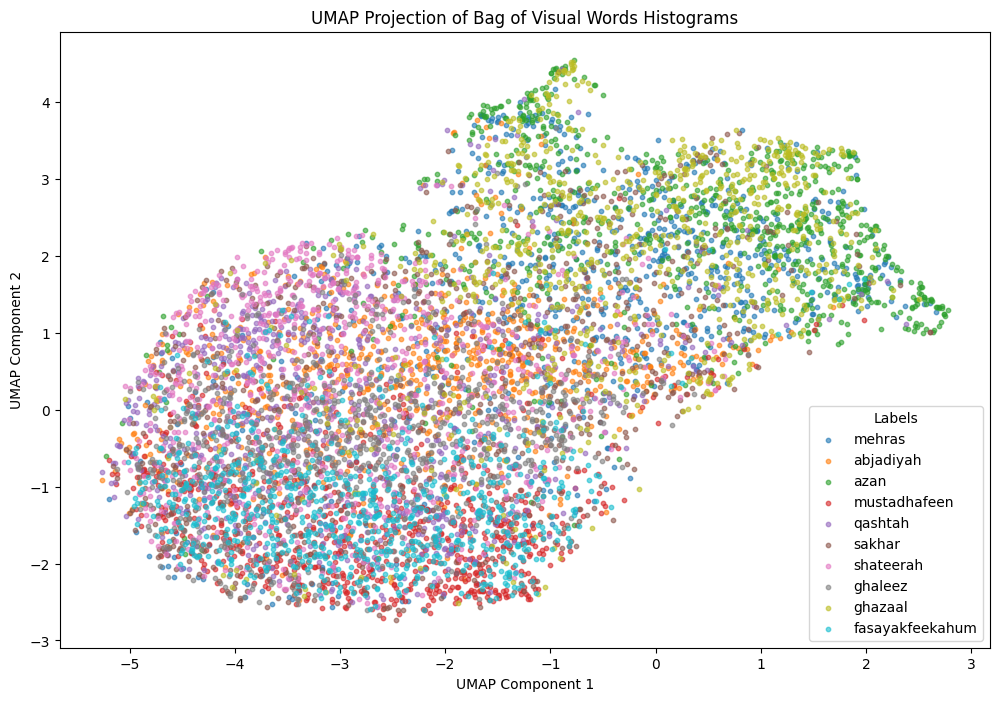

In [ ]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
import faiss  # For GPU-accelerated KMeans
import umap  # For UMAP dimensionality reduction

# Step 1: Organize images by word
def organize_images_by_word_across_users(directory_path):
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = []
                word_images[word_name].append(os.path.join(root, filename))
    return word_images

# Step 2: Extract ORB features
def extract_orb_features(image_path):
    orb = cv2.ORB_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = orb.detectAndCompute(image, None)
    return descriptors

# Parallel feature extraction
def extract_features_parallel(image_paths):
    return Parallel(n_jobs=-1)(
        delayed(extract_orb_features)(image_path) for image_path in image_paths
    )

# Step 3: Build the Visual Vocabulary (BoVW) with Faiss
def build_visual_vocabulary(all_descriptors, vocab_size=100):
    all_descriptors = np.vstack(all_descriptors).astype('float32')
    kmeans = faiss.Kmeans(
        d=all_descriptors.shape[1], k=vocab_size, niter=20, gpu=True, verbose=True
    )
    kmeans.train(all_descriptors)
    return kmeans

# Step 4: Compute histograms for images
def compute_histograms(image_paths, kmeans_model):
    histograms = []
    for image_path in image_paths:
        descriptors = extract_orb_features(image_path)
        if descriptors is not None:
            words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()
            hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=True)
            histograms.append(hist)
    return histograms

# Step 5: Train a classifier
def train_classifier(histograms, labels):
    X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return clf

# Step 6: Plot clusters using UMAP
def plot_clusters_with_umap(histograms, labels):
    """
    Plot image histograms in 2D space using UMAP.
    Args:
        histograms (list): List of histograms.
        labels (list): Corresponding labels for each histogram.
    """
    # Convert string labels to numeric indices
    unique_labels = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = [label_to_index[label] for label in labels]

    # Perform UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_histograms = umap_reducer.fit_transform(histograms)

    # Plot clusters
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors  # Use a set of distinct colors
    for idx, label in enumerate(unique_labels):
        indices = [i for i, numeric_label in enumerate(numeric_labels) if numeric_label == idx]
        plt.scatter(
            reduced_histograms[indices, 0],
            reduced_histograms[indices, 1],
            c=[colors[idx % len(colors)]],
            label=label,
            alpha=0.6,
            s=10,
        )

    plt.title("UMAP Projection of Bag of Visual Words Histograms")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Labels")
    plt.show()

# Main execution
main_directory = "/content/isolated_words_per_user"
word_images_dict = organize_images_by_word_across_users(main_directory)

# Extract all descriptors
all_descriptors = []
labels = []
for word, image_paths in word_images_dict.items():
    word_descriptors = extract_features_parallel(image_paths)
    word_descriptors = [desc for desc in word_descriptors if desc is not None]
    all_descriptors.extend(word_descriptors)
    labels.extend([word] * len(word_descriptors))

# Build visual vocabulary
vocab_size = 100  # Number of visual words
kmeans_model = build_visual_vocabulary(all_descriptors, vocab_size)

# Compute histograms for all images
histograms = []
labels_flat = []
for word, image_paths in word_images_dict.items():
    word_histograms = compute_histograms(image_paths, kmeans_model)
    histograms.extend(word_histograms)
    labels_flat.extend([word] * len(word_histograms))

# Train classifier on histograms
classifier = train_classifier(histograms, labels_flat)

# Plot clusters using UMAP
plot_clusters_with_umap(histograms, labels_flat)


# Orb feature extraction (enhancend)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:44:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classifier Accuracy: 0.65


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


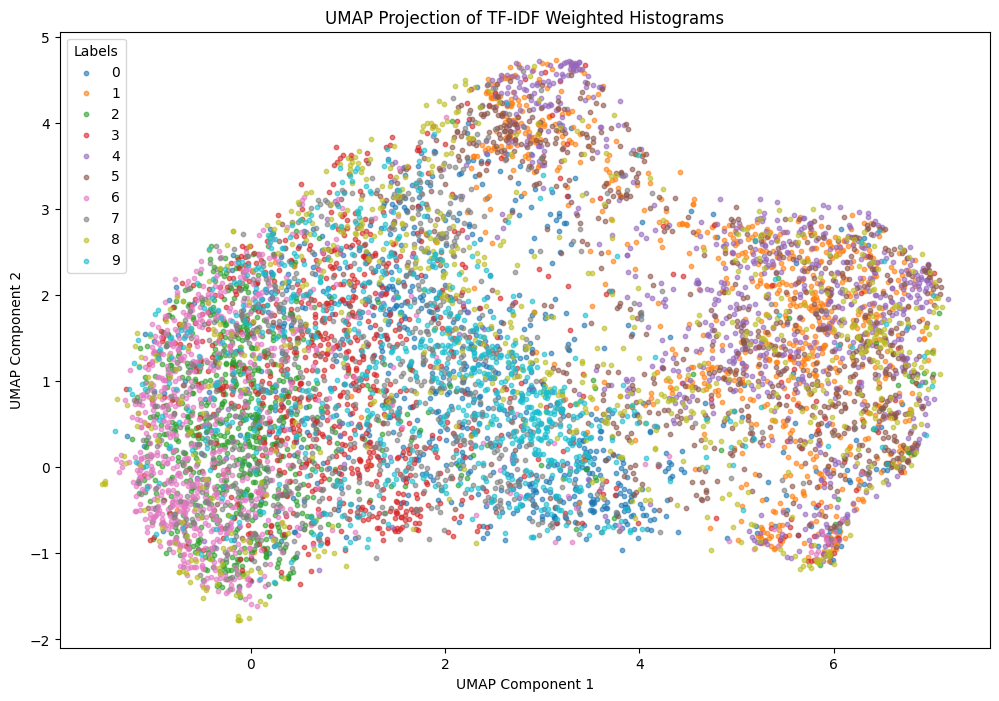

In [ ]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from joblib import Parallel, delayed
import faiss  # For GPU-accelerated KMeans
import umap  # For UMAP dimensionality reduction
from xgboost import XGBClassifier

# Step 1: Organize images by word
def organize_images_by_word_across_users(directory_path):
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = []
                word_images[word_name].append(os.path.join(root, filename))
    return word_images



# Step 2: Extract ORB features
def extract_orb_features(image_path):
    orb = cv2.ORB_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = orb.detectAndCompute(image, None)
    return descriptors

# Parallel feature extraction
def extract_features_parallel(image_paths):
    return Parallel(n_jobs=-1)(
        delayed(extract_orb_features)(image_path) for image_path in image_paths
    )

# Step 3: Build the Visual Vocabulary (BoVW) with Faiss
def build_visual_vocabulary(all_descriptors, vocab_size=500):
    all_descriptors = np.vstack(all_descriptors).astype('float32')
    kmeans = faiss.Kmeans(
        d=all_descriptors.shape[1], k=vocab_size, niter=20, gpu=True, verbose=True
    )
    kmeans.train(all_descriptors)
    return kmeans

# Step 4: Compute histograms for images
def compute_histograms(image_paths, kmeans_model):
    histograms = []
    for image_path in image_paths:
        descriptors = extract_orb_features(image_path)
        if descriptors is not None:
            words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()
            hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=False)
            histograms.append(hist)
    return histograms

# Step 5: Compute TF-IDF Weighted Histograms
def compute_weighted_histograms(histograms):
    transformer = TfidfTransformer(norm='l2')
    weighted_histograms = transformer.fit_transform(histograms).toarray()
    return weighted_histograms

# Step 6: Train a classifier
def train_classifier(histograms, labels):
    X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.2, random_state=42)

    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return clf

# Step 7: Plot clusters using UMAP
def plot_clusters_with_umap(histograms, labels):
    unique_labels = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = [label_to_index[label] for label in labels]

    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_histograms = umap_reducer.fit_transform(histograms)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors
    for idx, label in enumerate(unique_labels):
        indices = [i for i, numeric_label in enumerate(numeric_labels) if numeric_label == idx]
        plt.scatter(
            reduced_histograms[indices, 0],
            reduced_histograms[indices, 1],
            c=[colors[idx % len(colors)]],
            label=label,
            alpha=0.6,
            s=10,
        )

    plt.title("UMAP Projection of TF-IDF Weighted Histograms")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Labels")
    plt.show()

# Encode string labels to numeric indices
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder

# Main execution
main_directory = "/content/isolated_words_per_user"
word_images_dict = organize_images_by_word_across_users(main_directory)

# Extract all descriptors
all_descriptors = []
labels = []
for word, image_paths in word_images_dict.items():
    word_descriptors = extract_features_parallel(image_paths)
    word_descriptors = [desc for desc in word_descriptors if desc is not None]
    all_descriptors.extend(word_descriptors)
    labels.extend([word] * len(word_descriptors))

# Build visual vocabulary
vocab_size = 500  # Number of visual words
kmeans_model = build_visual_vocabulary(all_descriptors, vocab_size)

# Compute histograms for all images
histograms = []
labels_flat = []
for word, image_paths in word_images_dict.items():
    word_histograms = compute_histograms(image_paths, kmeans_model)
    histograms.extend(word_histograms)
    labels_flat.extend([word] * len(word_histograms))

# Compute TF-IDF weighted histograms
weighted_histograms = compute_weighted_histograms(histograms)

# Encode labels
encoded_labels, label_encoder = encode_labels(labels_flat)

# Train classifier on weighted histograms
classifier = train_classifier(weighted_histograms, encoded_labels)

# Plot clusters using UMAP
plot_clusters_with_umap(weighted_histograms, encoded_labels)


# Testing

FileUpload(value={}, accept='image/*', description='Upload')

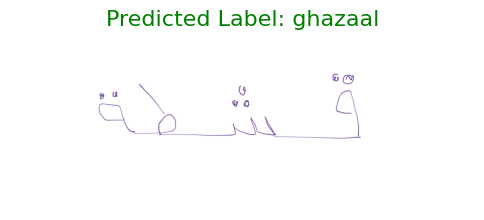

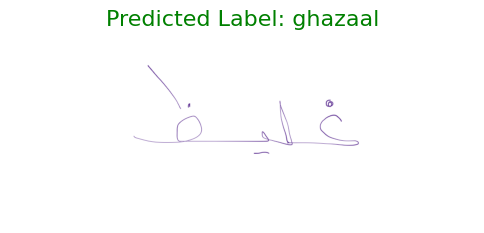

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder

# Function to extract ORB features
def extract_orb_features(image_path):
    orb = cv2.ORB_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = orb.detectAndCompute(image, None)
    return descriptors

# Function to classify a new image
def classify_image(image_path):
    # Extract features from the image
    descriptors = extract_orb_features(image_path)
    if descriptors is None:
        return "No descriptors found for the uploaded image.", None

    # Quantize descriptors using the visual vocabulary
    words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()

    # Compute a histogram for the image
    hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=False)

    # Apply TF-IDF weighting
    transformer = TfidfTransformer(norm='l2')
    weighted_hist = transformer.fit_transform([hist]).toarray()[0]

    # Classify the weighted histogram
    label_index = classifier.predict([weighted_hist])[0]
    predicted_label = label_encoder.inverse_transform([label_index])[0]

    return predicted_label, image_path

# Function to display the image with the predicted label
def display_image_with_label(image_path, label):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with the label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted Label: {label}", fontsize=16, color='green')
    plt.axis('off')
    plt.show()

# Function to handle file upload and classification
def on_upload_change(change):
    for filename, file_info in change['new'].items():
        # Save the uploaded file locally
        with open(filename, 'wb') as f:
            f.write(file_info['content'])

        # Classify the uploaded image
        label, image_path = classify_image(filename)
        if image_path:
            display_image_with_label(image_path, label)
        else:
            print(label)

# File uploader widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')

# Display the uploader
display(uploader)


# with fine tunning

# Sift feature extraction

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Classifier Accuracy: 0.67
Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


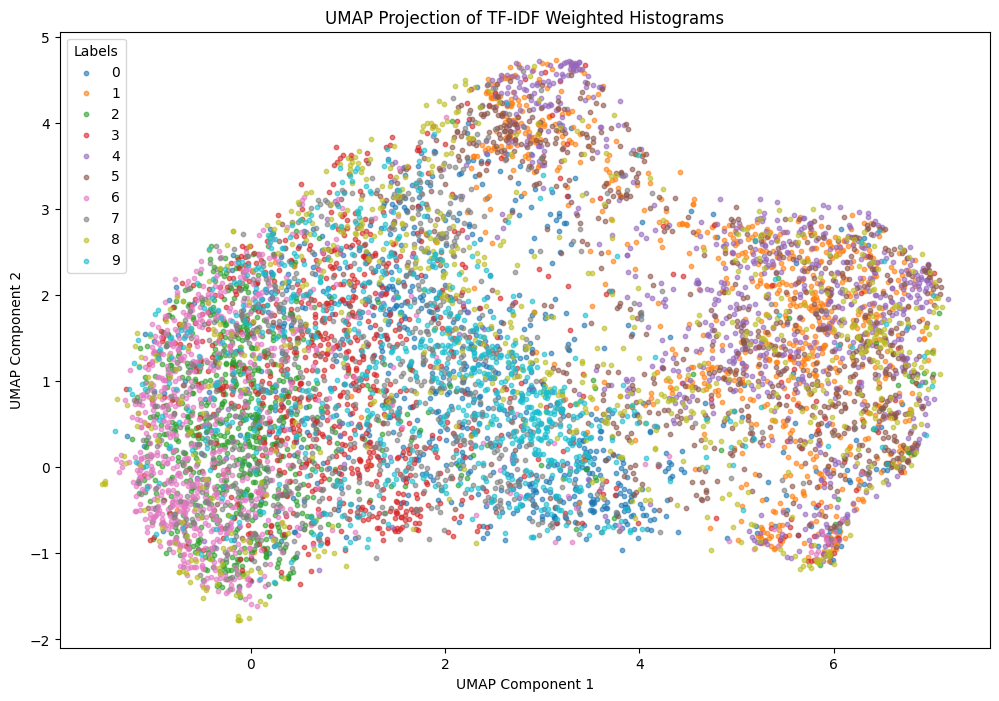

In [ ]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from joblib import Parallel, delayed
import faiss  # For GPU-accelerated KMeans
import umap  # For UMAP dimensionality reduction
from xgboost import XGBClassifier

# Step 1: Organize images by word
def organize_images_by_word_across_users(directory_path):
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = []
                word_images[word_name].append(os.path.join(root, filename))
    return word_images

# Step 2: Extract ORB features
def extract_orb_features(image_path):
    orb = cv2.ORB_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = orb.detectAndCompute(image, None)
    return descriptors

# Parallel feature extraction
def extract_features_parallel(image_paths):
    return Parallel(n_jobs=-1)(
        delayed(extract_orb_features)(image_path) for image_path in image_paths
    )

# Step 3: Build the Visual Vocabulary (BoVW) with Faiss
def build_visual_vocabulary(all_descriptors, vocab_size=500):
    all_descriptors = np.vstack(all_descriptors).astype('float32')
    kmeans = faiss.Kmeans(
        d=all_descriptors.shape[1], k=vocab_size, niter=20, gpu=True, verbose=True
    )
    kmeans.train(all_descriptors)
    return kmeans

# Step 4: Compute histograms for images
def compute_histograms(image_paths, kmeans_model):
    histograms = []
    for image_path in image_paths:
        descriptors = extract_orb_features(image_path)
        if descriptors is not None:
            words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()
            hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=False)
            histograms.append(hist)
    return histograms

# Step 5: Compute TF-IDF Weighted Histograms
def compute_weighted_histograms(histograms):
    transformer = TfidfTransformer(norm='l2')
    weighted_histograms = transformer.fit_transform(histograms).toarray()
    return weighted_histograms

# Step 6: Fine-tune classifier with GridSearchCV
def fine_tune_classifier(histograms, labels):
    X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.2, random_state=42)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Evaluate the best model
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    print(f"Best Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    return best_clf

# Step 7: Plot clusters using UMAP
def plot_clusters_with_umap(histograms, labels):
    unique_labels = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = [label_to_index[label] for label in labels]

    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_histograms = umap_reducer.fit_transform(histograms)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors
    for idx, label in enumerate(unique_labels):
        indices = [i for i, numeric_label in enumerate(numeric_labels) if numeric_label == idx]
        plt.scatter(
            reduced_histograms[indices, 0],
            reduced_histograms[indices, 1],
            c=[colors[idx % len(colors)]],
            label=label,
            alpha=0.6,
            s=10,
        )

    plt.title("UMAP Projection of TF-IDF Weighted Histograms")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Labels")
    plt.show()

# Encode string labels to numeric indices
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder

# Main execution
main_directory = "/content/isolated_words_per_user"
word_images_dict = organize_images_by_word_across_users(main_directory)

# Extract all descriptors
all_descriptors = []
labels = []
for word, image_paths in word_images_dict.items():
    word_descriptors = extract_features_parallel(image_paths)
    word_descriptors = [desc for desc in word_descriptors if desc is not None]
    all_descriptors.extend(word_descriptors)
    labels.extend([word] * len(word_descriptors))

# Build visual vocabulary
vocab_size = 500  # Number of visual words
kmeans_model = build_visual_vocabulary(all_descriptors, vocab_size)

# Compute histograms for all images
histograms = []
labels_flat = []
for word, image_paths in word_images_dict.items():
    word_histograms = compute_histograms(image_paths, kmeans_model)
    histograms.extend(word_histograms)
    labels_flat.extend([word] * len(word_histograms))

# Compute TF-IDF weighted histograms
weighted_histograms = compute_weighted_histograms(histograms)

# Encode labels
encoded_labels, label_encoder = encode_labels(labels_flat)

# Fine-tune classifier
best_classifier = fine_tune_classifier(weighted_histograms, encoded_labels)

# Plot clusters using UMAP
plot_clusters_with_umap(weighted_histograms, encoded_labels)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:08:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classifier Accuracy: 0.77


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


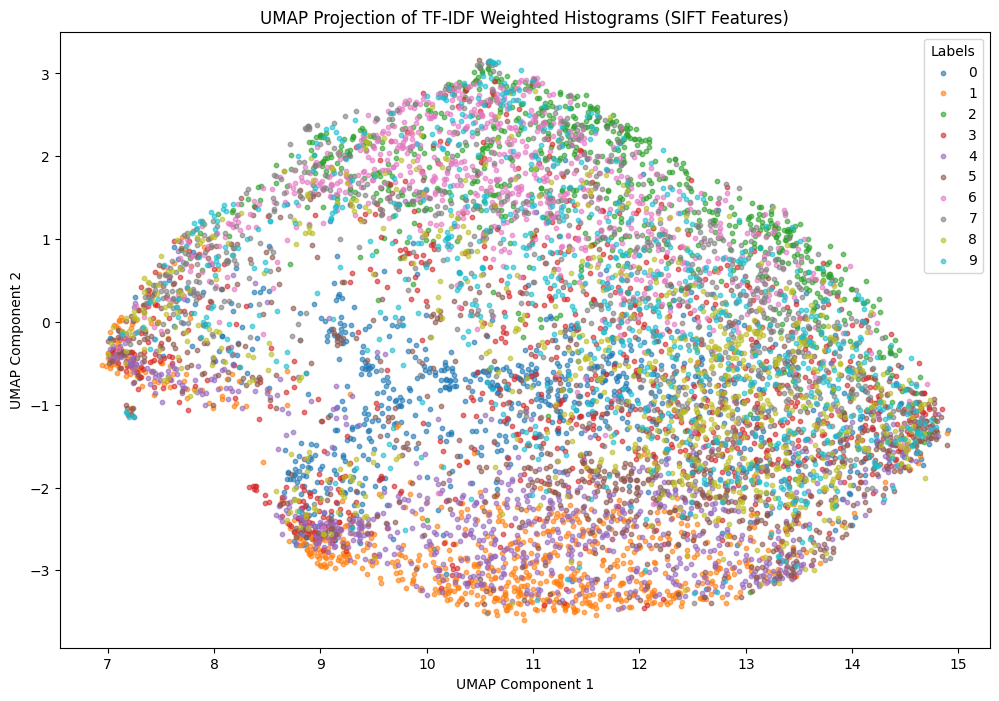

In [ ]:
import os
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from joblib import Parallel, delayed
import faiss  # For GPU-accelerated KMeans
import umap  # For UMAP dimensionality reduction
from xgboost import XGBClassifier

# Step 1: Organize images by word
def organize_images_by_word_across_users(directory_path):
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = []
                word_images[word_name].append(os.path.join(root, filename))
    return word_images

# Step 2: Extract SIFT features
def extract_sift_features(image_path):
    sift = cv2.SIFT_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Parallel feature extraction
def extract_features_parallel(image_paths):
    return Parallel(n_jobs=-1)(
        delayed(extract_sift_features)(image_path) for image_path in image_paths
    )

# Step 3: Build the Visual Vocabulary (BoVW) with Faiss
def build_visual_vocabulary(all_descriptors, vocab_size=500):
    all_descriptors = np.vstack(all_descriptors).astype('float32')
    kmeans = faiss.Kmeans(
        d=all_descriptors.shape[1], k=vocab_size, niter=20, gpu=True, verbose=True
    )
    kmeans.train(all_descriptors)
    return kmeans

# Step 4: Compute histograms for images
def compute_histograms(image_paths, kmeans_model):
    histograms = []
    for image_path in image_paths:
        descriptors = extract_sift_features(image_path)
        if descriptors is not None:
            words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()
            hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=False)
            histograms.append(hist)
    return histograms

# Step 5: Compute TF-IDF Weighted Histograms
def compute_weighted_histograms(histograms):
    transformer = TfidfTransformer(norm='l2')
    weighted_histograms = transformer.fit_transform(histograms).toarray()
    return weighted_histograms

# Step 6: Train a classifier
def train_classifier(histograms, labels):
    X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.2, random_state=42)

    clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return clf

# Step 7: Plot clusters using UMAP
def plot_clusters_with_umap(histograms, labels):
    unique_labels = list(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = [label_to_index[label] for label in labels]

    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_histograms = umap_reducer.fit_transform(histograms)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors
    for idx, label in enumerate(unique_labels):
        indices = [i for i, numeric_label in enumerate(numeric_labels) if numeric_label == idx]
        plt.scatter(
            reduced_histograms[indices, 0],
            reduced_histograms[indices, 1],
            c=[colors[idx % len(colors)]],
            label=label,
            alpha=0.6,
            s=10,
        )

    plt.title("UMAP Projection of TF-IDF Weighted Histograms (SIFT Features)")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Labels")
    plt.show()

# Encode string labels to numeric indices
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder

# Main execution
main_directory = "/content/isolated_words_per_user"
word_images_dict = organize_images_by_word_across_users(main_directory)

# Extract all descriptors
all_descriptors = []
labels = []
for word, image_paths in word_images_dict.items():
    word_descriptors = extract_features_parallel(image_paths)
    word_descriptors = [desc for desc in word_descriptors if desc is not None]
    all_descriptors.extend(word_descriptors)
    labels.extend([word] * len(word_descriptors))

# Build visual vocabulary
vocab_size = 500  # Number of visual words
kmeans_model = build_visual_vocabulary(all_descriptors, vocab_size)

# Compute histograms for all images
histograms = []
labels_flat = []
for word, image_paths in word_images_dict.items():
    word_histograms = compute_histograms(image_paths, kmeans_model)
    histograms.extend(word_histograms)
    labels_flat.extend([word] * len(word_histograms))

# Compute TF-IDF weighted histograms
weighted_histograms = compute_weighted_histograms(histograms)

# Encode labels
encoded_labels, label_encoder = encode_labels(labels_flat)

# Train classifier on weighted histograms
classifier = train_classifier(weighted_histograms, encoded_labels)

# Plot clusters using UMAP
plot_clusters_with_umap(weighted_histograms, encoded_labels)


Evaluation for Each Unique Word:

Word: qashtah
  Raw Accuracy: 0.51 (Time: 4.01s)
  Total SIFT Keypoints: 18243
    Scaled: 0.44 (Time: 17.26s)
    Rotated: 0.38 (Time: 11.06s)
    Illuminated: 0.37 (Time: 10.66s)
    Noisy: 0.34 (Time: 9.66s)


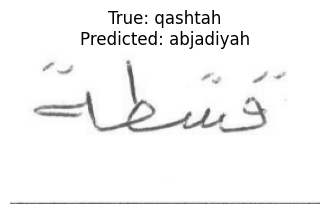

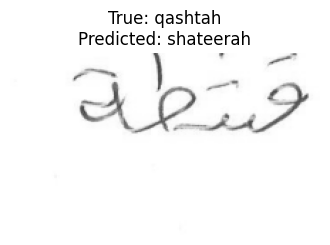

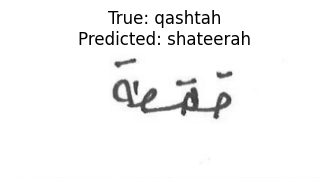

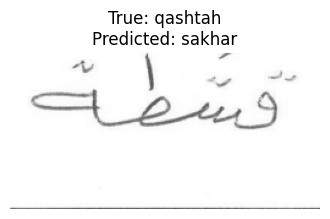

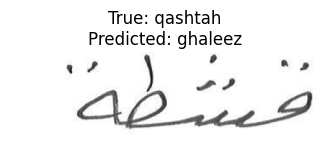


Word: sakhar
  Raw Accuracy: 0.78 (Time: 2.30s)
  Total SIFT Keypoints: 10037
    Scaled: 0.78 (Time: 10.48s)
    Rotated: 0.79 (Time: 10.39s)
    Illuminated: 0.67 (Time: 9.58s)
    Noisy: 0.82 (Time: 8.84s)


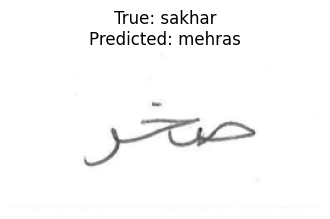

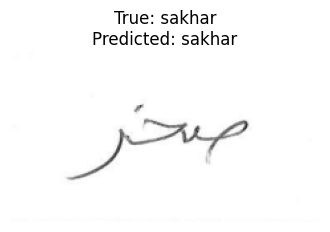

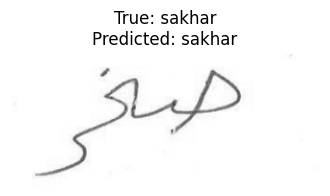

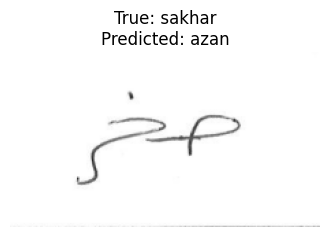

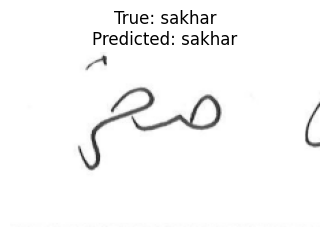


Word: azan
  Raw Accuracy: 0.88 (Time: 2.51s)
  Total SIFT Keypoints: 6472
    Scaled: 0.90 (Time: 10.07s)
    Rotated: 0.88 (Time: 11.56s)
    Illuminated: 0.88 (Time: 10.27s)
    Noisy: 0.90 (Time: 9.42s)


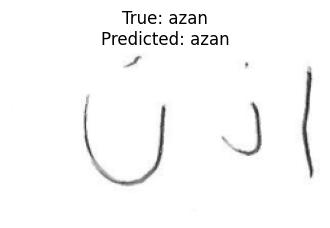

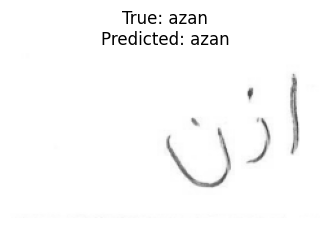

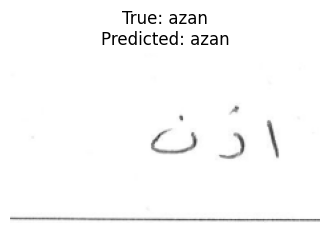

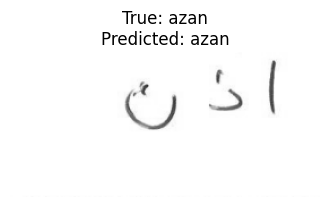

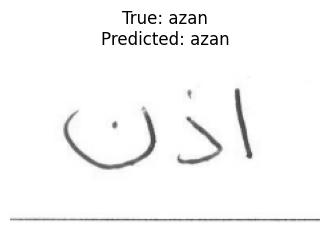


Word: shateerah
  Raw Accuracy: 0.47 (Time: 2.22s)
  Total SIFT Keypoints: 15774
    Scaled: 0.40 (Time: 9.04s)
    Rotated: 0.45 (Time: 10.78s)
    Illuminated: 0.34 (Time: 9.31s)
    Noisy: 0.23 (Time: 8.66s)


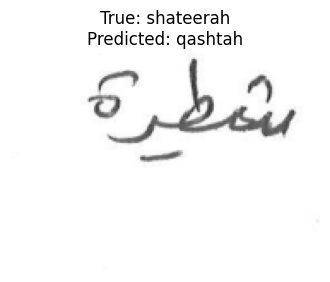

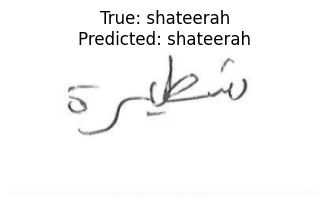

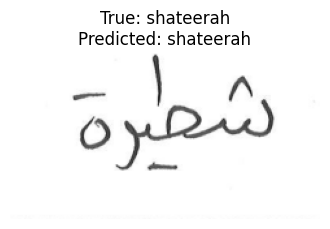

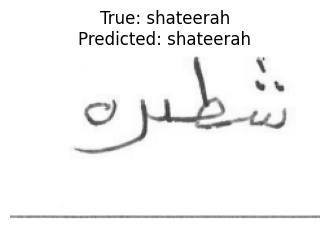

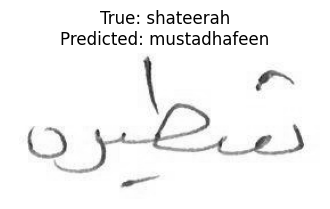


Word: abjadiyah
  Raw Accuracy: 0.56 (Time: 1.90s)
  Total SIFT Keypoints: 17507
    Scaled: 0.52 (Time: 9.33s)
    Rotated: 0.39 (Time: 9.56s)
    Illuminated: 0.46 (Time: 10.30s)
    Noisy: 0.14 (Time: 9.65s)


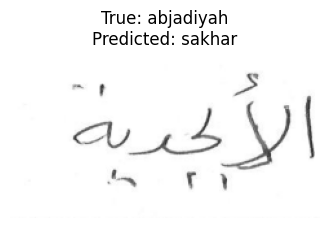

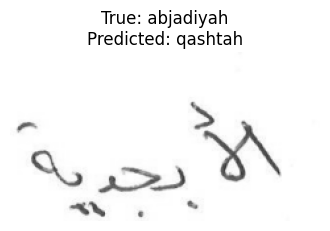

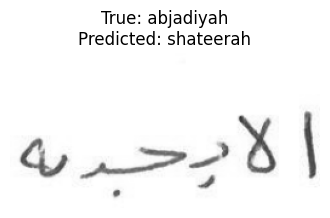

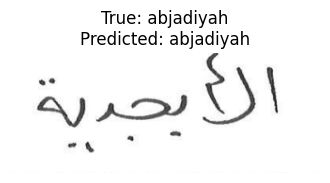

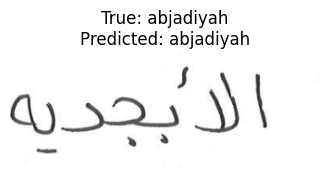


Word: mehras
  Raw Accuracy: 0.72 (Time: 3.29s)
  Total SIFT Keypoints: 11462
    Scaled: 0.57 (Time: 9.51s)
    Rotated: 0.65 (Time: 9.61s)
    Illuminated: 0.58 (Time: 9.69s)
    Noisy: 0.41 (Time: 10.70s)


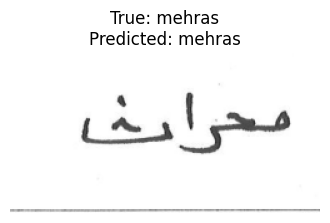

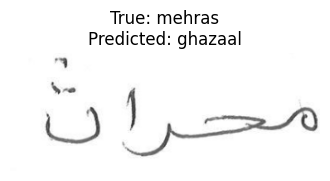

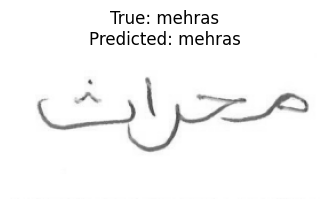

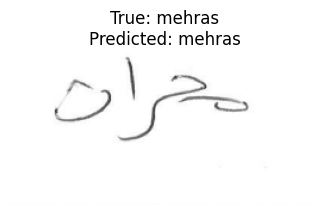

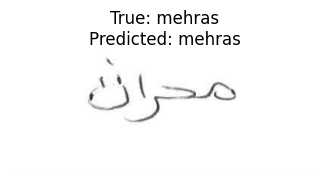


Word: ghaleez
  Raw Accuracy: 0.67 (Time: 2.79s)
  Total SIFT Keypoints: 12895
    Scaled: 0.55 (Time: 7.61s)
    Rotated: 0.56 (Time: 10.17s)
    Illuminated: 0.54 (Time: 9.86s)
    Noisy: 0.22 (Time: 10.70s)


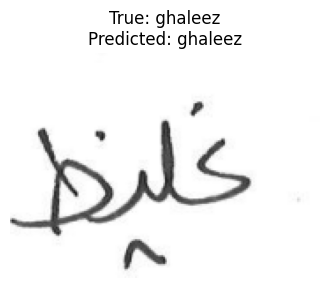

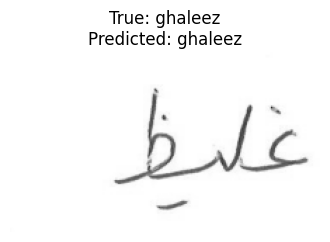

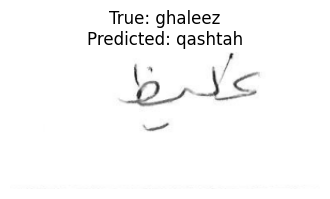

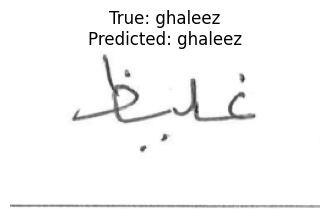

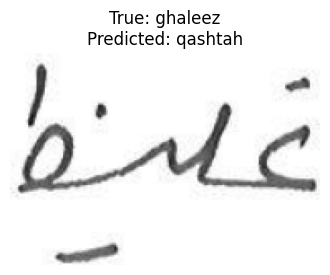


Word: mustadhafeen
  Raw Accuracy: 0.60 (Time: 2.62s)
  Total SIFT Keypoints: 24419
    Scaled: 0.51 (Time: 9.05s)
    Rotated: 0.50 (Time: 11.18s)
    Illuminated: 0.46 (Time: 10.65s)
    Noisy: 0.28 (Time: 10.27s)


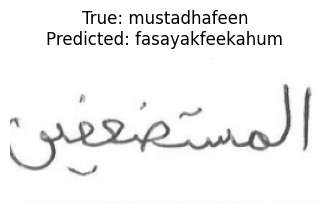

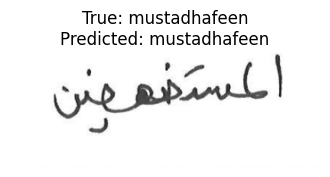

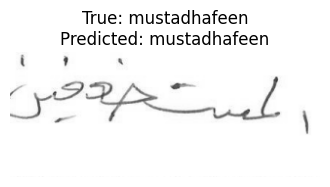

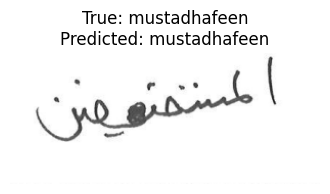

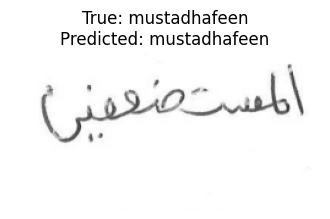


Word: ghazaal
  Raw Accuracy: 0.73 (Time: 1.77s)
  Total SIFT Keypoints: 8708
    Scaled: 0.67 (Time: 8.06s)
    Rotated: 0.66 (Time: 10.56s)
    Illuminated: 0.67 (Time: 9.54s)
    Noisy: 0.36 (Time: 9.46s)


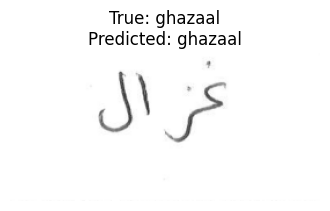

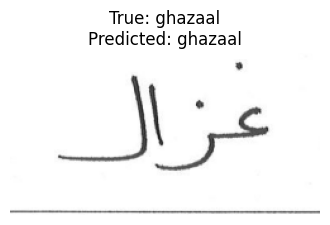

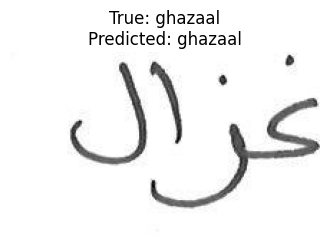

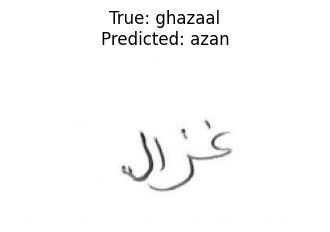

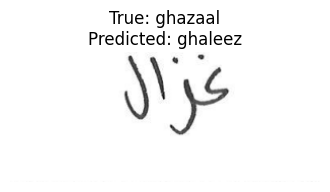


Word: fasayakfeekahum
  Raw Accuracy: 0.58 (Time: 2.42s)
  Total SIFT Keypoints: 22906
    Scaled: 0.37 (Time: 9.86s)
    Rotated: 0.48 (Time: 10.74s)
    Illuminated: 0.39 (Time: 11.24s)
    Noisy: 0.28 (Time: 10.35s)


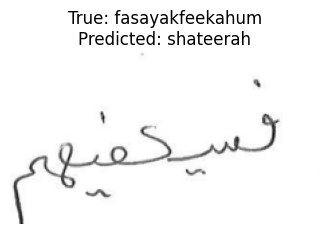

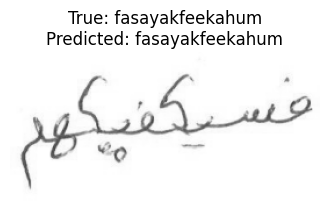

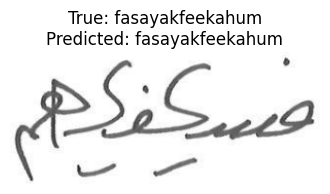

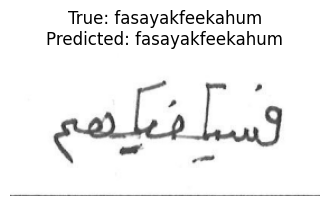

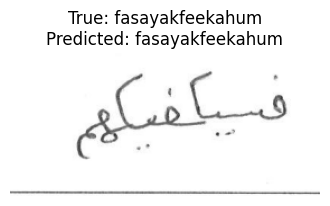

In [ ]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time  # Added for timing

# Augmentation Functions
def apply_scaling(image):
    return [cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) for scale in [0.5, 0.75, 1.25, 1.5]]

def apply_rotation(image):
    rows, cols = image.shape[:2]
    return [cv2.warpAffine(image, cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1), (cols, rows)) for angle in [15, 30, 45, 60]]

def apply_illumination(image):
    return [cv2.convertScaleAbs(image, alpha=alpha, beta=20) for alpha in [0.5, 0.75, 1.25, 1.5]]

def apply_noise(image):
    return [cv2.add(image, np.random.normal(0, variance, image.shape).astype(np.uint8)) for variance in [10, 20, 30, 40]]

# Evaluate accuracy for a specific word
def evaluate_word(test_images, test_labels, kmeans_model, label_encoder, word):
    word_indices = [i for i, label in enumerate(test_labels) if label == word]
    word_images = [test_images[i] for i in word_indices]
    word_labels = [test_labels[i] for i in word_indices]

    # Calculate SIFT keypoints
    total_keypoints = sum(len(extract_sift_keypoints(img)[0]) for img in word_images)

    # Time raw accuracy evaluation
    start_raw = time.time()
    X_test_raw = compute_weighted_histograms(compute_histograms(word_images, kmeans_model))
    y_test_encoded = label_encoder.transform(word_labels)
    y_pred = classifier.predict(X_test_raw)
    raw_accuracy = accuracy_score(y_test_encoded, y_pred)
    raw_time = time.time() - start_raw

    # Time augmentations
    augmentations = {
        "Scaled": [apply_scaling(img) for img in word_images],
        "Rotated": [apply_rotation(img) for img in word_images],
        "Illuminated": [apply_illumination(img) for img in word_images],
        "Noisy": [apply_noise(img) for img in word_images],
    }

    aug_accuracies = {}
    aug_times = {}
    for aug_type, aug_images in augmentations.items():
        flat_aug_images = []
        y_test_aug = []

        for label, aug_set in zip(word_labels, aug_images):
            flat_aug_images.extend(aug_set)
            y_test_aug.extend([label] * len(aug_set))

        # Time augmentation evaluation
        start_aug = time.time()
        X_test_aug = compute_weighted_histograms(compute_histograms(flat_aug_images, kmeans_model))
        if len(X_test_aug) != len(y_test_aug):
            min_length = min(len(X_test_aug), len(y_test_aug))
            X_test_aug = X_test_aug[:min_length]
            y_test_aug = y_test_aug[:min_length]

        y_test_encoded = label_encoder.transform(y_test_aug)
        y_pred = classifier.predict(X_test_aug)
        aug_accuracies[aug_type] = accuracy_score(y_test_encoded, y_pred)
        aug_times[aug_type] = time.time() - start_aug

    return raw_accuracy, aug_accuracies, total_keypoints, raw_time, aug_times

# Plot predictions for each word
def plot_predictions_for_word(word, test_images, test_labels, kmeans_model, label_encoder):
    word_indices = [i for i, label in enumerate(test_labels) if label == word]
    word_images = [test_images[i] for i in word_indices]
    word_labels = [test_labels[i] for i in word_indices]

    # Predict raw images
    X_test_raw = compute_weighted_histograms(compute_histograms(word_images, kmeans_model))
    y_test_encoded = label_encoder.transform(word_labels)
    y_pred = classifier.predict(X_test_raw)

    # Plot a few examples
    indices = random.sample(range(len(word_images)), min(5, len(word_images)))
    for idx in indices:
        image = cv2.cvtColor(word_images[idx], cv2.COLOR_BGR2RGB)
        true_label = word_labels[idx]
        predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12)
        plt.axis("off")
        plt.show()

# Evaluate each unique word
unique_words = list(test_images.keys())
results = {}

print("Evaluation for Each Unique Word:")
for word in unique_words[:10]:  # Limit to the first 10 unique words
    print(f"\nWord: {word}")
    raw_acc, aug_acc, total_keypoints, raw_time, aug_times = evaluate_word(test_images_flat, test_labels_flat, kmeans_model, label_encoder, word)
    results[word] = {
        "Raw Accuracy": raw_acc,
        "Augmentation Accuracies": aug_acc,
        "Total Keypoints": total_keypoints,
        "Raw Time": raw_time,
        "Augmentation Times": aug_times,
    }
    print(f"  Raw Accuracy: {raw_acc:.2f} (Time: {raw_time:.2f}s)")
    print(f"  Total SIFT Keypoints: {total_keypoints}")
    for aug_type, acc in aug_acc.items():
        print(f"    {aug_type}: {acc:.2f} (Time: {aug_times[aug_type]:.2f}s)")

    # Plot sample predictions for the word
    plot_predictions_for_word(word, test_images_flat, test_labels_flat, kmeans_model, label_encoder)


# Classifying new image

FileUpload(value={}, accept='image/*', description='Upload')

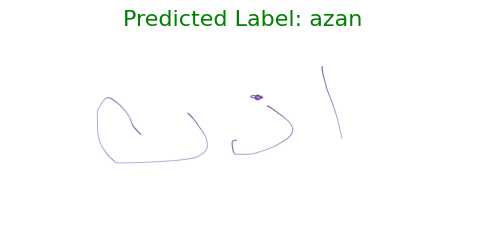

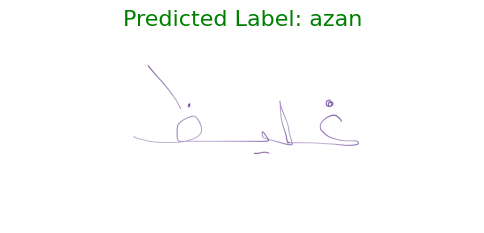

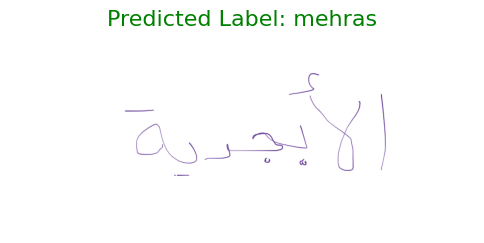

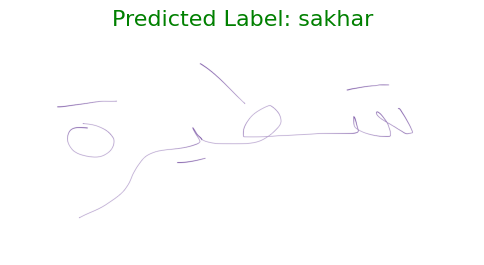

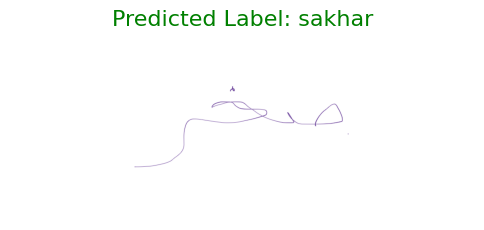

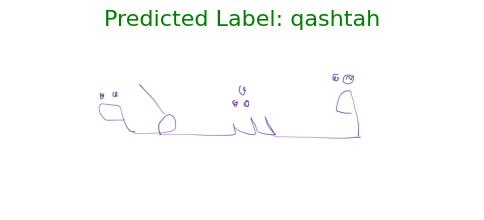

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder

# Extract SIFT features
def extract_sift_features(image_path):
    sift = cv2.SIFT_create()
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    _, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Classify a new image
def classify_image(image_path):
    # Extract features from the image
    descriptors = extract_sift_features(image_path)
    if descriptors is None:
        return "No descriptors found for the uploaded image.", None

    # Quantize descriptors using the visual vocabulary
    words = kmeans_model.index.search(descriptors.astype('float32'), 1)[1].flatten()

    # Compute a histogram for the image
    hist, _ = np.histogram(words, bins=np.arange(kmeans_model.k + 1), density=False)

    # Apply TF-IDF weighting
    transformer = TfidfTransformer(norm='l2')
    weighted_hist = transformer.fit_transform([hist]).toarray()[0]

    # Classify the weighted histogram
    label_index = classifier.predict([weighted_hist])[0]
    predicted_label = label_encoder.inverse_transform([label_index])[0]

    return predicted_label, image_path

# Display the image with the predicted label
def display_image_with_label(image_path, label):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with the label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted Label: {label}", fontsize=16, color='green')
    plt.axis('off')
    plt.show()

# Upload and classify function
def on_upload_change(change):
    for filename, file_info in change['new'].items():
        # Save the uploaded file locally
        with open(filename, 'wb') as f:
            f.write(file_info['content'])

        # Classify the uploaded image
        label, image_path = classify_image(filename)
        if image_path:
            display_image_with_label(image_path, label)
        else:
            print(label)

# File uploader widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')

# Display the uploader
display(uploader)


# we tried deep learning technique

In [ ]:
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import umap
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# Suppress TensorFlow debug logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs
tf.get_logger().setLevel('ERROR')

# Verify GPU usage
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used.")
else:
    print("No GPU available. Ensure TensorFlow is set up to use GPU.")

# Step 1: Organize images by word
def organize_images_by_word_across_users(directory_path):
    word_images = {}
    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                word_name = filename.split('_')[1]
                if word_name not in word_images:
                    word_images[word_name] = []
                word_images[word_name].append(os.path.join(root, filename))
    return word_images

# Step 2: Load ResNet50 for deep feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_deep_features(image_paths):
    """
    Extract deep features from images using ResNet50.
    Args:
        image_paths (list): List of image file paths.
    Returns:
        np.array: Deep features for each image.
    """
    features = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))  # Resize to model input size
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        with tf.device('/GPU:0'):  # Explicitly run on GPU
            feature = base_model.predict(image, verbose=0)
        features.append(feature.flatten())
    return np.array(features)

# Step 3: Prepare data for clustering and classification
def prepare_data(word_images_dict):
    all_features = []
    labels = []
    word_to_label = {}
    label_to_word = {}
    current_label = 0

    for word, image_paths in word_images_dict.items():
        features = extract_deep_features(image_paths)
        all_features.append(features)
        labels.extend([current_label] * len(features))
        word_to_label[word] = current_label
        label_to_word[current_label] = word
        current_label += 1

    return np.vstack(all_features), np.array(labels), word_to_label, label_to_word

# Step 4: Perform clustering with KMeans
def cluster_data(features, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels

# Step 5: Train an SVM classifier
def train_svm_classifier(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = SVC(kernel='linear', random_state=42)  # Use a linear kernel for simplicity
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return clf, X_test, y_test

# Step 6: Dimensionality reduction with UMAP and visualization
def visualize_clusters(features, cluster_labels, labels, label_to_word):
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_features = reducer.fit_transform(features)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors  # Use distinct colors for clusters

    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(
            reduced_features[indices, 0],
            reduced_features[indices, 1],
            label=label_to_word[label],
            alpha=0.6,
            s=10,
        )

    plt.title("Cluster Comparison with UMAP")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Words")
    plt.show()

# Main execution
main_directory = "/content/isolated_words_per_user"  # Update this with your directory path
word_images_dict = organize_images_by_word_across_users(main_directory)

# Extract deep features and prepare data
features, labels, word_to_label, label_to_word = prepare_data(word_images_dict)

# Perform clustering
cluster_labels = cluster_data(features, num_clusters=10)

# Train SVM classifier
classifier, X_test, y_test = train_svm_classifier(features, labels)

# Visualize clus


GPU is available and will be used.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Classifier Accuracy: 0.98


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


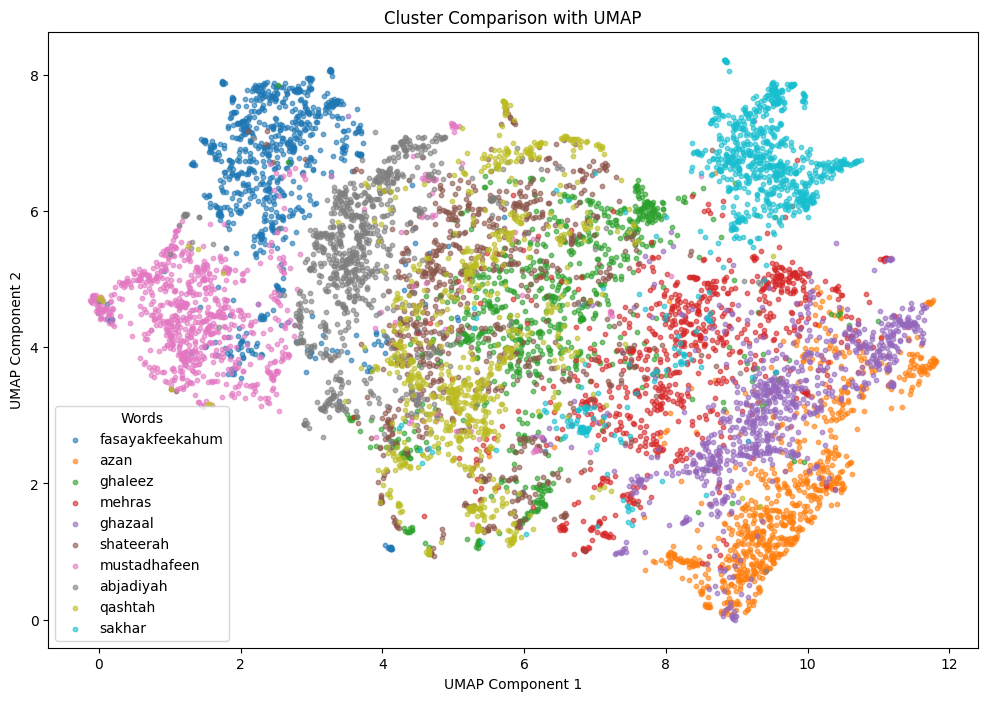

In [ ]:

# Visualize clus
visualize_clusters(features, cluster_labels, labels, label_to_word)


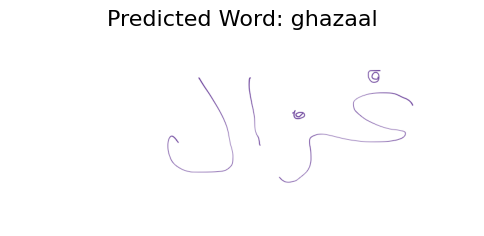

Predicted Word: ghazaal


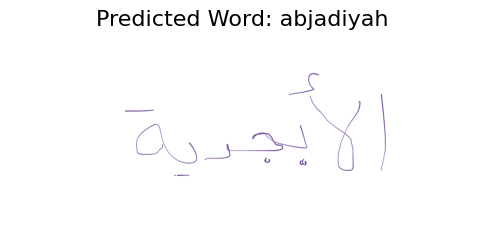

Predicted Word: abjadiyah


In [ ]:
def predict_image_and_plot(image_path, classifier, base_model, word_to_label):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct plotting
    image_resized = cv2.resize(image, (224, 224))
    image_input = np.expand_dims(image_resized, axis=0)
    image_input = preprocess_input(image_input)

    # Extract features and classify
    with tf.device('/GPU:0'):  # Ensure prediction uses GPU
        feature = base_model.predict(image_input, verbose=0).flatten()
    label = classifier.predict([feature])[0]

    # Reverse lookup for label to word
    word = {v: k for k, v in word_to_label.items()}[label]

    # Plot the image and its classification
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(f"Predicted Word: {word}", fontsize=16)
    plt.axis('off')
    plt.show()

    return word

# Example usage
test_image_path = "/content/Screenshot 2024-12-03 181653.png"
predicted_word = predict_image_and_plot(test_image_path, classifier, base_model, word_to_label)
print(f"Predicted Word: {predicted_word}")

test_image_path = "/content/Screenshot 2024-12-03 182029.png"
predicted_word = predict_image_and_plot(test_image_path, classifier, base_model, word_to_label)
print(f"Predicted Word: {predicted_word}")

# done Deep learning


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import faiss  # GPU-accelerated KMeans

# Path to the main directory containing user folders
main_directory = "/content/isolated_words_per_user"

def load_images_from_nested_directory(directory_path):
    """
    Load and preprocess all images from a directory where each user has a separate folder.
    Normalize and resize images for consistency.
    """
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"Directory '{directory_path}' not found. Please check the path.")

    user_images = {}
    for user_folder in os.listdir(directory_path):
        user_path = os.path.join(directory_path, user_folder)
        if os.path.isdir(user_path):
            user_images[user_folder] = []
            for filename in os.listdir(user_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(user_path, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        # Normalize and resize images
                        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
                        image = cv2.resize(image, (256, 256))
                        user_images[user_folder].append((filename, image))
    return user_images

def augment_images(user_images):
    """
    Apply additional augmentations such as brightness adjustments and affine transformations.
    """
    augmented_images = {}
    for user, images in user_images.items():
        augmented_images[user] = []
        for filename, img in images:
            rows, cols = img.shape

            # Rotate
            angle = np.random.randint(-15, 15)
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            rotated = cv2.warpAffine(img, M, (cols, rows))

            # Flip
            flipped = cv2.flip(img, 1)

            # Add Gaussian Noise
            noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
            noisy = cv2.add(img, noise)

            # Brightness Adjustment
            brightness = np.clip(img + np.random.randint(-30, 30), 0, 255).astype(np.uint8)

            # Affine Transformation
            pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
            pts2 = pts1 + np.random.randint(-10, 10, pts1.shape).astype(np.float32)
            M = cv2.getAffineTransform(pts1, pts2)
            affine = cv2.warpAffine(img, M, (cols, rows))

            augmented_images[user].extend([
                (f"{filename}_rotated", rotated),
                (f"{filename}_flipped", flipped),
                (f"{filename}_noisy", noisy),
                (f"{filename}_brightness", brightness),
                (f"{filename}_affine", affine),
            ])
    return augmented_images

def extract_sift_features(user_images):
    """
    Extract features using SIFT with adjusted parameters for more keypoints.
    """
    sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=5)
    user_descriptors = {}
    descriptors_list = []

    def process_image(img):
        _, descriptors = sift.detectAndCompute(img, None)
        return descriptors

    for user, images in user_images.items():
        user_descriptors[user] = []
        for _, img in images:
            descriptors = process_image(img)
            if descriptors is not None:
                user_descriptors[user].append(descriptors)
                descriptors_list.append(descriptors)

    descriptors_array = np.vstack(descriptors_list)
    return descriptors_array, user_descriptors

def cluster_descriptors(descriptors, n_clusters=500):
    """
    Cluster descriptors using GPU-accelerated KMeans with a larger number of clusters.
    """
    d = descriptors.shape[1]
    kmeans = faiss.Kmeans(d, n_clusters, gpu=True)
    kmeans.train(descriptors.astype(np.float32))
    return kmeans

def create_bow_histograms(user_descriptors, kmeans):
    """
    Create Bag-of-Words histograms and apply TF-IDF weighting.
    """
    n_clusters = kmeans.centroids.shape[0]
    user_histograms = []
    user_labels = []

    def generate_histogram(descriptors):
        assignments = kmeans.index.search(descriptors.astype(np.float32), 1)[1]
        histogram, _ = np.histogram(assignments, bins=n_clusters, range=(0, n_clusters))
        return histogram

    for user, descriptors_list in user_descriptors.items():
        for descriptors in descriptors_list:
            histogram = generate_histogram(descriptors)
            user_histograms.append(histogram)
            user_labels.append(user)

    histograms = np.array(user_histograms)
    labels = np.array(user_labels)

    # Apply TF-IDF weighting
    tfidf = TfidfTransformer()
    weighted_histograms = tfidf.fit_transform(histograms).toarray()

    return weighted_histograms, labels

def train_and_evaluate_nn(features, labels):
    """
    Train and evaluate a Multi-Layer Neural Network (MLNN) classifier.
    """
    # Encode labels as integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Convert labels to one-hot encoding
    categorical_labels = to_categorical(encoded_labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features, categorical_labels, test_size=0.2, random_state=42
    )

    # Define the neural network architecture
    model = Sequential([
        Dense(512, activation='relu', input_dim=features.shape[1]),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(categorical_labels.shape[1], activation='softmax')  # Number of classes
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_nn_model.keras', save_best_only=True, monitor='val_loss')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Adjust epochs based on dataset size and training time
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping, checkpoint]
    )

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return model, label_encoder

def full_pipeline_with_nn(directory_path):
    """
    Complete pipeline with a Multi-Layer Neural Network (MLNN) classifier.
    """
    user_images = load_images_from_nested_directory(directory_path)
    augmented_images = augment_images(user_images)
    descriptors_array, user_descriptors = extract_sift_features(augmented_images)
    kmeans = cluster_descriptors(descriptors_array, n_clusters=500)
    features, labels = create_bow_histograms(user_descriptors, kmeans)
    model, label_encoder = train_and_evaluate_nn(features, labels)
    return model, label_encoder, kmeans

# Run the pipeline
nn_model, label_encoder, kmeans = full_pipeline_with_nn(main_directory)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.0244 - loss: 4.3063 - val_accuracy: 0.0829 - val_loss: 3.8498
Epoch 2/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0827 - loss: 3.7985 - val_accuracy: 0.1279 - val_loss: 3.5593
Epoch 3/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1415 - loss: 3.4683 - val_accuracy: 0.1599 - val_loss: 3.3851
Epoch 4/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1979 - loss: 3.1654 - val_accuracy: 0.1810 - val_loss: 3.2736
Epoch 5/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2408 - loss: 2.9354 - val_accuracy: 0.2038 - val_loss: 3.2261
Epoch 6/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2926 - loss: 2.7085 - val_accuracy: 0.2143 - val_loss: 3.1783
Epoch 7/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3389 - loss: 2.4892 - val_accuracy: 0.2201 - val_loss: 3.1817
Epoch 8/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3821 - loss: 2.3018 - val_accuracy: 